### Importing Packages 

In [1]:
import pickle

import numpy as np 
import pandas as pd

import re 
import string 

import nltk


from langdetect import detect


from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF


import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import gensim
from gensim import corpora, models, matutils
from gensim.models import CoherenceModel

from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

## Opening Scrapped Data 

In [ ]:
with open('pokemon.pickle','rb') as read_file:
    df = pickle.load(read_file)

# Data Cleaning 

## Dataset 

In [ ]:
df.info()  

In [ ]:
df['rating'] = df['rating'].astype(int)

In [ ]:
### Group  reviews by their metacritic ratings 
### 0 to 4 = negative, 5 to 7 mixed, 8 and above = positive 

def sentiment(x):
    if x > 7:
        return 'positive'
    if x < 5:
        return 'negative'
    else: return 'mixed'

df['sentiment'] = df['rating'].apply(lambda x:sentiment(x))


In [ ]:
df['sentiment'].value_counts(normalize = True)

In [ ]:
### Some users reviewed both pokemon sword and shield. 
### These reviews tended to be a copy-paste 

df[df.duplicated('name')]

In [ ]:
df.review[df['name'] == 'Mack_thge_Sack']

In [ ]:
df.reset_index(inplace = True, drop = True)

In [ ]:
### Remove duplicate users 
df.drop_duplicates(subset='name', keep = 'first', inplace = True)

In [ ]:
### detect review language and returns NaN if not english 
def language_detection(x): 
    result = detect(x)
    if result == 'en':
        return x 
    else: return np.NaN 
    
df['review'] = df['review'].apply(lambda x:language_detection(x))

### Only keep english reviews 
df.dropna(inplace = True)

In [ ]:
#df.to_pickle('clean_dataset.pickle')

### Text Cleaning 

In [35]:
with open('clean_dataset.pickle','rb') as read_file:
    df = pickle.load(read_file)

In [2]:
### creating stopword list from both nltk and spacy 
nltk_stop_words = nltk.corpus.stopwords.words('english')

stop_words =  list(STOP_WORDS)
stop_words.extend(['game','pokemon','pokémon']) ### these are common words that appear in almost all reviews 

for word in nltk_stop_words:
    if word in stop_words: 
        continue
    else: stop_words.append(word)

# for word in stop_words:
#     no_punct = remove_punctuation(word)
#     if no_punct not in stop_words: 
#         stop_words.append(no_punct)

In [ ]:
def make_lower(text):
    return text.lower()

def remove_words(text,wordlist):
    for word in wordlist:
        if word in text.split():
            text = re.sub(r'\b{}\b'.format(word), '', text)  
    return text

def remove_digits(text):
    return re.sub('\d', ' ', text)

def remove_punctuation(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) 
    return re.sub(r'[^\w\s]', ' ', text)

def strip_extraspace(text):
    return re.sub('\s\s+',' ', text)

def replace_word(text,word,replacement):
    return text.replace(word,replacement)

def remove_r(text):
    return text.replace('\r',' ')
#df['review'] = df['review'].apply(lambda x:remove_punctuation(x))

def clean_text(text):
    text = make_lower(text)
    text = remove_punctuation(text)
    text = remove_digits(text)
    text = replace_word(text,'game freak','gamefreak') ### correcting inconsistencies in spelling that I noticed 
    text = replace_word(text, 'game play', 'gameplay')
    text = remove_words(text,stop_words)
    text = remove_r(text)
    text = strip_extraspace(text)
    return text

In [ ]:
df['review'] = df['review'].apply(lambda x:clean_text(x))

In [ ]:
df['review'][5]

In [ ]:
### lemmatising using spacy
sp = spacy.load('en_core_web_sm')

def lemmatize_words(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    text = sp(text)
    lemmed_string =''
    for word in text:
        if word.pos_ in allowed_postags:
            if word.lemma_ == '-PRON-' or word.lemma_ in stop_words: 
                ### skip words that are not in allowed postags or becomes a stopword when lemmatised   
                continue 
            else: lemmed_string = lemmed_string+' '+word.lemma_
    return lemmed_string.lstrip()

In [ ]:
df['review'] = df['review'].apply(lambda x:lemmatize_words(x, allowed_postags=['NOUN', 'VERB']))

In [ ]:
### Skipping this because n-grams seem to work better for the data 

# # Build the bigram and trigram models - reference: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# data = []
# for entry in df.review:
#     data.append(entry.split())

# bigram = gensim.models.Phrases(data, min_count=5, threshold=10) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[data], threshold=10)  

# bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

# def make_bigrams(x):
#     text = bigram_mod[x.split()] 
#     grammed_string = ''
#     for word in text: 
#         grammed_string = grammed_string+' '+word 
#     return grammed_string 

# def make_trigrams(x):
#     text = trigram_mod[bigram_mod[x.split()] ] 
#     grammed_string = ''
#     for word in text: 
#         grammed_string = grammed_string+' '+word 
#     return grammed_string 
# df['review1'] = df['review'].apply(lambda x:make_bigrams(x))  
# df['review1'] = df['review'].apply(lambda x:make_trigrams(x))  

In [ ]:
### list all words that appear in less than 4 documents, and remove them from the reviews 

word_frequency = Counter()

for text in df.review:
    text = text.split()
    word_frequency.update(set(text)) 

rare_words = []

for key, value in word_frequency.items():
    if value < 4:
        rare_words.append(key)


In [ ]:
df['review'] = df['review'].apply(lambda x:remove_words(x,rare_words)) 

In [ ]:
sorted_word_freq = sorted(word_frequency.items(), key=lambda x: x[1], reverse = True)

In [ ]:
sorted_word_freq ###add common words to stop_words 

In [3]:
#df.to_pickle('dfclean.pickle')

with open('dfclean.pickle','rb') as read_file:
     df = pickle.load(read_file)

## Splitting df by sentiment 

In [4]:
negative = df[df['sentiment']=='negative']
mixed = df[df['sentiment']=='mixed']
positive = df[df['sentiment']=='postive']


In [5]:
negative

name          date  rating  \
0          Otonaburu  Nov 15, 2019       4   
1          Metagrass  Nov 15, 2019       2   
2            Drakhis  Nov 15, 2019       2   
3            Ok_Then  Nov 15, 2019       4   
4      NintendoGuy64  Nov 15, 2019       0   
...              ...           ...     ...   
3224      moosbuckel  Nov 21, 2019       1   
3227       Bashbach1  Nov 21, 2019       4   
3233  Eduardobritola  Nov 22, 2019       3   
3250       Potteriti  Nov 24, 2019       2   
3251        NellTull  Nov 25, 2019       0   

                                                 review    game sentiment  
0     hardware feel port feature improvement come pr...  shield  negative  
1     sword version copy imagine bother year fan reg...  shield  negative  
2     fan lot problem turn exp bug wipe switch versi...  shield  negative  
3     feel port build  fan enjoy feel generation upg...  shield  negative  
4     fan  announce console alright taste need world...  shield  negative  
...                                                 ...     ...       ...  
3224  play hour bore story  route bore way exp syste...   sword  negative  
3227  know begin gamefreak run idea remodel remade v...   sword  negative  
3233               world design experience immerse  old   sword  negative  
3250                                         design let   sword  negative  
3251  cut series expect pay money want botw look are...   sword  negative  

[1349 rows x 6 columns]

In [6]:
vectorizer = CountVectorizer(stop_words=stop_words, ngram_range = (1,2),
                                   token_pattern="\\b[a-z][a-z][a-z]+\\b") ###ignore words that are less than 3 alphabets  

In [ ]:
### view document-word matrix 
#pd.DataFrame(doc_word.toarray(), index=negative.review, columns=vectorizer.get_feature_names()).head(10)

## LSA 

In [43]:
doc_word = vectorizer.fit_transform(negative.review)
doc_word.shape

(1349, 30871)

In [44]:
num_lsa_topics = 4

lsa = TruncatedSVD(num_lsa_topics)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.07925652, 0.02176168, 0.01481096, 0.01203162])

In [47]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = range(0,num_lsa_topics),
             columns = vectorizer.get_feature_names())
topic_word

aaa  aaa expect  aaa intention  aaa look  aaa price  aaa quality  \
0  0.001       0.000            0.0     0.000      0.000        0.000   
1 -0.002      -0.000           -0.0    -0.000     -0.001       -0.001   
2 -0.002      -0.001           -0.0    -0.001     -0.001        0.001   
3 -0.003      -0.001           -0.0    -0.000     -0.000       -0.001   

   aaa title  abandon  abandon expect  abandon include  ...  zone explore  \
0        0.0    0.001           0.000            0.001  ...         0.001   
1       -0.0   -0.003           0.000           -0.002  ...        -0.000   
2       -0.0   -0.002           0.001           -0.001  ...        -0.000   
3       -0.0   -0.001          -0.000            0.002  ...         0.002   

   zone fill  zone know  zone level  zone look  zone remove  zone speak  \
0        0.0      0.001         0.0      0.000        0.000       0.000   
1        0.0     -0.003         0.0     -0.001       -0.001       0.000   
2       -0.0     -0.001         0.0     -0.000        0.000      -0.000   
3        0.0     -0.002         0.0     -0.001        0.000       0.001   

   zone story  zone test  zone update  
0       0.000      0.000        0.000  
1      -0.000      0.000       -0.001  
2      -0.001     -0.000        0.001  
3       0.000      0.001        0.000  

[4 rows x 30871 columns]

In [48]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [49]:
display_topics(lsa, vectorizer.get_feature_names(), 15)


Topic  0
feel, battle, animation, time, area, look, story, play, cut, model, character, feature, fan, switch, thing

Topic  1
feel, area, battle, gym, story, route, fight, explore, catch, challenge, character, design, level, team, raid

Topic  2
animation, battle, model, look, attack, texture, turn, model animation, tree, overworld, animation model, reuse, trainer, world, pop

Topic  3
area, gym, cut, catch, team, problem, character, level, content, fight, series, remove, find, way, turn


### NMF 

In [50]:
num_nmf_topics = 4

nmf_model = NMF(num_nmf_topics)
doc_topic = nmf_model.fit_transform(doc_word)

In [51]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = range(0,num_nmf_topics),
             columns = vectorizer.get_feature_names())
topic_word

aaa  aaa expect  aaa intention  aaa look  aaa price  aaa quality  \
0  0.000       0.000          0.000     0.000      0.000        0.000   
1  0.020       0.004          0.002     0.004      0.005        0.000   
2  0.001       0.000          0.000     0.000      0.000        0.008   
3  0.000       0.000          0.000     0.001      0.000        0.001   

   aaa title  abandon  abandon expect  abandon include  ...  zone explore  \
0      0.000    0.000           0.000            0.000  ...         0.013   
1      0.001    0.021           0.000            0.013  ...         0.006   
2      0.002    0.006           0.005            0.004  ...         0.001   
3      0.000    0.003           0.003            0.000  ...         0.000   

   zone fill  zone know  zone level  zone look  zone remove  zone speak  \
0      0.003      0.000       0.002      0.000        0.000       0.008   
1      0.000      0.020       0.000      0.008        0.001       0.001   
2      0.000      0.004       0.000      0.002        0.004       0.000   
3      0.000      0.000       0.000      0.000        0.000       0.000   

   zone story  zone test  zone update  
0       0.000      0.005        0.000  
1       0.004      0.000        0.000  
2       0.000      0.000        0.006  
3       0.000      0.000        0.000  

[4 rows x 30871 columns]

In [52]:
display_topics(nmf_model, vectorizer.get_feature_names(), 15)


Topic  0
area, gym, battle, story, character, catch, team, time, level, problem, route, find, point, fight, way

Topic  1
fan, play, time, content, cut, franchise, gamefreak, switch, release, want, graphic, year, thing, people, buy

Topic  2
animation, model, look, cut, battle, quality, turn, lie, gamefreak, graphic, lot, let, texture, switch, time

Topic  3
feel, battle, look, story, time, play, design, area, world, lack, lot, player, entry, music, compare


### LDA 

In [35]:
vectorizer.fit(negative.review)
doc_word = vectorizer.transform(negative.review).transpose()

In [ ]:
# vectorizer.fit(positive.review)
# doc_word = vectorizer.transform(positive.review).transpose()

In [36]:
corpus = matutils.Sparse2Corpus(doc_word)

In [37]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [38]:
word2id = dict((v, k) for v, k in vectorizer.vocabulary_.items())
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

common_dictionary = corpora.Dictionary()
common_dictionary.id2token = id2word
common_dictionary.token2id = word2id

In [44]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=77,
                                           update_every=1,
                                           chunksize=100,
                                           #passes=50, iterations = 100,
                                           alpha='auto',
                                           per_word_topics=True)

2019-12-02 07:20:00,336 : INFO : using autotuned alpha, starting with [0.25, 0.25, 0.25, 0.25]
2019-12-02 07:20:00,338 : INFO : using symmetric eta at 0.25
2019-12-02 07:20:00,349 : INFO : using serial LDA version on this node
2019-12-02 07:20:00,367 : INFO : running online (single-pass) LDA training, 4 topics, 1 passes over the supplied corpus of 1349 documents, updating model once every 100 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2019-12-02 07:20:00,370 : INFO : PROGRESS: pass 0, at document #100/1349
2019-12-02 07:20:00,503 : INFO : optimized alpha [0.26990792, 0.30189186, 0.29408672, 0.29320395]
2019-12-02 07:20:00,513 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:20:00,526 : INFO : topic #0 (0.270): 0.005*"battle" + 0.005*"review" + 0.005*"play" + 0.004*"franchise" + 0.004*"fan" + 0.004*"feel" + 0.004*"feature" + 0.004*"time" + 0.004*"look" + 0.004*"story"
2019-12-02 07

2019-12-02 07:20:01,399 : INFO : topic #2 (0.505): 0.014*"cut" + 0.011*"animation" + 0.009*"graphic" + 0.006*"content" + 0.006*"play" + 0.005*"lack" + 0.005*"story" + 0.005*"look" + 0.005*"area" + 0.004*"quality"
2019-12-02 07:20:01,402 : INFO : topic #3 (0.329): 0.015*"feel" + 0.011*"area" + 0.008*"look" + 0.008*"animation" + 0.008*"battle" + 0.006*"story" + 0.005*"remove" + 0.005*"time" + 0.005*"play" + 0.004*"model"
2019-12-02 07:20:01,405 : INFO : topic diff=0.484062, rho=0.377964
2019-12-02 07:20:01,411 : INFO : PROGRESS: pass 0, at document #800/1349
2019-12-02 07:20:01,522 : INFO : optimized alpha [0.2957759, 0.33373564, 0.5676302, 0.342242]
2019-12-02 07:20:01,531 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:20:01,544 : INFO : topic #0 (0.296): 0.008*"play" + 0.005*"feel" + 0.004*"generation" + 0.004*"fan" + 0.004*"thing" + 0.004*"day" + 0.003*"switch" + 0.003*"franchise" + 0.003*"feature" + 0.003*"experience"
2019-12-02 07:20:01,546 

2019-12-02 07:20:02,603 : INFO : topic #1 (0.485): 0.009*"time" + 0.007*"franchise" + 0.005*"want" + 0.005*"fan" + 0.005*"work" + 0.004*"think" + 0.004*"gamefreak" + 0.004*"come" + 0.003*"world" + 0.003*"feature"
2019-12-02 07:20:02,605 : INFO : topic #2 (0.890): 0.013*"animation" + 0.012*"cut" + 0.011*"graphic" + 0.010*"content" + 0.006*"look" + 0.006*"fan" + 0.006*"story" + 0.006*"lie" + 0.006*"gamefreak" + 0.005*"play"
2019-12-02 07:20:02,607 : INFO : topic #3 (0.550): 0.015*"feel" + 0.013*"area" + 0.011*"battle" + 0.009*"story" + 0.009*"look" + 0.007*"gym" + 0.006*"animation" + 0.006*"design" + 0.005*"character" + 0.005*"time"
2019-12-02 07:20:02,610 : INFO : topic diff=0.427936, rho=0.267261


In [45]:
pprint(lda_model.print_topics())

2019-12-02 07:20:06,621 : INFO : topic #0 (0.373): 0.008*"play" + 0.004*"fan" + 0.004*"people" + 0.004*"trade" + 0.003*"know" + 0.003*"thing" + 0.003*"feel" + 0.003*"switch" + 0.003*"experience" + 0.003*"generation"
2019-12-02 07:20:06,623 : INFO : topic #1 (0.485): 0.009*"time" + 0.007*"franchise" + 0.005*"want" + 0.005*"fan" + 0.005*"work" + 0.004*"think" + 0.004*"gamefreak" + 0.004*"come" + 0.003*"world" + 0.003*"feature"
2019-12-02 07:20:06,625 : INFO : topic #2 (0.890): 0.013*"animation" + 0.012*"cut" + 0.011*"graphic" + 0.010*"content" + 0.006*"look" + 0.006*"fan" + 0.006*"story" + 0.006*"lie" + 0.006*"gamefreak" + 0.005*"play"
2019-12-02 07:20:06,628 : INFO : topic #3 (0.550): 0.015*"feel" + 0.013*"area" + 0.011*"battle" + 0.009*"story" + 0.009*"look" + 0.007*"gym" + 0.006*"animation" + 0.006*"design" + 0.005*"character" + 0.005*"time"


[(0,
  '0.008*"play" + 0.004*"fan" + 0.004*"people" + 0.004*"trade" + 0.003*"know" '
  '+ 0.003*"thing" + 0.003*"feel" + 0.003*"switch" + 0.003*"experience" + '
  '0.003*"generation"'),
 (1,
  '0.009*"time" + 0.007*"franchise" + 0.005*"want" + 0.005*"fan" + '
  '0.005*"work" + 0.004*"think" + 0.004*"gamefreak" + 0.004*"come" + '
  '0.003*"world" + 0.003*"feature"'),
 (2,
  '0.013*"animation" + 0.012*"cut" + 0.011*"graphic" + 0.010*"content" + '
  '0.006*"look" + 0.006*"fan" + 0.006*"story" + 0.006*"lie" + '
  '0.006*"gamefreak" + 0.005*"play"'),
 (3,
  '0.015*"feel" + 0.013*"area" + 0.011*"battle" + 0.009*"story" + 0.009*"look" '
  '+ 0.007*"gym" + 0.006*"animation" + 0.006*"design" + 0.005*"character" + '
  '0.005*"time"')]


In [46]:
# with open("lda_model.pickle", "wb") as f:
#     pickle.dump(lda_model, f)

with open('ldamallet.pickle','rb') as read_file:
     ldamallet = pickle.load(read_file)

In [47]:
all_reviews = negative['review'].apply(lambda x: x.split())
all_reviews = all_reviews.to_list()

In [48]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=all_reviews, dictionary=common_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2019-12-02 07:20:14,735 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2019-12-02 07:20:18,586 : INFO : 3 accumulators retrieved from output queue
2019-12-02 07:20:18,615 : INFO : accumulated word occurrence stats for 5198 virtual documents



Coherence Score:  0.42889801981273623


### LDA Mullet 

In [62]:
import os
from gensim.models.wrappers import LdaMallet

os.environ.update({'MALLET_HOME':r'C:/new_mullet/mallet-2.0.8/'})
mallet_path = 'C:/new_mullet/mallet-2.0.8/bin/mallet' # update this path

ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=6, id2word=id2word, random_seed = 77)

2019-12-02 07:48:17,426 : INFO : serializing temporary corpus to C:\Users\ADELWE~1\AppData\Local\Temp\b5c257_corpus.txt
2019-12-02 07:48:17,542 : INFO : converting temporary corpus to MALLET format with C:/new_mullet/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\ADELWE~1\AppData\Local\Temp\b5c257_corpus.txt --output C:\Users\ADELWE~1\AppData\Local\Temp\b5c257_corpus.mallet
2019-12-02 07:48:18,368 : INFO : training MALLET LDA with C:/new_mullet/mallet-2.0.8/bin/mallet train-topics --input C:\Users\ADELWE~1\AppData\Local\Temp\b5c257_corpus.mallet --num-topics 6  --alpha 50 --optimize-interval 0 --num-threads 4 --output-state C:\Users\ADELWE~1\AppData\Local\Temp\b5c257_state.mallet.gz --output-doc-topics C:\Users\ADELWE~1\AppData\Local\Temp\b5c257_doctopics.txt --output-topic-keys C:\Users\ADELWE~1\AppData\Local\Temp\b5c257_topickeys.txt --num-iterations 1000 --inferencer-filename C:\Users\ADELWE~1\AppData\Local

KeyboardInterrupt: 

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

In [60]:
# with open("ldamallet.pickle", "wb") as f:
#     pickle.dump(ldamallet, f)

with open('ldamallet.pickle','rb') as read_file:
    ldamallet = pickle.load(read_file)

[(0,
  [('animation', 0.08183272488617252),
   ('cut', 0.06120021329833053),
   ('gamefreak', 0.04458755486279175),
   ('model', 0.03999343697444522),
   ('graphic', 0.03728618893309816),
   ('fan', 0.028672217892448417),
   ('buy', 0.02711349932318799),
   ('lie', 0.025226629476188523),
   ('money', 0.01989417121292916),
   ('rush', 0.017720168997908035)]),
 (1,
  [('play', 0.037707893469644774),
   ('time', 0.0357817535281698),
   ('franchise', 0.0312997740489684),
   ('thing', 0.03111456828536504),
   ('console', 0.020039263621883914),
   ('experience', 0.018965070192984407),
   ('generation', 0.017446382931436827),
   ('year', 0.015631366448123865),
   ('feature', 0.014927584546431085),
   ('fan', 0.01374226765936956)]),
 (2,
  [('content', 0.03749392546073044),
   ('remove', 0.027326081267989983),
   ('switch', 0.025569137602332623),
   ('issue', 0.02459721131920302),
   ('series', 0.024223393517999327),
   ('hour', 0.02295241299390677),
   ('feature', 0.018840417180666143),
   ('lot', 0.017644200216814326),
   ('gameplay', 0.017008709954768046),
   ('title', 0.016747037493925462)]),
 (3,
  [('feel', 0.046930997212583196),
   ('area', 0.04158370783321008),
   ('battle', 0.040502872745889984),
   ('story', 0.026963991125775074),
   ('character', 0.020734967859377666),
   ('design', 0.018203538312759542),
   ('gym', 0.017464019568803685),
   ('time', 0.01672450082484783),
   ('point', 0.015672108766141418),
   ('level', 0.015330792422777177)])]

In [49]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=all_reviews, dictionary=common_dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

2019-12-02 07:20:36,638 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2019-12-02 07:20:40,765 : INFO : 3 accumulators retrieved from output queue
2019-12-02 07:20:40,799 : INFO : accumulated word occurrence stats for 5207 virtual documents



Coherence Score:  0.47690359683423544


In [ ]:
# # Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
# import matplotlib.pyplot as plt
# %matplotlib inline
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, common_dictionary)
# vis

2019-11-30 14:58:49,053 : INFO : NumExpr defaulting to 4 threads.


In [ ]:
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, common_dictionary, mds='mmds')
# pyLDAvis.show(vis)

In [ ]:
# pyLDAvis.display(vis)

In [54]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed = 77)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=77,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50, iterations = 100,
                                          alpha='auto',
                                          per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [51]:
model_list, coherence_values = compute_coherence_values(dictionary=common_dictionary, corpus=corpus, texts=all_reviews, start=2, limit=8, step=1)

2019-12-02 07:21:16,826 : INFO : serializing temporary corpus to C:\Users\ADELWE~1\AppData\Local\Temp\e3f3f5_corpus.txt
2019-12-02 07:21:16,942 : INFO : converting temporary corpus to MALLET format with C:/new_mullet/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\ADELWE~1\AppData\Local\Temp\e3f3f5_corpus.txt --output C:\Users\ADELWE~1\AppData\Local\Temp\e3f3f5_corpus.mallet
2019-12-02 07:21:17,761 : INFO : training MALLET LDA with C:/new_mullet/mallet-2.0.8/bin/mallet train-topics --input C:\Users\ADELWE~1\AppData\Local\Temp\e3f3f5_corpus.mallet --num-topics 2  --alpha 50 --optimize-interval 0 --num-threads 4 --output-state C:\Users\ADELWE~1\AppData\Local\Temp\e3f3f5_state.mallet.gz --output-doc-topics C:\Users\ADELWE~1\AppData\Local\Temp\e3f3f5_doctopics.txt --output-topic-keys C:\Users\ADELWE~1\AppData\Local\Temp\e3f3f5_topickeys.txt --num-iterations 1000 --inferencer-filename C:\Users\ADELWE~1\AppData\Local

2019-12-02 07:25:03,606 : INFO : loading assigned topics from C:\Users\ADELWE~1\AppData\Local\Temp\102e7b_state.mallet.gz
2019-12-02 07:25:04,083 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2019-12-02 07:25:08,468 : INFO : 3 accumulators retrieved from output queue
2019-12-02 07:25:08,513 : INFO : accumulated word occurrence stats for 5223 virtual documents


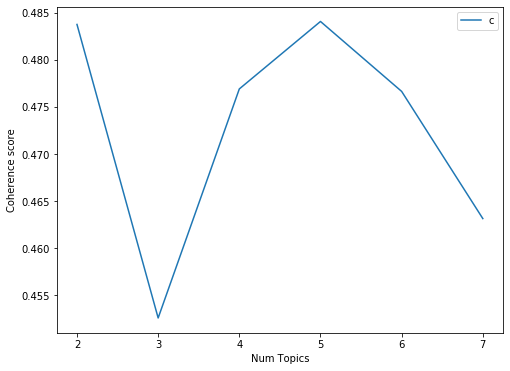

In [52]:
fig = plt.figure(figsize=(8,6))
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
fig.savefig('LDAMallet_coherence.png', dpi=300)

In [53]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4837
Num Topics = 3  has Coherence Value of 0.4526
Num Topics = 4  has Coherence Value of 0.4769
Num Topics = 5  has Coherence Value of 0.4841
Num Topics = 6  has Coherence Value of 0.4766
Num Topics = 7  has Coherence Value of 0.4631


In [55]:
model_list, coherence_values = compute_coherence_values(dictionary=common_dictionary, corpus=corpus, texts=all_reviews, start=2, limit=8, step=1)

2019-12-02 07:25:09,375 : INFO : using autotuned alpha, starting with [0.5, 0.5]
2019-12-02 07:25:09,377 : INFO : using symmetric eta at 0.5
2019-12-02 07:25:09,385 : INFO : using serial LDA version on this node
2019-12-02 07:25:09,399 : INFO : running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 1349 documents, updating model once every 100 documents, evaluating perplexity every 1000 documents, iterating 100x with a convergence threshold of 0.001000
2019-12-02 07:25:09,403 : INFO : PROGRESS: pass 0, at document #100/1349
2019-12-02 07:25:09,605 : INFO : optimized alpha [0.62644213, 0.6938468]
2019-12-02 07:25:09,611 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:09,617 : INFO : topic #0 (0.626): 0.005*"battle" + 0.005*"animation" + 0.005*"play" + 0.004*"feel" + 0.004*"look" + 0.004*"review" + 0.004*"area" + 0.004*"fan" + 0.004*"switch" + 0.004*"issue"
2019-12-02 07:25:09,619 : INFO : topic #1 (0.694): 0.

2019-12-02 07:25:11,147 : INFO : topic #0 (2.314): 0.007*"play" + 0.006*"feel" + 0.006*"battle" + 0.006*"area" + 0.005*"animation" + 0.005*"look" + 0.004*"thing" + 0.004*"graphic" + 0.003*"fan" + 0.003*"story"
2019-12-02 07:25:11,149 : INFO : topic #1 (2.838): 0.008*"animation" + 0.008*"cut" + 0.007*"time" + 0.005*"gamefreak" + 0.005*"graphic" + 0.005*"model" + 0.004*"story" + 0.004*"look" + 0.004*"content" + 0.004*"fan"
2019-12-02 07:25:11,151 : INFO : topic diff=0.429926, rho=0.301511
2019-12-02 07:25:11,156 : INFO : PROGRESS: pass 0, at document #1200/1349
2019-12-02 07:25:11,236 : INFO : optimized alpha [2.4858222, 3.1306467]
2019-12-02 07:25:11,242 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:11,248 : INFO : topic #0 (2.486): 0.007*"play" + 0.006*"battle" + 0.006*"feel" + 0.006*"area" + 0.005*"look" + 0.005*"animation" + 0.004*"thing" + 0.003*"graphic" + 0.003*"story" + 0.003*"fan"
2019-12-02 07:25:11,250 : INFO : topic #1 (3.131): 0.

2019-12-02 07:25:12,258 : INFO : topic #0 (1.292): 0.008*"feel" + 0.007*"area" + 0.007*"play" + 0.007*"battle" + 0.005*"look" + 0.004*"story" + 0.004*"animation" + 0.004*"design" + 0.004*"character" + 0.003*"thing"
2019-12-02 07:25:12,260 : INFO : topic #1 (1.837): 0.009*"cut" + 0.008*"animation" + 0.006*"time" + 0.005*"graphic" + 0.005*"gamefreak" + 0.005*"model" + 0.004*"fan" + 0.004*"story" + 0.004*"remove" + 0.004*"content"
2019-12-02 07:25:12,263 : INFO : topic diff=0.315994, rho=0.254082
2019-12-02 07:25:12,268 : INFO : PROGRESS: pass 1, at document #900/1349
2019-12-02 07:25:12,343 : INFO : optimized alpha [1.2386311, 1.8668897]
2019-12-02 07:25:12,348 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:12,354 : INFO : topic #0 (1.239): 0.007*"feel" + 0.007*"play" + 0.007*"battle" + 0.007*"area" + 0.005*"look" + 0.004*"animation" + 0.004*"story" + 0.004*"thing" + 0.003*"design" + 0.003*"character"
2019-12-02 07:25:12,356 : INFO : topic #1 

2019-12-02 07:25:13,428 : INFO : optimized alpha [0.71110946, 1.2120149]
2019-12-02 07:25:13,433 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:13,441 : INFO : topic #0 (0.711): 0.009*"feel" + 0.008*"battle" + 0.008*"area" + 0.006*"play" + 0.006*"story" + 0.005*"look" + 0.004*"character" + 0.004*"time" + 0.003*"gym" + 0.003*"design"
2019-12-02 07:25:13,443 : INFO : topic #1 (1.212): 0.008*"animation" + 0.008*"cut" + 0.006*"gamefreak" + 0.006*"graphic" + 0.005*"time" + 0.005*"fan" + 0.005*"model" + 0.004*"content" + 0.004*"switch" + 0.004*"look"
2019-12-02 07:25:13,444 : INFO : topic diff=0.319443, rho=0.246258
2019-12-02 07:25:13,449 : INFO : PROGRESS: pass 2, at document #600/1349
2019-12-02 07:25:13,510 : INFO : optimized alpha [0.6599114, 1.1715667]
2019-12-02 07:25:13,516 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:13,523 : INFO : topic #0 (0.660): 0.010*"feel" + 0.008*"area" + 0.008*"battl

2019-12-02 07:25:14,534 : INFO : topic diff=0.383471, rho=0.239114
2019-12-02 07:25:14,539 : INFO : PROGRESS: pass 3, at document #200/1349
2019-12-02 07:25:14,622 : INFO : optimized alpha [0.45149112, 0.8237538]
2019-12-02 07:25:14,628 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:14,636 : INFO : topic #0 (0.451): 0.009*"battle" + 0.008*"area" + 0.008*"feel" + 0.006*"story" + 0.005*"look" + 0.004*"design" + 0.004*"gym" + 0.004*"play" + 0.004*"character" + 0.004*"time"
2019-12-02 07:25:14,638 : INFO : topic #1 (0.824): 0.009*"animation" + 0.008*"cut" + 0.006*"fan" + 0.006*"gamefreak" + 0.006*"graphic" + 0.005*"model" + 0.005*"time" + 0.005*"switch" + 0.004*"content" + 0.004*"look"
2019-12-02 07:25:14,640 : INFO : topic diff=0.280839, rho=0.239114
2019-12-02 07:25:14,645 : INFO : PROGRESS: pass 3, at document #300/1349
2019-12-02 07:25:14,713 : INFO : optimized alpha [0.42129555, 0.858534]
2019-12-02 07:25:14,719 : INFO : merging changes fro

2019-12-02 07:25:15,687 : INFO : topic diff=0.272369, rho=0.239114
2019-12-02 07:25:15,692 : INFO : PROGRESS: pass 3, at document #1300/1349
2019-12-02 07:25:15,758 : INFO : optimized alpha [0.31128165, 0.69668716]
2019-12-02 07:25:15,764 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:15,771 : INFO : topic #0 (0.311): 0.008*"area" + 0.008*"battle" + 0.007*"feel" + 0.005*"story" + 0.005*"play" + 0.004*"time" + 0.004*"character" + 0.004*"look" + 0.004*"gym" + 0.004*"design"
2019-12-02 07:25:15,773 : INFO : topic #1 (0.697): 0.009*"animation" + 0.008*"cut" + 0.007*"graphic" + 0.006*"gamefreak" + 0.006*"fan" + 0.005*"switch" + 0.005*"time" + 0.005*"model" + 0.005*"look" + 0.004*"franchise"
2019-12-02 07:25:15,776 : INFO : topic diff=0.271117, rho=0.239114
2019-12-02 07:25:15,848 : INFO : -9.723 per-word bound, 844.9 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:25:15,849 : INFO : PROGRESS: pass 3, a

2019-12-02 07:25:16,643 : INFO : topic diff=0.258286, rho=0.232558
2019-12-02 07:25:16,783 : INFO : -9.793 per-word bound, 886.9 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:25:16,784 : INFO : PROGRESS: pass 4, at document #1000/1349
2019-12-02 07:25:16,851 : INFO : optimized alpha [0.21308349, 0.5948]
2019-12-02 07:25:16,856 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:16,862 : INFO : topic #0 (0.213): 0.009*"area" + 0.008*"battle" + 0.007*"feel" + 0.005*"story" + 0.005*"time" + 0.004*"design" + 0.004*"look" + 0.004*"play" + 0.004*"character" + 0.004*"gym"
2019-12-02 07:25:16,865 : INFO : topic #1 (0.595): 0.009*"animation" + 0.009*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.006*"fan" + 0.005*"time" + 0.005*"model" + 0.005*"switch" + 0.005*"franchise" + 0.005*"look"
2019-12-02 07:25:16,866 : INFO : topic diff=0.305603, rho=0.232558
2019-12-02 07:25:16,872 : INFO : PROGRESS: pass 4, at d

2019-12-02 07:25:17,736 : INFO : topic diff=0.232836, rho=0.226513
2019-12-02 07:25:17,741 : INFO : PROGRESS: pass 5, at document #700/1349
2019-12-02 07:25:17,803 : INFO : optimized alpha [0.18298967, 0.4767225]
2019-12-02 07:25:17,809 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:17,815 : INFO : topic #0 (0.183): 0.010*"feel" + 0.009*"area" + 0.008*"battle" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.005*"play" + 0.004*"design" + 0.004*"gym" + 0.003*"character"
2019-12-02 07:25:17,817 : INFO : topic #1 (0.477): 0.009*"animation" + 0.009*"cut" + 0.006*"graphic" + 0.006*"fan" + 0.006*"gamefreak" + 0.005*"time" + 0.005*"switch" + 0.004*"model" + 0.004*"look" + 0.004*"play"
2019-12-02 07:25:17,820 : INFO : topic diff=0.258617, rho=0.226513
2019-12-02 07:25:17,824 : INFO : PROGRESS: pass 5, at document #800/1349
2019-12-02 07:25:17,875 : INFO : optimized alpha [0.17344932, 0.47144076]
2019-12-02 07:25:17,880 : INFO : merging changes from

2019-12-02 07:25:18,794 : INFO : topic diff=0.205683, rho=0.220917
2019-12-02 07:25:18,798 : INFO : PROGRESS: pass 6, at document #400/1349
2019-12-02 07:25:18,849 : INFO : optimized alpha [0.1479825, 0.4372375]
2019-12-02 07:25:18,855 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:18,862 : INFO : topic #0 (0.148): 0.008*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.005*"look" + 0.004*"gym" + 0.004*"design" + 0.004*"character" + 0.004*"time" + 0.003*"play"
2019-12-02 07:25:18,864 : INFO : topic #1 (0.437): 0.009*"animation" + 0.008*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.006*"fan" + 0.005*"switch" + 0.005*"model" + 0.005*"look" + 0.005*"content" + 0.004*"time"
2019-12-02 07:25:18,866 : INFO : topic diff=0.164009, rho=0.220917
2019-12-02 07:25:18,871 : INFO : PROGRESS: pass 6, at document #500/1349
2019-12-02 07:25:18,935 : INFO : optimized alpha [0.14933527, 0.41475976]
2019-12-02 07:25:18,941 : INFO : merging changes fr

2019-12-02 07:25:19,846 : INFO : topic diff=0.254282, rho=0.220917
2019-12-02 07:25:19,852 : INFO : PROGRESS: pass 7, at document #100/1349
2019-12-02 07:25:19,917 : INFO : optimized alpha [0.13814403, 0.3349205]
2019-12-02 07:25:19,923 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:19,930 : INFO : topic #0 (0.138): 0.009*"area" + 0.008*"battle" + 0.008*"feel" + 0.006*"story" + 0.005*"look" + 0.005*"gym" + 0.005*"design" + 0.005*"time" + 0.004*"character" + 0.003*"play"
2019-12-02 07:25:19,932 : INFO : topic #1 (0.335): 0.008*"animation" + 0.007*"cut" + 0.006*"fan" + 0.006*"gamefreak" + 0.006*"graphic" + 0.005*"time" + 0.005*"switch" + 0.005*"look" + 0.005*"model" + 0.004*"content"
2019-12-02 07:25:19,934 : INFO : topic diff=0.336297, rho=0.215716
2019-12-02 07:25:19,940 : INFO : PROGRESS: pass 7, at document #200/1349
2019-12-02 07:25:19,994 : INFO : optimized alpha [0.13419314, 0.34453827]
2019-12-02 07:25:20,000 : INFO : merging changes f

2019-12-02 07:25:20,841 : INFO : topic diff=0.288856, rho=0.215716
2019-12-02 07:25:20,847 : INFO : PROGRESS: pass 7, at document #1200/1349
2019-12-02 07:25:20,912 : INFO : optimized alpha [0.12206668, 0.38487327]
2019-12-02 07:25:20,918 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:20,925 : INFO : topic #0 (0.122): 0.008*"area" + 0.008*"battle" + 0.007*"feel" + 0.005*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"character" + 0.004*"design" + 0.003*"gym"
2019-12-02 07:25:20,927 : INFO : topic #1 (0.385): 0.009*"animation" + 0.008*"cut" + 0.006*"graphic" + 0.006*"fan" + 0.006*"gamefreak" + 0.005*"time" + 0.005*"switch" + 0.005*"model" + 0.005*"look" + 0.004*"play"
2019-12-02 07:25:20,929 : INFO : topic diff=0.241335, rho=0.215716
2019-12-02 07:25:20,934 : INFO : PROGRESS: pass 7, at document #1300/1349
2019-12-02 07:25:20,991 : INFO : optimized alpha [0.12265456, 0.3393883]
2019-12-02 07:25:20,996 : INFO : merging changes fr

2019-12-02 07:25:21,780 : INFO : topic diff=0.232727, rho=0.210865
2019-12-02 07:25:21,787 : INFO : PROGRESS: pass 8, at document #900/1349
2019-12-02 07:25:21,845 : INFO : optimized alpha [0.11239301, 0.31715378]
2019-12-02 07:25:21,851 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:21,858 : INFO : topic #0 (0.112): 0.008*"area" + 0.008*"feel" + 0.007*"battle" + 0.005*"story" + 0.005*"look" + 0.005*"time" + 0.004*"play" + 0.004*"design" + 0.004*"gym" + 0.004*"character"
2019-12-02 07:25:21,860 : INFO : topic #1 (0.317): 0.009*"cut" + 0.009*"animation" + 0.007*"graphic" + 0.006*"gamefreak" + 0.006*"fan" + 0.005*"switch" + 0.005*"play" + 0.005*"model" + 0.005*"time" + 0.005*"look"
2019-12-02 07:25:21,861 : INFO : topic diff=0.229435, rho=0.210865
2019-12-02 07:25:21,985 : INFO : -9.748 per-word bound, 859.7 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:25:21,986 : INFO : PROGRESS: pass 8, at doc

2019-12-02 07:25:22,792 : INFO : topic diff=0.247236, rho=0.206328
2019-12-02 07:25:22,798 : INFO : PROGRESS: pass 9, at document #600/1349
2019-12-02 07:25:22,855 : INFO : optimized alpha [0.10279576, 0.2691906]
2019-12-02 07:25:22,861 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:22,868 : INFO : topic #0 (0.103): 0.009*"feel" + 0.008*"area" + 0.008*"battle" + 0.006*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"design" + 0.004*"gym" + 0.004*"character"
2019-12-02 07:25:22,870 : INFO : topic #1 (0.269): 0.008*"animation" + 0.008*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.005*"fan" + 0.005*"time" + 0.005*"switch" + 0.005*"model" + 0.004*"look" + 0.004*"play"
2019-12-02 07:25:22,871 : INFO : topic diff=0.206977, rho=0.206328
2019-12-02 07:25:22,877 : INFO : PROGRESS: pass 9, at document #700/1349
2019-12-02 07:25:22,931 : INFO : optimized alpha [0.10550141, 0.2674595]
2019-12-02 07:25:22,937 : INFO : merging changes from 

2019-12-02 07:25:23,839 : INFO : topic diff=0.228738, rho=0.202072
2019-12-02 07:25:23,845 : INFO : PROGRESS: pass 10, at document #300/1349
2019-12-02 07:25:23,895 : INFO : optimized alpha [0.09500358, 0.24135694]
2019-12-02 07:25:23,900 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:23,908 : INFO : topic #0 (0.095): 0.009*"battle" + 0.008*"feel" + 0.008*"area" + 0.006*"story" + 0.005*"look" + 0.004*"time" + 0.004*"gym" + 0.004*"design" + 0.004*"character" + 0.003*"animation"
2019-12-02 07:25:23,910 : INFO : topic #1 (0.241): 0.008*"animation" + 0.008*"cut" + 0.006*"graphic" + 0.006*"fan" + 0.006*"gamefreak" + 0.005*"switch" + 0.005*"time" + 0.005*"content" + 0.004*"model" + 0.004*"look"
2019-12-02 07:25:23,912 : INFO : topic diff=0.186628, rho=0.202072
2019-12-02 07:25:23,916 : INFO : PROGRESS: pass 10, at document #400/1349
2019-12-02 07:25:23,963 : INFO : optimized alpha [0.09308786, 0.25491968]
2019-12-02 07:25:23,968 : INFO : merging c

2019-12-02 07:25:24,783 : INFO : topic diff=0.225762, rho=0.202072
2019-12-02 07:25:24,855 : INFO : -9.567 per-word bound, 758.3 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:25:24,856 : INFO : PROGRESS: pass 10, at document #1349/1349
2019-12-02 07:25:24,882 : INFO : optimized alpha [0.0909559, 0.19570433]
2019-12-02 07:25:24,888 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:25:24,895 : INFO : topic #0 (0.091): 0.009*"area" + 0.008*"feel" + 0.007*"battle" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.005*"design" + 0.004*"gym" + 0.004*"character" + 0.004*"play"
2019-12-02 07:25:24,897 : INFO : topic #1 (0.196): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"fan" + 0.006*"gamefreak" + 0.005*"switch" + 0.005*"look" + 0.005*"play" + 0.004*"content" + 0.004*"time"
2019-12-02 07:25:24,898 : INFO : topic diff=0.228370, rho=0.202072
2019-12-02 07:25:24,903 : INFO : PROGRESS: pass 11, at d

2019-12-02 07:25:25,765 : INFO : topic diff=0.253755, rho=0.198068
2019-12-02 07:25:25,772 : INFO : PROGRESS: pass 11, at document #1100/1349
2019-12-02 07:25:25,837 : INFO : optimized alpha [0.08635577, 0.24491882]
2019-12-02 07:25:25,843 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:25,851 : INFO : topic #0 (0.086): 0.009*"area" + 0.008*"feel" + 0.008*"battle" + 0.005*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"design" + 0.004*"character" + 0.003*"gym"
2019-12-02 07:25:25,853 : INFO : topic #1 (0.245): 0.009*"animation" + 0.008*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.006*"fan" + 0.005*"time" + 0.005*"switch" + 0.005*"model" + 0.004*"look" + 0.004*"play"
2019-12-02 07:25:25,855 : INFO : topic diff=0.260401, rho=0.198068
2019-12-02 07:25:25,860 : INFO : PROGRESS: pass 11, at document #1200/1349
2019-12-02 07:25:25,917 : INFO : optimized alpha [0.0856601, 0.2512229]
2019-12-02 07:25:25,922 : INFO : merging changes f

2019-12-02 07:25:26,679 : INFO : topic diff=0.214264, rho=0.194294
2019-12-02 07:25:26,686 : INFO : PROGRESS: pass 12, at document #800/1349
2019-12-02 07:25:26,732 : INFO : optimized alpha [0.08218971, 0.20474905]
2019-12-02 07:25:26,737 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:26,745 : INFO : topic #0 (0.082): 0.008*"feel" + 0.008*"area" + 0.007*"battle" + 0.005*"story" + 0.005*"look" + 0.005*"time" + 0.004*"design" + 0.004*"play" + 0.004*"gym" + 0.004*"character"
2019-12-02 07:25:26,747 : INFO : topic #1 (0.205): 0.008*"cut" + 0.008*"animation" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.005*"switch" + 0.004*"time" + 0.004*"play" + 0.004*"model" + 0.004*"look"
2019-12-02 07:25:26,748 : INFO : topic diff=0.211628, rho=0.194294
2019-12-02 07:25:26,753 : INFO : PROGRESS: pass 12, at document #900/1349
2019-12-02 07:25:26,806 : INFO : optimized alpha [0.081136174, 0.21151985]
2019-12-02 07:25:26,811 : INFO : merging changes 

2019-12-02 07:25:27,659 : INFO : topic diff=0.142277, rho=0.190727
2019-12-02 07:25:27,664 : INFO : PROGRESS: pass 13, at document #500/1349
2019-12-02 07:25:27,714 : INFO : optimized alpha [0.07716468, 0.19396177]
2019-12-02 07:25:27,720 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:27,726 : INFO : topic #0 (0.077): 0.009*"feel" + 0.008*"area" + 0.008*"battle" + 0.007*"story" + 0.005*"look" + 0.005*"time" + 0.004*"play" + 0.004*"gym" + 0.004*"character" + 0.004*"design"
2019-12-02 07:25:27,728 : INFO : topic #1 (0.194): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.005*"fan" + 0.005*"switch" + 0.005*"model" + 0.005*"time" + 0.004*"look" + 0.004*"play"
2019-12-02 07:25:27,731 : INFO : topic diff=0.224628, rho=0.190727
2019-12-02 07:25:27,735 : INFO : PROGRESS: pass 13, at document #600/1349
2019-12-02 07:25:27,788 : INFO : optimized alpha [0.07747212, 0.19023454]
2019-12-02 07:25:27,793 : INFO : merging changes f

2019-12-02 07:25:28,670 : INFO : topic diff=0.283817, rho=0.187350
2019-12-02 07:25:28,676 : INFO : PROGRESS: pass 14, at document #200/1349
2019-12-02 07:25:28,724 : INFO : optimized alpha [0.074693136, 0.1698263]
2019-12-02 07:25:28,729 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:28,735 : INFO : topic #0 (0.075): 0.008*"area" + 0.008*"battle" + 0.008*"feel" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"gym" + 0.004*"design" + 0.004*"character" + 0.004*"animation"
2019-12-02 07:25:28,737 : INFO : topic #1 (0.170): 0.008*"animation" + 0.007*"cut" + 0.006*"fan" + 0.006*"graphic" + 0.006*"gamefreak" + 0.005*"switch" + 0.005*"time" + 0.005*"model" + 0.004*"play" + 0.004*"look"
2019-12-02 07:25:28,739 : INFO : topic diff=0.209343, rho=0.187350
2019-12-02 07:25:28,744 : INFO : PROGRESS: pass 14, at document #300/1349
2019-12-02 07:25:28,794 : INFO : optimized alpha [0.07369498, 0.177769]
2019-12-02 07:25:28,799 : INFO : merging change

2019-12-02 07:25:29,615 : INFO : topic diff=0.205627, rho=0.187350
2019-12-02 07:25:29,621 : INFO : PROGRESS: pass 14, at document #1300/1349
2019-12-02 07:25:29,679 : INFO : optimized alpha [0.07167499, 0.18174751]
2019-12-02 07:25:29,684 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:29,690 : INFO : topic #0 (0.072): 0.008*"area" + 0.008*"battle" + 0.007*"feel" + 0.005*"time" + 0.005*"story" + 0.004*"look" + 0.004*"character" + 0.004*"play" + 0.004*"gym" + 0.004*"design"
2019-12-02 07:25:29,693 : INFO : topic #1 (0.182): 0.009*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.006*"fan" + 0.005*"switch" + 0.005*"look" + 0.005*"time" + 0.004*"model" + 0.004*"play"
2019-12-02 07:25:29,694 : INFO : topic diff=0.207137, rho=0.187350
2019-12-02 07:25:29,762 : INFO : -9.513 per-word bound, 730.6 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:25:29,763 : INFO : PROGRESS: pass 14, at d

2019-12-02 07:25:30,481 : INFO : topic diff=0.195689, rho=0.184146
2019-12-02 07:25:30,606 : INFO : -9.691 per-word bound, 826.8 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:25:30,607 : INFO : PROGRESS: pass 15, at document #1000/1349
2019-12-02 07:25:30,664 : INFO : optimized alpha [0.06701624, 0.17248458]
2019-12-02 07:25:30,670 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:30,676 : INFO : topic #0 (0.067): 0.008*"area" + 0.007*"feel" + 0.007*"battle" + 0.005*"story" + 0.005*"time" + 0.005*"look" + 0.004*"design" + 0.004*"play" + 0.004*"gym" + 0.004*"character"
2019-12-02 07:25:30,679 : INFO : topic #1 (0.172): 0.009*"animation" + 0.008*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.006*"fan" + 0.005*"time" + 0.005*"switch" + 0.005*"model" + 0.004*"look" + 0.004*"franchise"
2019-12-02 07:25:30,681 : INFO : topic diff=0.233385, rho=0.184146
2019-12-02 07:25:30,685 : INFO : PROGRESS: pass 15

2019-12-02 07:25:31,447 : INFO : topic diff=0.176386, rho=0.181101
2019-12-02 07:25:31,453 : INFO : PROGRESS: pass 16, at document #700/1349
2019-12-02 07:25:31,511 : INFO : optimized alpha [0.06528231, 0.14811336]
2019-12-02 07:25:31,517 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:31,524 : INFO : topic #0 (0.065): 0.009*"feel" + 0.008*"area" + 0.007*"battle" + 0.006*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"design" + 0.004*"gym" + 0.003*"animation"
2019-12-02 07:25:31,526 : INFO : topic #1 (0.148): 0.008*"animation" + 0.008*"cut" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.005*"time" + 0.004*"switch" + 0.004*"look" + 0.004*"play" + 0.004*"model"
2019-12-02 07:25:31,528 : INFO : topic diff=0.196121, rho=0.181101
2019-12-02 07:25:31,533 : INFO : PROGRESS: pass 16, at document #800/1349
2019-12-02 07:25:31,582 : INFO : optimized alpha [0.06449274, 0.1516532]
2019-12-02 07:25:31,587 : INFO : merging changes fr

2019-12-02 07:25:32,433 : INFO : topic diff=0.162383, rho=0.178202
2019-12-02 07:25:32,438 : INFO : PROGRESS: pass 17, at document #400/1349
2019-12-02 07:25:32,484 : INFO : optimized alpha [0.06027783, 0.15200336]
2019-12-02 07:25:32,490 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:32,497 : INFO : topic #0 (0.060): 0.008*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.005*"look" + 0.004*"time" + 0.004*"gym" + 0.004*"design" + 0.004*"character" + 0.003*"animation"
2019-12-02 07:25:32,499 : INFO : topic #1 (0.152): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.005*"fan" + 0.005*"switch" + 0.005*"look" + 0.004*"model" + 0.004*"content" + 0.004*"time"
2019-12-02 07:25:32,501 : INFO : topic diff=0.133049, rho=0.178202
2019-12-02 07:25:32,506 : INFO : PROGRESS: pass 17, at document #500/1349
2019-12-02 07:25:32,554 : INFO : optimized alpha [0.060686897, 0.14654985]
2019-12-02 07:25:32,559 : INFO : merging 

2019-12-02 07:25:33,397 : INFO : topic diff=0.198050, rho=0.178202
2019-12-02 07:25:33,402 : INFO : PROGRESS: pass 18, at document #100/1349
2019-12-02 07:25:33,467 : INFO : optimized alpha [0.060745463, 0.12923563]
2019-12-02 07:25:33,472 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:33,479 : INFO : topic #0 (0.061): 0.008*"area" + 0.008*"feel" + 0.007*"battle" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"design" + 0.004*"gym" + 0.004*"play" + 0.004*"character"
2019-12-02 07:25:33,481 : INFO : topic #1 (0.129): 0.008*"animation" + 0.007*"cut" + 0.006*"fan" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"time" + 0.005*"switch" + 0.004*"look" + 0.004*"play" + 0.004*"model"
2019-12-02 07:25:33,483 : INFO : topic diff=0.261790, rho=0.175439
2019-12-02 07:25:33,488 : INFO : PROGRESS: pass 18, at document #200/1349
2019-12-02 07:25:33,537 : INFO : optimized alpha [0.05981805, 0.1334779]
2019-12-02 07:25:33,542 : INFO : merging changes f

2019-12-02 07:25:34,320 : INFO : topic diff=0.223886, rho=0.175439
2019-12-02 07:25:34,326 : INFO : PROGRESS: pass 18, at document #1200/1349
2019-12-02 07:25:34,376 : INFO : optimized alpha [0.057779465, 0.15398388]
2019-12-02 07:25:34,382 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:34,388 : INFO : topic #0 (0.058): 0.008*"area" + 0.007*"feel" + 0.007*"battle" + 0.005*"time" + 0.005*"look" + 0.005*"story" + 0.004*"play" + 0.004*"character" + 0.004*"design" + 0.003*"animation"
2019-12-02 07:25:34,389 : INFO : topic #1 (0.154): 0.009*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"fan" + 0.006*"gamefreak" + 0.005*"time" + 0.005*"switch" + 0.005*"look" + 0.005*"model" + 0.004*"play"
2019-12-02 07:25:34,391 : INFO : topic diff=0.189939, rho=0.175439
2019-12-02 07:25:34,395 : INFO : PROGRESS: pass 18, at document #1300/1349
2019-12-02 07:25:34,445 : INFO : optimized alpha [0.058333606, 0.14295135]
2019-12-02 07:25:34,450 : INFO : merging

2019-12-02 07:25:35,165 : INFO : topic diff=0.183450, rho=0.172799
2019-12-02 07:25:35,169 : INFO : PROGRESS: pass 19, at document #900/1349
2019-12-02 07:25:35,222 : INFO : optimized alpha [0.056097336, 0.13716753]
2019-12-02 07:25:35,227 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:35,234 : INFO : topic #0 (0.056): 0.008*"area" + 0.008*"feel" + 0.007*"battle" + 0.005*"look" + 0.005*"story" + 0.005*"time" + 0.004*"play" + 0.004*"design" + 0.004*"animation" + 0.004*"gym"
2019-12-02 07:25:35,236 : INFO : topic #1 (0.137): 0.008*"cut" + 0.008*"animation" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.005*"switch" + 0.005*"play" + 0.004*"model" + 0.004*"time" + 0.004*"look"
2019-12-02 07:25:35,239 : INFO : topic diff=0.181653, rho=0.172799
2019-12-02 07:25:35,348 : INFO : -9.664 per-word bound, 811.4 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:25:35,349 : INFO : PROGRESS: pass 19, at 

2019-12-02 07:25:36,188 : INFO : topic #1 (0.130): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.005*"fan" + 0.005*"time" + 0.005*"switch" + 0.004*"model" + 0.004*"look" + 0.004*"play"
2019-12-02 07:25:36,190 : INFO : topic diff=0.194660, rho=0.170276
2019-12-02 07:25:36,195 : INFO : PROGRESS: pass 20, at document #600/1349
2019-12-02 07:25:36,249 : INFO : optimized alpha [0.05390665, 0.12610787]
2019-12-02 07:25:36,255 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:36,261 : INFO : topic #0 (0.054): 0.009*"feel" + 0.008*"area" + 0.007*"battle" + 0.006*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"design" + 0.004*"animation" + 0.003*"gym"
2019-12-02 07:25:36,263 : INFO : topic #1 (0.126): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.005*"time" + 0.004*"look" + 0.004*"switch" + 0.004*"model" + 0.004*"play"
2019-12-02 07:25:36,264 : INFO : topic diff=0.163803

2019-12-02 07:25:37,185 : INFO : topic #0 (0.054): 0.008*"area" + 0.008*"battle" + 0.007*"feel" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"design" + 0.004*"gym" + 0.004*"animation" + 0.004*"character"
2019-12-02 07:25:37,188 : INFO : topic #1 (0.120): 0.008*"animation" + 0.007*"cut" + 0.006*"fan" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"switch" + 0.005*"time" + 0.004*"play" + 0.004*"model" + 0.004*"look"
2019-12-02 07:25:37,190 : INFO : topic diff=0.183147, rho=0.167860
2019-12-02 07:25:37,197 : INFO : PROGRESS: pass 21, at document #300/1349
2019-12-02 07:25:37,242 : INFO : optimized alpha [0.053002816, 0.12345761]
2019-12-02 07:25:37,248 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:37,255 : INFO : topic #0 (0.053): 0.008*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"design" + 0.004*"gym" + 0.004*"animation" + 0.004*"character"
2019-12-02 07:25:37,257 : INFO : topic #1 (0.1

2019-12-02 07:25:38,075 : INFO : topic #0 (0.052): 0.008*"area" + 0.007*"battle" + 0.007*"feel" + 0.005*"time" + 0.005*"story" + 0.004*"look" + 0.004*"play" + 0.004*"character" + 0.004*"gym" + 0.004*"design"
2019-12-02 07:25:38,077 : INFO : topic #1 (0.124): 0.009*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.006*"fan" + 0.005*"switch" + 0.005*"look" + 0.005*"time" + 0.004*"play" + 0.004*"model"
2019-12-02 07:25:38,079 : INFO : topic diff=0.182739, rho=0.167860
2019-12-02 07:25:38,152 : INFO : -9.442 per-word bound, 695.7 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:25:38,153 : INFO : PROGRESS: pass 21, at document #1349/1349
2019-12-02 07:25:38,178 : INFO : optimized alpha [0.052512005, 0.1067983]
2019-12-02 07:25:38,184 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:25:38,191 : INFO : topic #0 (0.053): 0.008*"feel" + 0.008*"area" + 0.007*"battle" + 0.006*"story" + 0.005*"loo

2019-12-02 07:25:39,036 : INFO : optimized alpha [0.0497897, 0.12106171]
2019-12-02 07:25:39,041 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:39,047 : INFO : topic #0 (0.050): 0.008*"area" + 0.007*"feel" + 0.007*"battle" + 0.005*"story" + 0.005*"time" + 0.005*"look" + 0.004*"design" + 0.004*"play" + 0.004*"animation" + 0.004*"character"
2019-12-02 07:25:39,049 : INFO : topic #1 (0.121): 0.009*"animation" + 0.008*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.006*"fan" + 0.005*"time" + 0.005*"switch" + 0.004*"model" + 0.004*"look" + 0.004*"play"
2019-12-02 07:25:39,051 : INFO : topic diff=0.205900, rho=0.165544
2019-12-02 07:25:39,057 : INFO : PROGRESS: pass 22, at document #1100/1349
2019-12-02 07:25:39,114 : INFO : optimized alpha [0.05013231, 0.12418479]
2019-12-02 07:25:39,120 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:39,127 : INFO : topic #0 (0.050): 0.008*"area" + 0.007*"feel" + 0.007

2019-12-02 07:25:39,805 : INFO : PROGRESS: pass 23, at document #700/1349
2019-12-02 07:25:39,859 : INFO : optimized alpha [0.049462125, 0.10966491]
2019-12-02 07:25:39,864 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:39,872 : INFO : topic #0 (0.049): 0.009*"feel" + 0.008*"area" + 0.007*"battle" + 0.006*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"design" + 0.004*"animation" + 0.003*"gym"
2019-12-02 07:25:39,874 : INFO : topic #1 (0.110): 0.008*"animation" + 0.008*"cut" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.004*"time" + 0.004*"play" + 0.004*"look" + 0.004*"switch" + 0.004*"model"
2019-12-02 07:25:39,876 : INFO : topic diff=0.172666, rho=0.163321
2019-12-02 07:25:39,882 : INFO : PROGRESS: pass 23, at document #800/1349
2019-12-02 07:25:39,930 : INFO : optimized alpha [0.049124777, 0.11253687]
2019-12-02 07:25:39,936 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25

2019-12-02 07:25:40,766 : INFO : topic diff=0.145120, rho=0.161186
2019-12-02 07:25:40,770 : INFO : PROGRESS: pass 24, at document #400/1349
2019-12-02 07:25:40,810 : INFO : optimized alpha [0.04666213, 0.11323082]
2019-12-02 07:25:40,817 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:40,825 : INFO : topic #0 (0.047): 0.008*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.005*"look" + 0.004*"time" + 0.004*"animation" + 0.004*"design" + 0.004*"gym" + 0.004*"character"
2019-12-02 07:25:40,827 : INFO : topic #1 (0.113): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.005*"fan" + 0.005*"switch" + 0.004*"look" + 0.004*"model" + 0.004*"time" + 0.004*"content"
2019-12-02 07:25:40,829 : INFO : topic diff=0.120506, rho=0.161186
2019-12-02 07:25:40,835 : INFO : PROGRESS: pass 24, at document #500/1349
2019-12-02 07:25:40,882 : INFO : optimized alpha [0.046771213, 0.109423935]
2019-12-02 07:25:40,887 : INFO : merging

2019-12-02 07:25:41,696 : INFO : topic #1 (0.095): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"fan" + 0.005*"gamefreak" + 0.005*"switch" + 0.005*"look" + 0.005*"play" + 0.004*"time" + 0.004*"content"
2019-12-02 07:25:41,699 : INFO : topic diff=0.176779, rho=0.161186
2019-12-02 07:25:41,705 : INFO : PROGRESS: pass 25, at document #100/1349
2019-12-02 07:25:41,766 : INFO : optimized alpha [0.047324736, 0.09824576]
2019-12-02 07:25:41,771 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:41,778 : INFO : topic #0 (0.047): 0.008*"area" + 0.007*"feel" + 0.007*"battle" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"design" + 0.004*"gym" + 0.004*"animation" + 0.004*"play"
2019-12-02 07:25:41,780 : INFO : topic #1 (0.098): 0.008*"animation" + 0.007*"cut" + 0.006*"fan" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"time" + 0.005*"switch" + 0.004*"play" + 0.004*"look" + 0.004*"model"
2019-12-02 07:25:41,782 : INFO : topic diff=0.232

2019-12-02 07:25:42,647 : INFO : topic #1 (0.110): 0.009*"animation" + 0.008*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.006*"fan" + 0.005*"time" + 0.005*"switch" + 0.004*"play" + 0.004*"look" + 0.004*"model"
2019-12-02 07:25:42,649 : INFO : topic diff=0.199115, rho=0.159132
2019-12-02 07:25:42,654 : INFO : PROGRESS: pass 25, at document #1200/1349
2019-12-02 07:25:42,706 : INFO : optimized alpha [0.04529723, 0.11396159]
2019-12-02 07:25:42,712 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:42,718 : INFO : topic #0 (0.045): 0.008*"area" + 0.007*"feel" + 0.007*"battle" + 0.005*"time" + 0.005*"look" + 0.005*"story" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.004*"character"
2019-12-02 07:25:42,720 : INFO : topic #1 (0.114): 0.009*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"fan" + 0.006*"gamefreak" + 0.005*"time" + 0.005*"switch" + 0.005*"look" + 0.004*"model" + 0.004*"play"
2019-12-02 07:25:42,722 : INFO : topic diff=0

2019-12-02 07:25:43,466 : INFO : topic #1 (0.100): 0.008*"cut" + 0.008*"animation" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.004*"play" + 0.004*"time" + 0.004*"switch" + 0.004*"model" + 0.004*"look"
2019-12-02 07:25:43,468 : INFO : topic diff=0.163086, rho=0.157154
2019-12-02 07:25:43,473 : INFO : PROGRESS: pass 26, at document #900/1349
2019-12-02 07:25:43,528 : INFO : optimized alpha [0.04415822, 0.10151493]
2019-12-02 07:25:43,533 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:43,540 : INFO : topic #0 (0.044): 0.007*"feel" + 0.007*"area" + 0.007*"battle" + 0.005*"look" + 0.005*"story" + 0.005*"time" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.003*"gym"
2019-12-02 07:25:43,542 : INFO : topic #1 (0.102): 0.008*"cut" + 0.008*"animation" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.005*"switch" + 0.005*"play" + 0.004*"time" + 0.004*"model" + 0.004*"look"
2019-12-02 07:25:43,545 : INFO : topic diff=0.162818

2019-12-02 07:25:44,407 : INFO : topic #0 (0.043): 0.008*"feel" + 0.007*"battle" + 0.007*"area" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.004*"gym"
2019-12-02 07:25:44,409 : INFO : topic #1 (0.099): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.005*"fan" + 0.005*"time" + 0.004*"switch" + 0.004*"model" + 0.004*"play" + 0.004*"look"
2019-12-02 07:25:44,411 : INFO : topic diff=0.174604, rho=0.155249
2019-12-02 07:25:44,416 : INFO : PROGRESS: pass 27, at document #600/1349
2019-12-02 07:25:44,466 : INFO : optimized alpha [0.042937428, 0.09651486]
2019-12-02 07:25:44,472 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:44,479 : INFO : topic #0 (0.043): 0.008*"feel" + 0.008*"area" + 0.007*"battle" + 0.006*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.003*"gym"
2019-12-02 07:25:44,481 : INFO : topic #1 (0.097): 0.008

2019-12-02 07:25:45,375 : INFO : optimized alpha [0.04297645, 0.09278878]
2019-12-02 07:25:45,380 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:45,387 : INFO : topic #0 (0.043): 0.008*"area" + 0.008*"battle" + 0.007*"feel" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"animation" + 0.004*"design" + 0.004*"gym" + 0.004*"character"
2019-12-02 07:25:45,389 : INFO : topic #1 (0.093): 0.008*"animation" + 0.007*"cut" + 0.006*"fan" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"time" + 0.004*"switch" + 0.004*"play" + 0.004*"model" + 0.004*"look"
2019-12-02 07:25:45,391 : INFO : topic diff=0.163976, rho=0.153411
2019-12-02 07:25:45,396 : INFO : PROGRESS: pass 28, at document #300/1349
2019-12-02 07:25:45,443 : INFO : optimized alpha [0.042377334, 0.09594724]
2019-12-02 07:25:45,449 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:45,455 : INFO : topic #0 (0.042): 0.008*"feel" + 0.008*"battle" + 0.0

2019-12-02 07:25:46,256 : INFO : PROGRESS: pass 28, at document #1300/1349
2019-12-02 07:25:46,309 : INFO : optimized alpha [0.04208515, 0.09695017]
2019-12-02 07:25:46,314 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:46,320 : INFO : topic #0 (0.042): 0.008*"area" + 0.007*"feel" + 0.007*"battle" + 0.005*"time" + 0.005*"story" + 0.005*"look" + 0.004*"play" + 0.004*"character" + 0.004*"gym" + 0.004*"design"
2019-12-02 07:25:46,322 : INFO : topic #1 (0.097): 0.009*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"fan" + 0.006*"gamefreak" + 0.005*"switch" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"model"
2019-12-02 07:25:46,323 : INFO : topic diff=0.165383, rho=0.153411
2019-12-02 07:25:46,382 : INFO : -9.389 per-word bound, 670.5 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:25:46,384 : INFO : PROGRESS: pass 28, at document #1349/1349
2019-12-02 07:25:46,408 : INFO : optimized alpha

2019-12-02 07:25:47,182 : INFO : -9.611 per-word bound, 781.7 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:25:47,183 : INFO : PROGRESS: pass 29, at document #1000/1349
2019-12-02 07:25:47,234 : INFO : optimized alpha [0.040817466, 0.0958129]
2019-12-02 07:25:47,240 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:47,247 : INFO : topic #0 (0.041): 0.008*"area" + 0.007*"feel" + 0.007*"battle" + 0.005*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"design" + 0.004*"animation" + 0.003*"character"
2019-12-02 07:25:47,249 : INFO : topic #1 (0.096): 0.008*"animation" + 0.008*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.005*"fan" + 0.005*"time" + 0.005*"switch" + 0.004*"model" + 0.004*"look" + 0.004*"play"
2019-12-02 07:25:47,251 : INFO : topic diff=0.185909, rho=0.151637
2019-12-02 07:25:47,255 : INFO : PROGRESS: pass 29, at document #1100/1349
2019-12-02 07:25:47,310 : INFO : optimize

2019-12-02 07:25:47,992 : INFO : topic diff=0.141341, rho=0.149923
2019-12-02 07:25:47,997 : INFO : PROGRESS: pass 30, at document #700/1349
2019-12-02 07:25:48,054 : INFO : optimized alpha [0.040491622, 0.08739705]
2019-12-02 07:25:48,059 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:48,067 : INFO : topic #0 (0.040): 0.009*"feel" + 0.008*"area" + 0.007*"battle" + 0.006*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.003*"gym"
2019-12-02 07:25:48,069 : INFO : topic #1 (0.087): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.004*"time" + 0.004*"look" + 0.004*"play" + 0.004*"switch" + 0.004*"model"
2019-12-02 07:25:48,071 : INFO : topic diff=0.154920, rho=0.149923
2019-12-02 07:25:48,077 : INFO : PROGRESS: pass 30, at document #800/1349
2019-12-02 07:25:48,128 : INFO : optimized alpha [0.04039492, 0.08945163]
2019-12-02 07:25:48,133 : INFO : merging changes 

2019-12-02 07:25:48,974 : INFO : topic #1 (0.087): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.005*"fan" + 0.005*"gamefreak" + 0.005*"time" + 0.005*"switch" + 0.004*"look" + 0.004*"play" + 0.004*"content"
2019-12-02 07:25:48,975 : INFO : topic diff=0.132370, rho=0.148266
2019-12-02 07:25:48,979 : INFO : PROGRESS: pass 31, at document #400/1349
2019-12-02 07:25:49,029 : INFO : optimized alpha [0.03838091, 0.089620225]
2019-12-02 07:25:49,034 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:49,041 : INFO : topic #0 (0.038): 0.008*"feel" + 0.007*"battle" + 0.007*"area" + 0.006*"story" + 0.005*"look" + 0.004*"time" + 0.004*"animation" + 0.004*"design" + 0.004*"gym" + 0.003*"character"
2019-12-02 07:25:49,043 : INFO : topic #1 (0.090): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.005*"switch" + 0.004*"look" + 0.004*"time" + 0.004*"model" + 0.004*"content"
2019-12-02 07:25:49,044 : INFO : topic di

2019-12-02 07:25:49,915 : INFO : topic #0 (0.039): 0.008*"feel" + 0.008*"area" + 0.007*"battle" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"design" + 0.004*"play" + 0.004*"animation" + 0.004*"gym"
2019-12-02 07:25:49,917 : INFO : topic #1 (0.078): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"fan" + 0.005*"gamefreak" + 0.005*"look" + 0.004*"play" + 0.004*"switch" + 0.004*"time" + 0.004*"content"
2019-12-02 07:25:49,919 : INFO : topic diff=0.161314, rho=0.148266
2019-12-02 07:25:49,925 : INFO : PROGRESS: pass 32, at document #100/1349
2019-12-02 07:25:49,991 : INFO : optimized alpha [0.038811713, 0.07914597]
2019-12-02 07:25:49,996 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:50,004 : INFO : topic #0 (0.039): 0.008*"area" + 0.007*"feel" + 0.007*"battle" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"design" + 0.004*"gym" + 0.004*"animation" + 0.004*"play"
2019-12-02 07:25:50,006 : INFO : topic #1 (0.079): 0.0

2019-12-02 07:25:50,828 : INFO : topic #0 (0.037): 0.008*"area" + 0.007*"feel" + 0.007*"battle" + 0.005*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.003*"character"
2019-12-02 07:25:50,830 : INFO : topic #1 (0.086): 0.009*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.006*"fan" + 0.005*"time" + 0.004*"switch" + 0.004*"play" + 0.004*"look" + 0.004*"model"
2019-12-02 07:25:50,832 : INFO : topic diff=0.180894, rho=0.146663
2019-12-02 07:25:50,838 : INFO : PROGRESS: pass 32, at document #1200/1349
2019-12-02 07:25:50,894 : INFO : optimized alpha [0.037222542, 0.08884758]
2019-12-02 07:25:50,900 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:50,907 : INFO : topic #0 (0.037): 0.007*"area" + 0.007*"feel" + 0.007*"battle" + 0.005*"time" + 0.005*"look" + 0.005*"story" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.003*"character"
2019-12-02 07:25:50,909 : INFO : topic #1 (

2019-12-02 07:25:51,644 : INFO : topic #0 (0.037): 0.008*"feel" + 0.007*"area" + 0.007*"battle" + 0.005*"story" + 0.005*"look" + 0.005*"time" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.004*"gym"
2019-12-02 07:25:51,646 : INFO : topic #1 (0.080): 0.008*"animation" + 0.008*"cut" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.004*"time" + 0.004*"play" + 0.004*"switch" + 0.004*"model" + 0.004*"look"
2019-12-02 07:25:51,647 : INFO : topic diff=0.147229, rho=0.145111
2019-12-02 07:25:51,652 : INFO : PROGRESS: pass 33, at document #900/1349
2019-12-02 07:25:51,700 : INFO : optimized alpha [0.03640109, 0.08128817]
2019-12-02 07:25:51,706 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:51,713 : INFO : topic #0 (0.036): 0.007*"feel" + 0.007*"area" + 0.007*"battle" + 0.005*"look" + 0.005*"story" + 0.005*"time" + 0.004*"animation" + 0.004*"play" + 0.004*"design" + 0.003*"gym"
2019-12-02 07:25:51,715 : INFO : topic #1 (0.081): 0.008*

2019-12-02 07:25:52,568 : INFO : optimized alpha [0.035134766, 0.07897217]
2019-12-02 07:25:52,573 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:52,580 : INFO : topic #0 (0.035): 0.008*"feel" + 0.007*"battle" + 0.007*"area" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.003*"gym"
2019-12-02 07:25:52,582 : INFO : topic #1 (0.079): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.005*"fan" + 0.005*"time" + 0.004*"switch" + 0.004*"look" + 0.004*"model" + 0.004*"play"
2019-12-02 07:25:52,584 : INFO : topic diff=0.160246, rho=0.143606
2019-12-02 07:25:52,589 : INFO : PROGRESS: pass 34, at document #600/1349
2019-12-02 07:25:52,634 : INFO : optimized alpha [0.035147812, 0.07711952]
2019-12-02 07:25:52,640 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:52,646 : INFO : topic #0 (0.035): 0.008*"feel" + 0.007*"area" + 0.007*"ba

2019-12-02 07:25:53,460 : INFO : topic diff=0.203984, rho=0.142148
2019-12-02 07:25:53,467 : INFO : PROGRESS: pass 35, at document #200/1349
2019-12-02 07:25:53,513 : INFO : optimized alpha [0.03509332, 0.073834054]
2019-12-02 07:25:53,519 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:53,525 : INFO : topic #0 (0.035): 0.007*"area" + 0.007*"battle" + 0.007*"feel" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"animation" + 0.004*"design" + 0.004*"gym" + 0.004*"character"
2019-12-02 07:25:53,527 : INFO : topic #1 (0.074): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"fan" + 0.005*"gamefreak" + 0.005*"time" + 0.004*"switch" + 0.004*"play" + 0.004*"look" + 0.004*"model"
2019-12-02 07:25:53,529 : INFO : topic diff=0.149515, rho=0.142148
2019-12-02 07:25:53,534 : INFO : PROGRESS: pass 35, at document #300/1349
2019-12-02 07:25:53,573 : INFO : optimized alpha [0.03460739, 0.07593918]
2019-12-02 07:25:53,579 : INFO : merging cha

2019-12-02 07:25:54,337 : INFO : topic diff=0.145915, rho=0.142148
2019-12-02 07:25:54,343 : INFO : PROGRESS: pass 35, at document #1300/1349
2019-12-02 07:25:54,387 : INFO : optimized alpha [0.034365743, 0.07595897]
2019-12-02 07:25:54,392 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:54,398 : INFO : topic #0 (0.034): 0.007*"area" + 0.007*"feel" + 0.007*"battle" + 0.005*"time" + 0.005*"story" + 0.005*"look" + 0.004*"play" + 0.004*"character" + 0.004*"animation" + 0.004*"gym"
2019-12-02 07:25:54,400 : INFO : topic #1 (0.076): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.005*"switch" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"model"
2019-12-02 07:25:54,402 : INFO : topic diff=0.152147, rho=0.142148
2019-12-02 07:25:54,464 : INFO : -9.351 per-word bound, 653.1 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:25:54,465 : INFO : PROGRESS: pass 35, 

2019-12-02 07:25:55,127 : INFO : topic diff=0.143862, rho=0.140733
2019-12-02 07:25:55,244 : INFO : -9.581 per-word bound, 765.9 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:25:55,245 : INFO : PROGRESS: pass 36, at document #1000/1349
2019-12-02 07:25:55,297 : INFO : optimized alpha [0.03329087, 0.074835375]
2019-12-02 07:25:55,303 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:55,309 : INFO : topic #0 (0.033): 0.008*"area" + 0.007*"feel" + 0.007*"battle" + 0.005*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.003*"character"
2019-12-02 07:25:55,311 : INFO : topic #1 (0.075): 0.008*"animation" + 0.008*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.005*"fan" + 0.005*"time" + 0.004*"switch" + 0.004*"model" + 0.004*"look" + 0.004*"play"
2019-12-02 07:25:55,312 : INFO : topic diff=0.170241, rho=0.140733
2019-12-02 07:25:55,317 : INFO : PROGRESS: pass 

2019-12-02 07:25:56,064 : INFO : topic #1 (0.071): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.005*"time" + 0.004*"look" + 0.004*"play" + 0.004*"switch" + 0.004*"model"
2019-12-02 07:25:56,065 : INFO : topic diff=0.130262, rho=0.139360
2019-12-02 07:25:56,070 : INFO : PROGRESS: pass 37, at document #700/1349
2019-12-02 07:25:56,121 : INFO : optimized alpha [0.033112522, 0.07017336]
2019-12-02 07:25:56,126 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:56,133 : INFO : topic #0 (0.033): 0.008*"feel" + 0.008*"area" + 0.007*"battle" + 0.006*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.003*"gym"
2019-12-02 07:25:56,135 : INFO : topic #1 (0.070): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.004*"time" + 0.004*"look" + 0.004*"play" + 0.004*"switch" + 0.004*"model"
2019-12-02 07:25:56,136 : INFO : topic diff=0.14051

2019-12-02 07:25:57,025 : INFO : topic #0 (0.032): 0.008*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"animation" + 0.004*"design" + 0.004*"gym" + 0.004*"character"
2019-12-02 07:25:57,027 : INFO : topic #1 (0.069): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.005*"fan" + 0.005*"gamefreak" + 0.005*"time" + 0.004*"switch" + 0.004*"look" + 0.004*"play" + 0.004*"content"
2019-12-02 07:25:57,029 : INFO : topic diff=0.122672, rho=0.138026
2019-12-02 07:25:57,035 : INFO : PROGRESS: pass 38, at document #400/1349
2019-12-02 07:25:57,074 : INFO : optimized alpha [0.031416245, 0.070996486]
2019-12-02 07:25:57,080 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:57,087 : INFO : topic #0 (0.031): 0.008*"feel" + 0.007*"battle" + 0.007*"area" + 0.006*"story" + 0.005*"look" + 0.004*"time" + 0.004*"animation" + 0.004*"design" + 0.004*"gym" + 0.003*"play"
2019-12-02 07:25:57,089 : INFO : topic #1 (0.071

2019-12-02 07:25:57,981 : INFO : optimized alpha [0.031773113, 0.06251718]
2019-12-02 07:25:57,987 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:25:57,994 : INFO : topic #0 (0.032): 0.008*"feel" + 0.008*"area" + 0.007*"battle" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"design" + 0.004*"animation" + 0.004*"play" + 0.004*"gym"
2019-12-02 07:25:57,996 : INFO : topic #1 (0.063): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"fan" + 0.005*"gamefreak" + 0.004*"look" + 0.004*"play" + 0.004*"switch" + 0.004*"time" + 0.004*"content"
2019-12-02 07:25:57,997 : INFO : topic diff=0.149359, rho=0.138026
2019-12-02 07:25:58,001 : INFO : PROGRESS: pass 39, at document #100/1349
2019-12-02 07:25:58,072 : INFO : optimized alpha [0.031616837, 0.0628251]
2019-12-02 07:25:58,078 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:58,086 : INFO : topic #0 (0.032): 0.007*"area" + 0.007*"feel" + 0.007*"ba

2019-12-02 07:25:58,897 : INFO : optimized alpha [0.030413643, 0.068066366]
2019-12-02 07:25:58,902 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:58,909 : INFO : topic #0 (0.030): 0.008*"area" + 0.007*"feel" + 0.007*"battle" + 0.005*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.003*"character"
2019-12-02 07:25:58,912 : INFO : topic #1 (0.068): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.005*"fan" + 0.005*"time" + 0.004*"switch" + 0.004*"play" + 0.004*"look" + 0.004*"model"
2019-12-02 07:25:58,914 : INFO : topic diff=0.166895, rho=0.136730
2019-12-02 07:25:58,919 : INFO : PROGRESS: pass 39, at document #1200/1349
2019-12-02 07:25:58,995 : INFO : optimized alpha [0.030357432, 0.06909946]
2019-12-02 07:25:59,001 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:59,009 : INFO : topic #0 (0.030): 0.007*"area" + 0.007*"feel" + 0

2019-12-02 07:25:59,693 : INFO : PROGRESS: pass 40, at document #800/1349
2019-12-02 07:25:59,742 : INFO : optimized alpha [0.030049969, 0.06340542]
2019-12-02 07:25:59,748 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:25:59,755 : INFO : topic #0 (0.030): 0.008*"feel" + 0.007*"area" + 0.007*"battle" + 0.005*"story" + 0.005*"look" + 0.005*"time" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.004*"gym"
2019-12-02 07:25:59,757 : INFO : topic #1 (0.063): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.004*"time" + 0.004*"play" + 0.004*"switch" + 0.004*"model" + 0.004*"look"
2019-12-02 07:25:59,759 : INFO : topic diff=0.135659, rho=0.135470
2019-12-02 07:25:59,765 : INFO : PROGRESS: pass 40, at document #900/1349
2019-12-02 07:25:59,814 : INFO : optimized alpha [0.029757371, 0.063980244]
2019-12-02 07:25:59,819 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:2

2019-12-02 07:26:00,646 : INFO : topic diff=0.100228, rho=0.134243
2019-12-02 07:26:00,651 : INFO : PROGRESS: pass 41, at document #500/1349
2019-12-02 07:26:00,692 : INFO : optimized alpha [0.028751567, 0.06231114]
2019-12-02 07:26:00,698 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:00,706 : INFO : topic #0 (0.029): 0.008*"feel" + 0.007*"battle" + 0.007*"area" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"play" + 0.004*"animation" + 0.003*"design" + 0.003*"gym"
2019-12-02 07:26:00,708 : INFO : topic #1 (0.062): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.005*"fan" + 0.004*"time" + 0.004*"switch" + 0.004*"look" + 0.004*"play" + 0.004*"model"
2019-12-02 07:26:00,709 : INFO : topic diff=0.148992, rho=0.134243
2019-12-02 07:26:00,714 : INFO : PROGRESS: pass 41, at document #600/1349
2019-12-02 07:26:00,760 : INFO : optimized alpha [0.028821142, 0.061298262]
2019-12-02 07:26:00,766 : INFO : merging change

2019-12-02 07:26:01,581 : INFO : topic #1 (0.057): 0.008*"animation" + 0.006*"cut" + 0.006*"graphic" + 0.005*"fan" + 0.005*"gamefreak" + 0.005*"time" + 0.004*"switch" + 0.004*"play" + 0.004*"look" + 0.004*"model"
2019-12-02 07:26:01,583 : INFO : topic diff=0.190209, rho=0.133050
2019-12-02 07:26:01,591 : INFO : PROGRESS: pass 42, at document #200/1349
2019-12-02 07:26:01,637 : INFO : optimized alpha [0.02851678, 0.05807736]
2019-12-02 07:26:01,642 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:01,649 : INFO : topic #0 (0.029): 0.007*"area" + 0.007*"battle" + 0.007*"feel" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"animation" + 0.004*"design" + 0.004*"gym" + 0.004*"play"
2019-12-02 07:26:01,651 : INFO : topic #1 (0.058): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"fan" + 0.005*"gamefreak" + 0.005*"time" + 0.004*"switch" + 0.004*"play" + 0.004*"look" + 0.004*"model"
2019-12-02 07:26:01,652 : INFO : topic diff=0.138319

2019-12-02 07:26:02,437 : INFO : topic #1 (0.062): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.005*"fan" + 0.005*"time" + 0.004*"switch" + 0.004*"look" + 0.004*"play" + 0.004*"model"
2019-12-02 07:26:02,439 : INFO : topic diff=0.134675, rho=0.133050
2019-12-02 07:26:02,446 : INFO : PROGRESS: pass 42, at document #1300/1349
2019-12-02 07:26:02,486 : INFO : optimized alpha [0.027970703, 0.05980368]
2019-12-02 07:26:02,492 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:02,498 : INFO : topic #0 (0.028): 0.007*"area" + 0.007*"feel" + 0.007*"battle" + 0.005*"time" + 0.005*"story" + 0.005*"look" + 0.004*"play" + 0.004*"animation" + 0.004*"character" + 0.004*"gym"
2019-12-02 07:26:02,500 : INFO : topic #1 (0.060): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.005*"switch" + 0.005*"time" + 0.004*"look" + 0.004*"play" + 0.004*"model"
2019-12-02 07:26:02,502 : INFO : topic diff=0.1

2019-12-02 07:26:03,234 : INFO : topic #1 (0.059): 0.008*"animation" + 0.008*"cut" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.004*"play" + 0.004*"switch" + 0.004*"time" + 0.004*"model" + 0.004*"look"
2019-12-02 07:26:03,236 : INFO : topic diff=0.133913, rho=0.131888
2019-12-02 07:26:03,357 : INFO : -9.557 per-word bound, 753.3 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:26:03,358 : INFO : PROGRESS: pass 43, at document #1000/1349
2019-12-02 07:26:03,410 : INFO : optimized alpha [0.027297279, 0.059797518]
2019-12-02 07:26:03,416 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:03,422 : INFO : topic #0 (0.027): 0.007*"area" + 0.007*"feel" + 0.007*"battle" + 0.005*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.003*"character"
2019-12-02 07:26:03,424 : INFO : topic #1 (0.060): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.005*"game

2019-12-02 07:26:04,148 : INFO : topic #0 (0.027): 0.008*"feel" + 0.007*"area" + 0.007*"battle" + 0.006*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.003*"gym"
2019-12-02 07:26:04,150 : INFO : topic #1 (0.057): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.005*"time" + 0.004*"look" + 0.004*"play" + 0.004*"switch" + 0.004*"model"
2019-12-02 07:26:04,152 : INFO : topic diff=0.121782, rho=0.130755
2019-12-02 07:26:04,158 : INFO : PROGRESS: pass 44, at document #700/1349
2019-12-02 07:26:04,211 : INFO : optimized alpha [0.027166132, 0.056208234]
2019-12-02 07:26:04,216 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:04,223 : INFO : topic #0 (0.027): 0.008*"feel" + 0.008*"area" + 0.007*"battle" + 0.006*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.003*"gym"
2019-12-02 07:26:04,225 : INFO : topic #1 (0.056): 0.00

2019-12-02 07:26:05,055 : INFO : optimized alpha [0.026369493, 0.055461474]
2019-12-02 07:26:05,061 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:05,068 : INFO : topic #0 (0.026): 0.008*"feel" + 0.007*"battle" + 0.007*"area" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"animation" + 0.004*"design" + 0.004*"gym" + 0.004*"character"
2019-12-02 07:26:05,071 : INFO : topic #1 (0.055): 0.007*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.005*"fan" + 0.005*"gamefreak" + 0.005*"time" + 0.004*"switch" + 0.004*"look" + 0.004*"play" + 0.004*"content"
2019-12-02 07:26:05,072 : INFO : topic diff=0.115071, rho=0.129652
2019-12-02 07:26:05,076 : INFO : PROGRESS: pass 45, at document #400/1349
2019-12-02 07:26:05,116 : INFO : optimized alpha [0.02598165, 0.057349604]
2019-12-02 07:26:05,122 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:05,130 : INFO : topic #0 (0.026): 0.008*"feel" + 0.007*"battle" +

2019-12-02 07:26:05,928 : INFO : -9.304 per-word bound, 632.3 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:26:05,929 : INFO : PROGRESS: pass 45, at document #1349/1349
2019-12-02 07:26:05,951 : INFO : optimized alpha [0.026544848, 0.051325507]
2019-12-02 07:26:05,956 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:26:05,964 : INFO : topic #0 (0.027): 0.008*"feel" + 0.008*"area" + 0.007*"battle" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"animation" + 0.004*"design" + 0.004*"play" + 0.004*"gym"
2019-12-02 07:26:05,966 : INFO : topic #1 (0.051): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"fan" + 0.005*"gamefreak" + 0.004*"look" + 0.004*"switch" + 0.004*"play" + 0.004*"time" + 0.004*"content"
2019-12-02 07:26:05,968 : INFO : topic diff=0.139897, rho=0.129652
2019-12-02 07:26:05,974 : INFO : PROGRESS: pass 46, at document #100/1349
2019-12-02 07:26:06,032 : INFO : optimized alp

2019-12-02 07:26:06,775 : INFO : topic diff=0.153716, rho=0.128575
2019-12-02 07:26:06,781 : INFO : PROGRESS: pass 46, at document #1100/1349
2019-12-02 07:26:06,831 : INFO : optimized alpha [0.025707947, 0.056379735]
2019-12-02 07:26:06,837 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:06,843 : INFO : topic #0 (0.026): 0.008*"area" + 0.007*"feel" + 0.007*"battle" + 0.005*"story" + 0.005*"time" + 0.005*"look" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.003*"character"
2019-12-02 07:26:06,845 : INFO : topic #1 (0.056): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.005*"fan" + 0.005*"time" + 0.004*"switch" + 0.004*"play" + 0.004*"look" + 0.004*"model"
2019-12-02 07:26:06,847 : INFO : topic diff=0.155843, rho=0.128575
2019-12-02 07:26:06,852 : INFO : PROGRESS: pass 46, at document #1200/1349
2019-12-02 07:26:06,900 : INFO : optimized alpha [0.0256904, 0.057232454]
2019-12-02 07:26:06,906 : INFO : merging

2019-12-02 07:26:07,577 : INFO : topic diff=0.126762, rho=0.127526
2019-12-02 07:26:07,582 : INFO : PROGRESS: pass 47, at document #800/1349
2019-12-02 07:26:07,630 : INFO : optimized alpha [0.025745828, 0.053938657]
2019-12-02 07:26:07,635 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:07,642 : INFO : topic #0 (0.026): 0.008*"feel" + 0.007*"area" + 0.007*"battle" + 0.005*"story" + 0.005*"look" + 0.005*"time" + 0.004*"play" + 0.004*"animation" + 0.004*"design" + 0.004*"gym"
2019-12-02 07:26:07,644 : INFO : topic #1 (0.054): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.004*"time" + 0.004*"play" + 0.004*"switch" + 0.004*"model" + 0.004*"look"
2019-12-02 07:26:07,646 : INFO : topic diff=0.126781, rho=0.127526
2019-12-02 07:26:07,651 : INFO : PROGRESS: pass 47, at document #900/1349
2019-12-02 07:26:07,692 : INFO : optimized alpha [0.02548379, 0.05420684]
2019-12-02 07:26:07,698 : INFO : merging changes

2019-12-02 07:26:08,497 : INFO : topic #1 (0.054): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.004*"look" + 0.004*"switch" + 0.004*"time" + 0.004*"play" + 0.004*"content"
2019-12-02 07:26:08,499 : INFO : topic diff=0.094412, rho=0.126501
2019-12-02 07:26:08,506 : INFO : PROGRESS: pass 48, at document #500/1349
2019-12-02 07:26:08,551 : INFO : optimized alpha [0.024877457, 0.05313954]
2019-12-02 07:26:08,556 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:08,563 : INFO : topic #0 (0.025): 0.008*"feel" + 0.007*"area" + 0.007*"battle" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"animation" + 0.004*"play" + 0.003*"design" + 0.003*"gym"
2019-12-02 07:26:08,564 : INFO : topic #1 (0.053): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.006*"gamefreak" + 0.005*"fan" + 0.005*"time" + 0.004*"switch" + 0.004*"look" + 0.004*"play" + 0.004*"model"
2019-12-02 07:26:08,566 : INFO : topic diff=0.139

2019-12-02 07:26:09,387 : INFO : topic #0 (0.025): 0.007*"area" + 0.007*"feel" + 0.007*"battle" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"animation" + 0.004*"design" + 0.004*"gym" + 0.004*"play"
2019-12-02 07:26:09,390 : INFO : topic #1 (0.049): 0.008*"animation" + 0.006*"cut" + 0.006*"graphic" + 0.005*"fan" + 0.005*"gamefreak" + 0.005*"time" + 0.004*"switch" + 0.004*"play" + 0.004*"look" + 0.004*"model"
2019-12-02 07:26:09,392 : INFO : topic diff=0.178975, rho=0.125501
2019-12-02 07:26:09,398 : INFO : PROGRESS: pass 49, at document #200/1349
2019-12-02 07:26:09,449 : INFO : optimized alpha [0.02497831, 0.05017384]
2019-12-02 07:26:09,454 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:09,461 : INFO : topic #0 (0.025): 0.007*"area" + 0.007*"feel" + 0.007*"battle" + 0.006*"story" + 0.005*"look" + 0.005*"time" + 0.004*"animation" + 0.004*"design" + 0.004*"gym" + 0.004*"play"
2019-12-02 07:26:09,463 : INFO : topic #1 (0.050): 0.008*

2019-12-02 07:26:10,274 : INFO : topic #0 (0.025): 0.007*"area" + 0.007*"feel" + 0.007*"battle" + 0.005*"time" + 0.005*"look" + 0.005*"story" + 0.004*"play" + 0.004*"animation" + 0.003*"design" + 0.003*"character"
2019-12-02 07:26:10,276 : INFO : topic #1 (0.054): 0.008*"animation" + 0.007*"cut" + 0.006*"graphic" + 0.005*"gamefreak" + 0.005*"fan" + 0.005*"time" + 0.004*"switch" + 0.004*"look" + 0.004*"play" + 0.004*"model"
2019-12-02 07:26:10,277 : INFO : topic diff=0.126072, rho=0.125501
2019-12-02 07:26:10,283 : INFO : PROGRESS: pass 49, at document #1300/1349
2019-12-02 07:26:10,336 : INFO : optimized alpha [0.024689944, 0.052151766]
2019-12-02 07:26:10,342 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:10,348 : INFO : topic #0 (0.025): 0.007*"area" + 0.007*"feel" + 0.007*"battle" + 0.005*"time" + 0.005*"story" + 0.005*"look" + 0.004*"play" + 0.004*"animation" + 0.004*"character" + 0.003*"gym"
2019-12-02 07:26:10,350 : INFO : topic #1 (0.

2019-12-02 07:26:15,229 : INFO : topic #1 (0.303): 0.008*"time" + 0.005*"gamefreak" + 0.005*"want" + 0.004*"cut" + 0.004*"feel" + 0.004*"remove" + 0.003*"story" + 0.003*"lot" + 0.003*"switch" + 0.003*"fan"
2019-12-02 07:26:15,230 : INFO : topic #2 (0.406): 0.011*"animation" + 0.009*"cut" + 0.007*"story" + 0.007*"graphic" + 0.007*"area" + 0.007*"play" + 0.005*"model" + 0.005*"feel" + 0.005*"look" + 0.005*"time"
2019-12-02 07:26:15,232 : INFO : topic diff=0.423369, rho=0.408248
2019-12-02 07:26:15,239 : INFO : PROGRESS: pass 0, at document #700/1349
2019-12-02 07:26:15,362 : INFO : optimized alpha [0.32844308, 0.33870062, 0.46592987]
2019-12-02 07:26:15,369 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:15,380 : INFO : topic #0 (0.328): 0.011*"feel" + 0.006*"play" + 0.006*"battle" + 0.006*"look" + 0.005*"area" + 0.005*"thing" + 0.004*"fan" + 0.004*"switch" + 0.003*"time" + 0.003*"catch"
2019-12-02 07:26:15,382 : INFO : topic #1 (0.339): 0.008*

2019-12-02 07:26:16,564 : INFO : topic diff=0.405381, rho=0.267261
2019-12-02 07:26:16,570 : INFO : PROGRESS: pass 1, at document #100/1349
2019-12-02 07:26:16,673 : INFO : optimized alpha [0.56263006, 0.60763615, 0.87262225]
2019-12-02 07:26:16,681 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:16,692 : INFO : topic #0 (0.563): 0.011*"feel" + 0.008*"battle" + 0.006*"area" + 0.006*"play" + 0.005*"look" + 0.005*"point" + 0.004*"thing" + 0.004*"story" + 0.003*"experience" + 0.003*"switch"
2019-12-02 07:26:16,694 : INFO : topic #1 (0.608): 0.008*"time" + 0.006*"gamefreak" + 0.006*"fan" + 0.005*"franchise" + 0.004*"want" + 0.004*"release" + 0.003*"buy" + 0.003*"remove" + 0.003*"shield" + 0.003*"switch"
2019-12-02 07:26:16,696 : INFO : topic #2 (0.873): 0.013*"animation" + 0.008*"cut" + 0.007*"story" + 0.007*"look" + 0.006*"area" + 0.006*"graphic" + 0.006*"model" + 0.006*"content" + 0.005*"play" + 0.004*"lack"
2019-12-02 07:26:16,698 : INFO : top

2019-12-02 07:26:17,525 : INFO : topic #1 (0.519): 0.007*"time" + 0.007*"gamefreak" + 0.006*"fan" + 0.006*"franchise" + 0.004*"want" + 0.003*"buy" + 0.003*"company" + 0.003*"switch" + 0.003*"remove" + 0.003*"work"
2019-12-02 07:26:17,527 : INFO : topic #2 (0.854): 0.014*"animation" + 0.011*"cut" + 0.008*"graphic" + 0.007*"model" + 0.007*"look" + 0.006*"content" + 0.006*"story" + 0.005*"area" + 0.005*"play" + 0.004*"time"
2019-12-02 07:26:17,529 : INFO : topic diff=0.335162, rho=0.254082
2019-12-02 07:26:17,674 : INFO : -10.186 per-word bound, 1165.2 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:26:17,675 : INFO : PROGRESS: pass 1, at document #1000/1349
2019-12-02 07:26:17,744 : INFO : optimized alpha [0.4898146, 0.5429635, 0.8656184]
2019-12-02 07:26:17,752 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:17,762 : INFO : topic #0 (0.490): 0.010*"feel" + 0.007*"battle" + 0.007*"area" + 0.006*"pla

2019-12-02 07:26:18,529 : INFO : topic diff=0.261791, rho=0.246258
2019-12-02 07:26:18,533 : INFO : PROGRESS: pass 2, at document #400/1349
2019-12-02 07:26:18,589 : INFO : optimized alpha [0.39646852, 0.43450192, 0.757878]
2019-12-02 07:26:18,597 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:18,608 : INFO : topic #0 (0.396): 0.012*"feel" + 0.008*"battle" + 0.006*"area" + 0.005*"play" + 0.005*"look" + 0.005*"point" + 0.004*"story" + 0.004*"character" + 0.003*"lot" + 0.003*"thing"
2019-12-02 07:26:18,609 : INFO : topic #1 (0.435): 0.007*"fan" + 0.007*"gamefreak" + 0.006*"time" + 0.005*"franchise" + 0.005*"buy" + 0.005*"want" + 0.003*"release" + 0.003*"company" + 0.003*"switch" + 0.003*"shield"
2019-12-02 07:26:18,612 : INFO : topic #2 (0.758): 0.014*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.007*"model" + 0.007*"story" + 0.006*"content" + 0.004*"lie" + 0.004*"area" + 0.004*"lack"
2019-12-02 07:26:18,613 : INFO : topic dif

2019-12-02 07:26:19,577 : INFO : topic #1 (0.400): 0.008*"fan" + 0.007*"gamefreak" + 0.006*"franchise" + 0.006*"time" + 0.005*"want" + 0.004*"buy" + 0.004*"people" + 0.004*"company" + 0.003*"year" + 0.003*"work"
2019-12-02 07:26:19,579 : INFO : topic #2 (0.735): 0.015*"animation" + 0.011*"cut" + 0.009*"graphic" + 0.008*"look" + 0.008*"model" + 0.006*"content" + 0.006*"story" + 0.005*"time" + 0.005*"area" + 0.004*"switch"
2019-12-02 07:26:19,581 : INFO : topic diff=0.317034, rho=0.246258
2019-12-02 07:26:19,586 : INFO : PROGRESS: pass 2, at document #1300/1349
2019-12-02 07:26:19,658 : INFO : optimized alpha [0.3656527, 0.3850074, 0.70112586]
2019-12-02 07:26:19,666 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:19,677 : INFO : topic #0 (0.366): 0.010*"feel" + 0.008*"battle" + 0.008*"area" + 0.006*"play" + 0.005*"character" + 0.004*"story" + 0.004*"time" + 0.004*"look" + 0.004*"gym" + 0.004*"point"
2019-12-02 07:26:19,679 : INFO : topic #1 (0

2019-12-02 07:26:20,416 : INFO : topic diff=0.259002, rho=0.239114
2019-12-02 07:26:20,421 : INFO : PROGRESS: pass 3, at document #700/1349
2019-12-02 07:26:20,494 : INFO : optimized alpha [0.27348208, 0.27576283, 0.6075441]
2019-12-02 07:26:20,503 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:20,514 : INFO : topic #0 (0.273): 0.012*"feel" + 0.008*"area" + 0.008*"battle" + 0.006*"play" + 0.005*"story" + 0.005*"look" + 0.004*"time" + 0.004*"point" + 0.004*"character" + 0.003*"thing"
2019-12-02 07:26:20,516 : INFO : topic #1 (0.276): 0.007*"fan" + 0.007*"gamefreak" + 0.005*"time" + 0.005*"franchise" + 0.005*"want" + 0.004*"buy" + 0.003*"year" + 0.003*"people" + 0.003*"release" + 0.003*"work"
2019-12-02 07:26:20,518 : INFO : topic #2 (0.608): 0.014*"animation" + 0.011*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"content" + 0.006*"story" + 0.005*"time" + 0.005*"area" + 0.005*"play"
2019-12-02 07:26:20,519 : INFO : topic diff=

2019-12-02 07:26:21,469 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:21,478 : INFO : topic #0 (0.242): 0.010*"feel" + 0.009*"battle" + 0.008*"area" + 0.006*"story" + 0.005*"point" + 0.004*"play" + 0.004*"character" + 0.004*"time" + 0.004*"design" + 0.004*"gym"
2019-12-02 07:26:21,479 : INFO : topic #1 (0.239): 0.008*"fan" + 0.006*"gamefreak" + 0.006*"franchise" + 0.005*"time" + 0.004*"buy" + 0.004*"release" + 0.004*"want" + 0.003*"people" + 0.003*"console" + 0.003*"company"
2019-12-02 07:26:21,481 : INFO : topic #2 (0.539): 0.013*"animation" + 0.009*"cut" + 0.008*"look" + 0.007*"graphic" + 0.006*"content" + 0.006*"model" + 0.006*"story" + 0.005*"time" + 0.005*"switch" + 0.005*"area"
2019-12-02 07:26:21,483 : INFO : topic diff=0.377776, rho=0.232558
2019-12-02 07:26:21,489 : INFO : PROGRESS: pass 4, at document #200/1349
2019-12-02 07:26:21,547 : INFO : optimized alpha [0.23433593, 0.22925213, 0.53024966]
2019-12-02 07:26:21,555 : INFO : me

2019-12-02 07:26:22,195 : INFO : topic #2 (0.521): 0.014*"animation" + 0.012*"cut" + 0.008*"graphic" + 0.007*"look" + 0.007*"model" + 0.006*"content" + 0.005*"time" + 0.005*"switch" + 0.005*"story" + 0.004*"play"
2019-12-02 07:26:22,197 : INFO : topic diff=0.268413, rho=0.232558
2019-12-02 07:26:22,337 : INFO : -10.066 per-word bound, 1072.1 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:26:22,338 : INFO : PROGRESS: pass 4, at document #1000/1349
2019-12-02 07:26:22,408 : INFO : optimized alpha [0.19160013, 0.20993166, 0.51867217]
2019-12-02 07:26:22,416 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:22,427 : INFO : topic #0 (0.192): 0.009*"feel" + 0.008*"area" + 0.008*"battle" + 0.005*"play" + 0.005*"story" + 0.004*"time" + 0.004*"character" + 0.004*"look" + 0.004*"design" + 0.004*"gym"
2019-12-02 07:26:22,429 : INFO : topic #1 (0.210): 0.008*"fan" + 0.007*"gamefreak" + 0.007*"franchise" + 0.00

2019-12-02 07:26:23,132 : INFO : topic diff=0.221121, rho=0.226513
2019-12-02 07:26:23,136 : INFO : PROGRESS: pass 5, at document #400/1349
2019-12-02 07:26:23,191 : INFO : optimized alpha [0.1734662, 0.17802788, 0.4615809]
2019-12-02 07:26:23,199 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:23,210 : INFO : topic #0 (0.173): 0.010*"feel" + 0.009*"battle" + 0.007*"area" + 0.005*"story" + 0.004*"point" + 0.004*"play" + 0.004*"character" + 0.004*"look" + 0.004*"time" + 0.003*"gym"
2019-12-02 07:26:23,212 : INFO : topic #1 (0.178): 0.007*"fan" + 0.006*"gamefreak" + 0.005*"franchise" + 0.005*"buy" + 0.005*"time" + 0.004*"want" + 0.003*"company" + 0.003*"money" + 0.003*"people" + 0.003*"release"
2019-12-02 07:26:23,214 : INFO : topic #2 (0.462): 0.014*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.008*"look" + 0.007*"model" + 0.006*"content" + 0.006*"story" + 0.005*"switch" + 0.004*"feel" + 0.004*"gamefreak"
2019-12-02 07:26:23,216 : INFO : top

2019-12-02 07:26:24,110 : INFO : topic #1 (0.178): 0.008*"fan" + 0.007*"gamefreak" + 0.006*"franchise" + 0.005*"time" + 0.005*"buy" + 0.004*"want" + 0.004*"people" + 0.004*"company" + 0.003*"play" + 0.003*"year"
2019-12-02 07:26:24,112 : INFO : topic #2 (0.472): 0.015*"animation" + 0.011*"cut" + 0.009*"graphic" + 0.008*"look" + 0.007*"model" + 0.006*"content" + 0.005*"switch" + 0.005*"story" + 0.005*"time" + 0.004*"gamefreak"
2019-12-02 07:26:24,114 : INFO : topic diff=0.267956, rho=0.226513
2019-12-02 07:26:24,119 : INFO : PROGRESS: pass 5, at document #1300/1349
2019-12-02 07:26:24,180 : INFO : optimized alpha [0.16392402, 0.16757046, 0.44426504]
2019-12-02 07:26:24,189 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:24,198 : INFO : topic #0 (0.164): 0.009*"feel" + 0.008*"battle" + 0.008*"area" + 0.005*"play" + 0.005*"character" + 0.004*"story" + 0.004*"time" + 0.004*"gym" + 0.004*"look" + 0.003*"point"
2019-12-02 07:26:24,200 : INFO : topi

2019-12-02 07:26:24,911 : INFO : topic diff=0.224048, rho=0.220917
2019-12-02 07:26:24,917 : INFO : PROGRESS: pass 6, at document #700/1349
2019-12-02 07:26:24,982 : INFO : optimized alpha [0.14468093, 0.14583717, 0.4220305]
2019-12-02 07:26:24,991 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:25,001 : INFO : topic #0 (0.145): 0.011*"feel" + 0.008*"area" + 0.008*"battle" + 0.005*"story" + 0.005*"play" + 0.005*"time" + 0.004*"look" + 0.004*"character" + 0.004*"gym" + 0.003*"design"
2019-12-02 07:26:25,002 : INFO : topic #1 (0.146): 0.007*"fan" + 0.006*"gamefreak" + 0.005*"franchise" + 0.004*"time" + 0.004*"want" + 0.004*"buy" + 0.003*"people" + 0.003*"year" + 0.003*"company" + 0.003*"play"
2019-12-02 07:26:25,004 : INFO : topic #2 (0.422): 0.013*"animation" + 0.011*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"content" + 0.005*"story" + 0.005*"time" + 0.005*"switch" + 0.005*"feel"
2019-12-02 07:26:25,006 : INFO : topic diff

2019-12-02 07:26:25,911 : INFO : topic #0 (0.139): 0.009*"feel" + 0.009*"battle" + 0.008*"area" + 0.006*"story" + 0.004*"gym" + 0.004*"point" + 0.004*"time" + 0.004*"character" + 0.004*"design" + 0.004*"play"
2019-12-02 07:26:25,914 : INFO : topic #1 (0.138): 0.008*"fan" + 0.006*"gamefreak" + 0.006*"franchise" + 0.005*"time" + 0.004*"buy" + 0.004*"release" + 0.004*"want" + 0.003*"people" + 0.003*"console" + 0.003*"company"
2019-12-02 07:26:25,916 : INFO : topic #2 (0.384): 0.013*"animation" + 0.009*"cut" + 0.008*"look" + 0.007*"graphic" + 0.006*"content" + 0.006*"model" + 0.006*"story" + 0.006*"switch" + 0.005*"time" + 0.005*"area"
2019-12-02 07:26:25,918 : INFO : topic diff=0.333260, rho=0.215716
2019-12-02 07:26:25,923 : INFO : PROGRESS: pass 7, at document #200/1349
2019-12-02 07:26:25,981 : INFO : optimized alpha [0.136602, 0.13532728, 0.38987106]
2019-12-02 07:26:25,990 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:26,001 : INFO : topi

2019-12-02 07:26:26,618 : INFO : topic diff=0.237886, rho=0.215716
2019-12-02 07:26:26,748 : INFO : -9.998 per-word bound, 1022.5 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:26:26,749 : INFO : PROGRESS: pass 7, at document #1000/1349
2019-12-02 07:26:26,806 : INFO : optimized alpha [0.12373224, 0.13609907, 0.4024867]
2019-12-02 07:26:26,814 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:26,824 : INFO : topic #0 (0.124): 0.009*"feel" + 0.008*"area" + 0.008*"battle" + 0.005*"story" + 0.005*"play" + 0.004*"time" + 0.004*"character" + 0.004*"design" + 0.004*"gym" + 0.004*"look"
2019-12-02 07:26:26,826 : INFO : topic #1 (0.136): 0.007*"fan" + 0.007*"franchise" + 0.006*"gamefreak" + 0.005*"time" + 0.004*"company" + 0.004*"buy" + 0.003*"want" + 0.003*"console" + 0.003*"people" + 0.003*"play"
2019-12-02 07:26:26,828 : INFO : topic #2 (0.402): 0.014*"animation" + 0.011*"cut" + 0.008*"graphic" + 0.007*

2019-12-02 07:26:27,555 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:27,564 : INFO : topic #0 (0.119): 0.010*"feel" + 0.009*"battle" + 0.007*"area" + 0.006*"story" + 0.004*"point" + 0.004*"character" + 0.004*"gym" + 0.004*"look" + 0.004*"play" + 0.004*"time"
2019-12-02 07:26:27,566 : INFO : topic #1 (0.125): 0.007*"fan" + 0.006*"gamefreak" + 0.005*"franchise" + 0.005*"buy" + 0.004*"time" + 0.004*"want" + 0.003*"money" + 0.003*"company" + 0.003*"play" + 0.003*"people"
2019-12-02 07:26:27,568 : INFO : topic #2 (0.380): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.008*"look" + 0.007*"model" + 0.006*"content" + 0.005*"story" + 0.005*"switch" + 0.005*"feel" + 0.004*"time"
2019-12-02 07:26:27,570 : INFO : topic diff=0.162371, rho=0.210865
2019-12-02 07:26:27,574 : INFO : PROGRESS: pass 8, at document #500/1349
2019-12-02 07:26:27,632 : INFO : optimized alpha [0.119548775, 0.12221308, 0.3648118]
2019-12-02 07:26:27,641 : INFO : merging c

2019-12-02 07:26:28,400 : INFO : topic #2 (0.388): 0.014*"animation" + 0.010*"cut" + 0.009*"graphic" + 0.008*"look" + 0.007*"model" + 0.006*"switch" + 0.006*"content" + 0.005*"time" + 0.005*"story" + 0.004*"feel"
2019-12-02 07:26:28,402 : INFO : topic diff=0.241625, rho=0.210865
2019-12-02 07:26:28,408 : INFO : PROGRESS: pass 8, at document #1300/1349
2019-12-02 07:26:28,467 : INFO : optimized alpha [0.11756797, 0.11933807, 0.36570612]
2019-12-02 07:26:28,475 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:28,485 : INFO : topic #0 (0.118): 0.009*"feel" + 0.008*"battle" + 0.008*"area" + 0.005*"play" + 0.005*"character" + 0.005*"story" + 0.005*"gym" + 0.004*"time" + 0.004*"design" + 0.003*"look"
2019-12-02 07:26:28,487 : INFO : topic #1 (0.119): 0.008*"fan" + 0.006*"gamefreak" + 0.006*"franchise" + 0.004*"buy" + 0.004*"time" + 0.004*"want" + 0.004*"company" + 0.003*"people" + 0.003*"play" + 0.003*"console"
2019-12-02 07:26:28,489 : INFO : topic

2019-12-02 07:26:29,185 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:29,196 : INFO : topic #0 (0.110): 0.011*"feel" + 0.008*"area" + 0.008*"battle" + 0.005*"story" + 0.005*"play" + 0.005*"time" + 0.004*"look" + 0.004*"gym" + 0.004*"character" + 0.003*"design"
2019-12-02 07:26:29,198 : INFO : topic #1 (0.108): 0.007*"fan" + 0.006*"gamefreak" + 0.005*"franchise" + 0.004*"want" + 0.004*"time" + 0.004*"buy" + 0.003*"company" + 0.003*"play" + 0.003*"year" + 0.003*"people"
2019-12-02 07:26:29,200 : INFO : topic #2 (0.359): 0.013*"animation" + 0.011*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"content" + 0.006*"time" + 0.005*"story" + 0.005*"switch" + 0.005*"feel"
2019-12-02 07:26:29,202 : INFO : topic diff=0.219983, rho=0.206328
2019-12-02 07:26:29,207 : INFO : PROGRESS: pass 9, at document #800/1349
2019-12-02 07:26:29,262 : INFO : optimized alpha [0.10809235, 0.10818501, 0.35844508]
2019-12-02 07:26:29,271 : INFO : merging c

2019-12-02 07:26:30,051 : INFO : topic #1 (0.105): 0.008*"fan" + 0.006*"gamefreak" + 0.005*"franchise" + 0.004*"time" + 0.004*"buy" + 0.004*"want" + 0.003*"release" + 0.003*"company" + 0.003*"play" + 0.003*"people"
2019-12-02 07:26:30,053 : INFO : topic #2 (0.333): 0.013*"animation" + 0.009*"cut" + 0.008*"look" + 0.007*"graphic" + 0.006*"content" + 0.006*"model" + 0.006*"switch" + 0.006*"time" + 0.006*"story" + 0.005*"feel"
2019-12-02 07:26:30,055 : INFO : topic diff=0.299739, rho=0.202072
2019-12-02 07:26:30,060 : INFO : PROGRESS: pass 10, at document #200/1349
2019-12-02 07:26:30,112 : INFO : optimized alpha [0.107189916, 0.10472671, 0.34104142]
2019-12-02 07:26:30,120 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:30,130 : INFO : topic #0 (0.107): 0.009*"battle" + 0.008*"feel" + 0.008*"area" + 0.006*"story" + 0.004*"point" + 0.004*"gym" + 0.004*"character" + 0.004*"time" + 0.004*"design" + 0.004*"look"
2019-12-02 07:26:30,132 : INFO : top

2019-12-02 07:26:30,841 : INFO : PROGRESS: pass 10, at document #1000/1349
2019-12-02 07:26:30,902 : INFO : optimized alpha [0.09938222, 0.10469502, 0.3525402]
2019-12-02 07:26:30,910 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:30,919 : INFO : topic #0 (0.099): 0.008*"feel" + 0.008*"area" + 0.008*"battle" + 0.005*"story" + 0.004*"play" + 0.004*"time" + 0.004*"design" + 0.004*"character" + 0.004*"gym" + 0.004*"look"
2019-12-02 07:26:30,921 : INFO : topic #1 (0.105): 0.007*"fan" + 0.006*"franchise" + 0.006*"gamefreak" + 0.004*"time" + 0.004*"company" + 0.004*"buy" + 0.003*"want" + 0.003*"console" + 0.003*"play" + 0.003*"money"
2019-12-02 07:26:30,923 : INFO : topic #2 (0.353): 0.014*"animation" + 0.011*"cut" + 0.008*"graphic" + 0.007*"look" + 0.007*"model" + 0.006*"time" + 0.006*"content" + 0.006*"switch" + 0.005*"story" + 0.004*"gamefreak"
2019-12-02 07:26:30,925 : INFO : topic diff=0.259667, rho=0.202072
2019-12-02 07:26:30,932 : INFO : P

2019-12-02 07:26:31,646 : INFO : topic #1 (0.099): 0.007*"fan" + 0.005*"gamefreak" + 0.005*"buy" + 0.005*"franchise" + 0.004*"want" + 0.004*"time" + 0.003*"company" + 0.003*"money" + 0.003*"play" + 0.003*"people"
2019-12-02 07:26:31,648 : INFO : topic #2 (0.336): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.008*"look" + 0.006*"model" + 0.006*"content" + 0.005*"switch" + 0.005*"story" + 0.005*"feel" + 0.005*"time"
2019-12-02 07:26:31,650 : INFO : topic diff=0.150228, rho=0.198068
2019-12-02 07:26:31,656 : INFO : PROGRESS: pass 11, at document #500/1349
2019-12-02 07:26:31,718 : INFO : optimized alpha [0.09678169, 0.097568564, 0.3196699]
2019-12-02 07:26:31,726 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:31,737 : INFO : topic #0 (0.097): 0.010*"feel" + 0.008*"battle" + 0.008*"area" + 0.006*"story" + 0.005*"play" + 0.004*"character" + 0.004*"time" + 0.004*"look" + 0.004*"gym" + 0.004*"point"
2019-12-02 07:26:31,739 : INFO : topic #1

2019-12-02 07:26:32,445 : INFO : topic diff=0.220422, rho=0.198068
2019-12-02 07:26:32,451 : INFO : PROGRESS: pass 11, at document #1300/1349
2019-12-02 07:26:32,496 : INFO : optimized alpha [0.09575682, 0.09631987, 0.32353875]
2019-12-02 07:26:32,505 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:32,515 : INFO : topic #0 (0.096): 0.008*"feel" + 0.008*"battle" + 0.008*"area" + 0.005*"story" + 0.005*"character" + 0.005*"play" + 0.005*"gym" + 0.004*"time" + 0.004*"design" + 0.003*"look"
2019-12-02 07:26:32,517 : INFO : topic #1 (0.096): 0.007*"fan" + 0.006*"gamefreak" + 0.006*"franchise" + 0.004*"buy" + 0.004*"time" + 0.004*"want" + 0.004*"company" + 0.003*"play" + 0.003*"people" + 0.003*"console"
2019-12-02 07:26:32,519 : INFO : topic #2 (0.324): 0.013*"animation" + 0.010*"cut" + 0.009*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"content" + 0.006*"switch" + 0.005*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:26:32,521 : INFO : topi

2019-12-02 07:26:33,219 : INFO : topic #1 (0.090): 0.007*"fan" + 0.006*"gamefreak" + 0.005*"franchise" + 0.004*"want" + 0.004*"buy" + 0.004*"time" + 0.003*"play" + 0.003*"company" + 0.003*"think" + 0.003*"year"
2019-12-02 07:26:33,221 : INFO : topic #2 (0.318): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"content" + 0.006*"time" + 0.005*"switch" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:26:33,222 : INFO : topic diff=0.200329, rho=0.194294
2019-12-02 07:26:33,227 : INFO : PROGRESS: pass 12, at document #800/1349
2019-12-02 07:26:33,289 : INFO : optimized alpha [0.090167746, 0.09010313, 0.31596863]
2019-12-02 07:26:33,297 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:33,306 : INFO : topic #0 (0.090): 0.009*"feel" + 0.008*"battle" + 0.008*"area" + 0.005*"story" + 0.005*"play" + 0.004*"time" + 0.004*"gym" + 0.004*"look" + 0.004*"character" + 0.004*"design"
2019-12-02 07:26:33,308 : INFO : topic #1

2019-12-02 07:26:34,104 : INFO : topic diff=0.275462, rho=0.190727
2019-12-02 07:26:34,111 : INFO : PROGRESS: pass 13, at document #200/1349
2019-12-02 07:26:34,175 : INFO : optimized alpha [0.08898802, 0.08758586, 0.30071813]
2019-12-02 07:26:34,185 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:34,196 : INFO : topic #0 (0.089): 0.008*"battle" + 0.008*"feel" + 0.008*"area" + 0.006*"story" + 0.004*"point" + 0.004*"gym" + 0.004*"character" + 0.004*"time" + 0.004*"design" + 0.004*"look"
2019-12-02 07:26:34,199 : INFO : topic #1 (0.088): 0.008*"fan" + 0.006*"gamefreak" + 0.005*"franchise" + 0.004*"buy" + 0.004*"time" + 0.004*"want" + 0.003*"company" + 0.003*"release" + 0.003*"play" + 0.003*"people"
2019-12-02 07:26:34,201 : INFO : topic #2 (0.301): 0.013*"animation" + 0.009*"cut" + 0.007*"look" + 0.007*"graphic" + 0.006*"model" + 0.006*"content" + 0.006*"switch" + 0.005*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:26:34,203 : INFO : topi

2019-12-02 07:26:35,083 : INFO : topic #1 (0.087): 0.007*"fan" + 0.006*"franchise" + 0.006*"gamefreak" + 0.004*"time" + 0.004*"company" + 0.004*"buy" + 0.003*"want" + 0.003*"play" + 0.003*"money" + 0.003*"console"
2019-12-02 07:26:35,085 : INFO : topic #2 (0.308): 0.013*"animation" + 0.011*"cut" + 0.008*"graphic" + 0.007*"look" + 0.007*"model" + 0.006*"time" + 0.006*"switch" + 0.006*"content" + 0.005*"story" + 0.004*"play"
2019-12-02 07:26:35,088 : INFO : topic diff=0.237714, rho=0.190727
2019-12-02 07:26:35,095 : INFO : PROGRESS: pass 13, at document #1100/1349
2019-12-02 07:26:35,170 : INFO : optimized alpha [0.08321278, 0.08748853, 0.31458002]
2019-12-02 07:26:35,178 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:35,189 : INFO : topic #0 (0.083): 0.008*"feel" + 0.008*"area" + 0.008*"battle" + 0.005*"story" + 0.005*"play" + 0.004*"time" + 0.004*"character" + 0.004*"look" + 0.004*"gym" + 0.003*"design"
2019-12-02 07:26:35,192 : INFO : topic

2019-12-02 07:26:35,844 : INFO : topic diff=0.140357, rho=0.187350
2019-12-02 07:26:35,848 : INFO : PROGRESS: pass 14, at document #500/1349
2019-12-02 07:26:35,903 : INFO : optimized alpha [0.08115993, 0.083121635, 0.28046724]
2019-12-02 07:26:35,911 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:35,920 : INFO : topic #0 (0.081): 0.009*"feel" + 0.008*"battle" + 0.008*"area" + 0.006*"story" + 0.004*"play" + 0.004*"character" + 0.004*"time" + 0.004*"look" + 0.004*"gym" + 0.004*"point"
2019-12-02 07:26:35,922 : INFO : topic #1 (0.083): 0.007*"fan" + 0.006*"gamefreak" + 0.005*"franchise" + 0.004*"buy" + 0.004*"want" + 0.004*"time" + 0.003*"play" + 0.003*"company" + 0.003*"money" + 0.003*"think"
2019-12-02 07:26:35,924 : INFO : topic #2 (0.280): 0.013*"animation" + 0.009*"cut" + 0.008*"graphic" + 0.007*"look" + 0.007*"model" + 0.006*"content" + 0.006*"switch" + 0.006*"story" + 0.006*"feel" + 0.005*"time"
2019-12-02 07:26:35,926 : INFO : topic di

2019-12-02 07:26:36,699 : INFO : topic #1 (0.082): 0.007*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.004*"buy" + 0.004*"time" + 0.004*"want" + 0.003*"company" + 0.003*"play" + 0.003*"people" + 0.003*"money"
2019-12-02 07:26:36,700 : INFO : topic #2 (0.286): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"content" + 0.006*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:26:36,702 : INFO : topic diff=0.198729, rho=0.187350
2019-12-02 07:26:36,776 : INFO : -9.632 per-word bound, 793.4 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:26:36,777 : INFO : PROGRESS: pass 14, at document #1349/1349
2019-12-02 07:26:36,809 : INFO : optimized alpha [0.08063675, 0.07957768, 0.2660197]
2019-12-02 07:26:36,817 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:26:36,826 : INFO : topic #0 (0.081): 0.009*"feel" + 0.008*"area" + 0.008*"battle" + 0.006*"sto

2019-12-02 07:26:37,409 : INFO : topic diff=0.184585, rho=0.184146
2019-12-02 07:26:37,415 : INFO : PROGRESS: pass 15, at document #800/1349
2019-12-02 07:26:37,466 : INFO : optimized alpha [0.076173596, 0.07783927, 0.27991432]
2019-12-02 07:26:37,475 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:37,484 : INFO : topic #0 (0.076): 0.009*"feel" + 0.008*"battle" + 0.007*"area" + 0.005*"story" + 0.005*"play" + 0.004*"time" + 0.004*"gym" + 0.004*"look" + 0.004*"character" + 0.004*"design"
2019-12-02 07:26:37,486 : INFO : topic #1 (0.078): 0.006*"fan" + 0.006*"gamefreak" + 0.005*"franchise" + 0.004*"buy" + 0.004*"want" + 0.003*"company" + 0.003*"time" + 0.003*"play" + 0.003*"think" + 0.003*"people"
2019-12-02 07:26:37,488 : INFO : topic #2 (0.280): 0.013*"animation" + 0.011*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"content" + 0.006*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:26:37,490 : INFO : topic 

2019-12-02 07:26:38,293 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:38,304 : INFO : topic #0 (0.075): 0.008*"battle" + 0.008*"feel" + 0.008*"area" + 0.006*"story" + 0.004*"gym" + 0.004*"point" + 0.004*"character" + 0.004*"time" + 0.004*"design" + 0.004*"look"
2019-12-02 07:26:38,306 : INFO : topic #1 (0.077): 0.007*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.004*"buy" + 0.004*"time" + 0.004*"want" + 0.003*"company" + 0.003*"play" + 0.003*"people" + 0.003*"release"
2019-12-02 07:26:38,309 : INFO : topic #2 (0.271): 0.012*"animation" + 0.009*"cut" + 0.007*"look" + 0.007*"graphic" + 0.006*"model" + 0.006*"content" + 0.006*"switch" + 0.005*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:26:38,311 : INFO : topic diff=0.188732, rho=0.181101
2019-12-02 07:26:38,317 : INFO : PROGRESS: pass 16, at document #300/1349
2019-12-02 07:26:38,358 : INFO : optimized alpha [0.07401048, 0.077862754, 0.27533376]
2019-12-02 07:26:38,366 : INFO : mer

2019-12-02 07:26:39,021 : INFO : topic #2 (0.281): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"time" + 0.006*"switch" + 0.006*"content" + 0.005*"story" + 0.005*"play"
2019-12-02 07:26:39,023 : INFO : topic diff=0.219424, rho=0.181101
2019-12-02 07:26:39,029 : INFO : PROGRESS: pass 16, at document #1100/1349
2019-12-02 07:26:39,079 : INFO : optimized alpha [0.06999031, 0.07627219, 0.28599274]
2019-12-02 07:26:39,086 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:39,096 : INFO : topic #0 (0.070): 0.008*"feel" + 0.008*"area" + 0.008*"battle" + 0.005*"story" + 0.004*"play" + 0.004*"time" + 0.004*"character" + 0.004*"look" + 0.003*"gym" + 0.003*"design"
2019-12-02 07:26:39,098 : INFO : topic #1 (0.076): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.004*"company" + 0.003*"want" + 0.003*"play" + 0.003*"money" + 0.003*"people"
2019-12-02 07:26:39,100 : INFO : topic 

2019-12-02 07:26:39,767 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:39,775 : INFO : topic #0 (0.070): 0.009*"feel" + 0.008*"battle" + 0.008*"area" + 0.006*"story" + 0.004*"play" + 0.004*"character" + 0.004*"time" + 0.004*"look" + 0.004*"gym" + 0.003*"point"
2019-12-02 07:26:39,777 : INFO : topic #1 (0.074): 0.006*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.004*"buy" + 0.004*"want" + 0.004*"time" + 0.003*"play" + 0.003*"company" + 0.003*"money" + 0.003*"think"
2019-12-02 07:26:39,779 : INFO : topic #2 (0.259): 0.013*"animation" + 0.009*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"content" + 0.006*"feel" + 0.006*"story" + 0.005*"time"
2019-12-02 07:26:39,781 : INFO : topic diff=0.196444, rho=0.178202
2019-12-02 07:26:39,786 : INFO : PROGRESS: pass 17, at document #600/1349
2019-12-02 07:26:39,830 : INFO : optimized alpha [0.06964204, 0.07264917, 0.268626]
2019-12-02 07:26:39,838 : INFO : merging cha

2019-12-02 07:26:40,524 : INFO : topic #2 (0.267): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"switch" + 0.006*"model" + 0.006*"content" + 0.006*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:26:40,526 : INFO : topic diff=0.186093, rho=0.178202
2019-12-02 07:26:40,606 : INFO : -9.592 per-word bound, 771.7 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:26:40,608 : INFO : PROGRESS: pass 17, at document #1349/1349
2019-12-02 07:26:40,631 : INFO : optimized alpha [0.07012918, 0.07142401, 0.24908526]
2019-12-02 07:26:40,640 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:26:40,650 : INFO : topic #0 (0.070): 0.009*"feel" + 0.008*"area" + 0.008*"battle" + 0.006*"story" + 0.004*"time" + 0.004*"character" + 0.004*"gym" + 0.004*"design" + 0.004*"play" + 0.004*"look"
2019-12-02 07:26:40,652 : INFO : topic #1 (0.071): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"

2019-12-02 07:26:41,259 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:41,270 : INFO : topic #0 (0.067): 0.009*"feel" + 0.008*"battle" + 0.007*"area" + 0.005*"story" + 0.004*"play" + 0.004*"time" + 0.004*"gym" + 0.004*"look" + 0.004*"character" + 0.004*"design"
2019-12-02 07:26:41,272 : INFO : topic #1 (0.070): 0.006*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.004*"buy" + 0.004*"want" + 0.003*"company" + 0.003*"time" + 0.003*"play" + 0.003*"think" + 0.003*"people"
2019-12-02 07:26:41,274 : INFO : topic #2 (0.263): 0.012*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"time" + 0.006*"content" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:26:41,276 : INFO : topic diff=0.176826, rho=0.175439
2019-12-02 07:26:41,282 : INFO : PROGRESS: pass 18, at document #900/1349
2019-12-02 07:26:41,332 : INFO : optimized alpha [0.06625248, 0.07009472, 0.26513213]
2019-12-02 07:26:41,340 : INFO : merging

2019-12-02 07:26:42,074 : INFO : topic #1 (0.070): 0.007*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.004*"buy" + 0.004*"time" + 0.003*"want" + 0.003*"company" + 0.003*"play" + 0.003*"people" + 0.003*"release"
2019-12-02 07:26:42,076 : INFO : topic #2 (0.257): 0.012*"animation" + 0.009*"cut" + 0.007*"look" + 0.007*"graphic" + 0.006*"model" + 0.006*"switch" + 0.006*"content" + 0.005*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:26:42,078 : INFO : topic diff=0.176412, rho=0.172799
2019-12-02 07:26:42,084 : INFO : PROGRESS: pass 19, at document #300/1349
2019-12-02 07:26:42,123 : INFO : optimized alpha [0.06613171, 0.07125067, 0.26105547]
2019-12-02 07:26:42,130 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:42,141 : INFO : topic #0 (0.066): 0.009*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.004*"character" + 0.004*"time" + 0.004*"gym" + 0.004*"point" + 0.004*"look" + 0.004*"design"
2019-12-02 07:26:42,143 : INFO : topi

2019-12-02 07:26:42,825 : INFO : topic diff=0.204174, rho=0.172799
2019-12-02 07:26:42,831 : INFO : PROGRESS: pass 19, at document #1100/1349
2019-12-02 07:26:42,883 : INFO : optimized alpha [0.06322759, 0.069782734, 0.27080625]
2019-12-02 07:26:42,890 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:42,899 : INFO : topic #0 (0.063): 0.008*"feel" + 0.008*"area" + 0.008*"battle" + 0.005*"story" + 0.004*"play" + 0.004*"time" + 0.004*"look" + 0.004*"character" + 0.003*"gym" + 0.003*"design"
2019-12-02 07:26:42,901 : INFO : topic #1 (0.070): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.004*"company" + 0.003*"want" + 0.003*"money" + 0.003*"play" + 0.003*"people"
2019-12-02 07:26:42,903 : INFO : topic #2 (0.271): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"time" + 0.006*"content" + 0.005*"story" + 0.005*"play"
2019-12-02 07:26:42,905 : INFO : topic

2019-12-02 07:26:43,581 : INFO : topic #1 (0.069): 0.006*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.004*"buy" + 0.004*"want" + 0.004*"time" + 0.003*"play" + 0.003*"company" + 0.003*"money" + 0.003*"think"
2019-12-02 07:26:43,583 : INFO : topic #2 (0.247): 0.013*"animation" + 0.009*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"feel" + 0.006*"content" + 0.006*"story" + 0.005*"time"
2019-12-02 07:26:43,585 : INFO : topic diff=0.185135, rho=0.170276
2019-12-02 07:26:43,589 : INFO : PROGRESS: pass 20, at document #600/1349
2019-12-02 07:26:43,635 : INFO : optimized alpha [0.063406885, 0.06748494, 0.25650293]
2019-12-02 07:26:43,644 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:43,654 : INFO : topic #0 (0.063): 0.009*"feel" + 0.008*"battle" + 0.008*"area" + 0.006*"story" + 0.004*"play" + 0.004*"time" + 0.004*"character" + 0.004*"look" + 0.004*"gym" + 0.003*"point"
2019-12-02 07:26:43,657 : INFO : topic #1

2019-12-02 07:26:44,330 : INFO : topic diff=0.175343, rho=0.170276
2019-12-02 07:26:44,408 : INFO : -9.556 per-word bound, 752.5 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:26:44,408 : INFO : PROGRESS: pass 20, at document #1349/1349
2019-12-02 07:26:44,436 : INFO : optimized alpha [0.063767746, 0.066448554, 0.23812962]
2019-12-02 07:26:44,444 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:26:44,456 : INFO : topic #0 (0.064): 0.009*"feel" + 0.008*"area" + 0.008*"battle" + 0.006*"story" + 0.004*"time" + 0.004*"character" + 0.004*"gym" + 0.004*"design" + 0.004*"look" + 0.004*"play"
2019-12-02 07:26:44,457 : INFO : topic #1 (0.066): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.003*"company" + 0.003*"want" + 0.003*"time" + 0.003*"play" + 0.003*"console" + 0.003*"people"
2019-12-02 07:26:44,459 : INFO : topic #2 (0.238): 0.013*"animation" + 0.009*"cut" + 0.008*"look" + 0.008*"g

2019-12-02 07:26:45,073 : INFO : topic #1 (0.065): 0.005*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.004*"buy" + 0.004*"want" + 0.003*"company" + 0.003*"time" + 0.003*"play" + 0.003*"think" + 0.002*"people"
2019-12-02 07:26:45,075 : INFO : topic #2 (0.249): 0.012*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"time" + 0.005*"content" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:26:45,077 : INFO : topic diff=0.166267, rho=0.167860
2019-12-02 07:26:45,083 : INFO : PROGRESS: pass 21, at document #900/1349
2019-12-02 07:26:45,129 : INFO : optimized alpha [0.060490914, 0.06509467, 0.25003764]
2019-12-02 07:26:45,136 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:45,148 : INFO : topic #0 (0.060): 0.008*"feel" + 0.007*"battle" + 0.007*"area" + 0.005*"story" + 0.004*"play" + 0.004*"look" + 0.004*"time" + 0.004*"gym" + 0.004*"character" + 0.004*"design"
2019-12-02 07:26:45,150 : INFO : topic 

2019-12-02 07:26:45,895 : INFO : topic diff=0.166317, rho=0.165544
2019-12-02 07:26:45,900 : INFO : PROGRESS: pass 22, at document #300/1349
2019-12-02 07:26:45,945 : INFO : optimized alpha [0.060395766, 0.06586913, 0.24825056]
2019-12-02 07:26:45,954 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:45,963 : INFO : topic #0 (0.060): 0.009*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.004*"character" + 0.004*"time" + 0.004*"gym" + 0.004*"point" + 0.004*"look" + 0.004*"design"
2019-12-02 07:26:45,965 : INFO : topic #1 (0.066): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.005*"buy" + 0.004*"want" + 0.004*"time" + 0.003*"money" + 0.003*"company" + 0.003*"play" + 0.003*"people"
2019-12-02 07:26:45,967 : INFO : topic #2 (0.248): 0.012*"animation" + 0.009*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"content" + 0.006*"switch" + 0.005*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:26:45,969 : INFO : topic

2019-12-02 07:26:46,703 : INFO : topic #1 (0.065): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.004*"company" + 0.003*"want" + 0.003*"money" + 0.003*"play" + 0.003*"people"
2019-12-02 07:26:46,705 : INFO : topic #2 (0.256): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"switch" + 0.006*"model" + 0.006*"time" + 0.006*"content" + 0.005*"story" + 0.005*"play"
2019-12-02 07:26:46,706 : INFO : topic diff=0.196113, rho=0.165544
2019-12-02 07:26:46,711 : INFO : PROGRESS: pass 22, at document #1200/1349
2019-12-02 07:26:46,760 : INFO : optimized alpha [0.058568478, 0.06594176, 0.25864765]
2019-12-02 07:26:46,768 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:46,778 : INFO : topic #0 (0.059): 0.008*"feel" + 0.008*"battle" + 0.008*"area" + 0.005*"story" + 0.004*"play" + 0.004*"time" + 0.004*"character" + 0.004*"look" + 0.003*"gym" + 0.003*"design"
2019-12-02 07:26:46,780 : INFO : topic

2019-12-02 07:26:47,361 : INFO : topic diff=0.174740, rho=0.163321
2019-12-02 07:26:47,366 : INFO : PROGRESS: pass 23, at document #600/1349
2019-12-02 07:26:47,412 : INFO : optimized alpha [0.058388833, 0.062187336, 0.241348]
2019-12-02 07:26:47,421 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:47,430 : INFO : topic #0 (0.058): 0.009*"feel" + 0.008*"battle" + 0.008*"area" + 0.006*"story" + 0.004*"play" + 0.004*"time" + 0.004*"character" + 0.004*"look" + 0.004*"gym" + 0.003*"point"
2019-12-02 07:26:47,432 : INFO : topic #1 (0.062): 0.006*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.004*"want" + 0.004*"buy" + 0.003*"time" + 0.003*"play" + 0.003*"company" + 0.003*"think" + 0.003*"people"
2019-12-02 07:26:47,435 : INFO : topic #2 (0.241): 0.012*"animation" + 0.009*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"time" + 0.006*"content" + 0.006*"switch" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:26:47,437 : INFO : topic di

2019-12-02 07:26:48,204 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:26:48,214 : INFO : topic #0 (0.059): 0.009*"feel" + 0.008*"area" + 0.008*"battle" + 0.006*"story" + 0.004*"time" + 0.004*"character" + 0.004*"gym" + 0.004*"design" + 0.004*"look" + 0.004*"play"
2019-12-02 07:26:48,216 : INFO : topic #1 (0.061): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.003*"company" + 0.003*"want" + 0.003*"time" + 0.003*"play" + 0.003*"console" + 0.003*"money"
2019-12-02 07:26:48,218 : INFO : topic #2 (0.224): 0.013*"animation" + 0.009*"cut" + 0.008*"look" + 0.008*"graphic" + 0.006*"switch" + 0.006*"content" + 0.006*"feel" + 0.006*"story" + 0.005*"model" + 0.005*"time"
2019-12-02 07:26:48,220 : INFO : topic diff=0.160028, rho=0.163321
2019-12-02 07:26:48,225 : INFO : PROGRESS: pass 24, at document #100/1349
2019-12-02 07:26:48,282 : INFO : optimized alpha [0.058963336, 0.061435886, 0.22886959]
2019-12-02 07:26:48,290 : INFO : mergi

2019-12-02 07:26:48,820 : INFO : topic #2 (0.234): 0.012*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"time" + 0.005*"content" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:26:48,822 : INFO : topic diff=0.157612, rho=0.161186
2019-12-02 07:26:48,827 : INFO : PROGRESS: pass 24, at document #900/1349
2019-12-02 07:26:48,880 : INFO : optimized alpha [0.056450866, 0.059974976, 0.23455808]
2019-12-02 07:26:48,888 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:48,898 : INFO : topic #0 (0.056): 0.008*"feel" + 0.007*"battle" + 0.007*"area" + 0.005*"story" + 0.004*"play" + 0.004*"look" + 0.004*"time" + 0.004*"gym" + 0.004*"character" + 0.004*"design"
2019-12-02 07:26:48,899 : INFO : topic #1 (0.060): 0.006*"fan" + 0.006*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.003*"want" + 0.003*"company" + 0.003*"play" + 0.003*"time" + 0.003*"money" + 0.002*"think"
2019-12-02 07:26:48,902 : INFO : topic 

2019-12-02 07:26:49,608 : INFO : topic diff=0.158020, rho=0.159132
2019-12-02 07:26:49,613 : INFO : PROGRESS: pass 25, at document #300/1349
2019-12-02 07:26:49,654 : INFO : optimized alpha [0.056595873, 0.061121784, 0.23378584]
2019-12-02 07:26:49,664 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:49,674 : INFO : topic #0 (0.057): 0.009*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.004*"time" + 0.004*"character" + 0.004*"gym" + 0.004*"point" + 0.004*"look" + 0.004*"design"
2019-12-02 07:26:49,675 : INFO : topic #1 (0.061): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.005*"buy" + 0.004*"want" + 0.004*"time" + 0.003*"money" + 0.003*"company" + 0.003*"play" + 0.003*"people"
2019-12-02 07:26:49,677 : INFO : topic #2 (0.234): 0.012*"animation" + 0.009*"cut" + 0.007*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"content" + 0.005*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:26:49,679 : INFO : topi

2019-12-02 07:26:50,389 : INFO : topic #1 (0.060): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.003*"company" + 0.003*"want" + 0.003*"money" + 0.003*"play" + 0.003*"people"
2019-12-02 07:26:50,391 : INFO : topic #2 (0.240): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"switch" + 0.006*"model" + 0.006*"time" + 0.006*"content" + 0.005*"story" + 0.005*"play"
2019-12-02 07:26:50,393 : INFO : topic diff=0.186675, rho=0.159132
2019-12-02 07:26:50,398 : INFO : PROGRESS: pass 25, at document #1200/1349
2019-12-02 07:26:50,456 : INFO : optimized alpha [0.054942656, 0.061271973, 0.24279773]
2019-12-02 07:26:50,464 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:50,473 : INFO : topic #0 (0.055): 0.008*"feel" + 0.008*"battle" + 0.008*"area" + 0.005*"story" + 0.004*"play" + 0.004*"time" + 0.004*"look" + 0.004*"character" + 0.003*"gym" + 0.003*"design"
2019-12-02 07:26:50,475 : INFO : topi

2019-12-02 07:26:51,052 : INFO : topic diff=0.165978, rho=0.157154
2019-12-02 07:26:51,058 : INFO : PROGRESS: pass 26, at document #600/1349
2019-12-02 07:26:51,108 : INFO : optimized alpha [0.054758262, 0.058426015, 0.2280442]
2019-12-02 07:26:51,116 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:51,126 : INFO : topic #0 (0.055): 0.009*"feel" + 0.008*"battle" + 0.008*"area" + 0.006*"story" + 0.004*"play" + 0.004*"time" + 0.004*"character" + 0.004*"look" + 0.004*"gym" + 0.003*"point"
2019-12-02 07:26:51,128 : INFO : topic #1 (0.058): 0.006*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.004*"want" + 0.004*"buy" + 0.004*"time" + 0.003*"play" + 0.003*"company" + 0.003*"think" + 0.003*"people"
2019-12-02 07:26:51,130 : INFO : topic #2 (0.228): 0.012*"animation" + 0.009*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"time" + 0.006*"switch" + 0.006*"content" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:26:51,132 : INFO : topic d

2019-12-02 07:26:51,942 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:26:51,953 : INFO : topic #0 (0.055): 0.009*"feel" + 0.008*"area" + 0.008*"battle" + 0.006*"story" + 0.004*"time" + 0.004*"character" + 0.004*"gym" + 0.004*"design" + 0.004*"look" + 0.004*"play"
2019-12-02 07:26:51,955 : INFO : topic #1 (0.058): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.003*"want" + 0.003*"time" + 0.003*"company" + 0.003*"play" + 0.003*"console" + 0.003*"money"
2019-12-02 07:26:51,957 : INFO : topic #2 (0.213): 0.013*"animation" + 0.009*"cut" + 0.008*"look" + 0.008*"graphic" + 0.006*"switch" + 0.006*"content" + 0.006*"model" + 0.005*"feel" + 0.005*"story" + 0.005*"time"
2019-12-02 07:26:51,959 : INFO : topic diff=0.152580, rho=0.157154
2019-12-02 07:26:51,964 : INFO : PROGRESS: pass 27, at document #100/1349
2019-12-02 07:26:52,016 : INFO : optimized alpha [0.05535236, 0.057942238, 0.2171905]
2019-12-02 07:26:52,024 : INFO : merging

2019-12-02 07:26:52,553 : INFO : topic #2 (0.222): 0.012*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"time" + 0.005*"content" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:26:52,555 : INFO : topic diff=0.150234, rho=0.155249
2019-12-02 07:26:52,560 : INFO : PROGRESS: pass 27, at document #900/1349
2019-12-02 07:26:52,602 : INFO : optimized alpha [0.05306668, 0.05682023, 0.22114564]
2019-12-02 07:26:52,611 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:52,621 : INFO : topic #0 (0.053): 0.008*"feel" + 0.007*"battle" + 0.007*"area" + 0.005*"story" + 0.004*"play" + 0.004*"look" + 0.004*"time" + 0.004*"gym" + 0.004*"character" + 0.004*"design"
2019-12-02 07:26:52,623 : INFO : topic #1 (0.057): 0.006*"fan" + 0.006*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"want" + 0.003*"company" + 0.003*"play" + 0.003*"time" + 0.003*"money" + 0.002*"think"
2019-12-02 07:26:52,625 : INFO : topic #2

2019-12-02 07:26:53,343 : INFO : topic diff=0.150922, rho=0.153411
2019-12-02 07:26:53,347 : INFO : PROGRESS: pass 28, at document #300/1349
2019-12-02 07:26:53,395 : INFO : optimized alpha [0.05354829, 0.05793546, 0.22233762]
2019-12-02 07:26:53,403 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:53,413 : INFO : topic #0 (0.054): 0.009*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.004*"time" + 0.004*"character" + 0.004*"gym" + 0.004*"point" + 0.004*"look" + 0.003*"design"
2019-12-02 07:26:53,414 : INFO : topic #1 (0.058): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.005*"buy" + 0.004*"time" + 0.004*"want" + 0.003*"play" + 0.003*"money" + 0.003*"company" + 0.003*"people"
2019-12-02 07:26:53,416 : INFO : topic #2 (0.222): 0.012*"animation" + 0.009*"cut" + 0.007*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"content" + 0.005*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:26:53,419 : INFO : topic 

2019-12-02 07:26:54,131 : INFO : topic #1 (0.057): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.003*"company" + 0.003*"want" + 0.003*"money" + 0.003*"play" + 0.003*"people"
2019-12-02 07:26:54,133 : INFO : topic #2 (0.227): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"time" + 0.006*"content" + 0.005*"story" + 0.005*"play"
2019-12-02 07:26:54,135 : INFO : topic diff=0.178447, rho=0.153411
2019-12-02 07:26:54,139 : INFO : PROGRESS: pass 28, at document #1200/1349
2019-12-02 07:26:54,186 : INFO : optimized alpha [0.05203123, 0.05816568, 0.23002802]
2019-12-02 07:26:54,195 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:54,205 : INFO : topic #0 (0.052): 0.008*"feel" + 0.008*"battle" + 0.008*"area" + 0.005*"story" + 0.004*"play" + 0.004*"time" + 0.004*"look" + 0.004*"character" + 0.003*"gym" + 0.003*"design"
2019-12-02 07:26:54,206 : INFO : topic 

2019-12-02 07:26:54,790 : INFO : topic diff=0.158535, rho=0.151637
2019-12-02 07:26:54,796 : INFO : PROGRESS: pass 29, at document #600/1349
2019-12-02 07:26:54,843 : INFO : optimized alpha [0.051972035, 0.055987995, 0.2171791]
2019-12-02 07:26:54,851 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:54,861 : INFO : topic #0 (0.052): 0.009*"feel" + 0.008*"battle" + 0.008*"area" + 0.006*"story" + 0.004*"play" + 0.004*"time" + 0.004*"character" + 0.004*"look" + 0.004*"gym" + 0.003*"point"
2019-12-02 07:26:54,863 : INFO : topic #1 (0.056): 0.006*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.004*"want" + 0.004*"buy" + 0.004*"time" + 0.003*"play" + 0.003*"company" + 0.003*"think" + 0.003*"money"
2019-12-02 07:26:54,865 : INFO : topic #2 (0.217): 0.012*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"time" + 0.006*"switch" + 0.006*"content" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:26:54,867 : INFO : topic di

2019-12-02 07:26:55,647 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:26:55,657 : INFO : topic #0 (0.053): 0.008*"feel" + 0.008*"area" + 0.008*"battle" + 0.006*"story" + 0.004*"time" + 0.004*"character" + 0.004*"gym" + 0.004*"design" + 0.004*"look" + 0.004*"play"
2019-12-02 07:26:55,660 : INFO : topic #1 (0.055): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.003*"want" + 0.003*"company" + 0.003*"play" + 0.003*"console" + 0.003*"money"
2019-12-02 07:26:55,661 : INFO : topic #2 (0.203): 0.013*"animation" + 0.009*"cut" + 0.008*"look" + 0.008*"graphic" + 0.006*"switch" + 0.006*"content" + 0.006*"model" + 0.005*"feel" + 0.005*"story" + 0.005*"time"
2019-12-02 07:26:55,663 : INFO : topic diff=0.145980, rho=0.151637
2019-12-02 07:26:55,668 : INFO : PROGRESS: pass 30, at document #100/1349
2019-12-02 07:26:55,715 : INFO : optimized alpha [0.052445702, 0.05562395, 0.207596]
2019-12-02 07:26:55,723 : INFO : merging 

2019-12-02 07:26:56,262 : INFO : topic #2 (0.212): 0.012*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"time" + 0.005*"content" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:26:56,263 : INFO : topic diff=0.143633, rho=0.149923
2019-12-02 07:26:56,269 : INFO : PROGRESS: pass 30, at document #900/1349
2019-12-02 07:26:56,318 : INFO : optimized alpha [0.05051466, 0.05478018, 0.2105404]
2019-12-02 07:26:56,326 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:56,336 : INFO : topic #0 (0.051): 0.008*"feel" + 0.007*"battle" + 0.007*"area" + 0.005*"story" + 0.004*"look" + 0.004*"time" + 0.004*"play" + 0.004*"gym" + 0.004*"character" + 0.004*"design"
2019-12-02 07:26:56,338 : INFO : topic #1 (0.055): 0.006*"fan" + 0.006*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"want" + 0.003*"company" + 0.003*"play" + 0.003*"time" + 0.003*"money" + 0.002*"think"
2019-12-02 07:26:56,340 : INFO : topic #2 

2019-12-02 07:26:57,046 : INFO : topic diff=0.144636, rho=0.148266
2019-12-02 07:26:57,051 : INFO : PROGRESS: pass 31, at document #300/1349
2019-12-02 07:26:57,097 : INFO : optimized alpha [0.050985243, 0.05581286, 0.21229789]
2019-12-02 07:26:57,106 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:57,117 : INFO : topic #0 (0.051): 0.009*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.004*"time" + 0.004*"character" + 0.004*"look" + 0.004*"gym" + 0.004*"point" + 0.003*"design"
2019-12-02 07:26:57,118 : INFO : topic #1 (0.056): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.005*"buy" + 0.004*"time" + 0.004*"want" + 0.003*"play" + 0.003*"money" + 0.003*"company" + 0.003*"people"
2019-12-02 07:26:57,120 : INFO : topic #2 (0.212): 0.012*"animation" + 0.009*"cut" + 0.007*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"content" + 0.005*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:26:57,122 : INFO : topic

2019-12-02 07:26:57,849 : INFO : topic #1 (0.055): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.003*"company" + 0.003*"want" + 0.003*"money" + 0.003*"play" + 0.003*"people"
2019-12-02 07:26:57,851 : INFO : topic #2 (0.216): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"time" + 0.006*"content" + 0.005*"story" + 0.005*"play"
2019-12-02 07:26:57,853 : INFO : topic diff=0.171061, rho=0.148266
2019-12-02 07:26:57,859 : INFO : PROGRESS: pass 31, at document #1200/1349
2019-12-02 07:26:57,915 : INFO : optimized alpha [0.049569566, 0.055852015, 0.2185459]
2019-12-02 07:26:57,923 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:57,933 : INFO : topic #0 (0.050): 0.008*"feel" + 0.008*"battle" + 0.008*"area" + 0.005*"story" + 0.004*"play" + 0.004*"time" + 0.004*"look" + 0.004*"character" + 0.003*"design" + 0.003*"gym"
2019-12-02 07:26:57,935 : INFO : topic

2019-12-02 07:26:58,530 : INFO : topic diff=0.152080, rho=0.146663
2019-12-02 07:26:58,535 : INFO : PROGRESS: pass 32, at document #600/1349
2019-12-02 07:26:58,584 : INFO : optimized alpha [0.04952635, 0.053739116, 0.20735712]
2019-12-02 07:26:58,592 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:26:58,602 : INFO : topic #0 (0.050): 0.009*"feel" + 0.008*"battle" + 0.008*"area" + 0.006*"story" + 0.004*"time" + 0.004*"play" + 0.004*"look" + 0.004*"character" + 0.004*"gym" + 0.003*"point"
2019-12-02 07:26:58,605 : INFO : topic #1 (0.054): 0.006*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.004*"want" + 0.004*"buy" + 0.004*"time" + 0.003*"play" + 0.003*"company" + 0.003*"think" + 0.003*"money"
2019-12-02 07:26:58,607 : INFO : topic #2 (0.207): 0.012*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"time" + 0.006*"switch" + 0.005*"content" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:26:58,609 : INFO : topic di

2019-12-02 07:26:59,380 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:26:59,391 : INFO : topic #0 (0.050): 0.008*"feel" + 0.008*"area" + 0.008*"battle" + 0.006*"story" + 0.004*"time" + 0.004*"character" + 0.004*"look" + 0.004*"gym" + 0.004*"design" + 0.004*"play"
2019-12-02 07:26:59,393 : INFO : topic #1 (0.053): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.003*"want" + 0.003*"play" + 0.003*"company" + 0.003*"money" + 0.003*"console"
2019-12-02 07:26:59,395 : INFO : topic #2 (0.194): 0.013*"animation" + 0.009*"cut" + 0.008*"look" + 0.008*"graphic" + 0.006*"switch" + 0.006*"content" + 0.006*"model" + 0.005*"feel" + 0.005*"story" + 0.005*"time"
2019-12-02 07:26:59,398 : INFO : topic diff=0.140117, rho=0.146663
2019-12-02 07:26:59,403 : INFO : PROGRESS: pass 33, at document #100/1349
2019-12-02 07:26:59,455 : INFO : optimized alpha [0.049978465, 0.053391546, 0.19799396]
2019-12-02 07:26:59,463 : INFO : mergi

2019-12-02 07:27:00,000 : INFO : topic #2 (0.201): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.005*"time" + 0.005*"content" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:27:00,002 : INFO : topic diff=0.137717, rho=0.145111
2019-12-02 07:27:00,009 : INFO : PROGRESS: pass 33, at document #900/1349
2019-12-02 07:27:00,062 : INFO : optimized alpha [0.0481645, 0.05263904, 0.20011006]
2019-12-02 07:27:00,069 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:00,078 : INFO : topic #0 (0.048): 0.008*"feel" + 0.007*"battle" + 0.007*"area" + 0.005*"story" + 0.004*"look" + 0.004*"time" + 0.004*"play" + 0.004*"gym" + 0.004*"character" + 0.004*"design"
2019-12-02 07:27:00,080 : INFO : topic #1 (0.053): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"want" + 0.003*"time" + 0.003*"company" + 0.003*"play" + 0.003*"money" + 0.003*"think"
2019-12-02 07:27:00,082 : INFO : topic #2 

2019-12-02 07:27:00,787 : INFO : PROGRESS: pass 34, at document #300/1349
2019-12-02 07:27:00,832 : INFO : optimized alpha [0.048432942, 0.053288247, 0.20008117]
2019-12-02 07:27:00,841 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:00,851 : INFO : topic #0 (0.048): 0.009*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.004*"time" + 0.004*"character" + 0.004*"look" + 0.004*"gym" + 0.004*"point" + 0.003*"design"
2019-12-02 07:27:00,852 : INFO : topic #1 (0.053): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.005*"buy" + 0.004*"time" + 0.004*"want" + 0.003*"play" + 0.003*"money" + 0.003*"company" + 0.003*"people"
2019-12-02 07:27:00,855 : INFO : topic #2 (0.200): 0.013*"animation" + 0.009*"cut" + 0.007*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"content" + 0.005*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:27:00,857 : INFO : topic diff=0.115451, rho=0.143606
2019-12-02 07:27:00,862 : INFO : PROG

2019-12-02 07:27:01,584 : INFO : topic #1 (0.053): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.003*"company" + 0.003*"want" + 0.003*"play" + 0.003*"money" + 0.003*"people"
2019-12-02 07:27:01,586 : INFO : topic #2 (0.204): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"time" + 0.005*"content" + 0.005*"story" + 0.005*"play"
2019-12-02 07:27:01,588 : INFO : topic diff=0.164385, rho=0.143606
2019-12-02 07:27:01,594 : INFO : PROGRESS: pass 34, at document #1200/1349
2019-12-02 07:27:01,641 : INFO : optimized alpha [0.047252655, 0.053393435, 0.20730539]
2019-12-02 07:27:01,649 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:01,660 : INFO : topic #0 (0.047): 0.008*"feel" + 0.008*"battle" + 0.008*"area" + 0.005*"story" + 0.004*"play" + 0.004*"time" + 0.004*"look" + 0.004*"character" + 0.003*"design" + 0.003*"gym"
2019-12-02 07:27:01,662 : INFO : topi

2019-12-02 07:27:02,236 : INFO : topic diff=0.146298, rho=0.142148
2019-12-02 07:27:02,242 : INFO : PROGRESS: pass 35, at document #600/1349
2019-12-02 07:27:02,288 : INFO : optimized alpha [0.047261745, 0.05154533, 0.1972033]
2019-12-02 07:27:02,295 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:02,306 : INFO : topic #0 (0.047): 0.009*"feel" + 0.008*"battle" + 0.008*"area" + 0.006*"story" + 0.004*"time" + 0.004*"play" + 0.004*"look" + 0.004*"character" + 0.004*"gym" + 0.003*"point"
2019-12-02 07:27:02,308 : INFO : topic #1 (0.052): 0.006*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.004*"want" + 0.004*"buy" + 0.004*"time" + 0.003*"play" + 0.003*"company" + 0.003*"think" + 0.003*"money"
2019-12-02 07:27:02,310 : INFO : topic #2 (0.197): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"time" + 0.005*"switch" + 0.005*"content" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:27:02,312 : INFO : topic dif

2019-12-02 07:27:03,053 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:27:03,062 : INFO : topic #0 (0.048): 0.008*"feel" + 0.008*"area" + 0.008*"battle" + 0.006*"story" + 0.004*"time" + 0.004*"character" + 0.004*"look" + 0.004*"design" + 0.004*"gym" + 0.004*"play"
2019-12-02 07:27:03,065 : INFO : topic #1 (0.051): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.004*"want" + 0.003*"play" + 0.003*"company" + 0.003*"money" + 0.003*"console"
2019-12-02 07:27:03,067 : INFO : topic #2 (0.185): 0.013*"animation" + 0.009*"cut" + 0.008*"look" + 0.008*"graphic" + 0.006*"switch" + 0.006*"content" + 0.006*"model" + 0.005*"feel" + 0.005*"story" + 0.005*"time"
2019-12-02 07:27:03,069 : INFO : topic diff=0.134971, rho=0.142148
2019-12-02 07:27:03,074 : INFO : PROGRESS: pass 36, at document #100/1349
2019-12-02 07:27:03,120 : INFO : optimized alpha [0.04784724, 0.05129036, 0.18915723]
2019-12-02 07:27:03,129 : INFO : merging

2019-12-02 07:27:03,658 : INFO : topic #2 (0.192): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.005*"switch" + 0.005*"time" + 0.005*"content" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:27:03,660 : INFO : topic diff=0.132515, rho=0.140733
2019-12-02 07:27:03,664 : INFO : PROGRESS: pass 36, at document #900/1349
2019-12-02 07:27:03,709 : INFO : optimized alpha [0.046263024, 0.05063213, 0.1916648]
2019-12-02 07:27:03,717 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:03,728 : INFO : topic #0 (0.046): 0.008*"feel" + 0.007*"battle" + 0.007*"area" + 0.005*"story" + 0.004*"look" + 0.004*"time" + 0.004*"play" + 0.004*"gym" + 0.004*"character" + 0.004*"design"
2019-12-02 07:27:03,730 : INFO : topic #1 (0.051): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"want" + 0.003*"time" + 0.003*"play" + 0.003*"company" + 0.003*"money" + 0.003*"think"
2019-12-02 07:27:03,732 : INFO : topic #2

2019-12-02 07:27:04,445 : INFO : PROGRESS: pass 37, at document #300/1349
2019-12-02 07:27:04,483 : INFO : optimized alpha [0.04656871, 0.051308677, 0.19126242]
2019-12-02 07:27:04,492 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:04,502 : INFO : topic #0 (0.047): 0.008*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.004*"time" + 0.004*"character" + 0.004*"look" + 0.004*"gym" + 0.004*"point" + 0.003*"design"
2019-12-02 07:27:04,503 : INFO : topic #1 (0.051): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.005*"buy" + 0.004*"time" + 0.004*"want" + 0.003*"play" + 0.003*"money" + 0.003*"company" + 0.003*"people"
2019-12-02 07:27:04,505 : INFO : topic #2 (0.191): 0.013*"animation" + 0.009*"cut" + 0.007*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.005*"content" + 0.005*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:27:04,507 : INFO : topic diff=0.111131, rho=0.139360
2019-12-02 07:27:04,512 : INFO : PROGR

2019-12-02 07:27:05,201 : INFO : topic #1 (0.051): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.003*"want" + 0.003*"company" + 0.003*"play" + 0.003*"money" + 0.003*"people"
2019-12-02 07:27:05,203 : INFO : topic #2 (0.196): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"time" + 0.005*"content" + 0.005*"story" + 0.005*"play"
2019-12-02 07:27:05,205 : INFO : topic diff=0.158391, rho=0.139360
2019-12-02 07:27:05,210 : INFO : PROGRESS: pass 37, at document #1200/1349
2019-12-02 07:27:05,264 : INFO : optimized alpha [0.04547783, 0.051551852, 0.19863279]
2019-12-02 07:27:05,273 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:05,284 : INFO : topic #0 (0.045): 0.008*"feel" + 0.008*"battle" + 0.008*"area" + 0.005*"story" + 0.004*"play" + 0.004*"time" + 0.004*"look" + 0.004*"character" + 0.003*"design" + 0.003*"gym"
2019-12-02 07:27:05,286 : INFO : topic

2019-12-02 07:27:05,877 : INFO : topic diff=0.141286, rho=0.138026
2019-12-02 07:27:05,882 : INFO : PROGRESS: pass 38, at document #600/1349
2019-12-02 07:27:05,927 : INFO : optimized alpha [0.045631554, 0.04995025, 0.18834163]
2019-12-02 07:27:05,936 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:05,946 : INFO : topic #0 (0.046): 0.009*"feel" + 0.008*"battle" + 0.008*"area" + 0.006*"story" + 0.004*"time" + 0.004*"play" + 0.004*"look" + 0.004*"character" + 0.003*"gym" + 0.003*"point"
2019-12-02 07:27:05,948 : INFO : topic #1 (0.050): 0.006*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.004*"want" + 0.004*"buy" + 0.004*"time" + 0.003*"play" + 0.003*"company" + 0.003*"think" + 0.003*"money"
2019-12-02 07:27:05,949 : INFO : topic #2 (0.188): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"time" + 0.005*"switch" + 0.005*"content" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:27:05,952 : INFO : topic di

2019-12-02 07:27:06,732 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:27:06,742 : INFO : topic #0 (0.046): 0.008*"feel" + 0.008*"area" + 0.008*"battle" + 0.006*"story" + 0.005*"time" + 0.004*"character" + 0.004*"look" + 0.004*"design" + 0.004*"gym" + 0.004*"play"
2019-12-02 07:27:06,744 : INFO : topic #1 (0.050): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.004*"want" + 0.003*"play" + 0.003*"company" + 0.003*"money" + 0.003*"console"
2019-12-02 07:27:06,746 : INFO : topic #2 (0.176): 0.013*"animation" + 0.009*"cut" + 0.008*"look" + 0.008*"graphic" + 0.006*"switch" + 0.006*"model" + 0.006*"content" + 0.005*"feel" + 0.005*"story" + 0.005*"time"
2019-12-02 07:27:06,748 : INFO : topic diff=0.130275, rho=0.138026
2019-12-02 07:27:06,754 : INFO : PROGRESS: pass 39, at document #100/1349
2019-12-02 07:27:06,796 : INFO : optimized alpha [0.04615507, 0.049759798, 0.17960069]
2019-12-02 07:27:06,804 : INFO : mergin

2019-12-02 07:27:07,335 : INFO : topic #2 (0.183): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.005*"switch" + 0.005*"time" + 0.005*"content" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:27:07,338 : INFO : topic diff=0.127735, rho=0.136730
2019-12-02 07:27:07,343 : INFO : PROGRESS: pass 39, at document #900/1349
2019-12-02 07:27:07,386 : INFO : optimized alpha [0.04471434, 0.049194083, 0.18276893]
2019-12-02 07:27:07,395 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:07,406 : INFO : topic #0 (0.045): 0.008*"feel" + 0.007*"battle" + 0.007*"area" + 0.005*"story" + 0.004*"look" + 0.004*"time" + 0.004*"play" + 0.004*"gym" + 0.004*"character" + 0.004*"design"
2019-12-02 07:27:07,408 : INFO : topic #1 (0.049): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"want" + 0.003*"time" + 0.003*"play" + 0.003*"company" + 0.003*"money" + 0.003*"think"
2019-12-02 07:27:07,410 : INFO : topic #

2019-12-02 07:27:08,115 : INFO : topic diff=0.129330, rho=0.135470
2019-12-02 07:27:08,120 : INFO : PROGRESS: pass 40, at document #300/1349
2019-12-02 07:27:08,166 : INFO : optimized alpha [0.04487976, 0.0496228, 0.1786933]
2019-12-02 07:27:08,174 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:08,184 : INFO : topic #0 (0.045): 0.008*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.004*"time" + 0.004*"look" + 0.004*"character" + 0.004*"gym" + 0.004*"point" + 0.003*"design"
2019-12-02 07:27:08,186 : INFO : topic #1 (0.050): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.005*"buy" + 0.004*"time" + 0.004*"want" + 0.003*"play" + 0.003*"money" + 0.003*"company" + 0.003*"people"
2019-12-02 07:27:08,188 : INFO : topic #2 (0.179): 0.013*"animation" + 0.009*"cut" + 0.007*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.005*"content" + 0.005*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:27:08,190 : INFO : topic di

2019-12-02 07:27:08,947 : INFO : topic #1 (0.049): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.003*"want" + 0.003*"company" + 0.003*"play" + 0.003*"money" + 0.003*"people"
2019-12-02 07:27:08,949 : INFO : topic #2 (0.184): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"time" + 0.005*"content" + 0.005*"story" + 0.005*"play"
2019-12-02 07:27:08,951 : INFO : topic diff=0.152915, rho=0.135470
2019-12-02 07:27:08,957 : INFO : PROGRESS: pass 40, at document #1200/1349
2019-12-02 07:27:09,004 : INFO : optimized alpha [0.043913126, 0.049791526, 0.18577309]
2019-12-02 07:27:09,012 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:09,022 : INFO : topic #0 (0.044): 0.008*"feel" + 0.008*"battle" + 0.008*"area" + 0.005*"story" + 0.004*"play" + 0.004*"time" + 0.004*"look" + 0.004*"character" + 0.003*"design" + 0.003*"gym"
2019-12-02 07:27:09,024 : INFO : topi

2019-12-02 07:27:09,588 : INFO : topic diff=0.136575, rho=0.134243
2019-12-02 07:27:09,594 : INFO : PROGRESS: pass 41, at document #600/1349
2019-12-02 07:27:09,635 : INFO : optimized alpha [0.043995645, 0.048141398, 0.17551354]
2019-12-02 07:27:09,644 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:09,654 : INFO : topic #0 (0.044): 0.009*"feel" + 0.008*"battle" + 0.008*"area" + 0.006*"story" + 0.004*"time" + 0.004*"play" + 0.004*"look" + 0.004*"character" + 0.003*"gym" + 0.003*"design"
2019-12-02 07:27:09,657 : INFO : topic #1 (0.048): 0.006*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.004*"want" + 0.004*"time" + 0.004*"buy" + 0.003*"play" + 0.003*"company" + 0.003*"money" + 0.003*"think"
2019-12-02 07:27:09,658 : INFO : topic #2 (0.176): 0.013*"animation" + 0.009*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"time" + 0.005*"switch" + 0.005*"content" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:27:09,661 : INFO : topic 

2019-12-02 07:27:10,421 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:27:10,430 : INFO : topic #0 (0.044): 0.008*"feel" + 0.008*"area" + 0.008*"battle" + 0.006*"story" + 0.005*"time" + 0.004*"character" + 0.004*"look" + 0.004*"design" + 0.004*"play" + 0.004*"gym"
2019-12-02 07:27:10,432 : INFO : topic #1 (0.048): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.004*"want" + 0.004*"play" + 0.003*"company" + 0.003*"money" + 0.003*"console"
2019-12-02 07:27:10,434 : INFO : topic #2 (0.162): 0.013*"animation" + 0.009*"cut" + 0.008*"look" + 0.008*"graphic" + 0.006*"model" + 0.006*"switch" + 0.006*"content" + 0.005*"feel" + 0.005*"story" + 0.005*"time"
2019-12-02 07:27:10,436 : INFO : topic diff=0.125898, rho=0.134243
2019-12-02 07:27:10,442 : INFO : PROGRESS: pass 42, at document #100/1349
2019-12-02 07:27:10,500 : INFO : optimized alpha [0.044316113, 0.047841404, 0.16601458]
2019-12-02 07:27:10,508 : INFO : mergi

2019-12-02 07:27:11,059 : INFO : topic #2 (0.170): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.005*"switch" + 0.005*"time" + 0.005*"content" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:27:11,061 : INFO : topic diff=0.123455, rho=0.133050
2019-12-02 07:27:11,066 : INFO : PROGRESS: pass 42, at document #900/1349
2019-12-02 07:27:11,115 : INFO : optimized alpha [0.042944957, 0.047331758, 0.17006905]
2019-12-02 07:27:11,123 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:11,132 : INFO : topic #0 (0.043): 0.008*"feel" + 0.007*"battle" + 0.007*"area" + 0.005*"story" + 0.004*"look" + 0.004*"time" + 0.004*"play" + 0.004*"gym" + 0.004*"character" + 0.004*"design"
2019-12-02 07:27:11,134 : INFO : topic #1 (0.047): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"want" + 0.004*"time" + 0.003*"play" + 0.003*"company" + 0.003*"money" + 0.003*"think"
2019-12-02 07:27:11,136 : INFO : topic 

2019-12-02 07:27:11,847 : INFO : topic diff=0.125205, rho=0.131888
2019-12-02 07:27:11,852 : INFO : PROGRESS: pass 43, at document #300/1349
2019-12-02 07:27:11,898 : INFO : optimized alpha [0.04288124, 0.047582746, 0.16342817]
2019-12-02 07:27:11,906 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:11,917 : INFO : topic #0 (0.043): 0.008*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.004*"time" + 0.004*"look" + 0.004*"character" + 0.004*"gym" + 0.004*"point" + 0.003*"design"
2019-12-02 07:27:11,919 : INFO : topic #1 (0.048): 0.007*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.005*"buy" + 0.004*"time" + 0.004*"want" + 0.003*"play" + 0.003*"money" + 0.003*"company" + 0.003*"people"
2019-12-02 07:27:11,921 : INFO : topic #2 (0.163): 0.013*"animation" + 0.009*"cut" + 0.007*"graphic" + 0.007*"look" + 0.006*"model" + 0.005*"switch" + 0.005*"content" + 0.005*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:27:11,924 : INFO : topic

2019-12-02 07:27:12,630 : INFO : topic #1 (0.047): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"time" + 0.004*"buy" + 0.003*"want" + 0.003*"play" + 0.003*"company" + 0.003*"money" + 0.003*"people"
2019-12-02 07:27:12,631 : INFO : topic #2 (0.168): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.005*"time" + 0.005*"content" + 0.005*"story" + 0.005*"play"
2019-12-02 07:27:12,633 : INFO : topic diff=0.147890, rho=0.131888
2019-12-02 07:27:12,638 : INFO : PROGRESS: pass 43, at document #1200/1349
2019-12-02 07:27:12,682 : INFO : optimized alpha [0.04181006, 0.04748601, 0.16839774]
2019-12-02 07:27:12,691 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:12,702 : INFO : topic #0 (0.042): 0.008*"feel" + 0.008*"battle" + 0.008*"area" + 0.005*"story" + 0.005*"play" + 0.004*"time" + 0.004*"look" + 0.004*"character" + 0.003*"design" + 0.003*"gym"
2019-12-02 07:27:12,704 : INFO : topic 

2019-12-02 07:27:13,272 : INFO : topic diff=0.132337, rho=0.130755
2019-12-02 07:27:13,278 : INFO : PROGRESS: pass 44, at document #600/1349
2019-12-02 07:27:13,329 : INFO : optimized alpha [0.041765925, 0.04589281, 0.15842307]
2019-12-02 07:27:13,338 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:13,349 : INFO : topic #0 (0.042): 0.009*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.004*"time" + 0.004*"play" + 0.004*"look" + 0.004*"character" + 0.003*"gym" + 0.003*"design"
2019-12-02 07:27:13,352 : INFO : topic #1 (0.046): 0.006*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.004*"time" + 0.004*"want" + 0.004*"buy" + 0.003*"play" + 0.003*"money" + 0.003*"company" + 0.003*"think"
2019-12-02 07:27:13,353 : INFO : topic #2 (0.158): 0.012*"animation" + 0.009*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.005*"time" + 0.005*"content" + 0.005*"switch" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:27:13,356 : INFO : topic d

2019-12-02 07:27:14,108 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:27:14,119 : INFO : topic #0 (0.042): 0.008*"feel" + 0.008*"area" + 0.008*"battle" + 0.006*"story" + 0.005*"time" + 0.004*"look" + 0.004*"character" + 0.004*"play" + 0.004*"design" + 0.004*"gym"
2019-12-02 07:27:14,121 : INFO : topic #1 (0.045): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.004*"play" + 0.004*"want" + 0.003*"company" + 0.003*"money" + 0.003*"people"
2019-12-02 07:27:14,123 : INFO : topic #2 (0.147): 0.012*"animation" + 0.009*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"content" + 0.005*"feel" + 0.005*"story" + 0.005*"time"
2019-12-02 07:27:14,125 : INFO : topic diff=0.121579, rho=0.130755
2019-12-02 07:27:14,131 : INFO : PROGRESS: pass 45, at document #100/1349
2019-12-02 07:27:14,184 : INFO : optimized alpha [0.042019416, 0.04533831, 0.15086496]
2019-12-02 07:27:14,193 : INFO : merging

2019-12-02 07:27:14,724 : INFO : topic #2 (0.153): 0.012*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.005*"switch" + 0.005*"time" + 0.005*"content" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:27:14,726 : INFO : topic diff=0.119502, rho=0.129652
2019-12-02 07:27:14,731 : INFO : PROGRESS: pass 45, at document #900/1349
2019-12-02 07:27:14,776 : INFO : optimized alpha [0.04072639, 0.044849165, 0.15427789]
2019-12-02 07:27:14,784 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:14,793 : INFO : topic #0 (0.041): 0.008*"feel" + 0.007*"battle" + 0.007*"area" + 0.005*"story" + 0.004*"look" + 0.004*"time" + 0.004*"play" + 0.004*"gym" + 0.004*"design" + 0.004*"character"
2019-12-02 07:27:14,795 : INFO : topic #1 (0.045): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.004*"want" + 0.004*"play" + 0.003*"company" + 0.003*"money" + 0.003*"think"
2019-12-02 07:27:14,797 : INFO : topic #

2019-12-02 07:27:15,501 : INFO : PROGRESS: pass 46, at document #300/1349
2019-12-02 07:27:15,555 : INFO : optimized alpha [0.040716924, 0.044873044, 0.14952858]
2019-12-02 07:27:15,563 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:15,574 : INFO : topic #0 (0.041): 0.008*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.004*"time" + 0.004*"look" + 0.004*"character" + 0.004*"gym" + 0.004*"point" + 0.003*"design"
2019-12-02 07:27:15,575 : INFO : topic #1 (0.045): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.005*"buy" + 0.004*"time" + 0.004*"want" + 0.003*"play" + 0.003*"money" + 0.003*"company" + 0.003*"people"
2019-12-02 07:27:15,577 : INFO : topic #2 (0.150): 0.012*"animation" + 0.009*"cut" + 0.007*"graphic" + 0.007*"look" + 0.006*"model" + 0.005*"switch" + 0.005*"content" + 0.005*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:27:15,579 : INFO : topic diff=0.100861, rho=0.128575
2019-12-02 07:27:15,584 : INFO : PROG

2019-12-02 07:27:16,301 : INFO : topic #1 (0.044): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"time" + 0.004*"buy" + 0.003*"want" + 0.003*"play" + 0.003*"company" + 0.003*"money" + 0.003*"people"
2019-12-02 07:27:16,303 : INFO : topic #2 (0.155): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.005*"switch" + 0.005*"time" + 0.005*"content" + 0.005*"story" + 0.005*"play"
2019-12-02 07:27:16,304 : INFO : topic diff=0.143246, rho=0.128575
2019-12-02 07:27:16,310 : INFO : PROGRESS: pass 46, at document #1200/1349
2019-12-02 07:27:16,361 : INFO : optimized alpha [0.039846916, 0.04489885, 0.15467215]
2019-12-02 07:27:16,370 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:16,379 : INFO : topic #0 (0.040): 0.008*"feel" + 0.008*"battle" + 0.008*"area" + 0.005*"story" + 0.005*"time" + 0.005*"play" + 0.004*"look" + 0.004*"character" + 0.003*"design" + 0.003*"gym"
2019-12-02 07:27:16,381 : INFO : topic

2019-12-02 07:27:16,965 : INFO : topic diff=0.128329, rho=0.127526
2019-12-02 07:27:16,970 : INFO : PROGRESS: pass 47, at document #600/1349
2019-12-02 07:27:17,017 : INFO : optimized alpha [0.039893433, 0.04344131, 0.14746201]
2019-12-02 07:27:17,025 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:17,035 : INFO : topic #0 (0.040): 0.009*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.004*"time" + 0.004*"play" + 0.004*"look" + 0.004*"character" + 0.003*"gym" + 0.003*"design"
2019-12-02 07:27:17,037 : INFO : topic #1 (0.043): 0.006*"fan" + 0.005*"gamefreak" + 0.005*"franchise" + 0.004*"time" + 0.004*"want" + 0.004*"buy" + 0.003*"play" + 0.003*"money" + 0.003*"company" + 0.003*"think"
2019-12-02 07:27:17,039 : INFO : topic #2 (0.147): 0.012*"animation" + 0.009*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.005*"time" + 0.005*"content" + 0.005*"switch" + 0.005*"feel" + 0.005*"story"
2019-12-02 07:27:17,041 : INFO : topic d

2019-12-02 07:27:17,814 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:27:17,823 : INFO : topic #0 (0.040): 0.008*"feel" + 0.008*"area" + 0.007*"battle" + 0.006*"story" + 0.005*"time" + 0.004*"look" + 0.004*"character" + 0.004*"play" + 0.004*"design" + 0.004*"gym"
2019-12-02 07:27:17,825 : INFO : topic #1 (0.043): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.004*"play" + 0.004*"want" + 0.003*"company" + 0.003*"money" + 0.003*"people"
2019-12-02 07:27:17,827 : INFO : topic #2 (0.137): 0.012*"animation" + 0.009*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"content" + 0.005*"feel" + 0.005*"story" + 0.005*"time"
2019-12-02 07:27:17,829 : INFO : topic diff=0.117727, rho=0.127526
2019-12-02 07:27:17,835 : INFO : PROGRESS: pass 48, at document #100/1349
2019-12-02 07:27:17,885 : INFO : optimized alpha [0.040225238, 0.04306681, 0.14075036]
2019-12-02 07:27:17,893 : INFO : merging

2019-12-02 07:27:18,432 : INFO : topic #2 (0.143): 0.012*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.005*"time" + 0.005*"switch" + 0.005*"content" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:27:18,434 : INFO : topic diff=0.115848, rho=0.126501
2019-12-02 07:27:18,439 : INFO : PROGRESS: pass 48, at document #900/1349
2019-12-02 07:27:18,486 : INFO : optimized alpha [0.03909457, 0.04263788, 0.14378104]
2019-12-02 07:27:18,494 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:18,504 : INFO : topic #0 (0.039): 0.008*"feel" + 0.007*"battle" + 0.007*"area" + 0.005*"story" + 0.005*"look" + 0.004*"time" + 0.004*"play" + 0.004*"gym" + 0.004*"design" + 0.004*"character"
2019-12-02 07:27:18,506 : INFO : topic #1 (0.043): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"buy" + 0.004*"time" + 0.004*"want" + 0.004*"play" + 0.003*"company" + 0.003*"money" + 0.003*"think"
2019-12-02 07:27:18,508 : INFO : topic #2

2019-12-02 07:27:19,224 : INFO : topic diff=0.117833, rho=0.125501
2019-12-02 07:27:19,229 : INFO : PROGRESS: pass 49, at document #300/1349
2019-12-02 07:27:19,279 : INFO : optimized alpha [0.039066758, 0.04271801, 0.13886464]
2019-12-02 07:27:19,287 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:19,298 : INFO : topic #0 (0.039): 0.008*"feel" + 0.008*"battle" + 0.007*"area" + 0.006*"story" + 0.004*"time" + 0.004*"look" + 0.004*"character" + 0.004*"gym" + 0.004*"point" + 0.004*"design"
2019-12-02 07:27:19,299 : INFO : topic #1 (0.043): 0.007*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.005*"buy" + 0.004*"time" + 0.004*"want" + 0.003*"play" + 0.003*"money" + 0.003*"company" + 0.003*"people"
2019-12-02 07:27:19,301 : INFO : topic #2 (0.139): 0.012*"animation" + 0.009*"cut" + 0.007*"graphic" + 0.007*"look" + 0.006*"model" + 0.005*"switch" + 0.005*"content" + 0.005*"time" + 0.005*"story" + 0.005*"feel"
2019-12-02 07:27:19,303 : INFO : topic

2019-12-02 07:27:20,007 : INFO : topic #1 (0.042): 0.006*"fan" + 0.005*"franchise" + 0.005*"gamefreak" + 0.004*"time" + 0.004*"buy" + 0.003*"play" + 0.003*"want" + 0.003*"company" + 0.003*"money" + 0.003*"people"
2019-12-02 07:27:20,010 : INFO : topic #2 (0.144): 0.013*"animation" + 0.010*"cut" + 0.008*"graphic" + 0.007*"look" + 0.006*"model" + 0.005*"switch" + 0.005*"time" + 0.005*"content" + 0.005*"story" + 0.005*"play"
2019-12-02 07:27:20,012 : INFO : topic diff=0.139008, rho=0.125501
2019-12-02 07:27:20,016 : INFO : PROGRESS: pass 49, at document #1200/1349
2019-12-02 07:27:20,071 : INFO : optimized alpha [0.03821178, 0.042693473, 0.14373763]
2019-12-02 07:27:20,079 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:20,089 : INFO : topic #0 (0.038): 0.008*"feel" + 0.008*"battle" + 0.008*"area" + 0.005*"story" + 0.005*"time" + 0.005*"play" + 0.004*"look" + 0.004*"character" + 0.003*"design" + 0.003*"gym"
2019-12-02 07:27:20,091 : INFO : topic

2019-12-02 07:27:24,869 : INFO : topic #0 (0.199): 0.006*"play" + 0.006*"feel" + 0.006*"graphic" + 0.004*"fan" + 0.004*"expect" + 0.004*"look" + 0.004*"battle" + 0.003*"buy" + 0.003*"franchise" + 0.003*"feature"
2019-12-02 07:27:24,872 : INFO : topic #1 (0.207): 0.006*"time" + 0.006*"gamefreak" + 0.005*"cut" + 0.005*"want" + 0.005*"buy" + 0.005*"content" + 0.004*"fan" + 0.004*"franchise" + 0.004*"think" + 0.004*"feature"
2019-12-02 07:27:24,874 : INFO : topic #2 (0.243): 0.010*"cut" + 0.008*"graphic" + 0.008*"animation" + 0.007*"story" + 0.005*"look" + 0.005*"play" + 0.005*"lack" + 0.005*"area" + 0.004*"content" + 0.004*"model"
2019-12-02 07:27:24,876 : INFO : topic #3 (0.193): 0.011*"feel" + 0.011*"animation" + 0.008*"look" + 0.007*"model" + 0.006*"battle" + 0.005*"remove" + 0.005*"story" + 0.004*"gamefreak" + 0.004*"quality" + 0.004*"lot"
2019-12-02 07:27:24,878 : INFO : topic diff=0.430833, rho=0.500000
2019-12-02 07:27:24,883 : INFO : PROGRESS: pass 0, at document #500/1349
2019-12

2019-12-02 07:27:25,932 : INFO : PROGRESS: pass 0, at document #1100/1349
2019-12-02 07:27:26,018 : INFO : optimized alpha [0.26813844, 0.35270527, 0.46999124, 0.31186154]
2019-12-02 07:27:26,029 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:26,043 : INFO : topic #0 (0.268): 0.010*"play" + 0.004*"fan" + 0.004*"gamefreak" + 0.004*"people" + 0.004*"switch" + 0.004*"thing" + 0.003*"graphic" + 0.003*"day" + 0.003*"experience" + 0.003*"feel"
2019-12-02 07:27:26,045 : INFO : topic #1 (0.353): 0.010*"time" + 0.008*"franchise" + 0.008*"fan" + 0.007*"gamefreak" + 0.005*"want" + 0.004*"cut" + 0.004*"buy" + 0.004*"feature" + 0.004*"company" + 0.004*"switch"
2019-12-02 07:27:26,047 : INFO : topic #2 (0.470): 0.013*"cut" + 0.010*"animation" + 0.009*"graphic" + 0.007*"content" + 0.007*"story" + 0.007*"area" + 0.006*"play" + 0.006*"lack" + 0.005*"look" + 0.005*"time"
2019-12-02 07:27:26,049 : INFO : topic #3 (0.312): 0.012*"feel" + 0.011*"animation" + 0.0

2019-12-02 07:27:26,868 : INFO : topic diff=0.310626, rho=0.254082
2019-12-02 07:27:26,873 : INFO : PROGRESS: pass 1, at document #400/1349
2019-12-02 07:27:26,932 : INFO : optimized alpha [0.26449478, 0.37990585, 0.52875495, 0.34199083]
2019-12-02 07:27:26,944 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:26,956 : INFO : topic #0 (0.264): 0.007*"play" + 0.003*"fan" + 0.003*"graphic" + 0.003*"gameplay" + 0.003*"switch" + 0.003*"feel" + 0.003*"expect" + 0.003*"review" + 0.003*"thing" + 0.003*"people"
2019-12-02 07:27:26,958 : INFO : topic #1 (0.380): 0.008*"fan" + 0.008*"time" + 0.007*"gamefreak" + 0.007*"franchise" + 0.006*"buy" + 0.006*"want" + 0.004*"switch" + 0.004*"content" + 0.004*"feature" + 0.004*"cut"
2019-12-02 07:27:26,960 : INFO : topic #2 (0.529): 0.012*"cut" + 0.009*"graphic" + 0.009*"animation" + 0.007*"content" + 0.007*"story" + 0.006*"lack" + 0.006*"play" + 0.005*"look" + 0.005*"area" + 0.005*"design"
2019-12-02 07:27:26,962

2019-12-02 07:27:27,737 : INFO : topic #3 (0.379): 0.012*"battle" + 0.011*"feel" + 0.010*"area" + 0.009*"animation" + 0.008*"look" + 0.006*"story" + 0.005*"time" + 0.005*"model" + 0.005*"gym" + 0.004*"lot"
2019-12-02 07:27:27,740 : INFO : topic diff=0.427198, rho=0.254082
2019-12-02 07:27:27,747 : INFO : PROGRESS: pass 1, at document #1100/1349
2019-12-02 07:27:27,820 : INFO : optimized alpha [0.25873694, 0.42911643, 0.618388, 0.38889885]
2019-12-02 07:27:27,831 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:27,844 : INFO : topic #0 (0.259): 0.009*"play" + 0.004*"day" + 0.004*"people" + 0.003*"switch" + 0.003*"review" + 0.003*"gamefreak" + 0.003*"fan" + 0.003*"quality" + 0.003*"thing" + 0.003*"think"
2019-12-02 07:27:27,845 : INFO : topic #1 (0.429): 0.010*"fan" + 0.009*"franchise" + 0.008*"time" + 0.008*"gamefreak" + 0.005*"want" + 0.005*"buy" + 0.004*"company" + 0.004*"people" + 0.004*"switch" + 0.004*"lie"
2019-12-02 07:27:27,848 : INFO :

2019-12-02 07:27:28,526 : INFO : topic #2 (0.568): 0.012*"cut" + 0.010*"animation" + 0.009*"graphic" + 0.009*"content" + 0.007*"story" + 0.006*"lack" + 0.006*"look" + 0.006*"play" + 0.005*"design" + 0.004*"model"
2019-12-02 07:27:28,528 : INFO : topic #3 (0.369): 0.014*"battle" + 0.013*"feel" + 0.009*"area" + 0.008*"animation" + 0.008*"look" + 0.007*"story" + 0.006*"gym" + 0.005*"time" + 0.005*"lot" + 0.005*"point"
2019-12-02 07:27:28,529 : INFO : topic diff=0.271606, rho=0.246258
2019-12-02 07:27:28,533 : INFO : PROGRESS: pass 2, at document #400/1349
2019-12-02 07:27:28,589 : INFO : optimized alpha [0.226686, 0.38212755, 0.5750638, 0.36715263]
2019-12-02 07:27:28,601 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:28,614 : INFO : topic #0 (0.227): 0.007*"play" + 0.003*"gameplay" + 0.003*"review" + 0.003*"day" + 0.003*"graphic" + 0.003*"expect" + 0.003*"switch" + 0.003*"dollar" + 0.003*"trade" + 0.002*"buy"
2019-12-02 07:27:28,616 : INFO : t

2019-12-02 07:27:29,355 : INFO : topic #1 (0.399): 0.010*"fan" + 0.009*"franchise" + 0.008*"gamefreak" + 0.008*"time" + 0.005*"company" + 0.005*"want" + 0.005*"buy" + 0.004*"lie" + 0.004*"switch" + 0.004*"let"
2019-12-02 07:27:29,357 : INFO : topic #2 (0.617): 0.015*"cut" + 0.013*"animation" + 0.010*"graphic" + 0.009*"content" + 0.006*"story" + 0.006*"play" + 0.006*"model" + 0.005*"look" + 0.005*"lack" + 0.005*"switch"
2019-12-02 07:27:29,359 : INFO : topic #3 (0.391): 0.012*"battle" + 0.012*"feel" + 0.011*"area" + 0.008*"animation" + 0.007*"look" + 0.007*"story" + 0.006*"time" + 0.005*"gym" + 0.004*"character" + 0.004*"model"
2019-12-02 07:27:29,362 : INFO : topic diff=0.382434, rho=0.246258
2019-12-02 07:27:29,368 : INFO : PROGRESS: pass 2, at document #1100/1349
2019-12-02 07:27:29,431 : INFO : optimized alpha [0.21757951, 0.4059278, 0.6324206, 0.39494893]
2019-12-02 07:27:29,442 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:29,455 : INF

2019-12-02 07:27:30,103 : INFO : topic #0 (0.197): 0.006*"play" + 0.003*"trade" + 0.003*"day" + 0.003*"review" + 0.003*"gameplay" + 0.003*"dollar" + 0.003*"graphic" + 0.002*"people" + 0.002*"buy" + 0.002*"want"
2019-12-02 07:27:30,105 : INFO : topic #1 (0.352): 0.010*"fan" + 0.008*"gamefreak" + 0.007*"time" + 0.007*"franchise" + 0.006*"buy" + 0.005*"want" + 0.004*"release" + 0.004*"switch" + 0.004*"people" + 0.004*"company"
2019-12-02 07:27:30,107 : INFO : topic #2 (0.566): 0.013*"cut" + 0.012*"animation" + 0.009*"graphic" + 0.009*"content" + 0.006*"look" + 0.006*"story" + 0.006*"play" + 0.006*"lack" + 0.005*"model" + 0.005*"switch"
2019-12-02 07:27:30,109 : INFO : topic #3 (0.371): 0.014*"battle" + 0.013*"feel" + 0.010*"area" + 0.008*"story" + 0.008*"look" + 0.007*"animation" + 0.006*"time" + 0.006*"gym" + 0.005*"character" + 0.005*"point"
2019-12-02 07:27:30,111 : INFO : topic diff=0.250234, rho=0.239114
2019-12-02 07:27:30,116 : INFO : PROGRESS: pass 3, at document #400/1349
2019-12

2019-12-02 07:27:30,833 : INFO : PROGRESS: pass 3, at document #1000/1349
2019-12-02 07:27:30,888 : INFO : optimized alpha [0.18245062, 0.35985747, 0.61061954, 0.39279738]
2019-12-02 07:27:30,899 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:30,913 : INFO : topic #0 (0.182): 0.007*"play" + 0.004*"day" + 0.003*"review" + 0.003*"people" + 0.002*"switch" + 0.002*"gameplay" + 0.002*"buy" + 0.002*"dollar" + 0.002*"trade" + 0.002*"generation"
2019-12-02 07:27:30,915 : INFO : topic #1 (0.360): 0.010*"fan" + 0.009*"franchise" + 0.009*"gamefreak" + 0.007*"time" + 0.005*"company" + 0.005*"want" + 0.005*"buy" + 0.004*"lie" + 0.004*"switch" + 0.004*"thing"
2019-12-02 07:27:30,918 : INFO : topic #2 (0.611): 0.015*"cut" + 0.014*"animation" + 0.010*"graphic" + 0.009*"content" + 0.006*"model" + 0.006*"story" + 0.006*"play" + 0.006*"look" + 0.005*"switch" + 0.005*"lack"
2019-12-02 07:27:30,920 : INFO : topic #3 (0.393): 0.012*"battle" + 0.012*"feel" + 0.011

2019-12-02 07:27:31,547 : INFO : topic diff=0.293103, rho=0.232558
2019-12-02 07:27:31,552 : INFO : PROGRESS: pass 4, at document #300/1349
2019-12-02 07:27:31,605 : INFO : optimized alpha [0.16765688, 0.31664056, 0.55666333, 0.36824718]
2019-12-02 07:27:31,615 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:31,627 : INFO : topic #0 (0.168): 0.005*"play" + 0.003*"review" + 0.003*"day" + 0.003*"dollar" + 0.003*"gameplay" + 0.002*"people" + 0.002*"buy" + 0.002*"trade" + 0.002*"want" + 0.002*"experience"
2019-12-02 07:27:31,629 : INFO : topic #1 (0.317): 0.010*"fan" + 0.008*"gamefreak" + 0.007*"time" + 0.007*"franchise" + 0.006*"buy" + 0.005*"want" + 0.004*"switch" + 0.004*"people" + 0.004*"release" + 0.004*"company"
2019-12-02 07:27:31,631 : INFO : topic #2 (0.557): 0.013*"cut" + 0.012*"animation" + 0.010*"graphic" + 0.009*"content" + 0.007*"look" + 0.006*"story" + 0.006*"model" + 0.006*"play" + 0.005*"lack" + 0.005*"switch"
2019-12-02 07:27:31

2019-12-02 07:27:32,167 : INFO : topic diff=0.271442, rho=0.232558
2019-12-02 07:27:32,294 : INFO : -10.310 per-word bound, 1269.2 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:27:32,295 : INFO : PROGRESS: pass 4, at document #1000/1349
2019-12-02 07:27:32,347 : INFO : optimized alpha [0.15607011, 0.32664287, 0.6021002, 0.3872871]
2019-12-02 07:27:32,357 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:32,368 : INFO : topic #0 (0.156): 0.006*"play" + 0.003*"review" + 0.003*"day" + 0.002*"people" + 0.002*"gameplay" + 0.002*"buy" + 0.002*"experience" + 0.002*"job" + 0.002*"price" + 0.002*"rush"
2019-12-02 07:27:32,370 : INFO : topic #1 (0.327): 0.010*"fan" + 0.009*"franchise" + 0.009*"gamefreak" + 0.007*"time" + 0.005*"company" + 0.005*"buy" + 0.004*"want" + 0.004*"thing" + 0.004*"switch" + 0.004*"lie"
2019-12-02 07:27:32,372 : INFO : topic #2 (0.602): 0.015*"cut" + 0.015*"animation" + 0.010*"graph

2019-12-02 07:27:32,977 : INFO : topic #3 (0.381): 0.013*"battle" + 0.012*"feel" + 0.010*"area" + 0.008*"story" + 0.007*"look" + 0.007*"time" + 0.006*"gym" + 0.006*"animation" + 0.005*"character" + 0.005*"point"
2019-12-02 07:27:32,980 : INFO : topic diff=0.277023, rho=0.226513
2019-12-02 07:27:32,985 : INFO : PROGRESS: pass 5, at document #300/1349
2019-12-02 07:27:33,028 : INFO : optimized alpha [0.14675868, 0.28842843, 0.5499735, 0.363962]
2019-12-02 07:27:33,038 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:33,050 : INFO : topic #0 (0.147): 0.005*"play" + 0.003*"review" + 0.002*"gameplay" + 0.002*"people" + 0.002*"day" + 0.002*"dollar" + 0.002*"expect" + 0.002*"buy" + 0.002*"experience" + 0.002*"want"
2019-12-02 07:27:33,052 : INFO : topic #1 (0.288): 0.009*"fan" + 0.008*"gamefreak" + 0.007*"franchise" + 0.007*"time" + 0.006*"buy" + 0.005*"want" + 0.004*"switch" + 0.004*"release" + 0.004*"people" + 0.003*"company"
2019-12-02 07:27:33,05

2019-12-02 07:27:33,593 : INFO : topic #3 (0.376): 0.012*"feel" + 0.012*"battle" + 0.010*"area" + 0.007*"look" + 0.007*"time" + 0.007*"story" + 0.006*"animation" + 0.005*"gym" + 0.005*"character" + 0.004*"lot"
2019-12-02 07:27:33,596 : INFO : topic diff=0.256566, rho=0.226513
2019-12-02 07:27:33,731 : INFO : -10.274 per-word bound, 1238.4 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:27:33,733 : INFO : PROGRESS: pass 5, at document #1000/1349
2019-12-02 07:27:33,786 : INFO : optimized alpha [0.13790052, 0.29702654, 0.5894671, 0.37610805]
2019-12-02 07:27:33,797 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:33,810 : INFO : topic #0 (0.138): 0.005*"play" + 0.002*"review" + 0.002*"people" + 0.002*"day" + 0.002*"gameplay" + 0.002*"buy" + 0.002*"rating" + 0.002*"experience" + 0.002*"buck" + 0.002*"expect"
2019-12-02 07:27:33,812 : INFO : topic #1 (0.297): 0.009*"fan" + 0.009*"franchise" + 0.008*"ga

2019-12-02 07:27:34,414 : INFO : topic #1 (0.270): 0.010*"fan" + 0.008*"gamefreak" + 0.007*"franchise" + 0.006*"time" + 0.006*"buy" + 0.004*"want" + 0.004*"release" + 0.004*"company" + 0.003*"people" + 0.003*"year"
2019-12-02 07:27:34,416 : INFO : topic #2 (0.545): 0.013*"animation" + 0.012*"cut" + 0.009*"content" + 0.009*"graphic" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"story" + 0.006*"play" + 0.005*"lack"
2019-12-02 07:27:34,418 : INFO : topic #3 (0.372): 0.013*"battle" + 0.012*"feel" + 0.010*"area" + 0.008*"story" + 0.007*"time" + 0.007*"look" + 0.006*"gym" + 0.006*"animation" + 0.005*"character" + 0.005*"point"
2019-12-02 07:27:34,421 : INFO : topic diff=0.263221, rho=0.220917
2019-12-02 07:27:34,425 : INFO : PROGRESS: pass 6, at document #300/1349
2019-12-02 07:27:34,477 : INFO : optimized alpha [0.1299756, 0.26761848, 0.5407456, 0.3565064]
2019-12-02 07:27:34,487 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:34,500 : 

2019-12-02 07:27:35,074 : INFO : topic #1 (0.265): 0.009*"fan" + 0.008*"franchise" + 0.008*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.005*"want" + 0.004*"company" + 0.004*"thing" + 0.003*"switch" + 0.003*"year"
2019-12-02 07:27:35,076 : INFO : topic #2 (0.573): 0.014*"cut" + 0.014*"animation" + 0.011*"graphic" + 0.009*"content" + 0.006*"model" + 0.006*"look" + 0.006*"switch" + 0.006*"play" + 0.005*"lack" + 0.005*"story"
2019-12-02 07:27:35,078 : INFO : topic #3 (0.367): 0.012*"feel" + 0.011*"battle" + 0.010*"area" + 0.007*"look" + 0.007*"time" + 0.007*"story" + 0.006*"animation" + 0.005*"gym" + 0.005*"character" + 0.004*"lot"
2019-12-02 07:27:35,080 : INFO : topic diff=0.244014, rho=0.220917
2019-12-02 07:27:35,206 : INFO : -10.241 per-word bound, 1210.2 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:27:35,207 : INFO : PROGRESS: pass 6, at document #1000/1349
2019-12-02 07:27:35,257 : INFO : optimized alpha [0.12125377, 0.2756212, 0.5734

2019-12-02 07:27:35,875 : INFO : optimized alpha [0.11734008, 0.25125915, 0.5300809, 0.36281344]
2019-12-02 07:27:35,887 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:35,898 : INFO : topic #0 (0.117): 0.005*"play" + 0.003*"review" + 0.002*"people" + 0.002*"experience" + 0.002*"gameplay" + 0.002*"expect" + 0.002*"rating" + 0.002*"trade" + 0.002*"buy" + 0.002*"point"
2019-12-02 07:27:35,901 : INFO : topic #1 (0.251): 0.009*"fan" + 0.008*"gamefreak" + 0.007*"franchise" + 0.006*"time" + 0.006*"buy" + 0.004*"want" + 0.004*"release" + 0.004*"company" + 0.003*"people" + 0.003*"console"
2019-12-02 07:27:35,903 : INFO : topic #2 (0.530): 0.013*"animation" + 0.012*"cut" + 0.009*"graphic" + 0.009*"content" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"story" + 0.006*"play" + 0.005*"lack"
2019-12-02 07:27:35,905 : INFO : topic #3 (0.363): 0.013*"battle" + 0.012*"feel" + 0.010*"area" + 0.008*"story" + 0.007*"time" + 0.007*"look" + 0.006*"gym"

2019-12-02 07:27:36,449 : INFO : topic diff=0.242597, rho=0.215716
2019-12-02 07:27:36,455 : INFO : PROGRESS: pass 7, at document #900/1349
2019-12-02 07:27:36,511 : INFO : optimized alpha [0.1115876, 0.2468785, 0.55778533, 0.35609162]
2019-12-02 07:27:36,522 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:36,534 : INFO : topic #0 (0.112): 0.005*"play" + 0.002*"expect" + 0.002*"gameplay" + 0.002*"people" + 0.002*"rating" + 0.001*"rush" + 0.001*"care" + 0.001*"buy" + 0.001*"number" + 0.001*"job"
2019-12-02 07:27:36,536 : INFO : topic #1 (0.247): 0.009*"fan" + 0.008*"franchise" + 0.007*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.005*"want" + 0.004*"company" + 0.004*"thing" + 0.003*"switch" + 0.003*"year"
2019-12-02 07:27:36,538 : INFO : topic #2 (0.558): 0.014*"cut" + 0.014*"animation" + 0.011*"graphic" + 0.009*"content" + 0.007*"model" + 0.006*"look" + 0.006*"switch" + 0.006*"play" + 0.005*"lie" + 0.005*"story"
2019-12-02 07:27:36,542 : INFO 

2019-12-02 07:27:37,273 : INFO : topic #2 (0.508): 0.013*"animation" + 0.011*"cut" + 0.009*"content" + 0.009*"graphic" + 0.007*"look" + 0.007*"switch" + 0.006*"model" + 0.006*"story" + 0.006*"play" + 0.005*"quality"
2019-12-02 07:27:37,275 : INFO : topic #3 (0.361): 0.012*"feel" + 0.012*"battle" + 0.011*"area" + 0.008*"story" + 0.007*"time" + 0.006*"look" + 0.006*"gym" + 0.005*"animation" + 0.005*"character" + 0.005*"design"
2019-12-02 07:27:37,277 : INFO : topic diff=0.313783, rho=0.210865
2019-12-02 07:27:37,283 : INFO : PROGRESS: pass 8, at document #200/1349
2019-12-02 07:27:37,331 : INFO : optimized alpha [0.10629469, 0.23006888, 0.5110396, 0.34885564]
2019-12-02 07:27:37,341 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:37,353 : INFO : topic #0 (0.106): 0.004*"play" + 0.003*"review" + 0.002*"rating" + 0.002*"experience" + 0.002*"people" + 0.002*"expect" + 0.002*"point" + 0.002*"gameplay" + 0.002*"buck" + 0.002*"score"
2019-12-02 07:27

2019-12-02 07:27:37,888 : INFO : topic #2 (0.522): 0.014*"cut" + 0.013*"animation" + 0.010*"graphic" + 0.008*"content" + 0.006*"play" + 0.006*"model" + 0.006*"look" + 0.006*"switch" + 0.005*"quality" + 0.005*"story"
2019-12-02 07:27:37,890 : INFO : topic #3 (0.341): 0.013*"feel" + 0.011*"battle" + 0.010*"area" + 0.007*"story" + 0.007*"time" + 0.007*"look" + 0.005*"gym" + 0.005*"character" + 0.005*"animation" + 0.005*"design"
2019-12-02 07:27:37,892 : INFO : topic diff=0.232384, rho=0.210865
2019-12-02 07:27:37,898 : INFO : PROGRESS: pass 8, at document #900/1349
2019-12-02 07:27:37,954 : INFO : optimized alpha [0.10194493, 0.22547728, 0.5384752, 0.34119824]
2019-12-02 07:27:37,963 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:37,976 : INFO : topic #0 (0.102): 0.004*"play" + 0.002*"expect" + 0.002*"rating" + 0.002*"people" + 0.001*"gameplay" + 0.001*"job" + 0.001*"number" + 0.001*"care" + 0.001*"rush" + 0.001*"point"
2019-12-02 07:27:37,978 

2019-12-02 07:27:38,700 : INFO : topic #0 (0.096): 0.004*"play" + 0.003*"review" + 0.002*"expect" + 0.002*"score" + 0.002*"point" + 0.002*"copy" + 0.002*"rating" + 0.002*"experience" + 0.002*"buck" + 0.001*"gameplay"
2019-12-02 07:27:38,702 : INFO : topic #1 (0.214): 0.009*"fan" + 0.007*"gamefreak" + 0.007*"franchise" + 0.006*"time" + 0.005*"buy" + 0.005*"want" + 0.004*"release" + 0.003*"company" + 0.003*"people" + 0.003*"work"
2019-12-02 07:27:38,704 : INFO : topic #2 (0.488): 0.013*"animation" + 0.011*"cut" + 0.009*"graphic" + 0.009*"content" + 0.007*"look" + 0.007*"switch" + 0.006*"model" + 0.006*"story" + 0.006*"play" + 0.005*"quality"
2019-12-02 07:27:38,706 : INFO : topic #3 (0.343): 0.012*"feel" + 0.012*"battle" + 0.011*"area" + 0.008*"story" + 0.007*"time" + 0.006*"look" + 0.006*"gym" + 0.005*"animation" + 0.005*"character" + 0.005*"design"
2019-12-02 07:27:38,708 : INFO : topic diff=0.300250, rho=0.206328
2019-12-02 07:27:38,713 : INFO : PROGRESS: pass 9, at document #200/1349

2019-12-02 07:27:39,287 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:39,300 : INFO : topic #0 (0.092): 0.004*"play" + 0.002*"expect" + 0.002*"point" + 0.002*"rating" + 0.001*"job" + 0.001*"care" + 0.001*"people" + 0.001*"experience" + 0.001*"number" + 0.001*"gameplay"
2019-12-02 07:27:39,302 : INFO : topic #1 (0.206): 0.008*"franchise" + 0.008*"fan" + 0.007*"gamefreak" + 0.005*"want" + 0.005*"buy" + 0.005*"time" + 0.004*"company" + 0.003*"switch" + 0.003*"year" + 0.003*"thing"
2019-12-02 07:27:39,305 : INFO : topic #2 (0.505): 0.014*"cut" + 0.013*"animation" + 0.010*"graphic" + 0.008*"content" + 0.006*"play" + 0.006*"model" + 0.006*"look" + 0.006*"switch" + 0.005*"quality" + 0.005*"story"
2019-12-02 07:27:39,307 : INFO : topic #3 (0.328): 0.013*"feel" + 0.011*"battle" + 0.010*"area" + 0.007*"time" + 0.007*"story" + 0.007*"look" + 0.005*"gym" + 0.005*"character" + 0.005*"animation" + 0.005*"design"
2019-12-02 07:27:39,309 : INFO : topic dif

2019-12-02 07:27:40,009 : INFO : topic diff=0.200158, rho=0.206328
2019-12-02 07:27:40,015 : INFO : PROGRESS: pass 10, at document #100/1349
2019-12-02 07:27:40,067 : INFO : optimized alpha [0.08687858, 0.19595872, 0.47063896, 0.32687488]
2019-12-02 07:27:40,077 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:40,088 : INFO : topic #0 (0.087): 0.004*"play" + 0.002*"review" + 0.002*"score" + 0.002*"expect" + 0.002*"point" + 0.002*"copy" + 0.002*"buck" + 0.001*"experience" + 0.001*"rating" + 0.001*"job"
2019-12-02 07:27:40,090 : INFO : topic #1 (0.196): 0.009*"fan" + 0.007*"gamefreak" + 0.007*"franchise" + 0.006*"time" + 0.005*"buy" + 0.005*"want" + 0.004*"release" + 0.003*"company" + 0.003*"people" + 0.003*"work"
2019-12-02 07:27:40,093 : INFO : topic #2 (0.471): 0.013*"animation" + 0.011*"cut" + 0.009*"graphic" + 0.009*"content" + 0.007*"look" + 0.007*"switch" + 0.006*"model" + 0.006*"story" + 0.006*"play" + 0.005*"quality"
2019-12-02 07:27:40

2019-12-02 07:27:40,633 : INFO : topic diff=0.210864, rho=0.202072
2019-12-02 07:27:40,639 : INFO : PROGRESS: pass 10, at document #800/1349
2019-12-02 07:27:40,693 : INFO : optimized alpha [0.083388455, 0.19083638, 0.4890838, 0.31424603]
2019-12-02 07:27:40,704 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:40,718 : INFO : topic #0 (0.083): 0.003*"play" + 0.002*"expect" + 0.002*"point" + 0.001*"job" + 0.001*"care" + 0.001*"rating" + 0.001*"people" + 0.001*"number" + 0.001*"experience" + 0.001*"rush"
2019-12-02 07:27:40,719 : INFO : topic #1 (0.191): 0.008*"franchise" + 0.007*"fan" + 0.007*"gamefreak" + 0.005*"want" + 0.005*"buy" + 0.005*"time" + 0.004*"company" + 0.003*"switch" + 0.003*"year" + 0.003*"thing"
2019-12-02 07:27:40,722 : INFO : topic #2 (0.489): 0.014*"cut" + 0.013*"animation" + 0.010*"graphic" + 0.008*"content" + 0.006*"play" + 0.006*"model" + 0.006*"look" + 0.006*"switch" + 0.005*"quality" + 0.005*"story"
2019-12-02 07:27:40,

2019-12-02 07:27:41,415 : INFO : topic #2 (0.457): 0.013*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.010*"content" + 0.008*"look" + 0.007*"switch" + 0.006*"play" + 0.006*"story" + 0.006*"model" + 0.005*"gamefreak"
2019-12-02 07:27:41,417 : INFO : topic #3 (0.318): 0.013*"feel" + 0.011*"battle" + 0.011*"area" + 0.008*"story" + 0.007*"time" + 0.006*"look" + 0.006*"gym" + 0.005*"character" + 0.005*"design" + 0.005*"animation"
2019-12-02 07:27:41,419 : INFO : topic diff=0.192226, rho=0.202072
2019-12-02 07:27:41,425 : INFO : PROGRESS: pass 11, at document #100/1349
2019-12-02 07:27:41,485 : INFO : optimized alpha [0.079883546, 0.18363596, 0.4569335, 0.31535402]
2019-12-02 07:27:41,497 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:41,509 : INFO : topic #0 (0.080): 0.003*"play" + 0.002*"review" + 0.002*"expect" + 0.002*"score" + 0.002*"point" + 0.002*"copy" + 0.002*"buck" + 0.001*"experience" + 0.001*"job" + 0.001*"rating"
2019-12-02 07:27:41

2019-12-02 07:27:42,018 : INFO : topic #2 (0.474): 0.013*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.008*"content" + 0.006*"look" + 0.006*"play" + 0.006*"model" + 0.006*"switch" + 0.005*"quality" + 0.005*"story"
2019-12-02 07:27:42,020 : INFO : topic #3 (0.306): 0.014*"feel" + 0.011*"area" + 0.010*"battle" + 0.008*"time" + 0.007*"story" + 0.007*"look" + 0.005*"animation" + 0.005*"gym" + 0.005*"play" + 0.004*"character"
2019-12-02 07:27:42,022 : INFO : topic diff=0.201585, rho=0.198068
2019-12-02 07:27:42,027 : INFO : PROGRESS: pass 11, at document #800/1349
2019-12-02 07:27:42,091 : INFO : optimized alpha [0.07683342, 0.17929742, 0.47621906, 0.30341294]
2019-12-02 07:27:42,102 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:42,114 : INFO : topic #0 (0.077): 0.003*"play" + 0.002*"expect" + 0.002*"point" + 0.001*"job" + 0.001*"care" + 0.001*"number" + 0.001*"people" + 0.001*"rating" + 0.001*"experience" + 0.001*"buck"
2019-12-02 07:27:42,11

2019-12-02 07:27:42,827 : INFO : topic #0 (0.075): 0.003*"play" + 0.002*"point" + 0.002*"buck" + 0.002*"expect" + 0.002*"chance" + 0.001*"copy" + 0.001*"job" + 0.001*"score" + 0.001*"experience" + 0.001*"review"
2019-12-02 07:27:42,829 : INFO : topic #1 (0.177): 0.009*"fan" + 0.007*"franchise" + 0.006*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.005*"want" + 0.004*"company" + 0.004*"work" + 0.004*"release" + 0.003*"people"
2019-12-02 07:27:42,832 : INFO : topic #2 (0.446): 0.013*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.009*"content" + 0.008*"look" + 0.007*"switch" + 0.006*"play" + 0.006*"story" + 0.006*"model" + 0.005*"gamefreak"
2019-12-02 07:27:42,834 : INFO : topic #3 (0.309): 0.013*"feel" + 0.011*"battle" + 0.011*"area" + 0.008*"story" + 0.007*"time" + 0.006*"look" + 0.006*"gym" + 0.005*"character" + 0.005*"design" + 0.005*"animation"
2019-12-02 07:27:42,836 : INFO : topic diff=0.185014, rho=0.198068
2019-12-02 07:27:42,842 : INFO : PROGRESS: pass 12, at document #100/1349
2

2019-12-02 07:27:43,433 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:43,446 : INFO : topic #0 (0.071): 0.002*"play" + 0.002*"expect" + 0.002*"point" + 0.001*"number" + 0.001*"care" + 0.001*"experience" + 0.001*"buck" + 0.001*"people" + 0.001*"rating" + 0.001*"review"
2019-12-02 07:27:43,448 : INFO : topic #1 (0.169): 0.008*"fan" + 0.007*"gamefreak" + 0.006*"franchise" + 0.006*"want" + 0.005*"time" + 0.005*"buy" + 0.003*"year" + 0.003*"company" + 0.003*"switch" + 0.003*"thing"
2019-12-02 07:27:43,451 : INFO : topic #2 (0.464): 0.013*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.008*"content" + 0.006*"look" + 0.006*"play" + 0.006*"model" + 0.006*"switch" + 0.005*"quality" + 0.005*"story"
2019-12-02 07:27:43,453 : INFO : topic #3 (0.298): 0.014*"feel" + 0.010*"area" + 0.010*"battle" + 0.007*"time" + 0.007*"story" + 0.007*"look" + 0.005*"animation" + 0.005*"gym" + 0.005*"play" + 0.004*"character"
2019-12-02 07:27:43,455 : INFO : topic diff=0

2019-12-02 07:27:44,130 : INFO : topic diff=0.184825, rho=0.194294
2019-12-02 07:27:44,202 : INFO : -9.718 per-word bound, 842.3 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:27:44,203 : INFO : PROGRESS: pass 12, at document #1349/1349
2019-12-02 07:27:44,224 : INFO : optimized alpha [0.0691483, 0.16818544, 0.43255848, 0.29862216]
2019-12-02 07:27:44,234 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:27:44,246 : INFO : topic #0 (0.069): 0.002*"play" + 0.002*"buck" + 0.002*"point" + 0.002*"expect" + 0.002*"chance" + 0.002*"copy" + 0.001*"job" + 0.001*"score" + 0.001*"review" + 0.001*"experience"
2019-12-02 07:27:44,248 : INFO : topic #1 (0.168): 0.009*"fan" + 0.007*"franchise" + 0.006*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.005*"want" + 0.004*"company" + 0.004*"work" + 0.004*"release" + 0.003*"people"
2019-12-02 07:27:44,250 : INFO : topic #2 (0.433): 0.013*"animation" + 0.012*"cut" + 0.010*"gra

2019-12-02 07:27:44,776 : INFO : topic #3 (0.285): 0.013*"feel" + 0.011*"battle" + 0.010*"area" + 0.008*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.005*"play"
2019-12-02 07:27:44,778 : INFO : topic diff=0.162806, rho=0.190727
2019-12-02 07:27:44,784 : INFO : PROGRESS: pass 13, at document #700/1349
2019-12-02 07:27:44,855 : INFO : optimized alpha [0.06495508, 0.16001137, 0.45172045, 0.29250112]
2019-12-02 07:27:44,867 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:44,880 : INFO : topic #0 (0.065): 0.002*"play" + 0.002*"expect" + 0.002*"point" + 0.001*"number" + 0.001*"buck" + 0.001*"care" + 0.001*"rating" + 0.001*"experience" + 0.001*"copy" + 0.001*"people"
2019-12-02 07:27:44,882 : INFO : topic #1 (0.160): 0.008*"fan" + 0.007*"gamefreak" + 0.006*"franchise" + 0.006*"want" + 0.005*"time" + 0.005*"buy" + 0.003*"year" + 0.003*"company" + 0.003*"switch" + 0.003*"thing"
2019-12-02 07:27:44,884 

2019-12-02 07:27:45,549 : INFO : topic #2 (0.436): 0.014*"animation" + 0.013*"cut" + 0.011*"graphic" + 0.008*"content" + 0.007*"switch" + 0.007*"model" + 0.007*"look" + 0.006*"play" + 0.005*"story" + 0.005*"gamefreak"
2019-12-02 07:27:45,552 : INFO : topic #3 (0.295): 0.011*"battle" + 0.011*"feel" + 0.010*"area" + 0.007*"time" + 0.006*"story" + 0.006*"look" + 0.005*"character" + 0.005*"gym" + 0.005*"animation" + 0.004*"play"
2019-12-02 07:27:45,554 : INFO : topic diff=0.178198, rho=0.190727
2019-12-02 07:27:45,636 : INFO : -9.697 per-word bound, 830.2 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:27:45,637 : INFO : PROGRESS: pass 13, at document #1349/1349
2019-12-02 07:27:45,665 : INFO : optimized alpha [0.063831516, 0.1579851, 0.41742882, 0.29122564]
2019-12-02 07:27:45,675 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:27:45,687 : INFO : topic #0 (0.064): 0.002*"play" + 0.002*"buck" + 0.002*"poin

2019-12-02 07:27:46,221 : INFO : topic #1 (0.153): 0.007*"fan" + 0.007*"gamefreak" + 0.006*"franchise" + 0.005*"time" + 0.005*"want" + 0.005*"buy" + 0.003*"thing" + 0.003*"switch" + 0.003*"release" + 0.003*"work"
2019-12-02 07:27:46,223 : INFO : topic #2 (0.436): 0.013*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.008*"content" + 0.007*"look" + 0.006*"model" + 0.006*"play" + 0.006*"switch" + 0.006*"story" + 0.005*"quality"
2019-12-02 07:27:46,226 : INFO : topic #3 (0.279): 0.013*"feel" + 0.011*"battle" + 0.010*"area" + 0.008*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.005*"play"
2019-12-02 07:27:46,228 : INFO : topic diff=0.157589, rho=0.187350
2019-12-02 07:27:46,232 : INFO : PROGRESS: pass 14, at document #700/1349
2019-12-02 07:27:46,278 : INFO : optimized alpha [0.060640372, 0.15197937, 0.438831, 0.28569397]
2019-12-02 07:27:46,289 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:46,301

2019-12-02 07:27:46,967 : INFO : topic #0 (0.060): 0.002*"play" + 0.002*"expect" + 0.002*"buck" + 0.001*"point" + 0.001*"job" + 0.001*"number" + 0.001*"review" + 0.001*"score" + 0.001*"experience" + 0.001*"kid"
2019-12-02 07:27:46,969 : INFO : topic #1 (0.162): 0.009*"fan" + 0.007*"franchise" + 0.007*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.005*"want" + 0.004*"company" + 0.004*"people" + 0.003*"work" + 0.003*"thing"
2019-12-02 07:27:46,971 : INFO : topic #2 (0.424): 0.014*"animation" + 0.013*"cut" + 0.011*"graphic" + 0.008*"content" + 0.007*"switch" + 0.007*"model" + 0.007*"look" + 0.006*"play" + 0.005*"story" + 0.005*"gamefreak"
2019-12-02 07:27:46,973 : INFO : topic #3 (0.289): 0.011*"battle" + 0.011*"feel" + 0.010*"area" + 0.007*"time" + 0.006*"story" + 0.006*"look" + 0.005*"character" + 0.005*"gym" + 0.005*"animation" + 0.004*"play"
2019-12-02 07:27:46,977 : INFO : topic diff=0.172454, rho=0.187350
2019-12-02 07:27:47,059 : INFO : -9.677 per-word bound, 818.4 perplexity estimat

2019-12-02 07:27:47,614 : INFO : optimized alpha [0.057068653, 0.14684966, 0.42480573, 0.27411368]
2019-12-02 07:27:47,624 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:47,638 : INFO : topic #0 (0.057): 0.002*"expect" + 0.002*"play" + 0.002*"point" + 0.001*"score" + 0.001*"care" + 0.001*"review" + 0.001*"copy" + 0.001*"buck" + 0.001*"trust" + 0.001*"rating"
2019-12-02 07:27:47,640 : INFO : topic #1 (0.147): 0.007*"fan" + 0.007*"gamefreak" + 0.006*"franchise" + 0.005*"time" + 0.005*"want" + 0.005*"buy" + 0.003*"thing" + 0.003*"release" + 0.003*"switch" + 0.003*"work"
2019-12-02 07:27:47,642 : INFO : topic #2 (0.425): 0.013*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.008*"content" + 0.007*"look" + 0.006*"model" + 0.006*"play" + 0.006*"switch" + 0.006*"story" + 0.005*"quality"
2019-12-02 07:27:47,644 : INFO : topic #3 (0.274): 0.013*"feel" + 0.011*"battle" + 0.010*"area" + 0.008*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" + 0

2019-12-02 07:27:48,301 : INFO : topic diff=0.175405, rho=0.184146
2019-12-02 07:27:48,306 : INFO : PROGRESS: pass 15, at document #1300/1349
2019-12-02 07:27:48,353 : INFO : optimized alpha [0.05659994, 0.15556961, 0.41359374, 0.2831999]
2019-12-02 07:27:48,364 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:48,377 : INFO : topic #0 (0.057): 0.002*"expect" + 0.002*"play" + 0.002*"buck" + 0.001*"point" + 0.001*"job" + 0.001*"number" + 0.001*"review" + 0.001*"score" + 0.001*"kid" + 0.001*"experience"
2019-12-02 07:27:48,379 : INFO : topic #1 (0.156): 0.009*"fan" + 0.007*"franchise" + 0.007*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.005*"want" + 0.004*"company" + 0.004*"people" + 0.003*"work" + 0.003*"thing"
2019-12-02 07:27:48,381 : INFO : topic #2 (0.414): 0.014*"animation" + 0.013*"cut" + 0.011*"graphic" + 0.008*"content" + 0.007*"switch" + 0.007*"model" + 0.007*"look" + 0.006*"play" + 0.005*"story" + 0.005*"gamefreak"
2019-12-02 07:27:48,

2019-12-02 07:27:48,949 : INFO : topic #3 (0.263): 0.013*"feel" + 0.011*"battle" + 0.009*"area" + 0.008*"story" + 0.006*"time" + 0.006*"look" + 0.005*"character" + 0.005*"animation" + 0.005*"gym" + 0.004*"play"
2019-12-02 07:27:48,951 : INFO : topic diff=0.175573, rho=0.181101
2019-12-02 07:27:48,957 : INFO : PROGRESS: pass 16, at document #600/1349
2019-12-02 07:27:49,008 : INFO : optimized alpha [0.05407202, 0.14185986, 0.41356608, 0.2678942]
2019-12-02 07:27:49,019 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:49,032 : INFO : topic #0 (0.054): 0.002*"expect" + 0.002*"point" + 0.002*"play" + 0.001*"score" + 0.001*"buck" + 0.001*"copy" + 0.001*"review" + 0.001*"care" + 0.001*"trust" + 0.001*"rating"
2019-12-02 07:27:49,034 : INFO : topic #1 (0.142): 0.007*"fan" + 0.007*"gamefreak" + 0.006*"franchise" + 0.005*"time" + 0.005*"want" + 0.005*"buy" + 0.003*"thing" + 0.003*"release" + 0.003*"work" + 0.003*"people"
2019-12-02 07:27:49,036 : INFO 

2019-12-02 07:27:49,721 : INFO : topic #2 (0.416): 0.015*"animation" + 0.013*"cut" + 0.011*"graphic" + 0.008*"content" + 0.007*"model" + 0.007*"switch" + 0.007*"look" + 0.006*"play" + 0.005*"gamefreak" + 0.005*"story"
2019-12-02 07:27:49,723 : INFO : topic #3 (0.271): 0.011*"feel" + 0.011*"battle" + 0.010*"area" + 0.007*"time" + 0.007*"look" + 0.006*"story" + 0.005*"animation" + 0.005*"character" + 0.005*"play" + 0.004*"thing"
2019-12-02 07:27:49,726 : INFO : topic diff=0.170320, rho=0.181101
2019-12-02 07:27:49,731 : INFO : PROGRESS: pass 16, at document #1300/1349
2019-12-02 07:27:49,774 : INFO : optimized alpha [0.053910896, 0.14926066, 0.4025751, 0.2752363]
2019-12-02 07:27:49,785 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:49,798 : INFO : topic #0 (0.054): 0.002*"expect" + 0.002*"buck" + 0.002*"play" + 0.001*"point" + 0.001*"job" + 0.001*"number" + 0.001*"review" + 0.001*"score" + 0.001*"kid" + 0.001*"experience"
2019-12-02 07:27:49,

2019-12-02 07:27:50,360 : INFO : topic #1 (0.140): 0.007*"gamefreak" + 0.007*"fan" + 0.006*"franchise" + 0.005*"time" + 0.005*"buy" + 0.005*"want" + 0.003*"release" + 0.003*"think" + 0.003*"year" + 0.003*"thing"
2019-12-02 07:27:50,362 : INFO : topic #2 (0.394): 0.013*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.008*"content" + 0.007*"look" + 0.006*"model" + 0.006*"play" + 0.006*"switch" + 0.006*"story" + 0.005*"quality"
2019-12-02 07:27:50,365 : INFO : topic #3 (0.256): 0.013*"feel" + 0.011*"battle" + 0.009*"area" + 0.008*"story" + 0.006*"time" + 0.006*"look" + 0.005*"character" + 0.005*"animation" + 0.005*"gym" + 0.005*"play"
2019-12-02 07:27:50,367 : INFO : topic diff=0.170922, rho=0.178202
2019-12-02 07:27:50,372 : INFO : PROGRESS: pass 17, at document #600/1349
2019-12-02 07:27:50,426 : INFO : optimized alpha [0.051775727, 0.13719063, 0.402639, 0.2601881]
2019-12-02 07:27:50,436 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:50,449 :

2019-12-02 07:27:51,098 : INFO : topic #0 (0.052): 0.002*"expect" + 0.002*"play" + 0.002*"buck" + 0.002*"point" + 0.001*"job" + 0.001*"number" + 0.001*"review" + 0.001*"score" + 0.001*"kid" + 0.001*"find"
2019-12-02 07:27:51,100 : INFO : topic #1 (0.148): 0.008*"fan" + 0.007*"franchise" + 0.007*"gamefreak" + 0.006*"time" + 0.005*"buy" + 0.005*"want" + 0.004*"company" + 0.004*"people" + 0.003*"thing" + 0.003*"year"
2019-12-02 07:27:51,102 : INFO : topic #2 (0.404): 0.015*"animation" + 0.013*"cut" + 0.011*"graphic" + 0.008*"content" + 0.007*"model" + 0.007*"switch" + 0.007*"look" + 0.006*"play" + 0.005*"gamefreak" + 0.005*"story"
2019-12-02 07:27:51,104 : INFO : topic #3 (0.263): 0.011*"feel" + 0.011*"battle" + 0.010*"area" + 0.007*"time" + 0.007*"look" + 0.006*"story" + 0.005*"animation" + 0.005*"character" + 0.005*"play" + 0.004*"thing"
2019-12-02 07:27:51,106 : INFO : topic diff=0.165765, rho=0.178202
2019-12-02 07:27:51,112 : INFO : PROGRESS: pass 17, at document #1300/1349
2019-12-0

2019-12-02 07:27:51,750 : INFO : optimized alpha [0.05026141, 0.13410795, 0.38262072, 0.24870257]
2019-12-02 07:27:51,762 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:51,776 : INFO : topic #0 (0.050): 0.002*"expect" + 0.002*"point" + 0.002*"play" + 0.001*"score" + 0.001*"buck" + 0.001*"rating" + 0.001*"review" + 0.001*"number" + 0.001*"job" + 0.001*"copy"
2019-12-02 07:27:51,778 : INFO : topic #1 (0.134): 0.007*"gamefreak" + 0.007*"fan" + 0.006*"franchise" + 0.005*"time" + 0.005*"buy" + 0.005*"want" + 0.003*"release" + 0.003*"think" + 0.003*"year" + 0.003*"thing"
2019-12-02 07:27:51,780 : INFO : topic #2 (0.383): 0.013*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.008*"content" + 0.007*"look" + 0.006*"model" + 0.006*"play" + 0.006*"switch" + 0.006*"story" + 0.005*"quality"
2019-12-02 07:27:51,783 : INFO : topic #3 (0.249): 0.013*"feel" + 0.011*"battle" + 0.009*"area" + 0.008*"story" + 0.006*"time" + 0.006*"look" + 0.005*"character" + 0.0

2019-12-02 07:27:52,414 : INFO : topic diff=0.195454, rho=0.175439
2019-12-02 07:27:52,421 : INFO : PROGRESS: pass 18, at document #1200/1349
2019-12-02 07:27:52,464 : INFO : optimized alpha [0.049679942, 0.1424841, 0.39300114, 0.2565588]
2019-12-02 07:27:52,475 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:52,488 : INFO : topic #0 (0.050): 0.002*"expect" + 0.002*"play" + 0.002*"buck" + 0.002*"point" + 0.001*"number" + 0.001*"job" + 0.001*"review" + 0.001*"score" + 0.001*"kid" + 0.001*"find"
2019-12-02 07:27:52,490 : INFO : topic #1 (0.142): 0.008*"fan" + 0.007*"franchise" + 0.007*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.005*"want" + 0.004*"company" + 0.004*"people" + 0.003*"thing" + 0.003*"release"
2019-12-02 07:27:52,492 : INFO : topic #2 (0.393): 0.014*"animation" + 0.013*"cut" + 0.011*"graphic" + 0.007*"content" + 0.007*"model" + 0.007*"switch" + 0.007*"look" + 0.006*"play" + 0.005*"gamefreak" + 0.005*"story"
2019-12-02 07:27:52,494

2019-12-02 07:27:53,053 : INFO : topic #3 (0.240): 0.012*"feel" + 0.011*"battle" + 0.009*"area" + 0.007*"story" + 0.006*"look" + 0.006*"time" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.004*"point"
2019-12-02 07:27:53,055 : INFO : topic diff=0.116893, rho=0.172799
2019-12-02 07:27:53,060 : INFO : PROGRESS: pass 19, at document #500/1349
2019-12-02 07:27:53,113 : INFO : optimized alpha [0.048497185, 0.1291434, 0.3716484, 0.2431088]
2019-12-02 07:27:53,124 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:53,135 : INFO : topic #0 (0.048): 0.002*"expect" + 0.002*"point" + 0.002*"play" + 0.001*"score" + 0.001*"buck" + 0.001*"rating" + 0.001*"review" + 0.001*"number" + 0.001*"job" + 0.001*"trust"
2019-12-02 07:27:53,137 : INFO : topic #1 (0.129): 0.007*"fan" + 0.007*"gamefreak" + 0.006*"franchise" + 0.005*"time" + 0.005*"buy" + 0.005*"want" + 0.003*"release" + 0.003*"think" + 0.003*"year" + 0.003*"thing"
2019-12-02 07:27:53,140 : INFO 

2019-12-02 07:27:53,776 : INFO : topic #2 (0.388): 0.014*"animation" + 0.014*"cut" + 0.010*"graphic" + 0.008*"content" + 0.007*"model" + 0.006*"play" + 0.006*"switch" + 0.006*"look" + 0.006*"gamefreak" + 0.005*"story"
2019-12-02 07:27:53,778 : INFO : topic #3 (0.249): 0.011*"feel" + 0.011*"battle" + 0.010*"area" + 0.007*"time" + 0.006*"story" + 0.006*"look" + 0.005*"animation" + 0.005*"character" + 0.004*"play" + 0.004*"gym"
2019-12-02 07:27:53,780 : INFO : topic diff=0.190676, rho=0.172799
2019-12-02 07:27:53,787 : INFO : PROGRESS: pass 19, at document #1200/1349
2019-12-02 07:27:53,834 : INFO : optimized alpha [0.047940005, 0.13748871, 0.38177973, 0.25081772]
2019-12-02 07:27:53,845 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:53,858 : INFO : topic #0 (0.048): 0.002*"expect" + 0.002*"play" + 0.002*"buck" + 0.002*"point" + 0.001*"number" + 0.001*"job" + 0.001*"review" + 0.001*"score" + 0.001*"kid" + 0.001*"find"
2019-12-02 07:27:53,860 : 

2019-12-02 07:27:54,424 : INFO : topic #1 (0.125): 0.008*"fan" + 0.006*"gamefreak" + 0.006*"franchise" + 0.006*"buy" + 0.005*"time" + 0.005*"want" + 0.003*"company" + 0.003*"release" + 0.003*"think" + 0.003*"money"
2019-12-02 07:27:54,426 : INFO : topic #2 (0.377): 0.013*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.008*"content" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"play" + 0.005*"lie" + 0.005*"story"
2019-12-02 07:27:54,428 : INFO : topic #3 (0.235): 0.012*"feel" + 0.011*"battle" + 0.009*"area" + 0.007*"story" + 0.006*"look" + 0.006*"time" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.004*"point"
2019-12-02 07:27:54,430 : INFO : topic diff=0.114470, rho=0.170276
2019-12-02 07:27:54,435 : INFO : PROGRESS: pass 20, at document #500/1349
2019-12-02 07:27:54,484 : INFO : optimized alpha [0.04703428, 0.124507986, 0.3620211, 0.23871826]
2019-12-02 07:27:54,494 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:54,507

2019-12-02 07:27:55,163 : INFO : topic #0 (0.046): 0.002*"expect" + 0.002*"point" + 0.002*"play" + 0.001*"number" + 0.001*"score" + 0.001*"review" + 0.001*"buck" + 0.001*"job" + 0.001*"kid" + 0.001*"find"
2019-12-02 07:27:55,164 : INFO : topic #1 (0.128): 0.008*"fan" + 0.007*"franchise" + 0.006*"gamefreak" + 0.006*"time" + 0.005*"buy" + 0.005*"want" + 0.004*"company" + 0.004*"people" + 0.003*"thing" + 0.003*"year"
2019-12-02 07:27:55,166 : INFO : topic #2 (0.376): 0.014*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.008*"content" + 0.007*"model" + 0.006*"play" + 0.006*"switch" + 0.006*"look" + 0.006*"gamefreak" + 0.005*"story"
2019-12-02 07:27:55,169 : INFO : topic #3 (0.243): 0.011*"feel" + 0.011*"battle" + 0.010*"area" + 0.007*"time" + 0.006*"story" + 0.006*"look" + 0.005*"animation" + 0.005*"character" + 0.004*"play" + 0.004*"gym"
2019-12-02 07:27:55,171 : INFO : topic diff=0.186230, rho=0.170276
2019-12-02 07:27:55,177 : INFO : PROGRESS: pass 20, at document #1200/1349
2019-12-02 

2019-12-02 07:27:55,801 : INFO : optimized alpha [0.046298195, 0.119803466, 0.36629048, 0.2300532]
2019-12-02 07:27:55,812 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:55,827 : INFO : topic #0 (0.046): 0.002*"expect" + 0.001*"point" + 0.001*"buck" + 0.001*"play" + 0.001*"rating" + 0.001*"review" + 0.001*"score" + 0.001*"number" + 0.001*"job" + 0.001*"chance"
2019-12-02 07:27:55,829 : INFO : topic #1 (0.120): 0.008*"fan" + 0.006*"gamefreak" + 0.006*"franchise" + 0.006*"buy" + 0.005*"time" + 0.005*"want" + 0.003*"company" + 0.003*"release" + 0.003*"think" + 0.003*"money"
2019-12-02 07:27:55,831 : INFO : topic #2 (0.366): 0.013*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.008*"content" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"play" + 0.005*"lie" + 0.005*"story"
2019-12-02 07:27:55,833 : INFO : topic #3 (0.230): 0.012*"feel" + 0.011*"battle" + 0.009*"area" + 0.007*"story" + 0.006*"look" + 0.006*"time" + 0.005*"animation" + 0

2019-12-02 07:27:56,470 : INFO : topic diff=0.182693, rho=0.167860
2019-12-02 07:27:56,476 : INFO : PROGRESS: pass 21, at document #1100/1349
2019-12-02 07:27:56,540 : INFO : optimized alpha [0.04511754, 0.12299158, 0.36540192, 0.23805742]
2019-12-02 07:27:56,551 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:56,564 : INFO : topic #0 (0.045): 0.002*"expect" + 0.002*"point" + 0.002*"play" + 0.001*"number" + 0.001*"score" + 0.001*"buck" + 0.001*"review" + 0.001*"job" + 0.001*"kid" + 0.001*"find"
2019-12-02 07:27:56,566 : INFO : topic #1 (0.123): 0.008*"fan" + 0.007*"franchise" + 0.006*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.005*"want" + 0.004*"company" + 0.004*"people" + 0.003*"thing" + 0.003*"year"
2019-12-02 07:27:56,568 : INFO : topic #2 (0.365): 0.014*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.008*"content" + 0.007*"model" + 0.006*"switch" + 0.006*"play" + 0.006*"look" + 0.006*"gamefreak" + 0.005*"lie"
2019-12-02 07:27:56,571 : I

2019-12-02 07:27:57,150 : INFO : topic #3 (0.229): 0.012*"battle" + 0.011*"feel" + 0.009*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.004*"design"
2019-12-02 07:27:57,152 : INFO : topic diff=0.121580, rho=0.165544
2019-12-02 07:27:57,156 : INFO : PROGRESS: pass 22, at document #400/1349
2019-12-02 07:27:57,199 : INFO : optimized alpha [0.04509398, 0.11563318, 0.3561637, 0.22536848]
2019-12-02 07:27:57,210 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:57,222 : INFO : topic #0 (0.045): 0.002*"expect" + 0.001*"point" + 0.001*"buck" + 0.001*"play" + 0.001*"rating" + 0.001*"review" + 0.001*"score" + 0.001*"number" + 0.001*"job" + 0.001*"chance"
2019-12-02 07:27:57,224 : INFO : topic #1 (0.116): 0.008*"fan" + 0.006*"gamefreak" + 0.006*"franchise" + 0.006*"buy" + 0.005*"time" + 0.005*"want" + 0.003*"company" + 0.003*"release" + 0.003*"think" + 0.003*"money"
2019-12-02 07:27:57,226 :

2019-12-02 07:27:58,069 : INFO : topic #2 (0.358): 0.014*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.007*"content" + 0.007*"model" + 0.006*"switch" + 0.006*"look" + 0.006*"play" + 0.005*"gamefreak" + 0.005*"lie"
2019-12-02 07:27:58,070 : INFO : topic #3 (0.235): 0.011*"battle" + 0.011*"feel" + 0.010*"area" + 0.007*"time" + 0.007*"story" + 0.006*"look" + 0.005*"animation" + 0.005*"character" + 0.005*"design" + 0.005*"gym"
2019-12-02 07:27:58,072 : INFO : topic diff=0.178950, rho=0.165544
2019-12-02 07:27:58,077 : INFO : PROGRESS: pass 22, at document #1100/1349
2019-12-02 07:27:58,130 : INFO : optimized alpha [0.044019252, 0.118871145, 0.3566291, 0.23251474]
2019-12-02 07:27:58,141 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:58,154 : INFO : topic #0 (0.044): 0.002*"expect" + 0.002*"point" + 0.002*"play" + 0.001*"number" + 0.001*"score" + 0.001*"buck" + 0.001*"review" + 0.001*"job" + 0.001*"kid" + 0.001*"find"
2019-12-02 07:27:58,156 : 

2019-12-02 07:27:58,760 : INFO : topic #1 (0.113): 0.008*"fan" + 0.006*"franchise" + 0.006*"gamefreak" + 0.006*"buy" + 0.006*"time" + 0.005*"want" + 0.003*"people" + 0.003*"release" + 0.003*"company" + 0.003*"year"
2019-12-02 07:27:58,762 : INFO : topic #2 (0.332): 0.012*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.008*"content" + 0.007*"look" + 0.006*"switch" + 0.006*"model" + 0.006*"play" + 0.005*"lie" + 0.005*"gamefreak"
2019-12-02 07:27:58,764 : INFO : topic #3 (0.223): 0.012*"battle" + 0.011*"feel" + 0.009*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.004*"design"
2019-12-02 07:27:58,766 : INFO : topic diff=0.119173, rho=0.163321
2019-12-02 07:27:58,770 : INFO : PROGRESS: pass 23, at document #400/1349
2019-12-02 07:27:58,811 : INFO : optimized alpha [0.04408668, 0.11228453, 0.3459101, 0.22000726]
2019-12-02 07:27:58,823 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:27:58

2019-12-02 07:27:59,543 : INFO : topic #0 (0.043): 0.002*"point" + 0.002*"expect" + 0.001*"buck" + 0.001*"play" + 0.001*"score" + 0.001*"job" + 0.001*"review" + 0.001*"rating" + 0.001*"number" + 0.001*"trust"
2019-12-02 07:27:59,545 : INFO : topic #1 (0.115): 0.008*"fan" + 0.008*"franchise" + 0.007*"gamefreak" + 0.005*"time" + 0.004*"want" + 0.004*"buy" + 0.004*"company" + 0.003*"thing" + 0.003*"console" + 0.003*"people"
2019-12-02 07:27:59,547 : INFO : topic #2 (0.349): 0.014*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.007*"content" + 0.007*"model" + 0.006*"switch" + 0.006*"look" + 0.006*"play" + 0.005*"gamefreak" + 0.005*"lie"
2019-12-02 07:27:59,549 : INFO : topic #3 (0.229): 0.011*"battle" + 0.011*"feel" + 0.010*"area" + 0.007*"time" + 0.007*"story" + 0.006*"look" + 0.005*"animation" + 0.005*"character" + 0.005*"design" + 0.005*"gym"
2019-12-02 07:27:59,551 : INFO : topic diff=0.175457, rho=0.163321
2019-12-02 07:27:59,557 : INFO : PROGRESS: pass 23, at document #1100/1349
2019

2019-12-02 07:28:00,144 : INFO : PROGRESS: pass 24, at document #300/1349
2019-12-02 07:28:00,189 : INFO : optimized alpha [0.04326721, 0.107955225, 0.32301006, 0.21883203]
2019-12-02 07:28:00,200 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:00,214 : INFO : topic #0 (0.043): 0.002*"expect" + 0.002*"buck" + 0.002*"point" + 0.001*"play" + 0.001*"score" + 0.001*"rating" + 0.001*"review" + 0.001*"chance" + 0.001*"number" + 0.001*"job"
2019-12-02 07:28:00,216 : INFO : topic #1 (0.108): 0.008*"fan" + 0.006*"franchise" + 0.006*"gamefreak" + 0.006*"buy" + 0.006*"time" + 0.005*"want" + 0.003*"people" + 0.003*"release" + 0.003*"company" + 0.003*"year"
2019-12-02 07:28:00,219 : INFO : topic #2 (0.323): 0.012*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.008*"content" + 0.007*"look" + 0.006*"switch" + 0.006*"model" + 0.006*"play" + 0.005*"lie" + 0.005*"gamefreak"
2019-12-02 07:28:00,221 : INFO : topic #3 (0.219): 0.012*"battle" + 0.011*"feel" + 0.00

2019-12-02 07:28:00,787 : INFO : topic diff=0.134336, rho=0.161186
2019-12-02 07:28:00,899 : INFO : -9.920 per-word bound, 968.8 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:28:00,900 : INFO : PROGRESS: pass 24, at document #1000/1349
2019-12-02 07:28:00,948 : INFO : optimized alpha [0.042099718, 0.11015786, 0.3395443, 0.22445033]
2019-12-02 07:28:00,958 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:00,971 : INFO : topic #0 (0.042): 0.002*"point" + 0.002*"expect" + 0.001*"buck" + 0.001*"play" + 0.001*"score" + 0.001*"job" + 0.001*"review" + 0.001*"rating" + 0.001*"number" + 0.001*"trust"
2019-12-02 07:28:00,974 : INFO : topic #1 (0.110): 0.008*"franchise" + 0.008*"fan" + 0.006*"gamefreak" + 0.005*"time" + 0.004*"want" + 0.004*"buy" + 0.004*"company" + 0.003*"thing" + 0.003*"console" + 0.003*"people"
2019-12-02 07:28:00,976 : INFO : topic #2 (0.340): 0.014*"animation" + 0.013*"cut" + 0.010*"gr

2019-12-02 07:28:01,568 : INFO : topic #3 (0.220): 0.011*"battle" + 0.011*"feel" + 0.009*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.004*"design"
2019-12-02 07:28:01,570 : INFO : topic diff=0.139139, rho=0.159132
2019-12-02 07:28:01,574 : INFO : PROGRESS: pass 25, at document #300/1349
2019-12-02 07:28:01,618 : INFO : optimized alpha [0.042286642, 0.1043482, 0.31505612, 0.2145325]
2019-12-02 07:28:01,628 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:01,641 : INFO : topic #0 (0.042): 0.002*"expect" + 0.002*"buck" + 0.002*"point" + 0.001*"score" + 0.001*"play" + 0.001*"rating" + 0.001*"review" + 0.001*"chance" + 0.001*"number" + 0.001*"job"
2019-12-02 07:28:01,643 : INFO : topic #1 (0.104): 0.008*"fan" + 0.006*"franchise" + 0.006*"gamefreak" + 0.006*"buy" + 0.005*"time" + 0.005*"want" + 0.003*"people" + 0.003*"release" + 0.003*"company" + 0.003*"year"
2019-12-02 07:28:01,645 :

2019-12-02 07:28:02,161 : INFO : topic #3 (0.220): 0.011*"feel" + 0.010*"battle" + 0.009*"area" + 0.007*"look" + 0.007*"time" + 0.006*"story" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.005*"play"
2019-12-02 07:28:02,163 : INFO : topic diff=0.131647, rho=0.159132
2019-12-02 07:28:02,303 : INFO : -9.911 per-word bound, 962.5 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:28:02,304 : INFO : PROGRESS: pass 25, at document #1000/1349
2019-12-02 07:28:02,347 : INFO : optimized alpha [0.041228503, 0.10573533, 0.3310514, 0.21901995]
2019-12-02 07:28:02,359 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:02,373 : INFO : topic #0 (0.041): 0.002*"point" + 0.002*"expect" + 0.001*"buck" + 0.001*"play" + 0.001*"score" + 0.001*"job" + 0.001*"review" + 0.001*"rating" + 0.001*"number" + 0.001*"trust"
2019-12-02 07:28:02,376 : INFO : topic #1 (0.106): 0.008*"franchise" + 0.007*"fan" + 0.006*"gamefre

2019-12-02 07:28:02,977 : INFO : topic #2 (0.306): 0.012*"animation" + 0.012*"cut" + 0.009*"graphic" + 0.008*"content" + 0.007*"look" + 0.006*"switch" + 0.006*"model" + 0.006*"play" + 0.005*"story" + 0.005*"lie"
2019-12-02 07:28:02,980 : INFO : topic #3 (0.215): 0.011*"battle" + 0.011*"feel" + 0.009*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.004*"design"
2019-12-02 07:28:02,982 : INFO : topic diff=0.136626, rho=0.157154
2019-12-02 07:28:02,987 : INFO : PROGRESS: pass 26, at document #300/1349
2019-12-02 07:28:03,026 : INFO : optimized alpha [0.04147029, 0.10088214, 0.3058764, 0.21030386]
2019-12-02 07:28:03,037 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:03,050 : INFO : topic #0 (0.041): 0.002*"expect" + 0.002*"buck" + 0.002*"point" + 0.001*"score" + 0.001*"play" + 0.001*"review" + 0.001*"rating" + 0.001*"chance" + 0.001*"number" + 0.001*"job"
2019-12-02 07:28:03,052 : IN

2019-12-02 07:28:03,584 : INFO : topic #2 (0.318): 0.013*"cut" + 0.013*"animation" + 0.010*"graphic" + 0.007*"content" + 0.006*"play" + 0.006*"switch" + 0.006*"look" + 0.006*"model" + 0.005*"lie" + 0.005*"gamefreak"
2019-12-02 07:28:03,586 : INFO : topic #3 (0.216): 0.011*"feel" + 0.010*"battle" + 0.009*"area" + 0.007*"look" + 0.007*"time" + 0.006*"story" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.005*"play"
2019-12-02 07:28:03,588 : INFO : topic diff=0.129128, rho=0.157154
2019-12-02 07:28:03,716 : INFO : -9.902 per-word bound, 956.7 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:28:03,718 : INFO : PROGRESS: pass 26, at document #1000/1349
2019-12-02 07:28:03,767 : INFO : optimized alpha [0.040492583, 0.10210094, 0.32147086, 0.21478969]
2019-12-02 07:28:03,777 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:03,790 : INFO : topic #0 (0.040): 0.002*"point" + 0.002*"expect" + 0.001*"

2019-12-02 07:28:04,370 : INFO : topic #1 (0.098): 0.008*"fan" + 0.007*"franchise" + 0.007*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.005*"want" + 0.003*"release" + 0.003*"company" + 0.003*"people" + 0.003*"year"
2019-12-02 07:28:04,371 : INFO : topic #2 (0.297): 0.012*"animation" + 0.012*"cut" + 0.009*"graphic" + 0.008*"content" + 0.007*"look" + 0.006*"switch" + 0.006*"model" + 0.006*"play" + 0.005*"story" + 0.005*"lie"
2019-12-02 07:28:04,374 : INFO : topic #3 (0.212): 0.011*"battle" + 0.011*"feel" + 0.009*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.004*"design"
2019-12-02 07:28:04,376 : INFO : topic diff=0.134068, rho=0.155249
2019-12-02 07:28:04,381 : INFO : PROGRESS: pass 27, at document #300/1349
2019-12-02 07:28:04,425 : INFO : optimized alpha [0.040776785, 0.09821649, 0.29716754, 0.20688316]
2019-12-02 07:28:04,436 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:04,4

2019-12-02 07:28:04,964 : INFO : topic #1 (0.097): 0.007*"fan" + 0.007*"franchise" + 0.006*"gamefreak" + 0.005*"want" + 0.004*"buy" + 0.004*"time" + 0.004*"company" + 0.003*"thing" + 0.003*"year" + 0.003*"switch"
2019-12-02 07:28:04,966 : INFO : topic #2 (0.308): 0.013*"cut" + 0.013*"animation" + 0.010*"graphic" + 0.007*"content" + 0.006*"play" + 0.006*"switch" + 0.006*"look" + 0.006*"model" + 0.005*"lie" + 0.005*"gamefreak"
2019-12-02 07:28:04,968 : INFO : topic #3 (0.212): 0.011*"feel" + 0.010*"battle" + 0.009*"area" + 0.007*"look" + 0.007*"time" + 0.006*"story" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.005*"play"
2019-12-02 07:28:04,970 : INFO : topic diff=0.126703, rho=0.155249
2019-12-02 07:28:05,090 : INFO : -9.893 per-word bound, 950.9 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:28:05,092 : INFO : PROGRESS: pass 27, at document #1000/1349
2019-12-02 07:28:05,138 : INFO : optimized alpha [0.039738737, 0.09962419, 0

2019-12-02 07:28:05,706 : INFO : optimized alpha [0.04018728, 0.09515054, 0.29014716, 0.2089392]
2019-12-02 07:28:05,716 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:05,729 : INFO : topic #0 (0.040): 0.002*"point" + 0.002*"expect" + 0.002*"buck" + 0.002*"review" + 0.001*"play" + 0.001*"score" + 0.001*"rating" + 0.001*"chance" + 0.001*"find" + 0.001*"number"
2019-12-02 07:28:05,731 : INFO : topic #1 (0.095): 0.008*"fan" + 0.007*"franchise" + 0.007*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.005*"want" + 0.003*"release" + 0.003*"company" + 0.003*"people" + 0.003*"year"
2019-12-02 07:28:05,733 : INFO : topic #2 (0.290): 0.012*"animation" + 0.012*"cut" + 0.009*"graphic" + 0.008*"content" + 0.006*"look" + 0.006*"switch" + 0.006*"model" + 0.006*"play" + 0.005*"story" + 0.005*"lie"
2019-12-02 07:28:05,735 : INFO : topic #3 (0.209): 0.011*"battle" + 0.011*"feel" + 0.009*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" + 0.

2019-12-02 07:28:06,239 : INFO : PROGRESS: pass 28, at document #900/1349
2019-12-02 07:28:06,292 : INFO : optimized alpha [0.039217047, 0.0943379, 0.30078486, 0.20886333]
2019-12-02 07:28:06,303 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:06,315 : INFO : topic #0 (0.039): 0.002*"expect" + 0.001*"point" + 0.001*"play" + 0.001*"buck" + 0.001*"job" + 0.001*"number" + 0.001*"score" + 0.001*"rating" + 0.001*"review" + 0.001*"trust"
2019-12-02 07:28:06,317 : INFO : topic #1 (0.094): 0.007*"fan" + 0.007*"franchise" + 0.006*"gamefreak" + 0.005*"want" + 0.004*"buy" + 0.004*"time" + 0.004*"company" + 0.003*"thing" + 0.003*"year" + 0.003*"switch"
2019-12-02 07:28:06,319 : INFO : topic #2 (0.301): 0.013*"cut" + 0.013*"animation" + 0.010*"graphic" + 0.007*"content" + 0.006*"play" + 0.006*"switch" + 0.006*"look" + 0.006*"model" + 0.005*"lie" + 0.005*"gamefreak"
2019-12-02 07:28:06,321 : INFO : topic #3 (0.209): 0.011*"feel" + 0.010*"battle" + 0.009*"a

2019-12-02 07:28:06,990 : INFO : topic #3 (0.211): 0.011*"feel" + 0.011*"battle" + 0.010*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"gym" + 0.005*"animation" + 0.005*"character" + 0.005*"design"
2019-12-02 07:28:06,992 : INFO : topic diff=0.180608, rho=0.151637
2019-12-02 07:28:06,998 : INFO : PROGRESS: pass 29, at document #200/1349
2019-12-02 07:28:07,053 : INFO : optimized alpha [0.039446197, 0.09290108, 0.28440413, 0.20564583]
2019-12-02 07:28:07,063 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:07,075 : INFO : topic #0 (0.039): 0.002*"point" + 0.002*"expect" + 0.002*"buck" + 0.002*"review" + 0.001*"play" + 0.001*"score" + 0.001*"rating" + 0.001*"chance" + 0.001*"find" + 0.001*"number"
2019-12-02 07:28:07,077 : INFO : topic #1 (0.093): 0.008*"fan" + 0.007*"franchise" + 0.007*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.005*"want" + 0.003*"release" + 0.003*"company" + 0.003*"people" + 0.003*"year"
2019-12-02 07:28:07,07

2019-12-02 07:28:07,577 : INFO : topic #3 (0.205): 0.012*"feel" + 0.010*"battle" + 0.009*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.005*"play"
2019-12-02 07:28:07,579 : INFO : topic diff=0.129045, rho=0.151637
2019-12-02 07:28:07,585 : INFO : PROGRESS: pass 29, at document #900/1349
2019-12-02 07:28:07,639 : INFO : optimized alpha [0.038447086, 0.091966376, 0.29437047, 0.20520835]
2019-12-02 07:28:07,650 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:07,662 : INFO : topic #0 (0.038): 0.002*"expect" + 0.001*"point" + 0.001*"play" + 0.001*"buck" + 0.001*"job" + 0.001*"score" + 0.001*"number" + 0.001*"rating" + 0.001*"review" + 0.001*"trust"
2019-12-02 07:28:07,664 : INFO : topic #1 (0.092): 0.007*"fan" + 0.007*"franchise" + 0.006*"gamefreak" + 0.005*"want" + 0.004*"buy" + 0.004*"time" + 0.004*"company" + 0.003*"thing" + 0.003*"year" + 0.003*"switch"
2019-12-02 07:28:07,667 : I

2019-12-02 07:28:08,351 : INFO : topic #2 (0.275): 0.013*"animation" + 0.011*"cut" + 0.009*"graphic" + 0.008*"content" + 0.007*"look" + 0.007*"switch" + 0.006*"model" + 0.006*"play" + 0.005*"story" + 0.005*"gamefreak"
2019-12-02 07:28:08,353 : INFO : topic #3 (0.208): 0.011*"feel" + 0.011*"battle" + 0.010*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"gym" + 0.005*"animation" + 0.005*"character" + 0.005*"design"
2019-12-02 07:28:08,356 : INFO : topic diff=0.177816, rho=0.149923
2019-12-02 07:28:08,361 : INFO : PROGRESS: pass 30, at document #200/1349
2019-12-02 07:28:08,409 : INFO : optimized alpha [0.03873941, 0.09046379, 0.27892807, 0.20248808]
2019-12-02 07:28:08,419 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:08,432 : INFO : topic #0 (0.039): 0.002*"expect" + 0.002*"point" + 0.002*"buck" + 0.002*"review" + 0.001*"play" + 0.001*"score" + 0.001*"rating" + 0.001*"chance" + 0.001*"find" + 0.001*"job"
2019-12-02 07:28:08,434

2019-12-02 07:28:08,947 : INFO : topic #2 (0.283): 0.013*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.007*"content" + 0.006*"play" + 0.006*"look" + 0.006*"model" + 0.006*"switch" + 0.005*"lie" + 0.005*"gamefreak"
2019-12-02 07:28:08,950 : INFO : topic #3 (0.202): 0.012*"feel" + 0.010*"battle" + 0.009*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.005*"play"
2019-12-02 07:28:08,952 : INFO : topic diff=0.126944, rho=0.149923
2019-12-02 07:28:08,957 : INFO : PROGRESS: pass 30, at document #900/1349
2019-12-02 07:28:09,009 : INFO : optimized alpha [0.03780952, 0.089562625, 0.28687114, 0.2019608]
2019-12-02 07:28:09,020 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:09,034 : INFO : topic #0 (0.038): 0.002*"expect" + 0.001*"point" + 0.001*"play" + 0.001*"buck" + 0.001*"job" + 0.001*"score" + 0.001*"number" + 0.001*"rating" + 0.001*"review" + 0.001*"trust"
2019-12-02 07:28:09,036 : 

2019-12-02 07:28:09,788 : INFO : topic #1 (0.088): 0.008*"fan" + 0.006*"franchise" + 0.006*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.004*"want" + 0.004*"release" + 0.003*"people" + 0.003*"year" + 0.003*"company"
2019-12-02 07:28:09,790 : INFO : topic #2 (0.269): 0.013*"animation" + 0.011*"cut" + 0.009*"graphic" + 0.008*"content" + 0.007*"look" + 0.007*"switch" + 0.006*"model" + 0.006*"play" + 0.005*"story" + 0.005*"gamefreak"
2019-12-02 07:28:09,792 : INFO : topic #3 (0.205): 0.011*"feel" + 0.011*"battle" + 0.010*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"gym" + 0.005*"animation" + 0.005*"character" + 0.005*"design"
2019-12-02 07:28:09,794 : INFO : topic diff=0.175194, rho=0.148266
2019-12-02 07:28:09,800 : INFO : PROGRESS: pass 31, at document #200/1349
2019-12-02 07:28:09,849 : INFO : optimized alpha [0.038085993, 0.08774033, 0.2729369, 0.19965766]
2019-12-02 07:28:09,859 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28

2019-12-02 07:28:10,378 : INFO : topic #1 (0.086): 0.007*"franchise" + 0.007*"fan" + 0.006*"gamefreak" + 0.005*"want" + 0.005*"buy" + 0.004*"time" + 0.003*"company" + 0.003*"year" + 0.003*"release" + 0.003*"switch"
2019-12-02 07:28:10,380 : INFO : topic #2 (0.277): 0.013*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.007*"content" + 0.006*"play" + 0.006*"look" + 0.006*"model" + 0.006*"switch" + 0.005*"lie" + 0.005*"gamefreak"
2019-12-02 07:28:10,382 : INFO : topic #3 (0.199): 0.012*"feel" + 0.010*"battle" + 0.009*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.005*"play"
2019-12-02 07:28:10,384 : INFO : topic diff=0.124897, rho=0.148266
2019-12-02 07:28:10,390 : INFO : PROGRESS: pass 31, at document #900/1349
2019-12-02 07:28:10,436 : INFO : optimized alpha [0.037068978, 0.08680466, 0.28013286, 0.19879508]
2019-12-02 07:28:10,446 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:10

2019-12-02 07:28:11,121 : INFO : optimized alpha [0.03703268, 0.08608122, 0.26308227, 0.20168899]
2019-12-02 07:28:11,133 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:11,146 : INFO : topic #0 (0.037): 0.002*"expect" + 0.002*"score" + 0.002*"point" + 0.002*"review" + 0.002*"buck" + 0.002*"play" + 0.001*"chance" + 0.001*"job" + 0.001*"rating" + 0.001*"trust"
2019-12-02 07:28:11,148 : INFO : topic #1 (0.086): 0.008*"fan" + 0.006*"franchise" + 0.006*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.004*"want" + 0.004*"release" + 0.003*"people" + 0.003*"year" + 0.003*"company"
2019-12-02 07:28:11,150 : INFO : topic #2 (0.263): 0.013*"animation" + 0.011*"cut" + 0.009*"graphic" + 0.008*"content" + 0.007*"look" + 0.007*"switch" + 0.006*"model" + 0.006*"play" + 0.005*"story" + 0.005*"gamefreak"
2019-12-02 07:28:11,152 : INFO : topic #3 (0.202): 0.011*"feel" + 0.011*"battle" + 0.010*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"gym" + 0.0

2019-12-02 07:28:11,639 : INFO : topic diff=0.119621, rho=0.146663
2019-12-02 07:28:11,645 : INFO : PROGRESS: pass 32, at document #800/1349
2019-12-02 07:28:11,683 : INFO : optimized alpha [0.03655797, 0.08391387, 0.27216113, 0.19584069]
2019-12-02 07:28:11,696 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:11,708 : INFO : topic #0 (0.037): 0.002*"expect" + 0.002*"point" + 0.001*"play" + 0.001*"job" + 0.001*"buck" + 0.001*"score" + 0.001*"trust" + 0.001*"rating" + 0.001*"number" + 0.001*"find"
2019-12-02 07:28:11,710 : INFO : topic #1 (0.084): 0.007*"franchise" + 0.007*"fan" + 0.006*"gamefreak" + 0.005*"want" + 0.005*"buy" + 0.004*"time" + 0.003*"company" + 0.003*"year" + 0.003*"release" + 0.003*"switch"
2019-12-02 07:28:11,712 : INFO : topic #2 (0.272): 0.013*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.007*"content" + 0.006*"play" + 0.006*"look" + 0.006*"model" + 0.006*"switch" + 0.005*"lie" + 0.005*"gamefreak"
2019-12-02 07:28:11,715 

2019-12-02 07:28:12,422 : INFO : topic #3 (0.197): 0.011*"feel" + 0.010*"battle" + 0.010*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"gym" + 0.005*"animation" + 0.005*"character" + 0.005*"design"
2019-12-02 07:28:12,424 : INFO : topic diff=0.116891, rho=0.146663
2019-12-02 07:28:12,429 : INFO : PROGRESS: pass 33, at document #100/1349
2019-12-02 07:28:12,486 : INFO : optimized alpha [0.03647975, 0.08404461, 0.25916705, 0.19855043]
2019-12-02 07:28:12,496 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:12,508 : INFO : topic #0 (0.036): 0.002*"expect" + 0.002*"score" + 0.002*"point" + 0.002*"review" + 0.002*"play" + 0.002*"buck" + 0.001*"chance" + 0.001*"job" + 0.001*"rating" + 0.001*"trust"
2019-12-02 07:28:12,510 : INFO : topic #1 (0.084): 0.008*"fan" + 0.006*"franchise" + 0.006*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.004*"want" + 0.004*"release" + 0.003*"people" + 0.003*"year" + 0.003*"company"
2019-12-02 07:28:12,512 :

2019-12-02 07:28:13,012 : INFO : topic #3 (0.194): 0.012*"feel" + 0.010*"battle" + 0.010*"area" + 0.007*"time" + 0.007*"story" + 0.006*"look" + 0.005*"animation" + 0.005*"play" + 0.004*"gym" + 0.004*"character"
2019-12-02 07:28:13,014 : INFO : topic diff=0.117878, rho=0.145111
2019-12-02 07:28:13,020 : INFO : PROGRESS: pass 33, at document #800/1349
2019-12-02 07:28:13,074 : INFO : optimized alpha [0.0360141, 0.08209816, 0.26807666, 0.19330272]
2019-12-02 07:28:13,085 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:13,097 : INFO : topic #0 (0.036): 0.002*"expect" + 0.002*"point" + 0.001*"play" + 0.001*"job" + 0.001*"buck" + 0.001*"score" + 0.001*"trust" + 0.001*"number" + 0.001*"rating" + 0.001*"find"
2019-12-02 07:28:13,100 : INFO : topic #1 (0.082): 0.007*"franchise" + 0.007*"fan" + 0.006*"gamefreak" + 0.005*"want" + 0.005*"buy" + 0.004*"time" + 0.003*"company" + 0.003*"year" + 0.003*"release" + 0.003*"switch"
2019-12-02 07:28:13,103 : INFO

2019-12-02 07:28:13,775 : INFO : topic #2 (0.253): 0.013*"animation" + 0.011*"cut" + 0.010*"graphic" + 0.008*"content" + 0.007*"look" + 0.007*"switch" + 0.006*"play" + 0.006*"model" + 0.005*"story" + 0.005*"gamefreak"
2019-12-02 07:28:13,777 : INFO : topic #3 (0.194): 0.011*"feel" + 0.010*"battle" + 0.010*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"gym" + 0.005*"animation" + 0.005*"character" + 0.005*"design"
2019-12-02 07:28:13,779 : INFO : topic diff=0.115293, rho=0.145111
2019-12-02 07:28:13,785 : INFO : PROGRESS: pass 34, at document #100/1349
2019-12-02 07:28:13,834 : INFO : optimized alpha [0.035942614, 0.08228529, 0.25602594, 0.19635753]
2019-12-02 07:28:13,845 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:13,859 : INFO : topic #0 (0.036): 0.002*"expect" + 0.002*"score" + 0.002*"point" + 0.002*"play" + 0.002*"review" + 0.002*"buck" + 0.001*"chance" + 0.001*"job" + 0.001*"trust" + 0.001*"rating"
2019-12-02 07:28:13,8

2019-12-02 07:28:14,364 : INFO : topic #2 (0.263): 0.013*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.007*"content" + 0.006*"look" + 0.006*"play" + 0.006*"model" + 0.006*"switch" + 0.005*"lie" + 0.005*"gamefreak"
2019-12-02 07:28:14,366 : INFO : topic #3 (0.193): 0.012*"feel" + 0.010*"battle" + 0.010*"area" + 0.007*"time" + 0.007*"story" + 0.006*"look" + 0.005*"animation" + 0.005*"play" + 0.004*"gym" + 0.004*"character"
2019-12-02 07:28:14,368 : INFO : topic diff=0.116239, rho=0.143606
2019-12-02 07:28:14,374 : INFO : PROGRESS: pass 34, at document #800/1349
2019-12-02 07:28:14,431 : INFO : optimized alpha [0.035491377, 0.08052834, 0.26478007, 0.19144715]
2019-12-02 07:28:14,442 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:14,453 : INFO : topic #0 (0.035): 0.002*"expect" + 0.002*"point" + 0.001*"play" + 0.001*"job" + 0.001*"buck" + 0.001*"score" + 0.001*"trust" + 0.001*"number" + 0.001*"rating" + 0.001*"find"
2019-12-02 07:28:14,456 : I

2019-12-02 07:28:15,138 : INFO : topic #1 (0.080): 0.008*"fan" + 0.007*"franchise" + 0.006*"gamefreak" + 0.005*"buy" + 0.005*"want" + 0.005*"time" + 0.003*"company" + 0.003*"release" + 0.003*"people" + 0.003*"year"
2019-12-02 07:28:15,140 : INFO : topic #2 (0.250): 0.013*"animation" + 0.011*"cut" + 0.010*"graphic" + 0.008*"content" + 0.007*"look" + 0.007*"switch" + 0.006*"play" + 0.006*"model" + 0.005*"story" + 0.005*"gamefreak"
2019-12-02 07:28:15,142 : INFO : topic #3 (0.193): 0.011*"feel" + 0.010*"battle" + 0.010*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"gym" + 0.005*"animation" + 0.005*"character" + 0.005*"design"
2019-12-02 07:28:15,145 : INFO : topic diff=0.113757, rho=0.143606
2019-12-02 07:28:15,150 : INFO : PROGRESS: pass 35, at document #100/1349
2019-12-02 07:28:15,208 : INFO : optimized alpha [0.035474896, 0.08103314, 0.25316176, 0.19465688]
2019-12-02 07:28:15,219 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:2

2019-12-02 07:28:15,720 : INFO : topic #1 (0.079): 0.007*"fan" + 0.006*"gamefreak" + 0.006*"franchise" + 0.005*"want" + 0.005*"buy" + 0.004*"time" + 0.003*"company" + 0.003*"think" + 0.003*"release" + 0.003*"year"
2019-12-02 07:28:15,722 : INFO : topic #2 (0.260): 0.013*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.007*"content" + 0.006*"look" + 0.006*"play" + 0.006*"model" + 0.006*"switch" + 0.005*"lie" + 0.005*"story"
2019-12-02 07:28:15,724 : INFO : topic #3 (0.191): 0.012*"feel" + 0.010*"battle" + 0.010*"area" + 0.007*"time" + 0.007*"story" + 0.006*"look" + 0.005*"animation" + 0.005*"play" + 0.004*"gym" + 0.004*"character"
2019-12-02 07:28:15,726 : INFO : topic diff=0.114663, rho=0.142148
2019-12-02 07:28:15,732 : INFO : PROGRESS: pass 35, at document #800/1349
2019-12-02 07:28:15,781 : INFO : optimized alpha [0.035077352, 0.07943617, 0.26195782, 0.18999043]
2019-12-02 07:28:15,792 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:15,804 

2019-12-02 07:28:16,491 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:28:16,504 : INFO : topic #0 (0.035): 0.002*"expect" + 0.002*"buck" + 0.002*"point" + 0.002*"play" + 0.001*"chance" + 0.001*"score" + 0.001*"job" + 0.001*"review" + 0.001*"trust" + 0.001*"want"
2019-12-02 07:28:16,506 : INFO : topic #1 (0.079): 0.008*"fan" + 0.007*"franchise" + 0.006*"gamefreak" + 0.005*"buy" + 0.005*"want" + 0.004*"time" + 0.003*"company" + 0.003*"release" + 0.003*"people" + 0.003*"year"
2019-12-02 07:28:16,509 : INFO : topic #2 (0.248): 0.013*"animation" + 0.011*"cut" + 0.010*"graphic" + 0.008*"content" + 0.007*"look" + 0.007*"switch" + 0.006*"play" + 0.006*"model" + 0.005*"story" + 0.005*"gamefreak"
2019-12-02 07:28:16,511 : INFO : topic #3 (0.191): 0.011*"feel" + 0.010*"battle" + 0.010*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"gym" + 0.005*"animation" + 0.005*"character" + 0.005*"design"
2019-12-02 07:28:16,514 : INFO : topic diff=0.112

2019-12-02 07:28:17,069 : INFO : optimized alpha [0.03463627, 0.077709824, 0.25645655, 0.18959734]
2019-12-02 07:28:17,079 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:17,092 : INFO : topic #0 (0.035): 0.002*"expect" + 0.002*"point" + 0.001*"play" + 0.001*"buck" + 0.001*"number" + 0.001*"score" + 0.001*"review" + 0.001*"find" + 0.001*"rating" + 0.001*"want"
2019-12-02 07:28:17,094 : INFO : topic #1 (0.078): 0.007*"fan" + 0.006*"gamefreak" + 0.006*"franchise" + 0.005*"want" + 0.005*"buy" + 0.004*"time" + 0.003*"company" + 0.003*"think" + 0.003*"release" + 0.003*"year"
2019-12-02 07:28:17,097 : INFO : topic #2 (0.256): 0.013*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.007*"content" + 0.006*"look" + 0.006*"play" + 0.006*"model" + 0.006*"switch" + 0.005*"lie" + 0.005*"story"
2019-12-02 07:28:17,098 : INFO : topic #3 (0.190): 0.012*"feel" + 0.010*"battle" + 0.010*"area" + 0.007*"time" + 0.007*"story" + 0.006*"look" + 0.005*"animation" + 0.0

2019-12-02 07:28:17,714 : INFO : topic diff=0.113560, rho=0.140733
2019-12-02 07:28:17,777 : INFO : -9.426 per-word bound, 688.0 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:28:17,778 : INFO : PROGRESS: pass 36, at document #1349/1349
2019-12-02 07:28:17,798 : INFO : optimized alpha [0.034702033, 0.07823715, 0.24528559, 0.19033776]
2019-12-02 07:28:17,809 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:28:17,821 : INFO : topic #0 (0.035): 0.002*"expect" + 0.002*"buck" + 0.002*"point" + 0.002*"play" + 0.001*"score" + 0.001*"chance" + 0.001*"job" + 0.001*"review" + 0.001*"trust" + 0.001*"want"
2019-12-02 07:28:17,823 : INFO : topic #1 (0.078): 0.008*"fan" + 0.007*"franchise" + 0.006*"gamefreak" + 0.005*"buy" + 0.005*"want" + 0.004*"time" + 0.003*"company" + 0.003*"release" + 0.003*"people" + 0.003*"year"
2019-12-02 07:28:17,825 : INFO : topic #2 (0.245): 0.013*"animation" + 0.011*"cut" + 0.010*"graphi

2019-12-02 07:28:18,347 : INFO : topic #3 (0.185): 0.012*"feel" + 0.010*"battle" + 0.009*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" + 0.005*"play" + 0.005*"character" + 0.005*"gym"
2019-12-02 07:28:18,349 : INFO : topic diff=0.100273, rho=0.139360
2019-12-02 07:28:18,354 : INFO : PROGRESS: pass 37, at document #700/1349
2019-12-02 07:28:18,399 : INFO : optimized alpha [0.03431871, 0.07692567, 0.2529087, 0.18831596]
2019-12-02 07:28:18,411 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:18,424 : INFO : topic #0 (0.034): 0.002*"expect" + 0.002*"point" + 0.001*"play" + 0.001*"buck" + 0.001*"number" + 0.001*"score" + 0.001*"review" + 0.001*"find" + 0.001*"want" + 0.001*"rating"
2019-12-02 07:28:18,426 : INFO : topic #1 (0.077): 0.007*"fan" + 0.006*"gamefreak" + 0.006*"franchise" + 0.005*"want" + 0.005*"buy" + 0.004*"time" + 0.003*"company" + 0.003*"think" + 0.003*"release" + 0.003*"year"
2019-12-02 07:28:18,428 : INF

2019-12-02 07:28:19,053 : INFO : topic #2 (0.251): 0.014*"animation" + 0.012*"cut" + 0.011*"graphic" + 0.007*"content" + 0.007*"switch" + 0.006*"model" + 0.006*"look" + 0.006*"play" + 0.005*"gamefreak" + 0.005*"lie"
2019-12-02 07:28:19,055 : INFO : topic #3 (0.190): 0.011*"feel" + 0.011*"battle" + 0.009*"area" + 0.007*"time" + 0.006*"story" + 0.006*"look" + 0.005*"character" + 0.005*"animation" + 0.005*"gym" + 0.005*"play"
2019-12-02 07:28:19,057 : INFO : topic diff=0.112157, rho=0.139360
2019-12-02 07:28:19,129 : INFO : -9.420 per-word bound, 685.0 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:28:19,130 : INFO : PROGRESS: pass 37, at document #1349/1349
2019-12-02 07:28:19,158 : INFO : optimized alpha [0.03436207, 0.07753972, 0.24223974, 0.18906687]
2019-12-02 07:28:19,169 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:28:19,180 : INFO : topic #0 (0.034): 0.002*"expect" + 0.002*"buck" + 0.002*"poin

2019-12-02 07:28:19,690 : INFO : topic #1 (0.077): 0.007*"fan" + 0.007*"gamefreak" + 0.006*"franchise" + 0.005*"want" + 0.005*"time" + 0.005*"buy" + 0.003*"release" + 0.003*"people" + 0.003*"thing" + 0.003*"switch"
2019-12-02 07:28:19,692 : INFO : topic #2 (0.247): 0.013*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.007*"content" + 0.006*"look" + 0.006*"model" + 0.006*"play" + 0.006*"switch" + 0.005*"story" + 0.005*"lie"
2019-12-02 07:28:19,694 : INFO : topic #3 (0.183): 0.012*"feel" + 0.010*"battle" + 0.009*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" + 0.005*"play" + 0.005*"character" + 0.005*"gym"
2019-12-02 07:28:19,697 : INFO : topic diff=0.098994, rho=0.138026
2019-12-02 07:28:19,703 : INFO : PROGRESS: pass 38, at document #700/1349
2019-12-02 07:28:19,751 : INFO : optimized alpha [0.033996183, 0.07614831, 0.24833077, 0.18673225]
2019-12-02 07:28:19,763 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:19,775

2019-12-02 07:28:20,417 : INFO : topic #0 (0.034): 0.002*"expect" + 0.002*"buck" + 0.002*"play" + 0.001*"point" + 0.001*"score" + 0.001*"want" + 0.001*"job" + 0.001*"review" + 0.001*"number" + 0.001*"kid"
2019-12-02 07:28:20,419 : INFO : topic #1 (0.079): 0.008*"fan" + 0.007*"franchise" + 0.006*"gamefreak" + 0.005*"buy" + 0.005*"time" + 0.005*"want" + 0.003*"company" + 0.003*"people" + 0.003*"year" + 0.003*"release"
2019-12-02 07:28:20,421 : INFO : topic #2 (0.247): 0.014*"animation" + 0.012*"cut" + 0.011*"graphic" + 0.007*"content" + 0.007*"switch" + 0.006*"model" + 0.006*"look" + 0.006*"play" + 0.005*"gamefreak" + 0.005*"lie"
2019-12-02 07:28:20,423 : INFO : topic #3 (0.188): 0.011*"feel" + 0.011*"battle" + 0.009*"area" + 0.007*"time" + 0.006*"story" + 0.006*"look" + 0.005*"character" + 0.005*"animation" + 0.005*"gym" + 0.005*"play"
2019-12-02 07:28:20,426 : INFO : topic diff=0.110807, rho=0.138026
2019-12-02 07:28:20,510 : INFO : -9.414 per-word bound, 682.1 perplexity estimate base

2019-12-02 07:28:21,045 : INFO : optimized alpha [0.033721585, 0.076056115, 0.2436131, 0.18176107]
2019-12-02 07:28:21,055 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:21,068 : INFO : topic #0 (0.034): 0.002*"expect" + 0.002*"point" + 0.002*"play" + 0.001*"score" + 0.001*"buck" + 0.001*"want" + 0.001*"review" + 0.001*"trust" + 0.001*"find" + 0.001*"experience"
2019-12-02 07:28:21,070 : INFO : topic #1 (0.076): 0.007*"fan" + 0.006*"gamefreak" + 0.006*"franchise" + 0.005*"want" + 0.005*"time" + 0.005*"buy" + 0.003*"release" + 0.003*"people" + 0.003*"thing" + 0.003*"switch"
2019-12-02 07:28:21,072 : INFO : topic #2 (0.244): 0.013*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.007*"content" + 0.006*"look" + 0.006*"model" + 0.006*"play" + 0.006*"switch" + 0.005*"story" + 0.005*"lie"
2019-12-02 07:28:21,075 : INFO : topic #3 (0.182): 0.012*"feel" + 0.010*"battle" + 0.009*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" +

2019-12-02 07:28:21,720 : INFO : topic diff=0.112443, rho=0.136730
2019-12-02 07:28:21,725 : INFO : PROGRESS: pass 39, at document #1300/1349
2019-12-02 07:28:21,760 : INFO : optimized alpha [0.033792716, 0.07816123, 0.24319388, 0.18642527]
2019-12-02 07:28:21,770 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:21,784 : INFO : topic #0 (0.034): 0.002*"expect" + 0.002*"buck" + 0.002*"play" + 0.001*"point" + 0.001*"score" + 0.001*"want" + 0.001*"job" + 0.001*"review" + 0.001*"number" + 0.001*"kid"
2019-12-02 07:28:21,786 : INFO : topic #1 (0.078): 0.008*"fan" + 0.007*"franchise" + 0.006*"gamefreak" + 0.005*"buy" + 0.005*"time" + 0.005*"want" + 0.003*"company" + 0.003*"people" + 0.003*"year" + 0.003*"release"
2019-12-02 07:28:21,788 : INFO : topic #2 (0.243): 0.014*"animation" + 0.012*"cut" + 0.011*"graphic" + 0.007*"content" + 0.007*"switch" + 0.006*"model" + 0.006*"look" + 0.006*"play" + 0.005*"gamefreak" + 0.005*"lie"
2019-12-02 07:28:21,790 

2019-12-02 07:28:22,333 : INFO : topic #3 (0.177): 0.012*"feel" + 0.011*"battle" + 0.009*"area" + 0.007*"story" + 0.006*"time" + 0.006*"look" + 0.005*"animation" + 0.005*"character" + 0.005*"gym" + 0.005*"play"
2019-12-02 07:28:22,336 : INFO : topic diff=0.114542, rho=0.135470
2019-12-02 07:28:22,341 : INFO : PROGRESS: pass 40, at document #600/1349
2019-12-02 07:28:22,381 : INFO : optimized alpha [0.03343467, 0.075326815, 0.24002798, 0.17995973]
2019-12-02 07:28:22,392 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:22,405 : INFO : topic #0 (0.033): 0.002*"expect" + 0.002*"point" + 0.002*"play" + 0.001*"score" + 0.001*"buck" + 0.001*"want" + 0.001*"review" + 0.001*"trust" + 0.001*"find" + 0.001*"experience"
2019-12-02 07:28:22,407 : INFO : topic #1 (0.075): 0.007*"fan" + 0.006*"gamefreak" + 0.006*"franchise" + 0.005*"want" + 0.005*"buy" + 0.005*"time" + 0.003*"release" + 0.003*"people" + 0.003*"thing" + 0.003*"company"
2019-12-02 07:28:22,40

2019-12-02 07:28:23,030 : INFO : topic #2 (0.248): 0.014*"animation" + 0.013*"cut" + 0.011*"graphic" + 0.007*"content" + 0.007*"model" + 0.006*"switch" + 0.006*"look" + 0.006*"play" + 0.005*"gamefreak" + 0.005*"lie"
2019-12-02 07:28:23,032 : INFO : topic #3 (0.183): 0.011*"feel" + 0.010*"battle" + 0.009*"area" + 0.007*"time" + 0.007*"look" + 0.006*"story" + 0.005*"animation" + 0.005*"play" + 0.005*"character" + 0.004*"thing"
2019-12-02 07:28:23,034 : INFO : topic diff=0.111146, rho=0.135470
2019-12-02 07:28:23,040 : INFO : PROGRESS: pass 40, at document #1300/1349
2019-12-02 07:28:23,087 : INFO : optimized alpha [0.033525832, 0.07749311, 0.24047078, 0.18486388]
2019-12-02 07:28:23,097 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:23,109 : INFO : topic #0 (0.034): 0.002*"expect" + 0.002*"play" + 0.002*"buck" + 0.001*"point" + 0.001*"score" + 0.001*"want" + 0.001*"job" + 0.001*"review" + 0.001*"number" + 0.001*"kid"
2019-12-02 07:28:23,111 : 

2019-12-02 07:28:23,657 : INFO : topic #1 (0.075): 0.007*"fan" + 0.007*"gamefreak" + 0.006*"franchise" + 0.005*"buy" + 0.005*"time" + 0.005*"want" + 0.003*"release" + 0.003*"think" + 0.003*"year" + 0.003*"people"
2019-12-02 07:28:23,659 : INFO : topic #2 (0.235): 0.013*"animation" + 0.011*"cut" + 0.010*"graphic" + 0.007*"content" + 0.006*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"play" + 0.005*"story" + 0.005*"lie"
2019-12-02 07:28:23,661 : INFO : topic #3 (0.176): 0.012*"feel" + 0.011*"battle" + 0.009*"area" + 0.007*"story" + 0.006*"time" + 0.006*"look" + 0.005*"animation" + 0.005*"character" + 0.005*"gym" + 0.005*"play"
2019-12-02 07:28:23,664 : INFO : topic diff=0.113218, rho=0.134243
2019-12-02 07:28:23,669 : INFO : PROGRESS: pass 41, at document #600/1349
2019-12-02 07:28:23,716 : INFO : optimized alpha [0.033186343, 0.07484639, 0.23729609, 0.17817989]
2019-12-02 07:28:23,727 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:23,740 :

2019-12-02 07:28:24,370 : INFO : topic #0 (0.033): 0.002*"expect" + 0.002*"play" + 0.002*"point" + 0.001*"buck" + 0.001*"score" + 0.001*"review" + 0.001*"want" + 0.001*"job" + 0.001*"number" + 0.001*"find"
2019-12-02 07:28:24,372 : INFO : topic #1 (0.078): 0.008*"fan" + 0.007*"franchise" + 0.007*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.005*"want" + 0.004*"people" + 0.004*"company" + 0.003*"release" + 0.003*"year"
2019-12-02 07:28:24,374 : INFO : topic #2 (0.245): 0.014*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.007*"content" + 0.007*"model" + 0.006*"switch" + 0.006*"look" + 0.006*"play" + 0.005*"gamefreak" + 0.005*"lie"
2019-12-02 07:28:24,375 : INFO : topic #3 (0.181): 0.011*"feel" + 0.010*"battle" + 0.009*"area" + 0.007*"time" + 0.007*"look" + 0.006*"story" + 0.005*"animation" + 0.005*"play" + 0.005*"character" + 0.004*"thing"
2019-12-02 07:28:24,377 : INFO : topic diff=0.109943, rho=0.134243
2019-12-02 07:28:24,382 : INFO : PROGRESS: pass 41, at document #1300/1349
2019-12-

2019-12-02 07:28:24,946 : INFO : PROGRESS: pass 42, at document #500/1349
2019-12-02 07:28:24,988 : INFO : optimized alpha [0.032998774, 0.074676074, 0.23309621, 0.17462699]
2019-12-02 07:28:24,998 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:25,011 : INFO : topic #0 (0.033): 0.002*"expect" + 0.002*"play" + 0.002*"point" + 0.001*"score" + 0.001*"buck" + 0.001*"review" + 0.001*"want" + 0.001*"trust" + 0.001*"experience" + 0.001*"find"
2019-12-02 07:28:25,012 : INFO : topic #1 (0.075): 0.007*"fan" + 0.007*"gamefreak" + 0.006*"franchise" + 0.005*"buy" + 0.005*"time" + 0.005*"want" + 0.003*"release" + 0.003*"year" + 0.003*"think" + 0.003*"people"
2019-12-02 07:28:25,015 : INFO : topic #2 (0.233): 0.013*"animation" + 0.011*"cut" + 0.010*"graphic" + 0.007*"content" + 0.006*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"play" + 0.005*"story" + 0.005*"lie"
2019-12-02 07:28:25,017 : INFO : topic #3 (0.175): 0.012*"feel" + 0.011*"battle" + 0.009*"

2019-12-02 07:28:25,632 : INFO : topic diff=0.132104, rho=0.133050
2019-12-02 07:28:25,637 : INFO : PROGRESS: pass 42, at document #1200/1349
2019-12-02 07:28:25,687 : INFO : optimized alpha [0.03295256, 0.07692416, 0.24310882, 0.17970835]
2019-12-02 07:28:25,697 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:25,709 : INFO : topic #0 (0.033): 0.002*"expect" + 0.002*"play" + 0.002*"point" + 0.001*"buck" + 0.001*"score" + 0.001*"review" + 0.001*"want" + 0.001*"job" + 0.001*"number" + 0.001*"find"
2019-12-02 07:28:25,711 : INFO : topic #1 (0.077): 0.008*"fan" + 0.007*"franchise" + 0.007*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.005*"want" + 0.004*"people" + 0.004*"company" + 0.003*"release" + 0.003*"year"
2019-12-02 07:28:25,714 : INFO : topic #2 (0.243): 0.014*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.007*"content" + 0.007*"model" + 0.006*"switch" + 0.006*"look" + 0.006*"play" + 0.005*"gamefreak" + 0.005*"lie"
2019-12-02 07:28:25,716 

2019-12-02 07:28:26,260 : INFO : topic #3 (0.173): 0.011*"feel" + 0.011*"battle" + 0.009*"area" + 0.007*"story" + 0.006*"look" + 0.006*"time" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.004*"design"
2019-12-02 07:28:26,262 : INFO : topic diff=0.083659, rho=0.131888
2019-12-02 07:28:26,266 : INFO : PROGRESS: pass 43, at document #500/1349
2019-12-02 07:28:26,313 : INFO : optimized alpha [0.03281156, 0.07394962, 0.23158792, 0.17391509]
2019-12-02 07:28:26,325 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:26,340 : INFO : topic #0 (0.033): 0.002*"expect" + 0.002*"play" + 0.002*"point" + 0.001*"score" + 0.001*"buck" + 0.001*"review" + 0.001*"want" + 0.001*"experience" + 0.001*"trust" + 0.001*"job"
2019-12-02 07:28:26,342 : INFO : topic #1 (0.074): 0.007*"fan" + 0.007*"gamefreak" + 0.006*"franchise" + 0.005*"buy" + 0.005*"time" + 0.005*"want" + 0.003*"release" + 0.003*"year" + 0.003*"think" + 0.003*"people"
2019-12-02 07:28:26,344 :

2019-12-02 07:28:26,964 : INFO : topic #2 (0.243): 0.014*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.007*"content" + 0.006*"model" + 0.006*"switch" + 0.006*"look" + 0.006*"play" + 0.006*"gamefreak" + 0.005*"lie"
2019-12-02 07:28:26,966 : INFO : topic #3 (0.177): 0.011*"feel" + 0.010*"battle" + 0.010*"area" + 0.007*"time" + 0.006*"story" + 0.006*"look" + 0.005*"animation" + 0.005*"character" + 0.004*"play" + 0.004*"gym"
2019-12-02 07:28:26,969 : INFO : topic diff=0.130630, rho=0.131888
2019-12-02 07:28:26,974 : INFO : PROGRESS: pass 43, at document #1200/1349
2019-12-02 07:28:27,020 : INFO : optimized alpha [0.032772433, 0.07624963, 0.2404771, 0.1790543]
2019-12-02 07:28:27,031 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:27,043 : INFO : topic #0 (0.033): 0.002*"expect" + 0.002*"play" + 0.002*"point" + 0.001*"buck" + 0.001*"score" + 0.001*"want" + 0.001*"review" + 0.001*"job" + 0.001*"number" + 0.001*"find"
2019-12-02 07:28:27,045 : INF

2019-12-02 07:28:27,598 : INFO : topic #1 (0.074): 0.007*"fan" + 0.006*"gamefreak" + 0.006*"franchise" + 0.005*"buy" + 0.005*"want" + 0.005*"time" + 0.003*"release" + 0.003*"company" + 0.003*"year" + 0.003*"people"
2019-12-02 07:28:27,601 : INFO : topic #2 (0.239): 0.013*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.008*"content" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"play" + 0.005*"lie" + 0.005*"gamefreak"
2019-12-02 07:28:27,603 : INFO : topic #3 (0.172): 0.011*"feel" + 0.011*"battle" + 0.009*"area" + 0.007*"story" + 0.006*"look" + 0.006*"time" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.004*"design"
2019-12-02 07:28:27,605 : INFO : topic diff=0.082882, rho=0.130755
2019-12-02 07:28:27,610 : INFO : PROGRESS: pass 44, at document #500/1349
2019-12-02 07:28:27,658 : INFO : optimized alpha [0.032593664, 0.07311919, 0.22910738, 0.17287342]
2019-12-02 07:28:27,669 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:

2019-12-02 07:28:28,313 : INFO : topic #0 (0.032): 0.002*"expect" + 0.002*"play" + 0.002*"point" + 0.001*"score" + 0.001*"review" + 0.001*"buck" + 0.001*"number" + 0.001*"job" + 0.001*"want" + 0.001*"kid"
2019-12-02 07:28:28,316 : INFO : topic #1 (0.075): 0.007*"fan" + 0.007*"franchise" + 0.006*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.004*"want" + 0.004*"company" + 0.004*"people" + 0.003*"console" + 0.003*"year"
2019-12-02 07:28:28,318 : INFO : topic #2 (0.240): 0.014*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.007*"content" + 0.006*"model" + 0.006*"switch" + 0.006*"look" + 0.006*"play" + 0.006*"gamefreak" + 0.005*"lie"
2019-12-02 07:28:28,320 : INFO : topic #3 (0.175): 0.011*"feel" + 0.010*"battle" + 0.010*"area" + 0.007*"time" + 0.006*"story" + 0.006*"look" + 0.005*"animation" + 0.005*"character" + 0.004*"play" + 0.004*"design"
2019-12-02 07:28:28,322 : INFO : topic diff=0.129218, rho=0.130755
2019-12-02 07:28:28,327 : INFO : PROGRESS: pass 44, at document #1200/1349
2019-12-

2019-12-02 07:28:28,928 : INFO : optimized alpha [0.03273264, 0.07295818, 0.23645684, 0.1711382]
2019-12-02 07:28:28,939 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:28,952 : INFO : topic #0 (0.033): 0.002*"expect" + 0.002*"play" + 0.002*"point" + 0.001*"buck" + 0.001*"score" + 0.001*"review" + 0.001*"want" + 0.001*"job" + 0.001*"number" + 0.001*"rating"
2019-12-02 07:28:28,953 : INFO : topic #1 (0.073): 0.007*"fan" + 0.006*"gamefreak" + 0.006*"franchise" + 0.005*"buy" + 0.005*"want" + 0.005*"time" + 0.003*"release" + 0.003*"company" + 0.003*"year" + 0.003*"people"
2019-12-02 07:28:28,955 : INFO : topic #2 (0.236): 0.013*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.008*"content" + 0.007*"look" + 0.006*"model" + 0.006*"switch" + 0.006*"play" + 0.005*"lie" + 0.005*"gamefreak"
2019-12-02 07:28:28,957 : INFO : topic #3 (0.171): 0.011*"feel" + 0.011*"battle" + 0.009*"area" + 0.007*"story" + 0.006*"look" + 0.006*"time" + 0.005*"animation" + 0

2019-12-02 07:28:29,581 : INFO : topic diff=0.129109, rho=0.129652
2019-12-02 07:28:29,588 : INFO : PROGRESS: pass 45, at document #1100/1349
2019-12-02 07:28:29,634 : INFO : optimized alpha [0.032249823, 0.074115254, 0.2372681, 0.17438221]
2019-12-02 07:28:29,645 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:29,659 : INFO : topic #0 (0.032): 0.002*"expect" + 0.002*"play" + 0.002*"point" + 0.001*"score" + 0.001*"review" + 0.001*"buck" + 0.001*"number" + 0.001*"job" + 0.001*"want" + 0.001*"kid"
2019-12-02 07:28:29,661 : INFO : topic #1 (0.074): 0.007*"fan" + 0.007*"franchise" + 0.006*"gamefreak" + 0.005*"time" + 0.005*"buy" + 0.004*"want" + 0.004*"company" + 0.004*"people" + 0.003*"console" + 0.003*"year"
2019-12-02 07:28:29,663 : INFO : topic #2 (0.237): 0.014*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.007*"content" + 0.006*"model" + 0.006*"look" + 0.006*"switch" + 0.006*"play" + 0.006*"gamefreak" + 0.005*"lie"
2019-12-02 07:28:29,666 

2019-12-02 07:28:30,210 : INFO : topic #3 (0.172): 0.011*"battle" + 0.011*"feel" + 0.009*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.004*"design"
2019-12-02 07:28:30,212 : INFO : topic diff=0.087063, rho=0.128575
2019-12-02 07:28:30,216 : INFO : PROGRESS: pass 46, at document #400/1349
2019-12-02 07:28:30,266 : INFO : optimized alpha [0.032506503, 0.072352126, 0.23396288, 0.1699185]
2019-12-02 07:28:30,276 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:30,289 : INFO : topic #0 (0.033): 0.002*"expect" + 0.002*"play" + 0.002*"point" + 0.001*"buck" + 0.001*"score" + 0.001*"review" + 0.001*"want" + 0.001*"job" + 0.001*"number" + 0.001*"rating"
2019-12-02 07:28:30,291 : INFO : topic #1 (0.072): 0.007*"fan" + 0.006*"gamefreak" + 0.006*"franchise" + 0.005*"buy" + 0.005*"want" + 0.005*"time" + 0.003*"release" + 0.003*"company" + 0.003*"year" + 0.003*"people"
2019-12-02 07:28:30,294 :

2019-12-02 07:28:30,925 : INFO : topic #2 (0.233): 0.013*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.007*"content" + 0.006*"model" + 0.006*"switch" + 0.006*"look" + 0.006*"play" + 0.005*"gamefreak" + 0.005*"lie"
2019-12-02 07:28:30,927 : INFO : topic #3 (0.174): 0.011*"feel" + 0.010*"battle" + 0.009*"area" + 0.007*"time" + 0.007*"story" + 0.006*"look" + 0.005*"animation" + 0.005*"character" + 0.005*"design" + 0.004*"gym"
2019-12-02 07:28:30,929 : INFO : topic diff=0.127783, rho=0.128575
2019-12-02 07:28:30,935 : INFO : PROGRESS: pass 46, at document #1100/1349
2019-12-02 07:28:30,976 : INFO : optimized alpha [0.0320441, 0.073478706, 0.23488533, 0.17322536]
2019-12-02 07:28:30,987 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:30,999 : INFO : topic #0 (0.032): 0.002*"expect" + 0.002*"play" + 0.002*"point" + 0.001*"score" + 0.001*"review" + 0.001*"buck" + 0.001*"number" + 0.001*"job" + 0.001*"want" + 0.001*"find"
2019-12-02 07:28:31,001 : 

2019-12-02 07:28:31,557 : INFO : topic #1 (0.072): 0.007*"fan" + 0.006*"franchise" + 0.006*"gamefreak" + 0.005*"buy" + 0.005*"time" + 0.005*"want" + 0.003*"people" + 0.003*"release" + 0.003*"company" + 0.003*"year"
2019-12-02 07:28:31,559 : INFO : topic #2 (0.225): 0.012*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.008*"content" + 0.006*"look" + 0.006*"switch" + 0.006*"model" + 0.005*"play" + 0.005*"lie" + 0.005*"gamefreak"
2019-12-02 07:28:31,562 : INFO : topic #3 (0.171): 0.011*"battle" + 0.011*"feel" + 0.009*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" + 0.005*"gym" + 0.005*"character" + 0.004*"design"
2019-12-02 07:28:31,564 : INFO : topic diff=0.086177, rho=0.127526
2019-12-02 07:28:31,569 : INFO : PROGRESS: pass 47, at document #400/1349
2019-12-02 07:28:31,608 : INFO : optimized alpha [0.032308917, 0.07182827, 0.23185982, 0.16894083]
2019-12-02 07:28:31,619 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:

2019-12-02 07:28:32,256 : INFO : topic #0 (0.032): 0.002*"play" + 0.002*"expect" + 0.002*"point" + 0.001*"buck" + 0.001*"score" + 0.001*"review" + 0.001*"job" + 0.001*"want" + 0.001*"trust" + 0.001*"find"
2019-12-02 07:28:32,258 : INFO : topic #1 (0.072): 0.007*"franchise" + 0.007*"fan" + 0.006*"gamefreak" + 0.005*"time" + 0.004*"want" + 0.004*"buy" + 0.004*"company" + 0.003*"console" + 0.003*"people" + 0.003*"thing"
2019-12-02 07:28:32,260 : INFO : topic #2 (0.231): 0.013*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.007*"content" + 0.006*"model" + 0.006*"switch" + 0.006*"look" + 0.006*"play" + 0.005*"gamefreak" + 0.005*"lie"
2019-12-02 07:28:32,262 : INFO : topic #3 (0.173): 0.011*"feel" + 0.010*"battle" + 0.009*"area" + 0.007*"time" + 0.007*"story" + 0.006*"look" + 0.005*"animation" + 0.005*"character" + 0.005*"design" + 0.004*"gym"
2019-12-02 07:28:32,264 : INFO : topic diff=0.126468, rho=0.127526
2019-12-02 07:28:32,269 : INFO : PROGRESS: pass 47, at document #1100/1349
2019-12-

2019-12-02 07:28:32,862 : INFO : optimized alpha [0.032189272, 0.07153678, 0.22329336, 0.17032994]
2019-12-02 07:28:32,874 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:32,887 : INFO : topic #0 (0.032): 0.002*"expect" + 0.002*"play" + 0.002*"point" + 0.002*"buck" + 0.001*"score" + 0.001*"review" + 0.001*"want" + 0.001*"chance" + 0.001*"find" + 0.001*"number"
2019-12-02 07:28:32,889 : INFO : topic #1 (0.072): 0.007*"fan" + 0.006*"franchise" + 0.006*"gamefreak" + 0.005*"buy" + 0.005*"time" + 0.005*"want" + 0.003*"people" + 0.003*"release" + 0.003*"company" + 0.003*"year"
2019-12-02 07:28:32,892 : INFO : topic #2 (0.223): 0.012*"animation" + 0.012*"cut" + 0.010*"graphic" + 0.008*"content" + 0.006*"look" + 0.006*"switch" + 0.006*"model" + 0.005*"play" + 0.005*"lie" + 0.005*"gamefreak"
2019-12-02 07:28:32,894 : INFO : topic #3 (0.170): 0.011*"battle" + 0.011*"feel" + 0.009*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.005*"animation" 

2019-12-02 07:28:33,537 : INFO : -9.756 per-word bound, 864.8 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:28:33,538 : INFO : PROGRESS: pass 48, at document #1000/1349
2019-12-02 07:28:33,591 : INFO : optimized alpha [0.03153505, 0.071939394, 0.22899921, 0.17143066]
2019-12-02 07:28:33,603 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:33,618 : INFO : topic #0 (0.032): 0.002*"play" + 0.002*"expect" + 0.002*"point" + 0.001*"score" + 0.001*"buck" + 0.001*"review" + 0.001*"job" + 0.001*"want" + 0.001*"find" + 0.001*"trust"
2019-12-02 07:28:33,620 : INFO : topic #1 (0.072): 0.007*"franchise" + 0.007*"fan" + 0.006*"gamefreak" + 0.005*"time" + 0.004*"want" + 0.004*"buy" + 0.004*"company" + 0.003*"console" + 0.003*"people" + 0.003*"thing"
2019-12-02 07:28:33,622 : INFO : topic #2 (0.229): 0.013*"animation" + 0.013*"cut" + 0.010*"graphic" + 0.007*"content" + 0.006*"model" + 0.006*"switch" + 0.006*"loo

2019-12-02 07:28:34,182 : INFO : topic #3 (0.172): 0.011*"battle" + 0.010*"feel" + 0.009*"area" + 0.007*"story" + 0.007*"time" + 0.006*"look" + 0.006*"animation" + 0.005*"gym" + 0.005*"character" + 0.004*"design"
2019-12-02 07:28:34,184 : INFO : topic diff=0.101074, rho=0.125501
2019-12-02 07:28:34,188 : INFO : PROGRESS: pass 49, at document #300/1349
2019-12-02 07:28:34,224 : INFO : optimized alpha [0.031997096, 0.07112877, 0.22106577, 0.16917059]
2019-12-02 07:28:34,235 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:34,250 : INFO : topic #0 (0.032): 0.002*"expect" + 0.002*"play" + 0.002*"point" + 0.002*"buck" + 0.001*"score" + 0.001*"review" + 0.001*"want" + 0.001*"chance" + 0.001*"find" + 0.001*"number"
2019-12-02 07:28:34,252 : INFO : topic #1 (0.071): 0.007*"fan" + 0.006*"franchise" + 0.006*"gamefreak" + 0.005*"buy" + 0.005*"time" + 0.005*"want" + 0.003*"people" + 0.003*"release" + 0.003*"company" + 0.003*"year"
2019-12-02 07:28:34,254 

2019-12-02 07:28:34,772 : INFO : topic #3 (0.171): 0.011*"feel" + 0.010*"battle" + 0.009*"area" + 0.007*"time" + 0.007*"look" + 0.006*"story" + 0.005*"animation" + 0.005*"play" + 0.005*"character" + 0.005*"gym"
2019-12-02 07:28:34,775 : INFO : topic diff=0.094266, rho=0.125501
2019-12-02 07:28:34,894 : INFO : -9.752 per-word bound, 862.2 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:28:34,895 : INFO : PROGRESS: pass 49, at document #1000/1349
2019-12-02 07:28:34,944 : INFO : optimized alpha [0.031355906, 0.07152674, 0.2264635, 0.16987716]
2019-12-02 07:28:34,954 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:34,968 : INFO : topic #0 (0.031): 0.002*"play" + 0.002*"expect" + 0.002*"point" + 0.001*"score" + 0.001*"buck" + 0.001*"review" + 0.001*"job" + 0.001*"want" + 0.001*"find" + 0.001*"trust"
2019-12-02 07:28:34,970 : INFO : topic #1 (0.072): 0.007*"franchise" + 0.007*"fan" + 0.006*"gamefreak" 

2019-12-02 07:28:39,676 : INFO : topic #3 (0.165): 0.008*"animation" + 0.006*"remove" + 0.005*"model" + 0.005*"gamefreak" + 0.005*"switch" + 0.005*"feel" + 0.005*"battle" + 0.005*"area" + 0.005*"cut" + 0.004*"look"
2019-12-02 07:28:39,678 : INFO : topic #4 (0.139): 0.008*"battle" + 0.006*"animation" + 0.005*"look" + 0.005*"story" + 0.004*"model" + 0.004*"time" + 0.004*"point" + 0.004*"switch" + 0.004*"issue" + 0.003*"want"
2019-12-02 07:28:39,681 : INFO : topic diff=4.365303, rho=1.000000
2019-12-02 07:28:39,687 : INFO : PROGRESS: pass 0, at document #200/1349
2019-12-02 07:28:39,812 : INFO : optimized alpha [0.17875335, 0.165769, 0.19343221, 0.15689735, 0.1273998]
2019-12-02 07:28:39,825 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:39,840 : INFO : topic #0 (0.179): 0.006*"fan" + 0.006*"feel" + 0.005*"feature" + 0.005*"battle" + 0.005*"play" + 0.005*"graphic" + 0.005*"franchise" + 0.004*"gameplay" + 0.004*"removal" + 0.004*"look"
2019-12-0

2019-12-02 07:28:40,595 : INFO : topic #2 (0.285): 0.012*"cut" + 0.011*"animation" + 0.010*"area" + 0.009*"graphic" + 0.008*"play" + 0.007*"lack" + 0.007*"story" + 0.006*"time" + 0.006*"content" + 0.005*"quality"
2019-12-02 07:28:40,598 : INFO : topic #3 (0.207): 0.012*"animation" + 0.011*"feel" + 0.009*"look" + 0.007*"model" + 0.007*"remove" + 0.006*"area" + 0.005*"switch" + 0.005*"gamefreak" + 0.005*"story" + 0.005*"lot"
2019-12-02 07:28:40,599 : INFO : topic #4 (0.139): 0.011*"battle" + 0.008*"feel" + 0.006*"look" + 0.006*"area" + 0.006*"gym" + 0.005*"want" + 0.005*"time" + 0.005*"story" + 0.004*"raid" + 0.004*"world"
2019-12-02 07:28:40,602 : INFO : topic diff=0.501757, rho=0.377964
2019-12-02 07:28:40,608 : INFO : PROGRESS: pass 0, at document #800/1349
2019-12-02 07:28:40,723 : INFO : optimized alpha [0.23116145, 0.23519106, 0.31369308, 0.22468667, 0.14199501]
2019-12-02 07:28:40,736 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:40,75

2019-12-02 07:28:41,639 : INFO : topic #1 (0.351): 0.010*"franchise" + 0.009*"time" + 0.009*"fan" + 0.006*"gamefreak" + 0.005*"feature" + 0.005*"cut" + 0.004*"company" + 0.004*"want" + 0.004*"world" + 0.004*"content"
2019-12-02 07:28:41,641 : INFO : topic #2 (0.488): 0.013*"cut" + 0.012*"graphic" + 0.011*"animation" + 0.009*"content" + 0.008*"lack" + 0.007*"play" + 0.007*"area" + 0.007*"story" + 0.005*"time" + 0.005*"look"
2019-12-02 07:28:41,644 : INFO : topic #3 (0.310): 0.015*"animation" + 0.010*"model" + 0.009*"feel" + 0.009*"look" + 0.006*"lot" + 0.006*"area" + 0.005*"battle" + 0.005*"gamefreak" + 0.005*"switch" + 0.005*"remove"
2019-12-02 07:28:41,646 : INFO : topic #4 (0.186): 0.014*"battle" + 0.009*"gym" + 0.009*"area" + 0.008*"feel" + 0.006*"raid" + 0.005*"character" + 0.005*"route" + 0.005*"story" + 0.005*"point" + 0.005*"team"
2019-12-02 07:28:41,649 : INFO : topic diff=0.466493, rho=0.277350
2019-12-02 07:28:41,750 : INFO : -11.089 per-word bound, 2178.6 perplexity estimate

2019-12-02 07:28:42,409 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:42,425 : INFO : topic #0 (0.265): 0.011*"play" + 0.007*"feel" + 0.005*"thing" + 0.004*"review" + 0.004*"fan" + 0.004*"experience" + 0.004*"want" + 0.004*"gamefreak" + 0.004*"people" + 0.004*"graphic"
2019-12-02 07:28:42,427 : INFO : topic #1 (0.319): 0.008*"time" + 0.008*"franchise" + 0.008*"fan" + 0.006*"gamefreak" + 0.006*"feature" + 0.005*"cut" + 0.004*"content" + 0.004*"want" + 0.004*"release" + 0.004*"world"
2019-12-02 07:28:42,429 : INFO : topic #2 (0.497): 0.012*"cut" + 0.011*"animation" + 0.010*"graphic" + 0.008*"play" + 0.008*"content" + 0.007*"story" + 0.007*"lack" + 0.006*"area" + 0.005*"time" + 0.005*"look"
2019-12-02 07:28:42,431 : INFO : topic #3 (0.300): 0.014*"animation" + 0.011*"feel" + 0.011*"model" + 0.010*"look" + 0.006*"gamefreak" + 0.006*"remove" + 0.006*"lot" + 0.006*"story" + 0.005*"battle" + 0.005*"area"
2019-12-02 07:28:42,434 : INFO : topic #4 (

2019-12-02 07:28:43,144 : INFO : topic diff=0.448991, rho=0.254082
2019-12-02 07:28:43,152 : INFO : PROGRESS: pass 1, at document #1100/1349
2019-12-02 07:28:43,226 : INFO : optimized alpha [0.28886166, 0.3713354, 0.594527, 0.33964837, 0.1968239]
2019-12-02 07:28:43,239 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:43,255 : INFO : topic #0 (0.289): 0.011*"play" + 0.005*"review" + 0.005*"people" + 0.004*"thing" + 0.004*"day" + 0.004*"fan" + 0.004*"gamefreak" + 0.004*"want" + 0.004*"experience" + 0.004*"feel"
2019-12-02 07:28:43,257 : INFO : topic #1 (0.371): 0.011*"franchise" + 0.010*"fan" + 0.009*"time" + 0.006*"gamefreak" + 0.005*"feature" + 0.005*"company" + 0.005*"cut" + 0.005*"world" + 0.004*"want" + 0.004*"people"
2019-12-02 07:28:43,259 : INFO : topic #2 (0.595): 0.015*"cut" + 0.013*"animation" + 0.011*"graphic" + 0.010*"content" + 0.008*"play" + 0.007*"lack" + 0.007*"story" + 0.006*"area" + 0.006*"time" + 0.005*"switch"
2019-12-02 07

2019-12-02 07:28:43,897 : INFO : topic #4 (0.211): 0.014*"battle" + 0.010*"area" + 0.010*"gym" + 0.010*"feel" + 0.008*"story" + 0.006*"point" + 0.006*"character" + 0.006*"time" + 0.005*"raid" + 0.004*"level"
2019-12-02 07:28:43,899 : INFO : topic diff=0.356045, rho=0.246258
2019-12-02 07:28:43,905 : INFO : PROGRESS: pass 2, at document #300/1349
2019-12-02 07:28:43,956 : INFO : optimized alpha [0.26461187, 0.33878195, 0.5743342, 0.32250962, 0.2067728]
2019-12-02 07:28:43,969 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:43,985 : INFO : topic #0 (0.265): 0.008*"play" + 0.005*"review" + 0.004*"want" + 0.004*"buy" + 0.004*"fan" + 0.004*"people" + 0.004*"gameplay" + 0.004*"experience" + 0.003*"let" + 0.003*"child"
2019-12-02 07:28:43,986 : INFO : topic #1 (0.339): 0.010*"fan" + 0.009*"franchise" + 0.008*"time" + 0.006*"gamefreak" + 0.005*"feature" + 0.004*"world" + 0.004*"want" + 0.004*"cut" + 0.004*"shield" + 0.004*"release"
2019-12-02 07:28:4

2019-12-02 07:28:44,486 : INFO : topic #3 (0.338): 0.014*"animation" + 0.010*"model" + 0.009*"look" + 0.009*"feel" + 0.006*"lot" + 0.006*"remove" + 0.005*"gamefreak" + 0.005*"lie" + 0.005*"battle" + 0.005*"switch"
2019-12-02 07:28:44,488 : INFO : topic #4 (0.202): 0.012*"battle" + 0.011*"feel" + 0.010*"area" + 0.009*"gym" + 0.007*"story" + 0.006*"time" + 0.006*"character" + 0.005*"look" + 0.005*"design" + 0.004*"catch"
2019-12-02 07:28:44,491 : INFO : topic diff=0.347893, rho=0.246258
2019-12-02 07:28:44,495 : INFO : PROGRESS: pass 2, at document #900/1349
2019-12-02 07:28:44,553 : INFO : optimized alpha [0.2609524, 0.33335003, 0.60924965, 0.33727497, 0.20331629]
2019-12-02 07:28:44,567 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:44,583 : INFO : topic #0 (0.261): 0.011*"play" + 0.005*"day" + 0.004*"review" + 0.004*"want" + 0.004*"thing" + 0.004*"people" + 0.004*"fan" + 0.003*"gamefreak" + 0.003*"gameplay" + 0.003*"buy"
2019-12-02 07:28:44

2019-12-02 07:28:45,299 : INFO : topic #1 (0.384): 0.012*"fan" + 0.010*"franchise" + 0.007*"time" + 0.006*"company" + 0.005*"gamefreak" + 0.005*"world" + 0.005*"feature" + 0.005*"release" + 0.004*"people" + 0.004*"console"
2019-12-02 07:28:45,302 : INFO : topic #2 (0.660): 0.012*"cut" + 0.012*"content" + 0.011*"animation" + 0.010*"graphic" + 0.008*"play" + 0.008*"look" + 0.008*"story" + 0.007*"lack" + 0.007*"switch" + 0.005*"way"
2019-12-02 07:28:45,304 : INFO : topic #3 (0.371): 0.015*"animation" + 0.010*"look" + 0.009*"model" + 0.009*"feel" + 0.006*"lot" + 0.006*"battle" + 0.006*"gamefreak" + 0.005*"area" + 0.004*"rush" + 0.004*"story"
2019-12-02 07:28:45,307 : INFO : topic #4 (0.248): 0.012*"feel" + 0.012*"battle" + 0.012*"area" + 0.009*"gym" + 0.009*"story" + 0.007*"time" + 0.006*"character" + 0.006*"design" + 0.006*"raid" + 0.005*"point"
2019-12-02 07:28:45,309 : INFO : topic diff=0.344559, rho=0.246258
2019-12-02 07:28:45,315 : INFO : PROGRESS: pass 3, at document #100/1349
2019-

2019-12-02 07:28:45,916 : INFO : topic #0 (0.238): 0.009*"play" + 0.005*"review" + 0.004*"people" + 0.004*"feel" + 0.004*"thing" + 0.003*"want" + 0.003*"gamefreak" + 0.003*"dollar" + 0.003*"buy" + 0.003*"experience"
2019-12-02 07:28:45,918 : INFO : topic #1 (0.312): 0.009*"fan" + 0.009*"franchise" + 0.007*"time" + 0.006*"gamefreak" + 0.004*"feature" + 0.004*"want" + 0.004*"cut" + 0.004*"release" + 0.004*"world" + 0.003*"company"
2019-12-02 07:28:45,921 : INFO : topic #2 (0.597): 0.014*"cut" + 0.012*"animation" + 0.011*"graphic" + 0.010*"content" + 0.009*"play" + 0.007*"story" + 0.007*"lack" + 0.006*"look" + 0.006*"time" + 0.005*"area"
2019-12-02 07:28:45,923 : INFO : topic #3 (0.322): 0.014*"animation" + 0.010*"model" + 0.010*"look" + 0.009*"feel" + 0.006*"lot" + 0.006*"gamefreak" + 0.005*"remove" + 0.005*"battle" + 0.004*"rush" + 0.004*"story"
2019-12-02 07:28:45,925 : INFO : topic #4 (0.204): 0.013*"battle" + 0.012*"feel" + 0.011*"area" + 0.008*"story" + 0.008*"gym" + 0.007*"time" + 

2019-12-02 07:28:46,571 : INFO : topic diff=0.382960, rho=0.239114
2019-12-02 07:28:46,577 : INFO : PROGRESS: pass 3, at document #1200/1349
2019-12-02 07:28:46,630 : INFO : optimized alpha [0.25494716, 0.35436827, 0.66485626, 0.35172418, 0.2209163]
2019-12-02 07:28:46,643 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:46,659 : INFO : topic #0 (0.255): 0.010*"play" + 0.006*"review" + 0.005*"people" + 0.005*"day" + 0.004*"want" + 0.004*"thing" + 0.004*"know" + 0.004*"buy" + 0.004*"let" + 0.003*"gamefreak"
2019-12-02 07:28:46,661 : INFO : topic #1 (0.354): 0.011*"fan" + 0.010*"franchise" + 0.008*"time" + 0.006*"gamefreak" + 0.006*"company" + 0.005*"feature" + 0.004*"release" + 0.004*"want" + 0.004*"world" + 0.004*"people"
2019-12-02 07:28:46,663 : INFO : topic #2 (0.665): 0.015*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.010*"content" + 0.008*"play" + 0.007*"look" + 0.007*"story" + 0.007*"lack" + 0.007*"switch" + 0.005*"time"
2019-12-02 07

2019-12-02 07:28:47,229 : INFO : topic #4 (0.217): 0.014*"battle" + 0.011*"feel" + 0.010*"area" + 0.009*"gym" + 0.008*"story" + 0.006*"time" + 0.006*"character" + 0.005*"point" + 0.005*"design" + 0.004*"level"
2019-12-02 07:28:47,231 : INFO : topic diff=0.244050, rho=0.232558
2019-12-02 07:28:47,236 : INFO : PROGRESS: pass 4, at document #400/1349
2019-12-02 07:28:47,286 : INFO : optimized alpha [0.23124988, 0.30159754, 0.6215914, 0.32298437, 0.2027345]
2019-12-02 07:28:47,299 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:47,314 : INFO : topic #0 (0.231): 0.007*"play" + 0.005*"review" + 0.004*"buy" + 0.004*"want" + 0.003*"people" + 0.003*"dollar" + 0.003*"day" + 0.003*"child" + 0.003*"let" + 0.003*"gameplay"
2019-12-02 07:28:47,315 : INFO : topic #1 (0.302): 0.009*"fan" + 0.008*"franchise" + 0.006*"time" + 0.006*"gamefreak" + 0.004*"company" + 0.004*"feature" + 0.004*"want" + 0.004*"release" + 0.004*"world" + 0.003*"shield"
2019-12-02 07:28

2019-12-02 07:28:47,807 : INFO : topic #3 (0.328): 0.014*"animation" + 0.011*"model" + 0.010*"look" + 0.007*"feel" + 0.006*"gamefreak" + 0.005*"remove" + 0.005*"battle" + 0.005*"lot" + 0.004*"lie" + 0.004*"switch"
2019-12-02 07:28:47,809 : INFO : topic #4 (0.208): 0.012*"battle" + 0.010*"feel" + 0.010*"area" + 0.008*"gym" + 0.006*"story" + 0.006*"time" + 0.006*"character" + 0.005*"design" + 0.004*"look" + 0.004*"play"
2019-12-02 07:28:47,811 : INFO : topic diff=0.287243, rho=0.232558
2019-12-02 07:28:47,937 : INFO : -10.556 per-word bound, 1505.1 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:28:47,938 : INFO : PROGRESS: pass 4, at document #1000/1349
2019-12-02 07:28:47,987 : INFO : optimized alpha [0.23516138, 0.3185231, 0.6527385, 0.3263787, 0.21128123]
2019-12-02 07:28:47,999 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:48,015 : INFO : topic #0 (0.235): 0.008*"play" + 0.005*"review" + 0.00

2019-12-02 07:28:48,549 : INFO : topic #1 (0.325): 0.010*"fan" + 0.009*"franchise" + 0.007*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.004*"feature" + 0.004*"release" + 0.004*"world" + 0.004*"want" + 0.003*"shield"
2019-12-02 07:28:48,551 : INFO : topic #2 (0.632): 0.012*"cut" + 0.012*"content" + 0.011*"animation" + 0.010*"graphic" + 0.008*"play" + 0.008*"look" + 0.008*"story" + 0.007*"switch" + 0.007*"lack" + 0.006*"feature"
2019-12-02 07:28:48,553 : INFO : topic #3 (0.334): 0.015*"animation" + 0.010*"model" + 0.009*"look" + 0.008*"feel" + 0.007*"battle" + 0.006*"gamefreak" + 0.005*"area" + 0.005*"lot" + 0.004*"remove" + 0.004*"time"
2019-12-02 07:28:48,556 : INFO : topic #4 (0.232): 0.012*"battle" + 0.011*"area" + 0.011*"feel" + 0.010*"gym" + 0.009*"story" + 0.007*"time" + 0.006*"character" + 0.006*"design" + 0.005*"point" + 0.005*"raid"
2019-12-02 07:28:48,559 : INFO : topic diff=0.370651, rho=0.226513
2019-12-02 07:28:48,565 : INFO : PROGRESS: pass 5, at document #200/1349
201

2019-12-02 07:28:49,142 : INFO : topic #0 (0.211): 0.007*"play" + 0.004*"review" + 0.004*"people" + 0.003*"day" + 0.003*"thing" + 0.003*"happen" + 0.003*"child" + 0.003*"want" + 0.003*"gamefreak" + 0.003*"buy"
2019-12-02 07:28:49,144 : INFO : topic #1 (0.292): 0.009*"fan" + 0.008*"franchise" + 0.006*"time" + 0.005*"gamefreak" + 0.004*"want" + 0.004*"feature" + 0.004*"world" + 0.004*"company" + 0.004*"cut" + 0.004*"release"
2019-12-02 07:28:49,146 : INFO : topic #2 (0.639): 0.014*"cut" + 0.012*"animation" + 0.011*"graphic" + 0.010*"content" + 0.009*"play" + 0.007*"lack" + 0.007*"story" + 0.007*"look" + 0.006*"switch" + 0.006*"time"
2019-12-02 07:28:49,148 : INFO : topic #3 (0.313): 0.014*"animation" + 0.010*"model" + 0.009*"look" + 0.008*"feel" + 0.006*"remove" + 0.006*"gamefreak" + 0.005*"battle" + 0.005*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:28:49,150 : INFO : topic #4 (0.210): 0.012*"feel" + 0.012*"battle" + 0.011*"area" + 0.008*"gym" + 0.007*"story" + 0.007*"time" + 0.005

2019-12-02 07:28:49,789 : INFO : topic diff=0.280406, rho=0.226513
2019-12-02 07:28:49,794 : INFO : PROGRESS: pass 5, at document #1300/1349
2019-12-02 07:28:49,852 : INFO : optimized alpha [0.22413756, 0.3266404, 0.6825424, 0.34053257, 0.2262482]
2019-12-02 07:28:49,865 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:49,881 : INFO : topic #0 (0.224): 0.007*"play" + 0.005*"people" + 0.005*"review" + 0.003*"day" + 0.003*"buy" + 0.003*"thing" + 0.003*"want" + 0.003*"let" + 0.003*"gamefreak" + 0.003*"kid"
2019-12-02 07:28:49,883 : INFO : topic #1 (0.327): 0.011*"fan" + 0.010*"franchise" + 0.007*"time" + 0.005*"gamefreak" + 0.005*"company" + 0.004*"feature" + 0.004*"world" + 0.004*"want" + 0.004*"people" + 0.004*"developer"
2019-12-02 07:28:49,885 : INFO : topic #2 (0.683): 0.014*"cut" + 0.013*"graphic" + 0.012*"animation" + 0.011*"content" + 0.009*"play" + 0.008*"look" + 0.007*"switch" + 0.007*"lack" + 0.007*"story" + 0.005*"time"
2019-12-02 07:

2019-12-02 07:28:50,439 : INFO : topic #4 (0.201): 0.012*"battle" + 0.010*"feel" + 0.009*"area" + 0.008*"gym" + 0.008*"story" + 0.006*"character" + 0.006*"time" + 0.005*"point" + 0.004*"design" + 0.004*"level"
2019-12-02 07:28:50,442 : INFO : topic diff=0.176948, rho=0.220917
2019-12-02 07:28:50,447 : INFO : PROGRESS: pass 6, at document #500/1349
2019-12-02 07:28:50,494 : INFO : optimized alpha [0.19779564, 0.2748213, 0.62186563, 0.30324483, 0.20583956]
2019-12-02 07:28:50,507 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:50,523 : INFO : topic #0 (0.198): 0.006*"play" + 0.005*"review" + 0.004*"people" + 0.003*"dollar" + 0.003*"thing" + 0.003*"buy" + 0.003*"want" + 0.003*"day" + 0.003*"gamefreak" + 0.003*"let"
2019-12-02 07:28:50,525 : INFO : topic #1 (0.275): 0.009*"fan" + 0.008*"franchise" + 0.006*"time" + 0.006*"gamefreak" + 0.004*"feature" + 0.004*"want" + 0.004*"release" + 0.003*"world" + 0.003*"company" + 0.003*"year"
2019-12-02 07:28

2019-12-02 07:28:51,140 : INFO : topic #3 (0.310): 0.016*"animation" + 0.012*"model" + 0.009*"look" + 0.006*"feel" + 0.006*"gamefreak" + 0.005*"battle" + 0.005*"remove" + 0.004*"lie" + 0.004*"lot" + 0.004*"time"
2019-12-02 07:28:51,142 : INFO : topic #4 (0.208): 0.012*"battle" + 0.011*"area" + 0.010*"feel" + 0.007*"gym" + 0.007*"story" + 0.007*"time" + 0.006*"character" + 0.005*"design" + 0.004*"catch" + 0.004*"play"
2019-12-02 07:28:51,145 : INFO : topic diff=0.297438, rho=0.220917
2019-12-02 07:28:51,153 : INFO : PROGRESS: pass 6, at document #1100/1349
2019-12-02 07:28:51,191 : INFO : optimized alpha [0.20462196, 0.29948032, 0.6886718, 0.32112002, 0.20919731]
2019-12-02 07:28:51,203 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:51,219 : INFO : topic #0 (0.205): 0.007*"play" + 0.005*"review" + 0.005*"people" + 0.004*"day" + 0.003*"thing" + 0.003*"buy" + 0.003*"gamefreak" + 0.003*"number" + 0.003*"want" + 0.003*"let"
2019-12-02 07:28:51,22

2019-12-02 07:28:51,814 : INFO : topic #2 (0.642): 0.013*"cut" + 0.011*"content" + 0.011*"animation" + 0.011*"graphic" + 0.009*"play" + 0.008*"look" + 0.008*"story" + 0.007*"switch" + 0.007*"lack" + 0.006*"feature"
2019-12-02 07:28:51,816 : INFO : topic #3 (0.312): 0.015*"animation" + 0.010*"model" + 0.009*"look" + 0.008*"feel" + 0.007*"battle" + 0.005*"gamefreak" + 0.005*"lot" + 0.005*"area" + 0.004*"remove" + 0.004*"time"
2019-12-02 07:28:51,818 : INFO : topic #4 (0.215): 0.013*"battle" + 0.011*"area" + 0.009*"gym" + 0.009*"feel" + 0.008*"story" + 0.006*"time" + 0.006*"character" + 0.005*"point" + 0.005*"design" + 0.005*"raid"
2019-12-02 07:28:51,821 : INFO : topic diff=0.245502, rho=0.215716
2019-12-02 07:28:51,827 : INFO : PROGRESS: pass 7, at document #300/1349
2019-12-02 07:28:51,878 : INFO : optimized alpha [0.18892339, 0.27536172, 0.64295334, 0.2991691, 0.21014443]
2019-12-02 07:28:51,890 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:2

2019-12-02 07:28:52,372 : INFO : topic #1 (0.272): 0.009*"franchise" + 0.008*"fan" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.004*"feature" + 0.004*"want" + 0.003*"world" + 0.003*"cut" + 0.003*"year"
2019-12-02 07:28:52,375 : INFO : topic #2 (0.645): 0.015*"cut" + 0.012*"animation" + 0.012*"graphic" + 0.011*"content" + 0.009*"play" + 0.007*"lack" + 0.007*"story" + 0.007*"look" + 0.007*"switch" + 0.006*"time"
2019-12-02 07:28:52,377 : INFO : topic #3 (0.307): 0.013*"animation" + 0.010*"model" + 0.009*"look" + 0.008*"feel" + 0.005*"remove" + 0.005*"gamefreak" + 0.005*"lot" + 0.005*"battle" + 0.005*"lie" + 0.004*"area"
2019-12-02 07:28:52,379 : INFO : topic #4 (0.201): 0.011*"battle" + 0.011*"feel" + 0.010*"area" + 0.008*"gym" + 0.007*"story" + 0.006*"time" + 0.006*"character" + 0.005*"design" + 0.005*"catch" + 0.005*"play"
2019-12-02 07:28:52,382 : INFO : topic diff=0.241245, rho=0.215716
2019-12-02 07:28:52,388 : INFO : PROGRESS: pass 7, at document #900/1349
2019-12-02 07

2019-12-02 07:28:53,055 : INFO : PROGRESS: pass 7, at document #1349/1349
2019-12-02 07:28:53,084 : INFO : optimized alpha [0.18585928, 0.29462093, 0.6670409, 0.32194698, 0.22987193]
2019-12-02 07:28:53,096 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:28:53,113 : INFO : topic #0 (0.186): 0.006*"play" + 0.004*"people" + 0.004*"review" + 0.003*"buy" + 0.003*"thing" + 0.003*"day" + 0.003*"dollar" + 0.003*"let" + 0.003*"want" + 0.003*"know"
2019-12-02 07:28:53,114 : INFO : topic #1 (0.295): 0.011*"fan" + 0.009*"franchise" + 0.006*"time" + 0.005*"company" + 0.005*"gamefreak" + 0.004*"world" + 0.004*"release" + 0.004*"console" + 0.004*"feature" + 0.003*"want"
2019-12-02 07:28:53,117 : INFO : topic #2 (0.667): 0.012*"content" + 0.012*"cut" + 0.011*"graphic" + 0.011*"animation" + 0.009*"look" + 0.009*"play" + 0.008*"story" + 0.008*"switch" + 0.007*"lack" + 0.006*"feature"
2019-12-02 07:28:53,119 : INFO : topic #3 (0.322): 0.014*"animation" + 0.009*"mo

2019-12-02 07:28:53,594 : INFO : topic diff=0.235096, rho=0.210865
2019-12-02 07:28:53,598 : INFO : PROGRESS: pass 8, at document #600/1349
2019-12-02 07:28:53,651 : INFO : optimized alpha [0.1757303, 0.26055774, 0.6418688, 0.2936658, 0.197994]
2019-12-02 07:28:53,665 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:53,681 : INFO : topic #0 (0.176): 0.006*"play" + 0.004*"review" + 0.004*"people" + 0.003*"dollar" + 0.003*"child" + 0.003*"happen" + 0.003*"thing" + 0.003*"point" + 0.003*"want" + 0.003*"day"
2019-12-02 07:28:53,683 : INFO : topic #1 (0.261): 0.008*"franchise" + 0.008*"fan" + 0.006*"time" + 0.005*"gamefreak" + 0.004*"want" + 0.004*"feature" + 0.004*"world" + 0.003*"release" + 0.003*"company" + 0.003*"console"
2019-12-02 07:28:53,685 : INFO : topic #2 (0.642): 0.014*"cut" + 0.012*"animation" + 0.012*"graphic" + 0.011*"content" + 0.009*"play" + 0.008*"story" + 0.007*"look" + 0.006*"switch" + 0.006*"lack" + 0.006*"time"
2019-12-02 07:

2019-12-02 07:28:54,298 : INFO : topic #4 (0.203): 0.012*"battle" + 0.011*"area" + 0.010*"feel" + 0.007*"gym" + 0.006*"story" + 0.006*"time" + 0.005*"character" + 0.004*"design" + 0.004*"route" + 0.004*"team"
2019-12-02 07:28:54,300 : INFO : topic diff=0.272995, rho=0.210865
2019-12-02 07:28:54,305 : INFO : PROGRESS: pass 8, at document #1200/1349
2019-12-02 07:28:54,362 : INFO : optimized alpha [0.18374284, 0.28751156, 0.6880015, 0.3137975, 0.2075008]
2019-12-02 07:28:54,374 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:54,390 : INFO : topic #0 (0.184): 0.006*"play" + 0.005*"review" + 0.005*"people" + 0.004*"day" + 0.003*"thing" + 0.003*"want" + 0.003*"kid" + 0.003*"let" + 0.003*"number" + 0.003*"buy"
2019-12-02 07:28:54,392 : INFO : topic #1 (0.288): 0.010*"fan" + 0.010*"franchise" + 0.006*"time" + 0.006*"gamefreak" + 0.005*"company" + 0.004*"feature" + 0.003*"want" + 0.003*"world" + 0.003*"people" + 0.003*"release"
2019-12-02 07:28:54,39

2019-12-02 07:28:54,930 : INFO : topic #3 (0.290): 0.014*"animation" + 0.010*"model" + 0.008*"feel" + 0.008*"look" + 0.006*"battle" + 0.005*"gamefreak" + 0.005*"lot" + 0.005*"remove" + 0.004*"area" + 0.004*"lie"
2019-12-02 07:28:54,933 : INFO : topic #4 (0.205): 0.013*"battle" + 0.010*"feel" + 0.009*"area" + 0.009*"gym" + 0.008*"story" + 0.006*"time" + 0.006*"character" + 0.005*"point" + 0.004*"design" + 0.004*"level"
2019-12-02 07:28:54,935 : INFO : topic diff=0.175345, rho=0.206328
2019-12-02 07:28:54,940 : INFO : PROGRESS: pass 9, at document #400/1349
2019-12-02 07:28:54,988 : INFO : optimized alpha [0.17627807, 0.25673607, 0.64988756, 0.29529288, 0.19270745]
2019-12-02 07:28:55,001 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:55,016 : INFO : topic #0 (0.176): 0.005*"play" + 0.005*"review" + 0.003*"dollar" + 0.003*"child" + 0.003*"day" + 0.003*"people" + 0.003*"buy" + 0.003*"want" + 0.003*"let" + 0.003*"thing"
2019-12-02 07:28:55,017 :

2019-12-02 07:28:55,505 : INFO : topic #2 (0.665): 0.015*"cut" + 0.013*"animation" + 0.012*"graphic" + 0.011*"content" + 0.009*"play" + 0.008*"switch" + 0.008*"look" + 0.007*"story" + 0.007*"lack" + 0.006*"time"
2019-12-02 07:28:55,507 : INFO : topic #3 (0.295): 0.014*"animation" + 0.010*"model" + 0.009*"look" + 0.007*"feel" + 0.005*"gamefreak" + 0.005*"remove" + 0.005*"battle" + 0.004*"lot" + 0.004*"lie" + 0.004*"area"
2019-12-02 07:28:55,509 : INFO : topic #4 (0.197): 0.012*"battle" + 0.010*"area" + 0.010*"feel" + 0.008*"gym" + 0.006*"story" + 0.006*"time" + 0.005*"character" + 0.005*"design" + 0.004*"play" + 0.004*"look"
2019-12-02 07:28:55,512 : INFO : topic diff=0.207910, rho=0.206328
2019-12-02 07:28:55,631 : INFO : -10.369 per-word bound, 1322.4 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:28:55,632 : INFO : PROGRESS: pass 9, at document #1000/1349
2019-12-02 07:28:55,679 : INFO : optimized alpha [0.17673898, 0.2670418, 0.6636493,

2019-12-02 07:28:56,235 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:56,252 : INFO : topic #0 (0.166): 0.006*"review" + 0.005*"play" + 0.004*"people" + 0.003*"day" + 0.003*"thing" + 0.003*"buy" + 0.003*"let" + 0.002*"want" + 0.002*"dollar" + 0.002*"child"
2019-12-02 07:28:56,254 : INFO : topic #1 (0.272): 0.009*"fan" + 0.008*"franchise" + 0.006*"time" + 0.005*"gamefreak" + 0.004*"world" + 0.004*"company" + 0.004*"feature" + 0.004*"release" + 0.003*"want" + 0.003*"shield"
2019-12-02 07:28:56,256 : INFO : topic #2 (0.635): 0.012*"cut" + 0.012*"content" + 0.011*"animation" + 0.011*"graphic" + 0.009*"play" + 0.009*"look" + 0.008*"story" + 0.008*"switch" + 0.006*"lack" + 0.006*"feature"
2019-12-02 07:28:56,258 : INFO : topic #3 (0.300): 0.014*"animation" + 0.010*"model" + 0.008*"look" + 0.008*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.005*"area" + 0.004*"remove" + 0.004*"lot" + 0.004*"time"
2019-12-02 07:28:56,260 : INFO : topic #4 (0.212)

2019-12-02 07:28:56,719 : INFO : topic diff=0.177621, rho=0.202072
2019-12-02 07:28:56,724 : INFO : PROGRESS: pass 10, at document #700/1349
2019-12-02 07:28:56,786 : INFO : optimized alpha [0.1643964, 0.2514444, 0.645165, 0.2857331, 0.19491476]
2019-12-02 07:28:56,798 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:56,814 : INFO : topic #0 (0.164): 0.005*"play" + 0.003*"review" + 0.003*"people" + 0.003*"child" + 0.003*"day" + 0.003*"happen" + 0.003*"dollar" + 0.003*"thing" + 0.003*"want" + 0.002*"point"
2019-12-02 07:28:56,816 : INFO : topic #1 (0.251): 0.008*"fan" + 0.007*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"want" + 0.004*"feature" + 0.003*"world" + 0.003*"company" + 0.003*"release" + 0.003*"year"
2019-12-02 07:28:56,818 : INFO : topic #2 (0.645): 0.014*"cut" + 0.012*"animation" + 0.012*"graphic" + 0.010*"content" + 0.009*"play" + 0.007*"look" + 0.007*"story" + 0.007*"lack" + 0.007*"switch" + 0.006*"time"
2019-12-02 07:28

2019-12-02 07:28:57,430 : INFO : topic #4 (0.201): 0.012*"battle" + 0.010*"area" + 0.010*"feel" + 0.007*"gym" + 0.007*"time" + 0.006*"story" + 0.005*"character" + 0.005*"play" + 0.004*"design" + 0.004*"route"
2019-12-02 07:28:57,432 : INFO : topic diff=0.201486, rho=0.202072
2019-12-02 07:28:57,438 : INFO : PROGRESS: pass 10, at document #1300/1349
2019-12-02 07:28:57,478 : INFO : optimized alpha [0.17264812, 0.2734411, 0.67467934, 0.30532777, 0.20576565]
2019-12-02 07:28:57,491 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:57,507 : INFO : topic #0 (0.173): 0.005*"play" + 0.004*"people" + 0.004*"review" + 0.003*"day" + 0.003*"thing" + 0.003*"number" + 0.003*"buy" + 0.003*"dollar" + 0.003*"want" + 0.003*"kid"
2019-12-02 07:28:57,509 : INFO : topic #1 (0.273): 0.010*"fan" + 0.009*"franchise" + 0.006*"time" + 0.005*"gamefreak" + 0.005*"company" + 0.004*"feature" + 0.003*"want" + 0.003*"world" + 0.003*"developer" + 0.003*"release"
2019-12-02 07

2019-12-02 07:28:58,022 : INFO : topic #3 (0.283): 0.014*"animation" + 0.010*"model" + 0.008*"look" + 0.008*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.005*"remove" + 0.005*"lot" + 0.004*"lie" + 0.004*"area"
2019-12-02 07:28:58,024 : INFO : topic #4 (0.187): 0.012*"battle" + 0.009*"feel" + 0.009*"area" + 0.008*"gym" + 0.008*"story" + 0.006*"time" + 0.005*"character" + 0.005*"point" + 0.004*"design" + 0.004*"level"
2019-12-02 07:28:58,026 : INFO : topic diff=0.136649, rho=0.198068
2019-12-02 07:28:58,031 : INFO : PROGRESS: pass 11, at document #500/1349
2019-12-02 07:28:58,075 : INFO : optimized alpha [0.15978871, 0.24285682, 0.62440443, 0.27849087, 0.19082181]
2019-12-02 07:28:58,088 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:58,104 : INFO : topic #0 (0.160): 0.004*"play" + 0.004*"review" + 0.004*"dollar" + 0.003*"people" + 0.003*"day" + 0.003*"thing" + 0.003*"child" + 0.003*"want" + 0.003*"buy" + 0.002*"expect"
2019-12-02 07:28:58,1

2019-12-02 07:28:58,685 : INFO : topic #2 (0.653): 0.015*"cut" + 0.013*"animation" + 0.012*"graphic" + 0.011*"content" + 0.009*"play" + 0.008*"switch" + 0.007*"story" + 0.007*"look" + 0.006*"time" + 0.006*"lack"
2019-12-02 07:28:58,687 : INFO : topic #3 (0.283): 0.015*"animation" + 0.011*"model" + 0.008*"look" + 0.006*"feel" + 0.005*"gamefreak" + 0.005*"remove" + 0.005*"battle" + 0.004*"lie" + 0.004*"lot" + 0.004*"time"
2019-12-02 07:28:58,690 : INFO : topic #4 (0.193): 0.011*"battle" + 0.011*"area" + 0.009*"feel" + 0.007*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.005*"design" + 0.004*"catch" + 0.004*"play"
2019-12-02 07:28:58,692 : INFO : topic diff=0.222454, rho=0.198068
2019-12-02 07:28:58,697 : INFO : PROGRESS: pass 11, at document #1100/1349
2019-12-02 07:28:58,742 : INFO : optimized alpha [0.16276135, 0.25638267, 0.6712804, 0.29132044, 0.19391581]
2019-12-02 07:28:58,755 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:28:

2019-12-02 07:28:59,301 : INFO : topic #1 (0.245): 0.009*"fan" + 0.008*"franchise" + 0.006*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.004*"feature" + 0.004*"world" + 0.003*"release" + 0.003*"shield" + 0.003*"developer"
2019-12-02 07:28:59,304 : INFO : topic #2 (0.631): 0.013*"cut" + 0.011*"animation" + 0.011*"content" + 0.011*"graphic" + 0.009*"play" + 0.008*"look" + 0.008*"story" + 0.007*"switch" + 0.006*"lack" + 0.006*"feature"
2019-12-02 07:28:59,306 : INFO : topic #3 (0.285): 0.014*"animation" + 0.010*"model" + 0.008*"look" + 0.008*"feel" + 0.007*"battle" + 0.005*"gamefreak" + 0.005*"lot" + 0.005*"area" + 0.004*"remove" + 0.004*"time"
2019-12-02 07:28:59,308 : INFO : topic #4 (0.198): 0.012*"battle" + 0.010*"area" + 0.009*"gym" + 0.009*"feel" + 0.008*"story" + 0.006*"time" + 0.005*"character" + 0.005*"design" + 0.005*"point" + 0.005*"raid"
2019-12-02 07:28:59,310 : INFO : topic diff=0.183627, rho=0.194294
2019-12-02 07:28:59,315 : INFO : PROGRESS: pass 12, at document #300/13

2019-12-02 07:28:59,832 : INFO : topic #0 (0.153): 0.005*"play" + 0.003*"day" + 0.003*"people" + 0.003*"review" + 0.003*"child" + 0.003*"happen" + 0.003*"dollar" + 0.003*"want" + 0.002*"point" + 0.002*"gamefreak"
2019-12-02 07:28:59,834 : INFO : topic #1 (0.234): 0.008*"franchise" + 0.007*"fan" + 0.005*"gamefreak" + 0.005*"time" + 0.004*"company" + 0.004*"feature" + 0.003*"want" + 0.003*"world" + 0.003*"cut" + 0.003*"year"
2019-12-02 07:28:59,836 : INFO : topic #2 (0.631): 0.015*"cut" + 0.012*"animation" + 0.012*"graphic" + 0.010*"content" + 0.009*"play" + 0.007*"story" + 0.007*"look" + 0.007*"switch" + 0.007*"lack" + 0.006*"time"
2019-12-02 07:28:59,838 : INFO : topic #3 (0.281): 0.013*"animation" + 0.010*"model" + 0.008*"look" + 0.007*"feel" + 0.005*"remove" + 0.005*"gamefreak" + 0.005*"battle" + 0.005*"lot" + 0.004*"lie" + 0.004*"area"
2019-12-02 07:28:59,840 : INFO : topic #4 (0.188): 0.011*"battle" + 0.010*"feel" + 0.010*"area" + 0.008*"gym" + 0.007*"story" + 0.006*"time" + 0.005*

2019-12-02 07:29:00,472 : INFO : topic diff=0.182229, rho=0.194294
2019-12-02 07:29:00,548 : INFO : -9.854 per-word bound, 925.5 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:29:00,549 : INFO : PROGRESS: pass 12, at document #1349/1349
2019-12-02 07:29:00,566 : INFO : optimized alpha [0.15351264, 0.24738523, 0.63959426, 0.2894762, 0.20784502]
2019-12-02 07:29:00,579 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:29:00,595 : INFO : topic #0 (0.154): 0.005*"play" + 0.004*"people" + 0.004*"review" + 0.003*"dollar" + 0.003*"thing" + 0.003*"buy" + 0.003*"day" + 0.002*"kid" + 0.002*"let" + 0.002*"number"
2019-12-02 07:29:00,597 : INFO : topic #1 (0.247): 0.010*"fan" + 0.009*"franchise" + 0.005*"time" + 0.005*"company" + 0.005*"gamefreak" + 0.004*"world" + 0.003*"release" + 0.003*"console" + 0.003*"feature" + 0.003*"year"
2019-12-02 07:29:00,600 : INFO : topic #2 (0.640): 0.012*"cut" + 0.012*"content" + 0.

2019-12-02 07:29:01,071 : INFO : topic #4 (0.185): 0.011*"battle" + 0.011*"feel" + 0.010*"area" + 0.008*"story" + 0.007*"gym" + 0.006*"character" + 0.006*"time" + 0.004*"play" + 0.004*"raid" + 0.004*"level"
2019-12-02 07:29:01,073 : INFO : topic diff=0.181096, rho=0.190727
2019-12-02 07:29:01,079 : INFO : PROGRESS: pass 13, at document #600/1349
2019-12-02 07:29:01,135 : INFO : optimized alpha [0.14606069, 0.22579925, 0.6240028, 0.27036902, 0.18477519]
2019-12-02 07:29:01,148 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:01,164 : INFO : topic #0 (0.146): 0.004*"play" + 0.004*"review" + 0.004*"dollar" + 0.004*"people" + 0.003*"child" + 0.003*"happen" + 0.003*"point" + 0.002*"day" + 0.002*"want" + 0.002*"thing"
2019-12-02 07:29:01,165 : INFO : topic #1 (0.226): 0.008*"franchise" + 0.007*"fan" + 0.006*"time" + 0.005*"gamefreak" + 0.004*"want" + 0.003*"feature" + 0.003*"world" + 0.003*"release" + 0.003*"company" + 0.003*"console"
2019-12-02 07:

2019-12-02 07:29:01,755 : INFO : topic #3 (0.283): 0.015*"animation" + 0.010*"model" + 0.008*"look" + 0.006*"feel" + 0.005*"gamefreak" + 0.005*"battle" + 0.005*"remove" + 0.004*"area" + 0.004*"lot" + 0.004*"time"
2019-12-02 07:29:01,758 : INFO : topic #4 (0.187): 0.011*"battle" + 0.011*"area" + 0.010*"feel" + 0.007*"gym" + 0.006*"story" + 0.006*"time" + 0.005*"character" + 0.004*"design" + 0.004*"route" + 0.004*"play"
2019-12-02 07:29:01,761 : INFO : topic diff=0.209888, rho=0.190727
2019-12-02 07:29:01,767 : INFO : PROGRESS: pass 13, at document #1200/1349
2019-12-02 07:29:01,817 : INFO : optimized alpha [0.1520893, 0.24329123, 0.6587415, 0.28564066, 0.1913944]
2019-12-02 07:29:01,830 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:01,847 : INFO : topic #0 (0.152): 0.005*"play" + 0.005*"review" + 0.004*"people" + 0.003*"number" + 0.003*"thing" + 0.003*"day" + 0.003*"want" + 0.003*"kid" + 0.003*"child" + 0.003*"let"
2019-12-02 07:29:01,849 : 

2019-12-02 07:29:02,359 : INFO : topic #2 (0.623): 0.013*"cut" + 0.012*"graphic" + 0.011*"content" + 0.011*"animation" + 0.009*"play" + 0.008*"look" + 0.007*"switch" + 0.007*"story" + 0.006*"lack" + 0.006*"feature"
2019-12-02 07:29:02,361 : INFO : topic #3 (0.266): 0.013*"animation" + 0.010*"model" + 0.008*"look" + 0.008*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.005*"remove" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:02,363 : INFO : topic #4 (0.188): 0.012*"battle" + 0.010*"feel" + 0.009*"area" + 0.008*"gym" + 0.008*"story" + 0.006*"time" + 0.005*"character" + 0.005*"point" + 0.004*"design" + 0.004*"level"
2019-12-02 07:29:02,366 : INFO : topic diff=0.136560, rho=0.187350
2019-12-02 07:29:02,371 : INFO : PROGRESS: pass 14, at document #400/1349
2019-12-02 07:29:02,415 : INFO : optimized alpha [0.14872427, 0.21999274, 0.6261548, 0.27073663, 0.17696711]
2019-12-02 07:29:02,428 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07

2019-12-02 07:29:02,900 : INFO : topic #1 (0.221): 0.009*"franchise" + 0.008*"fan" + 0.005*"gamefreak" + 0.005*"time" + 0.004*"company" + 0.003*"feature" + 0.003*"developer" + 0.003*"world" + 0.003*"want" + 0.003*"year"
2019-12-02 07:29:02,902 : INFO : topic #2 (0.642): 0.015*"cut" + 0.013*"animation" + 0.012*"graphic" + 0.011*"content" + 0.010*"play" + 0.008*"switch" + 0.008*"look" + 0.007*"story" + 0.006*"lack" + 0.006*"time"
2019-12-02 07:29:02,904 : INFO : topic #3 (0.272): 0.013*"animation" + 0.010*"model" + 0.008*"look" + 0.006*"feel" + 0.005*"remove" + 0.005*"gamefreak" + 0.005*"battle" + 0.004*"lot" + 0.004*"area" + 0.004*"lie"
2019-12-02 07:29:02,906 : INFO : topic #4 (0.182): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.008*"gym" + 0.006*"story" + 0.006*"time" + 0.005*"character" + 0.004*"design" + 0.004*"play" + 0.004*"look"
2019-12-02 07:29:02,908 : INFO : topic diff=0.163360, rho=0.187350
2019-12-02 07:29:03,029 : INFO : -10.225 per-word bound, 1196.5 perplexity estima

2019-12-02 07:29:03,544 : INFO : PROGRESS: pass 15, at document #100/1349
2019-12-02 07:29:03,590 : INFO : optimized alpha [0.14069532, 0.23120844, 0.6131604, 0.27462795, 0.19332188]
2019-12-02 07:29:03,604 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:03,618 : INFO : topic #0 (0.141): 0.005*"review" + 0.004*"play" + 0.004*"people" + 0.003*"thing" + 0.003*"dollar" + 0.002*"buy" + 0.002*"let" + 0.002*"point" + 0.002*"child" + 0.002*"want"
2019-12-02 07:29:03,620 : INFO : topic #1 (0.231): 0.009*"fan" + 0.008*"franchise" + 0.006*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.004*"world" + 0.004*"release" + 0.003*"feature" + 0.003*"sword" + 0.003*"want"
2019-12-02 07:29:03,622 : INFO : topic #2 (0.613): 0.012*"cut" + 0.011*"content" + 0.011*"animation" + 0.011*"graphic" + 0.009*"play" + 0.009*"look" + 0.008*"story" + 0.008*"switch" + 0.006*"lack" + 0.006*"time"
2019-12-02 07:29:03,624 : INFO : topic #3 (0.275): 0.013*"animation" + 0.009*"mod

2019-12-02 07:29:04,078 : INFO : topic #4 (0.179): 0.011*"battle" + 0.011*"feel" + 0.010*"area" + 0.008*"story" + 0.007*"gym" + 0.006*"time" + 0.005*"character" + 0.004*"design" + 0.004*"play" + 0.004*"raid"
2019-12-02 07:29:04,080 : INFO : topic diff=0.141333, rho=0.184146
2019-12-02 07:29:04,086 : INFO : PROGRESS: pass 15, at document #700/1349
2019-12-02 07:29:04,133 : INFO : optimized alpha [0.13851565, 0.21567482, 0.62489766, 0.26474595, 0.18136404]
2019-12-02 07:29:04,147 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:04,164 : INFO : topic #0 (0.139): 0.004*"play" + 0.003*"review" + 0.003*"people" + 0.003*"child" + 0.003*"dollar" + 0.003*"happen" + 0.003*"day" + 0.002*"thing" + 0.002*"point" + 0.002*"kid"
2019-12-02 07:29:04,166 : INFO : topic #1 (0.216): 0.008*"fan" + 0.007*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"want" + 0.003*"feature" + 0.003*"company" + 0.003*"world" + 0.003*"release" + 0.003*"year"
2019-12-02 07:29

2019-12-02 07:29:04,747 : INFO : topic #3 (0.277): 0.015*"animation" + 0.011*"model" + 0.008*"look" + 0.006*"feel" + 0.005*"battle" + 0.005*"remove" + 0.005*"gamefreak" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:04,750 : INFO : topic #4 (0.186): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.007*"gym" + 0.006*"time" + 0.006*"story" + 0.005*"character" + 0.005*"play" + 0.004*"design" + 0.004*"catch"
2019-12-02 07:29:04,752 : INFO : topic diff=0.157815, rho=0.184146
2019-12-02 07:29:04,758 : INFO : PROGRESS: pass 15, at document #1300/1349
2019-12-02 07:29:04,803 : INFO : optimized alpha [0.14534174, 0.2335644, 0.64848405, 0.27848026, 0.19003968]
2019-12-02 07:29:04,817 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:04,831 : INFO : topic #0 (0.145): 0.004*"people" + 0.004*"play" + 0.004*"review" + 0.003*"number" + 0.003*"thing" + 0.003*"dollar" + 0.003*"kid" + 0.003*"buy" + 0.003*"want" + 0.002*"happen"
2019-12-02 07:29:04,

2019-12-02 07:29:05,356 : INFO : topic #2 (0.619): 0.013*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.011*"content" + 0.009*"play" + 0.008*"look" + 0.007*"story" + 0.007*"switch" + 0.006*"lack" + 0.006*"feature"
2019-12-02 07:29:05,358 : INFO : topic #3 (0.262): 0.013*"animation" + 0.010*"model" + 0.008*"look" + 0.008*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.005*"remove" + 0.004*"lot" + 0.004*"lie" + 0.004*"area"
2019-12-02 07:29:05,361 : INFO : topic #4 (0.173): 0.011*"battle" + 0.009*"feel" + 0.009*"area" + 0.008*"gym" + 0.008*"story" + 0.006*"time" + 0.005*"character" + 0.004*"point" + 0.004*"level" + 0.004*"design"
2019-12-02 07:29:05,363 : INFO : topic diff=0.116112, rho=0.181101
2019-12-02 07:29:05,368 : INFO : PROGRESS: pass 16, at document #500/1349
2019-12-02 07:29:05,419 : INFO : optimized alpha [0.13602516, 0.21260878, 0.60641867, 0.2569943, 0.17706122]
2019-12-02 07:29:05,432 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:

2019-12-02 07:29:06,018 : INFO : topic #1 (0.217): 0.009*"franchise" + 0.008*"fan" + 0.006*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"world" + 0.003*"sword" + 0.003*"feature" + 0.003*"console" + 0.003*"developer"
2019-12-02 07:29:06,020 : INFO : topic #2 (0.632): 0.015*"cut" + 0.013*"animation" + 0.012*"graphic" + 0.010*"content" + 0.009*"play" + 0.008*"switch" + 0.008*"look" + 0.007*"story" + 0.006*"time" + 0.006*"lack"
2019-12-02 07:29:06,022 : INFO : topic #3 (0.263): 0.014*"animation" + 0.011*"model" + 0.008*"look" + 0.006*"feel" + 0.005*"gamefreak" + 0.005*"remove" + 0.005*"battle" + 0.004*"time" + 0.004*"lot" + 0.004*"area"
2019-12-02 07:29:06,025 : INFO : topic #4 (0.179): 0.011*"battle" + 0.010*"area" + 0.009*"feel" + 0.007*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.005*"design" + 0.004*"catch" + 0.004*"play"
2019-12-02 07:29:06,027 : INFO : topic diff=0.179906, rho=0.181101
2019-12-02 07:29:06,033 : INFO : PROGRESS: pass 16, at document #1100/1349


2019-12-02 07:29:06,611 : INFO : optimized alpha [0.13348456, 0.21356705, 0.6094486, 0.26160836, 0.18312258]
2019-12-02 07:29:06,623 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:06,637 : INFO : topic #0 (0.133): 0.005*"review" + 0.004*"people" + 0.004*"play" + 0.003*"dollar" + 0.003*"child" + 0.003*"want" + 0.003*"happen" + 0.002*"thing" + 0.002*"buy" + 0.002*"day"
2019-12-02 07:29:06,638 : INFO : topic #1 (0.214): 0.008*"fan" + 0.008*"franchise" + 0.006*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.004*"feature" + 0.004*"world" + 0.003*"release" + 0.003*"shield" + 0.003*"developer"
2019-12-02 07:29:06,641 : INFO : topic #2 (0.609): 0.013*"cut" + 0.011*"animation" + 0.011*"graphic" + 0.011*"content" + 0.009*"play" + 0.008*"look" + 0.008*"story" + 0.007*"switch" + 0.006*"lack" + 0.006*"feature"
2019-12-02 07:29:06,643 : INFO : topic #3 (0.262): 0.013*"animation" + 0.009*"model" + 0.008*"look" + 0.008*"feel" + 0.007*"battle" + 0.005*"game

2019-12-02 07:29:07,106 : INFO : topic diff=0.142447, rho=0.178202
2019-12-02 07:29:07,112 : INFO : PROGRESS: pass 17, at document #800/1349
2019-12-02 07:29:07,154 : INFO : optimized alpha [0.13067564, 0.20658258, 0.61198395, 0.2585007, 0.17653792]
2019-12-02 07:29:07,169 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:07,186 : INFO : topic #0 (0.131): 0.004*"play" + 0.003*"people" + 0.003*"review" + 0.003*"dollar" + 0.003*"happen" + 0.003*"child" + 0.003*"day" + 0.002*"point" + 0.002*"want" + 0.002*"number"
2019-12-02 07:29:07,187 : INFO : topic #1 (0.207): 0.008*"franchise" + 0.007*"fan" + 0.005*"gamefreak" + 0.005*"time" + 0.004*"company" + 0.003*"feature" + 0.003*"want" + 0.003*"world" + 0.003*"sword" + 0.003*"year"
2019-12-02 07:29:07,189 : INFO : topic #2 (0.612): 0.014*"cut" + 0.012*"animation" + 0.012*"graphic" + 0.010*"content" + 0.010*"play" + 0.007*"look" + 0.007*"switch" + 0.007*"story" + 0.006*"lack" + 0.006*"time"
2019-12-02 07

2019-12-02 07:29:07,778 : INFO : topic #3 (0.267): 0.014*"animation" + 0.010*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"battle" + 0.005*"gamefreak" + 0.005*"remove" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:07,780 : INFO : topic #4 (0.185): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.007*"gym" + 0.006*"time" + 0.006*"story" + 0.006*"character" + 0.004*"raid" + 0.004*"catch" + 0.004*"design"
2019-12-02 07:29:07,783 : INFO : topic diff=0.153406, rho=0.178202
2019-12-02 07:29:07,863 : INFO : -9.744 per-word bound, 857.4 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:29:07,864 : INFO : PROGRESS: pass 17, at document #1349/1349
2019-12-02 07:29:07,889 : INFO : optimized alpha [0.13143823, 0.2181948, 0.61332643, 0.2611165, 0.19095917]
2019-12-02 07:29:07,903 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:29:07,920 : INFO : topic #0 (0.131): 0.004*"people" + 0.004*"play" + 0.004*

2019-12-02 07:29:08,381 : INFO : topic #2 (0.595): 0.012*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.010*"content" + 0.010*"play" + 0.008*"look" + 0.008*"story" + 0.007*"switch" + 0.006*"lack" + 0.006*"feel"
2019-12-02 07:29:08,383 : INFO : topic #3 (0.249): 0.013*"animation" + 0.010*"model" + 0.008*"look" + 0.008*"feel" + 0.005*"battle" + 0.005*"gamefreak" + 0.005*"remove" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:08,385 : INFO : topic #4 (0.173): 0.011*"battle" + 0.010*"feel" + 0.010*"area" + 0.008*"story" + 0.007*"gym" + 0.006*"time" + 0.005*"character" + 0.004*"play" + 0.004*"level" + 0.004*"raid"
2019-12-02 07:29:08,387 : INFO : topic diff=0.153298, rho=0.175439
2019-12-02 07:29:08,393 : INFO : PROGRESS: pass 18, at document #600/1349
2019-12-02 07:29:08,434 : INFO : optimized alpha [0.12590796, 0.20142792, 0.60343134, 0.24928367, 0.17344147]
2019-12-02 07:29:08,448 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:0

2019-12-02 07:29:09,037 : INFO : topic #1 (0.215): 0.009*"franchise" + 0.008*"fan" + 0.006*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"world" + 0.003*"sword" + 0.003*"feature" + 0.003*"console" + 0.003*"people"
2019-12-02 07:29:09,039 : INFO : topic #2 (0.635): 0.015*"cut" + 0.012*"animation" + 0.012*"graphic" + 0.010*"content" + 0.010*"play" + 0.008*"switch" + 0.008*"look" + 0.007*"story" + 0.006*"time" + 0.006*"lack"
2019-12-02 07:29:09,041 : INFO : topic #3 (0.258): 0.014*"animation" + 0.010*"model" + 0.008*"look" + 0.006*"feel" + 0.005*"gamefreak" + 0.005*"battle" + 0.005*"remove" + 0.004*"area" + 0.004*"lot" + 0.004*"time"
2019-12-02 07:29:09,043 : INFO : topic #4 (0.177): 0.011*"battle" + 0.011*"area" + 0.010*"feel" + 0.007*"gym" + 0.006*"story" + 0.006*"time" + 0.005*"character" + 0.004*"design" + 0.004*"route" + 0.004*"play"
2019-12-02 07:29:09,046 : INFO : topic diff=0.178132, rho=0.175439
2019-12-02 07:29:09,050 : INFO : PROGRESS: pass 18, at document #1200/1349
201

2019-12-02 07:29:09,616 : INFO : optimized alpha [0.12663485, 0.20403913, 0.6013058, 0.24534458, 0.17729524]
2019-12-02 07:29:09,629 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:09,644 : INFO : topic #0 (0.127): 0.004*"review" + 0.003*"play" + 0.003*"dollar" + 0.003*"child" + 0.003*"people" + 0.003*"want" + 0.003*"happen" + 0.003*"buy" + 0.002*"day" + 0.002*"let"
2019-12-02 07:29:09,646 : INFO : topic #1 (0.204): 0.008*"fan" + 0.008*"franchise" + 0.006*"time" + 0.005*"gamefreak" + 0.004*"feature" + 0.004*"company" + 0.003*"want" + 0.003*"world" + 0.003*"sword" + 0.003*"shield"
2019-12-02 07:29:09,648 : INFO : topic #2 (0.601): 0.013*"cut" + 0.012*"graphic" + 0.011*"animation" + 0.011*"content" + 0.009*"play" + 0.008*"look" + 0.008*"switch" + 0.007*"story" + 0.006*"lack" + 0.006*"feature"
2019-12-02 07:29:09,650 : INFO : topic #3 (0.245): 0.013*"animation" + 0.009*"model" + 0.008*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 

2019-12-02 07:29:10,090 : INFO : topic diff=0.140426, rho=0.172799
2019-12-02 07:29:10,095 : INFO : PROGRESS: pass 19, at document #900/1349
2019-12-02 07:29:10,134 : INFO : optimized alpha [0.12517582, 0.20074031, 0.6179667, 0.24876662, 0.17391555]
2019-12-02 07:29:10,148 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:10,164 : INFO : topic #0 (0.125): 0.004*"play" + 0.003*"review" + 0.003*"people" + 0.003*"dollar" + 0.003*"kid" + 0.003*"day" + 0.003*"child" + 0.002*"number" + 0.002*"want" + 0.002*"happen"
2019-12-02 07:29:10,166 : INFO : topic #1 (0.201): 0.008*"franchise" + 0.008*"fan" + 0.005*"gamefreak" + 0.005*"time" + 0.004*"company" + 0.003*"feature" + 0.003*"world" + 0.003*"developer" + 0.003*"want" + 0.003*"sword"
2019-12-02 07:29:10,168 : INFO : topic #2 (0.618): 0.015*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.010*"content" + 0.010*"play" + 0.008*"switch" + 0.008*"look" + 0.007*"story" + 0.006*"lack" + 0.006*"time"
2019-12-02

2019-12-02 07:29:10,832 : INFO : topic #3 (0.253): 0.013*"animation" + 0.009*"model" + 0.008*"look" + 0.008*"feel" + 0.006*"battle" + 0.005*"area" + 0.005*"gamefreak" + 0.004*"lot" + 0.004*"time" + 0.004*"remove"
2019-12-02 07:29:10,835 : INFO : topic #4 (0.188): 0.011*"area" + 0.011*"battle" + 0.010*"feel" + 0.008*"gym" + 0.008*"story" + 0.006*"time" + 0.005*"character" + 0.005*"design" + 0.005*"raid" + 0.004*"level"
2019-12-02 07:29:10,837 : INFO : topic diff=0.133394, rho=0.172799
2019-12-02 07:29:10,843 : INFO : PROGRESS: pass 20, at document #100/1349
2019-12-02 07:29:10,898 : INFO : optimized alpha [0.121642776, 0.20940672, 0.5891024, 0.250905, 0.18302898]
2019-12-02 07:29:10,910 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:10,924 : INFO : topic #0 (0.122): 0.005*"review" + 0.004*"play" + 0.004*"people" + 0.003*"thing" + 0.003*"dollar" + 0.002*"point" + 0.002*"let" + 0.002*"buy" + 0.002*"child" + 0.002*"number"
2019-12-02 07:29:10,92

2019-12-02 07:29:11,370 : INFO : topic #2 (0.597): 0.013*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.010*"content" + 0.010*"play" + 0.008*"look" + 0.007*"story" + 0.007*"switch" + 0.006*"time" + 0.006*"feel"
2019-12-02 07:29:11,372 : INFO : topic #3 (0.243): 0.013*"animation" + 0.009*"model" + 0.008*"look" + 0.007*"feel" + 0.005*"remove" + 0.005*"battle" + 0.005*"gamefreak" + 0.005*"lot" + 0.004*"time" + 0.004*"area"
2019-12-02 07:29:11,374 : INFO : topic #4 (0.171): 0.011*"battle" + 0.011*"feel" + 0.010*"area" + 0.008*"story" + 0.007*"gym" + 0.006*"time" + 0.005*"character" + 0.004*"play" + 0.004*"design" + 0.004*"catch"
2019-12-02 07:29:11,377 : INFO : topic diff=0.121092, rho=0.170276
2019-12-02 07:29:11,383 : INFO : PROGRESS: pass 20, at document #700/1349
2019-12-02 07:29:11,421 : INFO : optimized alpha [0.119783774, 0.19608425, 0.60199213, 0.24471803, 0.17400524]
2019-12-02 07:29:11,433 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:2

2019-12-02 07:29:12,040 : INFO : topic #1 (0.212): 0.009*"fan" + 0.009*"franchise" + 0.006*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"feature" + 0.003*"want" + 0.003*"world" + 0.003*"release" + 0.003*"sword"
2019-12-02 07:29:12,042 : INFO : topic #2 (0.627): 0.014*"cut" + 0.013*"graphic" + 0.012*"animation" + 0.010*"content" + 0.010*"play" + 0.008*"look" + 0.008*"switch" + 0.007*"story" + 0.006*"time" + 0.006*"lack"
2019-12-02 07:29:12,045 : INFO : topic #3 (0.255): 0.014*"animation" + 0.010*"model" + 0.008*"look" + 0.006*"feel" + 0.005*"battle" + 0.005*"remove" + 0.005*"gamefreak" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:12,047 : INFO : topic #4 (0.178): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.007*"gym" + 0.006*"time" + 0.006*"story" + 0.005*"character" + 0.005*"play" + 0.004*"design" + 0.004*"catch"
2019-12-02 07:29:12,050 : INFO : topic diff=0.134548, rho=0.170276
2019-12-02 07:29:12,062 : INFO : PROGRESS: pass 20, at document #1300/1349
2019-

2019-12-02 07:29:12,608 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:12,624 : INFO : topic #0 (0.121): 0.004*"review" + 0.004*"dollar" + 0.003*"play" + 0.003*"child" + 0.003*"people" + 0.003*"day" + 0.002*"want" + 0.002*"buy" + 0.002*"happen" + 0.002*"thing"
2019-12-02 07:29:12,627 : INFO : topic #1 (0.192): 0.008*"franchise" + 0.008*"fan" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"want" + 0.003*"feature" + 0.003*"world" + 0.003*"release" + 0.003*"year"
2019-12-02 07:29:12,629 : INFO : topic #2 (0.597): 0.013*"cut" + 0.012*"graphic" + 0.011*"animation" + 0.011*"content" + 0.009*"play" + 0.008*"look" + 0.007*"switch" + 0.007*"story" + 0.006*"lack" + 0.006*"fan"
2019-12-02 07:29:12,632 : INFO : topic #3 (0.244): 0.013*"animation" + 0.010*"model" + 0.008*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.005*"remove" + 0.004*"lot" + 0.004*"lie" + 0.004*"area"
2019-12-02 07:29:12,634 : INFO : topic #4 (0.166): 0.

2019-12-02 07:29:13,079 : INFO : topic diff=0.132829, rho=0.167860
2019-12-02 07:29:13,203 : INFO : -10.095 per-word bound, 1093.8 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:29:13,204 : INFO : PROGRESS: pass 21, at document #1000/1349
2019-12-02 07:29:13,249 : INFO : optimized alpha [0.12023237, 0.19782896, 0.6097486, 0.24410953, 0.17285001]
2019-12-02 07:29:13,262 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:13,277 : INFO : topic #0 (0.120): 0.004*"review" + 0.004*"play" + 0.003*"people" + 0.003*"dollar" + 0.003*"kid" + 0.003*"let" + 0.003*"happen" + 0.002*"thing" + 0.002*"point" + 0.002*"want"
2019-12-02 07:29:13,279 : INFO : topic #1 (0.198): 0.008*"franchise" + 0.008*"fan" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"world" + 0.003*"sword" + 0.003*"feature" + 0.003*"console" + 0.003*"want"
2019-12-02 07:29:13,281 : INFO : topic #2 (0.610): 0.015*"cut" + 0.013*"animatio

2019-12-02 07:29:13,801 : INFO : topic #3 (0.246): 0.013*"animation" + 0.009*"model" + 0.008*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.005*"area" + 0.004*"remove" + 0.004*"time" + 0.004*"lot"
2019-12-02 07:29:13,804 : INFO : topic #4 (0.181): 0.011*"battle" + 0.010*"area" + 0.009*"feel" + 0.009*"gym" + 0.008*"story" + 0.006*"time" + 0.005*"character" + 0.005*"design" + 0.005*"raid" + 0.004*"point"
2019-12-02 07:29:13,805 : INFO : topic diff=0.188431, rho=0.165544
2019-12-02 07:29:13,812 : INFO : PROGRESS: pass 22, at document #200/1349
2019-12-02 07:29:13,860 : INFO : optimized alpha [0.11684904, 0.19432552, 0.5891683, 0.24511681, 0.17679782]
2019-12-02 07:29:13,873 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:13,889 : INFO : topic #0 (0.117): 0.005*"review" + 0.004*"people" + 0.003*"play" + 0.003*"dollar" + 0.003*"child" + 0.003*"happen" + 0.003*"want" + 0.002*"thing" + 0.002*"let" + 0.002*"day"
2019-12-02 07:29:13,89

2019-12-02 07:29:14,339 : INFO : topic #2 (0.595): 0.014*"cut" + 0.012*"animation" + 0.012*"graphic" + 0.010*"content" + 0.010*"play" + 0.007*"look" + 0.007*"story" + 0.007*"switch" + 0.006*"lack" + 0.006*"time"
2019-12-02 07:29:14,342 : INFO : topic #3 (0.241): 0.012*"animation" + 0.009*"model" + 0.008*"look" + 0.007*"feel" + 0.005*"remove" + 0.005*"battle" + 0.005*"gamefreak" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:14,344 : INFO : topic #4 (0.172): 0.011*"feel" + 0.010*"battle" + 0.010*"area" + 0.007*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.004*"play" + 0.004*"catch" + 0.004*"design"
2019-12-02 07:29:14,346 : INFO : topic diff=0.123859, rho=0.165544
2019-12-02 07:29:14,352 : INFO : PROGRESS: pass 22, at document #800/1349
2019-12-02 07:29:14,408 : INFO : optimized alpha [0.11371867, 0.1898907, 0.59342754, 0.2434655, 0.17111674]
2019-12-02 07:29:14,420 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:1

2019-12-02 07:29:15,045 : INFO : topic #1 (0.203): 0.009*"fan" + 0.008*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"feature" + 0.003*"want" + 0.003*"world" + 0.003*"release" + 0.003*"developer"
2019-12-02 07:29:15,047 : INFO : topic #2 (0.613): 0.013*"cut" + 0.013*"graphic" + 0.012*"animation" + 0.010*"content" + 0.010*"play" + 0.008*"look" + 0.008*"switch" + 0.007*"story" + 0.006*"lack" + 0.006*"time"
2019-12-02 07:29:15,049 : INFO : topic #3 (0.251): 0.014*"animation" + 0.010*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"battle" + 0.005*"gamefreak" + 0.005*"remove" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:15,051 : INFO : topic #4 (0.180): 0.011*"battle" + 0.010*"area" + 0.009*"feel" + 0.007*"gym" + 0.006*"time" + 0.006*"story" + 0.005*"character" + 0.004*"catch" + 0.004*"play" + 0.004*"level"
2019-12-02 07:29:15,054 : INFO : topic diff=0.135614, rho=0.165544
2019-12-02 07:29:15,150 : INFO : -9.664 per-word bound, 811.3 perplexity esti

2019-12-02 07:29:15,647 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:15,661 : INFO : topic #0 (0.112): 0.004*"review" + 0.004*"dollar" + 0.003*"play" + 0.003*"people" + 0.002*"thing" + 0.002*"want" + 0.002*"day" + 0.002*"happen" + 0.002*"child" + 0.002*"buy"
2019-12-02 07:29:15,663 : INFO : topic #1 (0.187): 0.008*"franchise" + 0.007*"fan" + 0.005*"time" + 0.005*"gamefreak" + 0.003*"feature" + 0.003*"release" + 0.003*"want" + 0.003*"company" + 0.003*"world" + 0.003*"year"
2019-12-02 07:29:15,665 : INFO : topic #2 (0.580): 0.013*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.010*"content" + 0.010*"play" + 0.008*"look" + 0.008*"story" + 0.007*"switch" + 0.006*"feel" + 0.006*"lack"
2019-12-02 07:29:15,667 : INFO : topic #3 (0.236): 0.013*"animation" + 0.010*"model" + 0.008*"look" + 0.007*"feel" + 0.005*"battle" + 0.005*"gamefreak" + 0.005*"remove" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:15,670 : INFO : topic #4 (0.169): 

2019-12-02 07:29:16,247 : INFO : topic diff=0.149432, rho=0.163321
2019-12-02 07:29:16,253 : INFO : PROGRESS: pass 23, at document #1100/1349
2019-12-02 07:29:16,305 : INFO : optimized alpha [0.11351459, 0.19727294, 0.6144888, 0.24395394, 0.17294417]
2019-12-02 07:29:16,317 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:16,333 : INFO : topic #0 (0.114): 0.005*"review" + 0.004*"people" + 0.004*"play" + 0.003*"dollar" + 0.003*"kid" + 0.003*"point" + 0.003*"thing" + 0.002*"happen" + 0.002*"let" + 0.002*"want"
2019-12-02 07:29:16,335 : INFO : topic #1 (0.197): 0.009*"franchise" + 0.008*"fan" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"world" + 0.003*"sword" + 0.003*"feature" + 0.003*"console" + 0.003*"want"
2019-12-02 07:29:16,337 : INFO : topic #2 (0.614): 0.015*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.010*"content" + 0.010*"play" + 0.008*"switch" + 0.008*"look" + 0.007*"story" + 0.006*"time" + 0.006*"lack"
2019-12-02 0

2019-12-02 07:29:16,863 : INFO : topic #4 (0.175): 0.011*"battle" + 0.010*"area" + 0.009*"feel" + 0.008*"gym" + 0.008*"story" + 0.006*"time" + 0.005*"character" + 0.005*"design" + 0.005*"point" + 0.004*"raid"
2019-12-02 07:29:16,866 : INFO : topic diff=0.127169, rho=0.161186
2019-12-02 07:29:16,872 : INFO : PROGRESS: pass 24, at document #300/1349
2019-12-02 07:29:16,908 : INFO : optimized alpha [0.11145376, 0.18753701, 0.5855051, 0.2331859, 0.17320257]
2019-12-02 07:29:16,922 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:16,937 : INFO : topic #0 (0.111): 0.004*"review" + 0.003*"dollar" + 0.003*"play" + 0.003*"people" + 0.003*"want" + 0.003*"happen" + 0.002*"day" + 0.002*"buy" + 0.002*"child" + 0.002*"let"
2019-12-02 07:29:16,938 : INFO : topic #1 (0.188): 0.008*"fan" + 0.008*"franchise" + 0.006*"time" + 0.005*"gamefreak" + 0.003*"company" + 0.003*"feature" + 0.003*"want" + 0.003*"world" + 0.003*"sword" + 0.003*"shield"
2019-12-02 07:29:16,

2019-12-02 07:29:17,394 : INFO : topic #3 (0.238): 0.013*"animation" + 0.009*"model" + 0.008*"look" + 0.007*"feel" + 0.005*"remove" + 0.005*"battle" + 0.005*"gamefreak" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:17,396 : INFO : topic #4 (0.171): 0.010*"battle" + 0.010*"feel" + 0.010*"area" + 0.008*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.004*"catch" + 0.004*"design" + 0.004*"play"
2019-12-02 07:29:17,399 : INFO : topic diff=0.125157, rho=0.161186
2019-12-02 07:29:17,405 : INFO : PROGRESS: pass 24, at document #900/1349
2019-12-02 07:29:17,449 : INFO : optimized alpha [0.11026633, 0.18671536, 0.6004587, 0.23777536, 0.17092067]
2019-12-02 07:29:17,463 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:17,478 : INFO : topic #0 (0.110): 0.004*"play" + 0.003*"review" + 0.003*"people" + 0.003*"dollar" + 0.003*"kid" + 0.002*"day" + 0.002*"want" + 0.002*"happen" + 0.002*"let" + 0.002*"thing"
2019-12-02 07:29:17,479 

2019-12-02 07:29:18,119 : INFO : topic #1 (0.194): 0.009*"fan" + 0.008*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.004*"world" + 0.003*"release" + 0.003*"console" + 0.003*"want" + 0.003*"sword"
2019-12-02 07:29:18,121 : INFO : topic #2 (0.588): 0.012*"cut" + 0.012*"graphic" + 0.011*"animation" + 0.011*"content" + 0.010*"play" + 0.009*"look" + 0.008*"switch" + 0.008*"story" + 0.006*"lack" + 0.005*"feature"
2019-12-02 07:29:18,123 : INFO : topic #3 (0.241): 0.013*"animation" + 0.009*"model" + 0.008*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"area" + 0.005*"gamefreak" + 0.004*"lot" + 0.004*"time" + 0.004*"remove"
2019-12-02 07:29:18,125 : INFO : topic #4 (0.184): 0.010*"area" + 0.010*"battle" + 0.010*"feel" + 0.008*"gym" + 0.008*"story" + 0.006*"time" + 0.005*"character" + 0.005*"design" + 0.005*"raid" + 0.004*"level"
2019-12-02 07:29:18,128 : INFO : topic diff=0.119318, rho=0.161186
2019-12-02 07:29:18,134 : INFO : PROGRESS: pass 25, at document #100/1349
201

2019-12-02 07:29:18,664 : INFO : topic #0 (0.107): 0.004*"dollar" + 0.003*"people" + 0.003*"review" + 0.003*"play" + 0.003*"happen" + 0.003*"point" + 0.002*"want" + 0.002*"kid" + 0.002*"thing" + 0.002*"day"
2019-12-02 07:29:18,666 : INFO : topic #1 (0.181): 0.007*"franchise" + 0.007*"fan" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"want" + 0.003*"world" + 0.003*"feature" + 0.003*"company" + 0.003*"release" + 0.003*"console"
2019-12-02 07:29:18,668 : INFO : topic #2 (0.582): 0.013*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.010*"content" + 0.010*"play" + 0.008*"look" + 0.007*"story" + 0.007*"switch" + 0.006*"time" + 0.006*"feel"
2019-12-02 07:29:18,670 : INFO : topic #3 (0.232): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.007*"feel" + 0.005*"remove" + 0.005*"battle" + 0.005*"gamefreak" + 0.005*"lot" + 0.004*"time" + 0.004*"area"
2019-12-02 07:29:18,672 : INFO : topic #4 (0.169): 0.011*"battle" + 0.011*"feel" + 0.010*"area" + 0.008*"story" + 0.007*"gym" + 0.006*"time" + 0.00

2019-12-02 07:29:19,280 : INFO : topic diff=0.151595, rho=0.159132
2019-12-02 07:29:19,286 : INFO : PROGRESS: pass 25, at document #1200/1349
2019-12-02 07:29:19,327 : INFO : optimized alpha [0.10973501, 0.19678204, 0.60858005, 0.2405776, 0.17573355]
2019-12-02 07:29:19,340 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:19,356 : INFO : topic #0 (0.110): 0.004*"review" + 0.004*"people" + 0.004*"play" + 0.003*"kid" + 0.003*"dollar" + 0.003*"thing" + 0.003*"want" + 0.003*"happen" + 0.003*"day" + 0.002*"let"
2019-12-02 07:29:19,358 : INFO : topic #1 (0.197): 0.009*"fan" + 0.008*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"feature" + 0.003*"world" + 0.003*"want" + 0.003*"release" + 0.003*"sword"
2019-12-02 07:29:19,360 : INFO : topic #2 (0.609): 0.014*"cut" + 0.013*"graphic" + 0.012*"animation" + 0.010*"content" + 0.010*"play" + 0.008*"look" + 0.008*"switch" + 0.007*"story" + 0.006*"time" + 0.006*"fan"
2019-12-02 07:2

2019-12-02 07:29:19,867 : INFO : topic #4 (0.173): 0.012*"battle" + 0.010*"feel" + 0.009*"area" + 0.008*"gym" + 0.008*"story" + 0.006*"time" + 0.005*"character" + 0.005*"point" + 0.004*"design" + 0.004*"level"
2019-12-02 07:29:19,870 : INFO : topic diff=0.100906, rho=0.157154
2019-12-02 07:29:19,875 : INFO : PROGRESS: pass 26, at document #400/1349
2019-12-02 07:29:19,910 : INFO : optimized alpha [0.10888384, 0.1800144, 0.58309287, 0.23176119, 0.1651606]
2019-12-02 07:29:19,924 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:19,940 : INFO : topic #0 (0.109): 0.004*"review" + 0.004*"dollar" + 0.003*"play" + 0.003*"people" + 0.002*"day" + 0.002*"want" + 0.002*"happen" + 0.002*"buy" + 0.002*"thing" + 0.002*"let"
2019-12-02 07:29:19,942 : INFO : topic #1 (0.180): 0.008*"fan" + 0.007*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"want" + 0.003*"feature" + 0.003*"world" + 0.003*"release" + 0.003*"shield"
2019-12-02 07:29:

2019-12-02 07:29:20,392 : INFO : topic #3 (0.231): 0.013*"animation" + 0.009*"model" + 0.008*"look" + 0.006*"feel" + 0.005*"remove" + 0.005*"battle" + 0.005*"gamefreak" + 0.004*"lot" + 0.004*"time" + 0.004*"area"
2019-12-02 07:29:20,394 : INFO : topic #4 (0.171): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.007*"gym" + 0.006*"story" + 0.006*"time" + 0.005*"character" + 0.004*"play" + 0.004*"design" + 0.004*"look"
2019-12-02 07:29:20,397 : INFO : topic diff=0.119012, rho=0.157154
2019-12-02 07:29:20,529 : INFO : -10.032 per-word bound, 1047.1 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:29:20,530 : INFO : PROGRESS: pass 26, at document #1000/1349
2019-12-02 07:29:20,579 : INFO : optimized alpha [0.10739292, 0.18551311, 0.5927788, 0.23020086, 0.17166944]
2019-12-02 07:29:20,592 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:20,609 : INFO : topic #0 (0.107): 0.004*"review" + 0.004*"play" + 0.

2019-12-02 07:29:21,132 : INFO : topic #1 (0.186): 0.008*"fan" + 0.007*"franchise" + 0.006*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"release" + 0.003*"world" + 0.003*"sword" + 0.003*"feature" + 0.003*"want"
2019-12-02 07:29:21,134 : INFO : topic #2 (0.569): 0.012*"cut" + 0.011*"graphic" + 0.011*"animation" + 0.011*"content" + 0.009*"play" + 0.009*"look" + 0.008*"switch" + 0.008*"story" + 0.006*"lack" + 0.006*"time"
2019-12-02 07:29:21,136 : INFO : topic #3 (0.233): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.004*"area" + 0.004*"remove" + 0.004*"time" + 0.004*"lot"
2019-12-02 07:29:21,139 : INFO : topic #4 (0.179): 0.011*"battle" + 0.010*"area" + 0.009*"feel" + 0.009*"gym" + 0.008*"story" + 0.006*"time" + 0.005*"character" + 0.005*"design" + 0.005*"point" + 0.004*"raid"
2019-12-02 07:29:21,141 : INFO : topic diff=0.171107, rho=0.155249
2019-12-02 07:29:21,147 : INFO : PROGRESS: pass 27, at document #200/1349
2019-1

2019-12-02 07:29:21,674 : INFO : topic #0 (0.103): 0.003*"people" + 0.003*"review" + 0.003*"play" + 0.003*"dollar" + 0.003*"happen" + 0.002*"day" + 0.002*"kid" + 0.002*"thing" + 0.002*"point" + 0.002*"want"
2019-12-02 07:29:21,676 : INFO : topic #1 (0.177): 0.008*"fan" + 0.007*"franchise" + 0.005*"gamefreak" + 0.005*"time" + 0.004*"want" + 0.003*"company" + 0.003*"feature" + 0.003*"world" + 0.003*"release" + 0.003*"year"
2019-12-02 07:29:21,678 : INFO : topic #2 (0.581): 0.014*"cut" + 0.012*"animation" + 0.012*"graphic" + 0.010*"content" + 0.010*"play" + 0.008*"look" + 0.007*"switch" + 0.007*"story" + 0.006*"feel" + 0.006*"time"
2019-12-02 07:29:21,680 : INFO : topic #3 (0.228): 0.012*"animation" + 0.009*"model" + 0.008*"look" + 0.007*"feel" + 0.005*"remove" + 0.005*"battle" + 0.005*"gamefreak" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:21,682 : INFO : topic #4 (0.171): 0.011*"feel" + 0.010*"battle" + 0.010*"area" + 0.007*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"

2019-12-02 07:29:22,277 : INFO : topic diff=0.114644, rho=0.155249
2019-12-02 07:29:22,283 : INFO : PROGRESS: pass 27, at document #1300/1349
2019-12-02 07:29:22,338 : INFO : optimized alpha [0.10534257, 0.18866822, 0.59660846, 0.23537016, 0.17789546]
2019-12-02 07:29:22,351 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:22,366 : INFO : topic #0 (0.105): 0.004*"people" + 0.004*"review" + 0.003*"play" + 0.003*"thing" + 0.003*"kid" + 0.002*"happen" + 0.002*"want" + 0.002*"buy" + 0.002*"dollar" + 0.002*"let"
2019-12-02 07:29:22,368 : INFO : topic #1 (0.189): 0.009*"fan" + 0.008*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"want" + 0.003*"world" + 0.003*"feature" + 0.003*"release" + 0.003*"developer"
2019-12-02 07:29:22,371 : INFO : topic #2 (0.597): 0.013*"cut" + 0.013*"graphic" + 0.012*"animation" + 0.010*"content" + 0.010*"play" + 0.008*"switch" + 0.008*"look" + 0.007*"story" + 0.006*"lack" + 0.006*"time"
2019-12-0

2019-12-02 07:29:22,894 : INFO : topic #4 (0.165): 0.011*"battle" + 0.009*"feel" + 0.009*"area" + 0.008*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.004*"point" + 0.004*"level" + 0.004*"design"
2019-12-02 07:29:22,896 : INFO : topic diff=0.093098, rho=0.153411
2019-12-02 07:29:22,900 : INFO : PROGRESS: pass 28, at document #500/1349
2019-12-02 07:29:22,957 : INFO : optimized alpha [0.10153618, 0.1737794, 0.56710374, 0.22353902, 0.16820891]
2019-12-02 07:29:22,969 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:22,985 : INFO : topic #0 (0.102): 0.004*"review" + 0.003*"people" + 0.003*"play" + 0.003*"dollar" + 0.002*"thing" + 0.002*"want" + 0.002*"day" + 0.002*"happen" + 0.002*"buy" + 0.002*"point"
2019-12-02 07:29:22,987 : INFO : topic #1 (0.174): 0.007*"fan" + 0.007*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.003*"feature" + 0.003*"release" + 0.003*"want" + 0.003*"company" + 0.003*"world" + 0.003*"developer"
2019-12-02 

2019-12-02 07:29:23,595 : INFO : topic #3 (0.226): 0.014*"animation" + 0.010*"model" + 0.008*"look" + 0.006*"feel" + 0.005*"gamefreak" + 0.005*"battle" + 0.005*"remove" + 0.004*"time" + 0.004*"lot" + 0.004*"lie"
2019-12-02 07:29:23,597 : INFO : topic #4 (0.170): 0.011*"battle" + 0.010*"area" + 0.009*"feel" + 0.007*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.005*"design" + 0.004*"catch" + 0.004*"play"
2019-12-02 07:29:23,600 : INFO : topic diff=0.135673, rho=0.153411
2019-12-02 07:29:23,605 : INFO : PROGRESS: pass 28, at document #1100/1349
2019-12-02 07:29:23,649 : INFO : optimized alpha [0.10276879, 0.18418252, 0.5983937, 0.2296363, 0.1713492]
2019-12-02 07:29:23,663 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:23,679 : INFO : topic #0 (0.103): 0.005*"review" + 0.004*"people" + 0.004*"play" + 0.003*"kid" + 0.003*"point" + 0.002*"thing" + 0.002*"happen" + 0.002*"let" + 0.002*"want" + 0.002*"day"
2019-12-02 07:29:23,681 : I

2019-12-02 07:29:24,193 : INFO : topic #2 (0.571): 0.013*"cut" + 0.011*"graphic" + 0.011*"animation" + 0.010*"content" + 0.009*"play" + 0.008*"look" + 0.008*"switch" + 0.007*"story" + 0.006*"fan" + 0.006*"feature"
2019-12-02 07:29:24,196 : INFO : topic #3 (0.227): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.004*"remove" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:24,198 : INFO : topic #4 (0.173): 0.011*"battle" + 0.010*"area" + 0.009*"feel" + 0.008*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.005*"point" + 0.005*"design" + 0.004*"raid"
2019-12-02 07:29:24,200 : INFO : topic diff=0.115847, rho=0.151637
2019-12-02 07:29:24,207 : INFO : PROGRESS: pass 29, at document #300/1349
2019-12-02 07:29:24,244 : INFO : optimized alpha [0.10148375, 0.17414372, 0.57339966, 0.22157755, 0.17074072]
2019-12-02 07:29:24,257 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:

2019-12-02 07:29:24,710 : INFO : topic #1 (0.173): 0.008*"franchise" + 0.007*"fan" + 0.005*"gamefreak" + 0.004*"time" + 0.004*"company" + 0.003*"feature" + 0.003*"want" + 0.003*"world" + 0.003*"sword" + 0.003*"release"
2019-12-02 07:29:24,713 : INFO : topic #2 (0.574): 0.014*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.010*"play" + 0.010*"content" + 0.007*"switch" + 0.007*"look" + 0.007*"story" + 0.006*"lack" + 0.006*"time"
2019-12-02 07:29:24,715 : INFO : topic #3 (0.226): 0.012*"animation" + 0.009*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"remove" + 0.005*"battle" + 0.005*"gamefreak" + 0.004*"lot" + 0.004*"time" + 0.004*"area"
2019-12-02 07:29:24,717 : INFO : topic #4 (0.169): 0.010*"battle" + 0.010*"feel" + 0.010*"area" + 0.007*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.004*"catch" + 0.004*"design" + 0.004*"play"
2019-12-02 07:29:24,719 : INFO : topic diff=0.114230, rho=0.151637
2019-12-02 07:29:24,724 : INFO : PROGRESS: pass 29, at document #900/1349
2019-1

2019-12-02 07:29:25,395 : INFO : PROGRESS: pass 29, at document #1349/1349
2019-12-02 07:29:25,424 : INFO : optimized alpha [0.099550575, 0.17796592, 0.57478493, 0.22770895, 0.18068624]
2019-12-02 07:29:25,438 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:29:25,455 : INFO : topic #0 (0.100): 0.004*"people" + 0.004*"review" + 0.003*"play" + 0.003*"thing" + 0.003*"kid" + 0.002*"buy" + 0.002*"let" + 0.002*"point" + 0.002*"want" + 0.002*"happen"
2019-12-02 07:29:25,457 : INFO : topic #1 (0.178): 0.009*"fan" + 0.008*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.004*"world" + 0.003*"release" + 0.003*"sword" + 0.003*"console" + 0.003*"want"
2019-12-02 07:29:25,459 : INFO : topic #2 (0.575): 0.012*"cut" + 0.012*"graphic" + 0.011*"animation" + 0.011*"content" + 0.010*"play" + 0.009*"look" + 0.008*"switch" + 0.008*"story" + 0.006*"lack" + 0.006*"fan"
2019-12-02 07:29:25,461 : INFO : topic #3 (0.228): 0.013*"animation" + 0.008*"mode

2019-12-02 07:29:25,916 : INFO : topic diff=0.118134, rho=0.149923
2019-12-02 07:29:25,921 : INFO : PROGRESS: pass 30, at document #600/1349
2019-12-02 07:29:25,968 : INFO : optimized alpha [0.09677838, 0.16837668, 0.56976336, 0.22136147, 0.16761023]
2019-12-02 07:29:25,980 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:25,995 : INFO : topic #0 (0.097): 0.003*"review" + 0.003*"people" + 0.003*"play" + 0.003*"happen" + 0.003*"point" + 0.002*"kid" + 0.002*"thing" + 0.002*"day" + 0.002*"want" + 0.002*"dollar"
2019-12-02 07:29:25,997 : INFO : topic #1 (0.168): 0.007*"franchise" + 0.007*"fan" + 0.005*"time" + 0.005*"gamefreak" + 0.003*"want" + 0.003*"world" + 0.003*"company" + 0.003*"release" + 0.003*"feature" + 0.003*"console"
2019-12-02 07:29:25,999 : INFO : topic #2 (0.570): 0.013*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.010*"content" + 0.010*"play" + 0.008*"look" + 0.007*"story" + 0.007*"switch" + 0.006*"feel" + 0.006*"time"
2019-12-02

2019-12-02 07:29:26,546 : INFO : topic #4 (0.171): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.007*"gym" + 0.006*"story" + 0.006*"time" + 0.005*"character" + 0.004*"design" + 0.004*"play" + 0.004*"route"
2019-12-02 07:29:26,549 : INFO : topic diff=0.138459, rho=0.149923
2019-12-02 07:29:26,555 : INFO : PROGRESS: pass 30, at document #1200/1349
2019-12-02 07:29:26,608 : INFO : optimized alpha [0.098142624, 0.18297742, 0.5947655, 0.22798777, 0.17335197]
2019-12-02 07:29:26,623 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:26,638 : INFO : topic #0 (0.098): 0.004*"review" + 0.004*"people" + 0.004*"play" + 0.003*"kid" + 0.003*"thing" + 0.003*"want" + 0.003*"day" + 0.002*"let" + 0.002*"happen" + 0.002*"point"
2019-12-02 07:29:26,640 : INFO : topic #1 (0.183): 0.009*"fan" + 0.008*"franchise" + 0.005*"gamefreak" + 0.005*"time" + 0.004*"company" + 0.003*"feature" + 0.003*"world" + 0.003*"want" + 0.003*"sword" + 0.003*"release"
2019-12-02 07:29:

2019-12-02 07:29:27,171 : INFO : topic #3 (0.219): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.005*"remove" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:27,173 : INFO : topic #4 (0.170): 0.011*"battle" + 0.010*"feel" + 0.009*"area" + 0.008*"gym" + 0.008*"story" + 0.006*"time" + 0.005*"character" + 0.004*"point" + 0.004*"design" + 0.004*"level"
2019-12-02 07:29:27,175 : INFO : topic diff=0.092880, rho=0.148266
2019-12-02 07:29:27,180 : INFO : PROGRESS: pass 31, at document #400/1349
2019-12-02 07:29:27,247 : INFO : optimized alpha [0.09795156, 0.16691574, 0.57127583, 0.22194585, 0.16326053]
2019-12-02 07:29:27,261 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:27,278 : INFO : topic #0 (0.098): 0.004*"review" + 0.003*"play" + 0.003*"people" + 0.002*"day" + 0.002*"want" + 0.002*"happen" + 0.002*"thing" + 0.002*"let" + 0.002*"buy" + 0.002*"point"
2019-12-02 07:29:27,281

2019-12-02 07:29:27,754 : INFO : topic #2 (0.581): 0.014*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.010*"content" + 0.010*"play" + 0.008*"switch" + 0.008*"look" + 0.007*"story" + 0.006*"time" + 0.006*"lack"
2019-12-02 07:29:27,756 : INFO : topic #3 (0.222): 0.013*"animation" + 0.009*"model" + 0.008*"look" + 0.006*"feel" + 0.005*"remove" + 0.005*"gamefreak" + 0.005*"battle" + 0.004*"lot" + 0.004*"time" + 0.004*"area"
2019-12-02 07:29:27,758 : INFO : topic #4 (0.168): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.007*"gym" + 0.006*"story" + 0.006*"time" + 0.005*"character" + 0.004*"play" + 0.004*"design" + 0.004*"look"
2019-12-02 07:29:27,761 : INFO : topic diff=0.108757, rho=0.148266
2019-12-02 07:29:27,876 : INFO : -9.983 per-word bound, 1011.7 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:29:27,877 : INFO : PROGRESS: pass 31, at document #1000/1349
2019-12-02 07:29:27,924 : INFO : optimized alpha [0.09651192, 0.17396167, 0.580700

2019-12-02 07:29:28,458 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:28,475 : INFO : topic #0 (0.094): 0.005*"review" + 0.003*"people" + 0.003*"play" + 0.003*"thing" + 0.002*"point" + 0.002*"kid" + 0.002*"buy" + 0.002*"let" + 0.002*"want" + 0.002*"happen"
2019-12-02 07:29:28,476 : INFO : topic #1 (0.173): 0.008*"fan" + 0.007*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"release" + 0.003*"world" + 0.003*"sword" + 0.003*"feature" + 0.003*"shield"
2019-12-02 07:29:28,479 : INFO : topic #2 (0.558): 0.012*"cut" + 0.011*"graphic" + 0.011*"animation" + 0.010*"content" + 0.009*"play" + 0.009*"look" + 0.008*"switch" + 0.008*"story" + 0.006*"lack" + 0.006*"time"
2019-12-02 07:29:28,481 : INFO : topic #3 (0.222): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.004*"area" + 0.004*"remove" + 0.004*"time" + 0.004*"lot"
2019-12-02 07:29:28,484 : INFO : topic #4 (0.175): 

2019-12-02 07:29:28,937 : INFO : topic diff=0.095758, rho=0.146663
2019-12-02 07:29:28,942 : INFO : PROGRESS: pass 32, at document #700/1349
2019-12-02 07:29:28,990 : INFO : optimized alpha [0.092979744, 0.16573535, 0.5676746, 0.21781828, 0.16805032]
2019-12-02 07:29:29,002 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:29,018 : INFO : topic #0 (0.093): 0.003*"people" + 0.003*"review" + 0.003*"play" + 0.003*"happen" + 0.002*"kid" + 0.002*"day" + 0.002*"thing" + 0.002*"point" + 0.002*"want" + 0.002*"let"
2019-12-02 07:29:29,020 : INFO : topic #1 (0.166): 0.007*"fan" + 0.007*"franchise" + 0.005*"gamefreak" + 0.005*"time" + 0.003*"want" + 0.003*"company" + 0.003*"feature" + 0.003*"world" + 0.003*"release" + 0.003*"year"
2019-12-02 07:29:29,022 : INFO : topic #2 (0.568): 0.014*"cut" + 0.012*"animation" + 0.012*"graphic" + 0.010*"content" + 0.010*"play" + 0.008*"look" + 0.007*"switch" + 0.007*"story" + 0.006*"feel" + 0.006*"time"
2019-12-02 07:29

2019-12-02 07:29:29,589 : INFO : topic #4 (0.172): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.006*"gym" + 0.006*"time" + 0.006*"story" + 0.005*"character" + 0.005*"play" + 0.004*"design" + 0.004*"catch"
2019-12-02 07:29:29,591 : INFO : topic diff=0.104944, rho=0.146663
2019-12-02 07:29:29,597 : INFO : PROGRESS: pass 32, at document #1300/1349
2019-12-02 07:29:29,639 : INFO : optimized alpha [0.09473634, 0.17618994, 0.582706, 0.22346172, 0.17428337]
2019-12-02 07:29:29,653 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:29,669 : INFO : topic #0 (0.095): 0.004*"people" + 0.004*"review" + 0.003*"play" + 0.003*"kid" + 0.003*"thing" + 0.002*"happen" + 0.002*"want" + 0.002*"buy" + 0.002*"point" + 0.002*"let"
2019-12-02 07:29:29,671 : INFO : topic #1 (0.176): 0.008*"fan" + 0.008*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"want" + 0.003*"world" + 0.003*"release" + 0.003*"feature" + 0.003*"developer"
2019-12-02 07:2

2019-12-02 07:29:30,192 : INFO : topic #3 (0.216): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.005*"remove" + 0.004*"lot" + 0.004*"lie" + 0.004*"area"
2019-12-02 07:29:30,194 : INFO : topic #4 (0.162): 0.011*"battle" + 0.009*"feel" + 0.009*"area" + 0.008*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.004*"point" + 0.004*"level" + 0.004*"design"
2019-12-02 07:29:30,197 : INFO : topic diff=0.087240, rho=0.145111
2019-12-02 07:29:30,202 : INFO : PROGRESS: pass 33, at document #500/1349
2019-12-02 07:29:30,255 : INFO : optimized alpha [0.09183551, 0.16161342, 0.5540245, 0.2136218, 0.16479822]
2019-12-02 07:29:30,267 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:30,284 : INFO : topic #0 (0.092): 0.004*"review" + 0.003*"people" + 0.003*"play" + 0.002*"thing" + 0.002*"want" + 0.002*"happen" + 0.002*"day" + 0.002*"point" + 0.002*"buy" + 0.002*"rush"
2019-12-02 07:29:30,285 :

2019-12-02 07:29:30,858 : INFO : topic #2 (0.573): 0.015*"cut" + 0.012*"animation" + 0.012*"graphic" + 0.010*"content" + 0.009*"play" + 0.008*"switch" + 0.008*"look" + 0.007*"story" + 0.006*"time" + 0.006*"fan"
2019-12-02 07:29:30,860 : INFO : topic #3 (0.215): 0.014*"animation" + 0.010*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"gamefreak" + 0.005*"remove" + 0.005*"battle" + 0.004*"time" + 0.004*"lot" + 0.004*"lie"
2019-12-02 07:29:30,862 : INFO : topic #4 (0.167): 0.011*"battle" + 0.010*"area" + 0.009*"feel" + 0.007*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.005*"design" + 0.004*"catch" + 0.004*"play"
2019-12-02 07:29:30,864 : INFO : topic diff=0.125031, rho=0.145111
2019-12-02 07:29:30,871 : INFO : PROGRESS: pass 33, at document #1100/1349
2019-12-02 07:29:30,910 : INFO : optimized alpha [0.09264764, 0.17167903, 0.5831293, 0.21815881, 0.16808456]
2019-12-02 07:29:30,922 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:3

2019-12-02 07:29:31,438 : INFO : topic #1 (0.162): 0.008*"fan" + 0.008*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"world" + 0.003*"feature" + 0.003*"release" + 0.003*"sword" + 0.003*"shield"
2019-12-02 07:29:31,440 : INFO : topic #2 (0.557): 0.013*"cut" + 0.011*"graphic" + 0.011*"animation" + 0.010*"content" + 0.009*"play" + 0.008*"look" + 0.008*"switch" + 0.007*"story" + 0.006*"fan" + 0.006*"feature"
2019-12-02 07:29:31,442 : INFO : topic #3 (0.217): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.004*"remove" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:31,444 : INFO : topic #4 (0.169): 0.011*"battle" + 0.010*"area" + 0.009*"feel" + 0.008*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.005*"design" + 0.005*"point" + 0.004*"raid"
2019-12-02 07:29:31,447 : INFO : topic diff=0.107239, rho=0.143606
2019-12-02 07:29:31,453 : INFO : PROGRESS: pass 34, at document #300/1349
20

2019-12-02 07:29:31,962 : INFO : topic #0 (0.090): 0.003*"play" + 0.003*"people" + 0.003*"review" + 0.002*"point" + 0.002*"happen" + 0.002*"day" + 0.002*"want" + 0.002*"kid" + 0.002*"thing" + 0.002*"let"
2019-12-02 07:29:31,963 : INFO : topic #1 (0.161): 0.008*"franchise" + 0.007*"fan" + 0.005*"gamefreak" + 0.004*"time" + 0.004*"company" + 0.003*"feature" + 0.003*"want" + 0.003*"world" + 0.003*"sword" + 0.003*"release"
2019-12-02 07:29:31,965 : INFO : topic #2 (0.559): 0.014*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.010*"play" + 0.010*"content" + 0.007*"switch" + 0.007*"look" + 0.007*"story" + 0.006*"lack" + 0.006*"time"
2019-12-02 07:29:31,968 : INFO : topic #3 (0.216): 0.012*"animation" + 0.009*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"remove" + 0.005*"battle" + 0.005*"gamefreak" + 0.004*"lot" + 0.004*"time" + 0.004*"area"
2019-12-02 07:29:31,970 : INFO : topic #4 (0.165): 0.010*"battle" + 0.010*"feel" + 0.010*"area" + 0.007*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"ch

2019-12-02 07:29:32,575 : INFO : topic diff=0.110748, rho=0.143606
2019-12-02 07:29:32,651 : INFO : -9.524 per-word bound, 736.5 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:29:32,652 : INFO : PROGRESS: pass 34, at document #1349/1349
2019-12-02 07:29:32,671 : INFO : optimized alpha [0.09034385, 0.16424197, 0.5589494, 0.21566822, 0.17614794]
2019-12-02 07:29:32,685 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:29:32,700 : INFO : topic #0 (0.090): 0.004*"people" + 0.004*"review" + 0.003*"play" + 0.003*"thing" + 0.003*"kid" + 0.002*"point" + 0.002*"buy" + 0.002*"want" + 0.002*"let" + 0.002*"happen"
2019-12-02 07:29:32,702 : INFO : topic #1 (0.164): 0.009*"fan" + 0.008*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.004*"world" + 0.003*"release" + 0.003*"sword" + 0.003*"console" + 0.003*"want"
2019-12-02 07:29:32,704 : INFO : topic #2 (0.559): 0.012*"cut" + 0.012*"graphic" + 0.01

2019-12-02 07:29:33,148 : INFO : topic #4 (0.164): 0.011*"battle" + 0.010*"feel" + 0.010*"area" + 0.008*"story" + 0.007*"gym" + 0.006*"time" + 0.005*"character" + 0.004*"play" + 0.004*"level" + 0.004*"design"
2019-12-02 07:29:33,151 : INFO : topic diff=0.109419, rho=0.142148
2019-12-02 07:29:33,157 : INFO : PROGRESS: pass 35, at document #600/1349
2019-12-02 07:29:33,206 : INFO : optimized alpha [0.08875807, 0.15695941, 0.5551438, 0.21118583, 0.1643253]
2019-12-02 07:29:33,218 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:33,235 : INFO : topic #0 (0.089): 0.003*"review" + 0.003*"people" + 0.003*"play" + 0.003*"happen" + 0.003*"point" + 0.002*"kid" + 0.002*"thing" + 0.002*"want" + 0.002*"day" + 0.002*"child"
2019-12-02 07:29:33,236 : INFO : topic #1 (0.157): 0.007*"franchise" + 0.007*"fan" + 0.005*"time" + 0.005*"gamefreak" + 0.003*"want" + 0.003*"company" + 0.003*"world" + 0.003*"release" + 0.003*"feature" + 0.003*"console"
2019-12-02 07:29

2019-12-02 07:29:33,814 : INFO : topic #3 (0.215): 0.014*"animation" + 0.009*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"gamefreak" + 0.005*"battle" + 0.005*"remove" + 0.004*"area" + 0.004*"time" + 0.004*"lot"
2019-12-02 07:29:33,817 : INFO : topic #4 (0.167): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.007*"gym" + 0.006*"story" + 0.006*"time" + 0.005*"character" + 0.004*"design" + 0.004*"play" + 0.004*"route"
2019-12-02 07:29:33,819 : INFO : topic diff=0.128525, rho=0.142148
2019-12-02 07:29:33,825 : INFO : PROGRESS: pass 35, at document #1200/1349
2019-12-02 07:29:33,873 : INFO : optimized alpha [0.090221636, 0.17067653, 0.57889396, 0.21715753, 0.16938785]
2019-12-02 07:29:33,885 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:33,901 : INFO : topic #0 (0.090): 0.004*"review" + 0.004*"people" + 0.003*"play" + 0.003*"kid" + 0.003*"thing" + 0.003*"want" + 0.002*"day" + 0.002*"happen" + 0.002*"point" + 0.002*"let"
2019-12-02 07:29:33,90

2019-12-02 07:29:34,416 : INFO : topic #2 (0.556): 0.013*"cut" + 0.012*"graphic" + 0.011*"animation" + 0.011*"content" + 0.009*"play" + 0.008*"look" + 0.008*"switch" + 0.007*"story" + 0.006*"fan" + 0.006*"feature"
2019-12-02 07:29:34,419 : INFO : topic #3 (0.209): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.005*"remove" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:34,421 : INFO : topic #4 (0.167): 0.011*"battle" + 0.010*"feel" + 0.009*"area" + 0.008*"gym" + 0.008*"story" + 0.006*"time" + 0.005*"character" + 0.004*"point" + 0.004*"design" + 0.004*"level"
2019-12-02 07:29:34,423 : INFO : topic diff=0.086791, rho=0.140733
2019-12-02 07:29:34,428 : INFO : PROGRESS: pass 36, at document #400/1349
2019-12-02 07:29:34,474 : INFO : optimized alpha [0.09057043, 0.1563975, 0.55732286, 0.21216947, 0.16037683]
2019-12-02 07:29:34,488 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:

2019-12-02 07:29:34,956 : INFO : topic #1 (0.160): 0.008*"franchise" + 0.007*"fan" + 0.005*"gamefreak" + 0.004*"time" + 0.004*"company" + 0.003*"feature" + 0.003*"world" + 0.003*"developer" + 0.003*"want" + 0.003*"sword"
2019-12-02 07:29:34,958 : INFO : topic #2 (0.566): 0.014*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.010*"content" + 0.010*"play" + 0.008*"switch" + 0.008*"look" + 0.007*"story" + 0.006*"time" + 0.006*"lack"
2019-12-02 07:29:34,960 : INFO : topic #3 (0.212): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"remove" + 0.005*"gamefreak" + 0.005*"battle" + 0.004*"lot" + 0.004*"time" + 0.004*"area"
2019-12-02 07:29:34,962 : INFO : topic #4 (0.165): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.007*"gym" + 0.006*"story" + 0.006*"time" + 0.005*"character" + 0.004*"play" + 0.004*"design" + 0.004*"look"
2019-12-02 07:29:34,965 : INFO : topic diff=0.100940, rho=0.140733
2019-12-02 07:29:35,094 : INFO : -9.940 per-word bound, 982.5 perplexity estima

2019-12-02 07:29:35,620 : INFO : PROGRESS: pass 37, at document #100/1349
2019-12-02 07:29:35,673 : INFO : optimized alpha [0.08724024, 0.16165514, 0.54581594, 0.21277283, 0.17138463]
2019-12-02 07:29:35,687 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:35,704 : INFO : topic #0 (0.087): 0.005*"review" + 0.003*"people" + 0.003*"play" + 0.003*"thing" + 0.002*"point" + 0.002*"kid" + 0.002*"buy" + 0.002*"want" + 0.002*"happen" + 0.002*"let"
2019-12-02 07:29:35,707 : INFO : topic #1 (0.162): 0.008*"fan" + 0.007*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"world" + 0.003*"release" + 0.003*"sword" + 0.003*"feature" + 0.003*"shield"
2019-12-02 07:29:35,710 : INFO : topic #2 (0.546): 0.012*"cut" + 0.011*"graphic" + 0.011*"animation" + 0.010*"content" + 0.009*"play" + 0.009*"look" + 0.008*"switch" + 0.008*"story" + 0.006*"time" + 0.006*"lack"
2019-12-02 07:29:35,713 : INFO : topic #3 (0.213): 0.013*"animation" + 0.009*"mo

2019-12-02 07:29:36,251 : INFO : topic diff=0.089277, rho=0.139360
2019-12-02 07:29:36,256 : INFO : PROGRESS: pass 37, at document #700/1349
2019-12-02 07:29:36,305 : INFO : optimized alpha [0.08649674, 0.15599753, 0.5548235, 0.20920518, 0.16512807]
2019-12-02 07:29:36,320 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:36,336 : INFO : topic #0 (0.086): 0.003*"review" + 0.003*"people" + 0.003*"play" + 0.003*"happen" + 0.002*"kid" + 0.002*"point" + 0.002*"thing" + 0.002*"day" + 0.002*"want" + 0.002*"let"
2019-12-02 07:29:36,338 : INFO : topic #1 (0.156): 0.007*"fan" + 0.007*"franchise" + 0.005*"gamefreak" + 0.005*"time" + 0.003*"want" + 0.003*"company" + 0.003*"feature" + 0.003*"world" + 0.003*"release" + 0.003*"year"
2019-12-02 07:29:36,340 : INFO : topic #2 (0.555): 0.013*"cut" + 0.012*"animation" + 0.012*"graphic" + 0.010*"content" + 0.010*"play" + 0.008*"look" + 0.007*"switch" + 0.007*"story" + 0.006*"feel" + 0.006*"time"
2019-12-02 07:29:

2019-12-02 07:29:36,930 : INFO : topic #4 (0.169): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.006*"gym" + 0.006*"time" + 0.006*"story" + 0.005*"character" + 0.005*"play" + 0.004*"design" + 0.004*"catch"
2019-12-02 07:29:36,932 : INFO : topic diff=0.097296, rho=0.139360
2019-12-02 07:29:36,936 : INFO : PROGRESS: pass 37, at document #1300/1349
2019-12-02 07:29:36,989 : INFO : optimized alpha [0.08796024, 0.16618372, 0.5700712, 0.21478854, 0.1709361]
2019-12-02 07:29:37,001 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:37,017 : INFO : topic #0 (0.088): 0.004*"people" + 0.004*"review" + 0.003*"play" + 0.003*"kid" + 0.003*"thing" + 0.002*"want" + 0.002*"happen" + 0.002*"buy" + 0.002*"day" + 0.002*"point"
2019-12-02 07:29:37,019 : INFO : topic #1 (0.166): 0.008*"fan" + 0.008*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"world" + 0.003*"want" + 0.003*"release" + 0.003*"feature" + 0.003*"developer"
2019-12-02 07:2

2019-12-02 07:29:37,550 : INFO : topic #3 (0.209): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.005*"remove" + 0.004*"lot" + 0.004*"lie" + 0.004*"area"
2019-12-02 07:29:37,552 : INFO : topic #4 (0.160): 0.011*"battle" + 0.009*"feel" + 0.009*"area" + 0.008*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.004*"point" + 0.004*"level" + 0.004*"design"
2019-12-02 07:29:37,555 : INFO : topic diff=0.082409, rho=0.138026
2019-12-02 07:29:37,560 : INFO : PROGRESS: pass 38, at document #500/1349
2019-12-02 07:29:37,613 : INFO : optimized alpha [0.08570067, 0.15386592, 0.54397637, 0.2063757, 0.16251118]
2019-12-02 07:29:37,627 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:37,643 : INFO : topic #0 (0.086): 0.004*"review" + 0.003*"people" + 0.003*"play" + 0.002*"thing" + 0.002*"want" + 0.002*"point" + 0.002*"happen" + 0.002*"day" + 0.002*"buy" + 0.002*"rush"
2019-12-02 07:29:37,645 

2019-12-02 07:29:38,223 : INFO : topic #2 (0.562): 0.015*"cut" + 0.012*"animation" + 0.012*"graphic" + 0.010*"content" + 0.009*"play" + 0.008*"switch" + 0.008*"look" + 0.007*"story" + 0.006*"time" + 0.006*"fan"
2019-12-02 07:29:38,225 : INFO : topic #3 (0.207): 0.014*"animation" + 0.010*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"gamefreak" + 0.005*"remove" + 0.005*"battle" + 0.004*"time" + 0.004*"lot" + 0.004*"lie"
2019-12-02 07:29:38,228 : INFO : topic #4 (0.165): 0.011*"battle" + 0.010*"area" + 0.009*"feel" + 0.007*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.005*"design" + 0.004*"catch" + 0.004*"play"
2019-12-02 07:29:38,231 : INFO : topic diff=0.116593, rho=0.138026
2019-12-02 07:29:38,237 : INFO : PROGRESS: pass 38, at document #1100/1349
2019-12-02 07:29:38,282 : INFO : optimized alpha [0.08610383, 0.16379783, 0.5713699, 0.21004288, 0.16595481]
2019-12-02 07:29:38,296 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:3

2019-12-02 07:29:38,857 : INFO : topic #1 (0.156): 0.008*"fan" + 0.008*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"world" + 0.003*"feature" + 0.003*"release" + 0.003*"sword" + 0.003*"shield"
2019-12-02 07:29:38,859 : INFO : topic #2 (0.548): 0.013*"cut" + 0.011*"animation" + 0.011*"graphic" + 0.010*"content" + 0.009*"play" + 0.008*"look" + 0.008*"switch" + 0.007*"story" + 0.006*"fan" + 0.006*"feature"
2019-12-02 07:29:38,861 : INFO : topic #3 (0.209): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.004*"remove" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:38,863 : INFO : topic #4 (0.168): 0.011*"battle" + 0.010*"area" + 0.009*"feel" + 0.008*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.005*"point" + 0.005*"design" + 0.004*"raid"
2019-12-02 07:29:38,865 : INFO : topic diff=0.099982, rho=0.136730
2019-12-02 07:29:38,870 : INFO : PROGRESS: pass 39, at document #300/1349
20

2019-12-02 07:29:39,393 : INFO : topic #0 (0.084): 0.003*"play" + 0.003*"people" + 0.003*"review" + 0.002*"point" + 0.002*"happen" + 0.002*"kid" + 0.002*"want" + 0.002*"day" + 0.002*"thing" + 0.002*"let"
2019-12-02 07:29:39,395 : INFO : topic #1 (0.155): 0.008*"franchise" + 0.007*"fan" + 0.005*"gamefreak" + 0.004*"time" + 0.004*"company" + 0.003*"feature" + 0.003*"want" + 0.003*"world" + 0.003*"sword" + 0.003*"release"
2019-12-02 07:29:39,397 : INFO : topic #2 (0.550): 0.014*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.010*"play" + 0.010*"content" + 0.007*"switch" + 0.007*"look" + 0.007*"story" + 0.006*"lack" + 0.006*"time"
2019-12-02 07:29:39,399 : INFO : topic #3 (0.207): 0.012*"animation" + 0.009*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"remove" + 0.005*"battle" + 0.005*"gamefreak" + 0.004*"lot" + 0.004*"time" + 0.004*"area"
2019-12-02 07:29:39,402 : INFO : topic #4 (0.164): 0.010*"battle" + 0.010*"feel" + 0.010*"area" + 0.007*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"ch

2019-12-02 07:29:40,015 : INFO : topic diff=0.104157, rho=0.136730
2019-12-02 07:29:40,104 : INFO : -9.487 per-word bound, 717.8 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:29:40,105 : INFO : PROGRESS: pass 39, at document #1349/1349
2019-12-02 07:29:40,124 : INFO : optimized alpha [0.08409413, 0.1581908, 0.5503561, 0.20808627, 0.17402884]
2019-12-02 07:29:40,136 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:29:40,151 : INFO : topic #0 (0.084): 0.004*"people" + 0.004*"review" + 0.003*"play" + 0.003*"kid" + 0.003*"thing" + 0.002*"point" + 0.002*"buy" + 0.002*"want" + 0.002*"let" + 0.002*"buck"
2019-12-02 07:29:40,153 : INFO : topic #1 (0.158): 0.008*"fan" + 0.008*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.004*"world" + 0.003*"release" + 0.003*"sword" + 0.003*"console" + 0.003*"want"
2019-12-02 07:29:40,155 : INFO : topic #2 (0.550): 0.012*"cut" + 0.012*"graphic" + 0.011*"

2019-12-02 07:29:40,662 : INFO : topic #4 (0.162): 0.011*"battle" + 0.010*"feel" + 0.010*"area" + 0.008*"story" + 0.007*"gym" + 0.006*"time" + 0.005*"character" + 0.004*"play" + 0.004*"level" + 0.004*"design"
2019-12-02 07:29:40,666 : INFO : topic diff=0.102455, rho=0.135470
2019-12-02 07:29:40,671 : INFO : PROGRESS: pass 40, at document #600/1349
2019-12-02 07:29:40,718 : INFO : optimized alpha [0.082506694, 0.15147498, 0.5461794, 0.20363866, 0.16232333]
2019-12-02 07:29:40,732 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:40,748 : INFO : topic #0 (0.083): 0.003*"review" + 0.003*"people" + 0.003*"play" + 0.003*"happen" + 0.003*"point" + 0.002*"kid" + 0.002*"thing" + 0.002*"want" + 0.002*"day" + 0.002*"let"
2019-12-02 07:29:40,749 : INFO : topic #1 (0.151): 0.007*"franchise" + 0.007*"fan" + 0.005*"time" + 0.005*"gamefreak" + 0.003*"want" + 0.003*"company" + 0.003*"world" + 0.003*"release" + 0.003*"feature" + 0.003*"console"
2019-12-02 07:29

2019-12-02 07:29:41,392 : INFO : topic #3 (0.208): 0.014*"animation" + 0.009*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"gamefreak" + 0.005*"battle" + 0.005*"remove" + 0.004*"area" + 0.004*"time" + 0.004*"lot"
2019-12-02 07:29:41,394 : INFO : topic #4 (0.165): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.007*"gym" + 0.006*"story" + 0.006*"time" + 0.005*"character" + 0.004*"design" + 0.004*"play" + 0.004*"route"
2019-12-02 07:29:41,396 : INFO : topic diff=0.120424, rho=0.135470
2019-12-02 07:29:41,402 : INFO : PROGRESS: pass 40, at document #1200/1349
2019-12-02 07:29:41,447 : INFO : optimized alpha [0.08385911, 0.16286486, 0.56806004, 0.20938726, 0.16754754]
2019-12-02 07:29:41,461 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:41,476 : INFO : topic #0 (0.084): 0.004*"review" + 0.004*"people" + 0.003*"play" + 0.003*"kid" + 0.003*"thing" + 0.003*"want" + 0.002*"point" + 0.002*"happen" + 0.002*"day" + 0.002*"let"
2019-12-02 07:29:41,478

2019-12-02 07:29:42,008 : INFO : topic #2 (0.547): 0.013*"cut" + 0.012*"graphic" + 0.011*"animation" + 0.011*"content" + 0.009*"play" + 0.008*"look" + 0.008*"switch" + 0.007*"story" + 0.006*"fan" + 0.006*"feature"
2019-12-02 07:29:42,010 : INFO : topic #3 (0.202): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.005*"remove" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:42,012 : INFO : topic #4 (0.165): 0.011*"battle" + 0.009*"feel" + 0.009*"area" + 0.008*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.004*"point" + 0.004*"design" + 0.004*"level"
2019-12-02 07:29:42,014 : INFO : topic diff=0.081926, rho=0.134243
2019-12-02 07:29:42,019 : INFO : PROGRESS: pass 41, at document #400/1349
2019-12-02 07:29:42,060 : INFO : optimized alpha [0.08319428, 0.15064517, 0.5479516, 0.20434313, 0.15956494]
2019-12-02 07:29:42,075 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:

2019-12-02 07:29:42,546 : INFO : topic #1 (0.154): 0.008*"franchise" + 0.007*"fan" + 0.005*"gamefreak" + 0.004*"time" + 0.004*"company" + 0.003*"feature" + 0.003*"world" + 0.003*"developer" + 0.003*"want" + 0.003*"sword"
2019-12-02 07:29:42,547 : INFO : topic #2 (0.556): 0.014*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.010*"content" + 0.010*"play" + 0.008*"switch" + 0.008*"look" + 0.007*"story" + 0.006*"time" + 0.006*"lack"
2019-12-02 07:29:42,550 : INFO : topic #3 (0.204): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"remove" + 0.005*"gamefreak" + 0.005*"battle" + 0.004*"lot" + 0.004*"time" + 0.004*"area"
2019-12-02 07:29:42,552 : INFO : topic #4 (0.163): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.007*"gym" + 0.006*"story" + 0.006*"time" + 0.005*"character" + 0.004*"play" + 0.004*"design" + 0.004*"look"
2019-12-02 07:29:42,554 : INFO : topic diff=0.094736, rho=0.134243
2019-12-02 07:29:42,707 : INFO : -9.905 per-word bound, 959.0 perplexity estima

2019-12-02 07:29:43,269 : INFO : PROGRESS: pass 42, at document #100/1349
2019-12-02 07:29:43,315 : INFO : optimized alpha [0.08061226, 0.15513842, 0.5373655, 0.20487967, 0.1697472]
2019-12-02 07:29:43,329 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:43,346 : INFO : topic #0 (0.081): 0.005*"review" + 0.003*"people" + 0.003*"play" + 0.003*"thing" + 0.002*"point" + 0.002*"kid" + 0.002*"want" + 0.002*"buy" + 0.002*"let" + 0.002*"happen"
2019-12-02 07:29:43,348 : INFO : topic #1 (0.155): 0.008*"fan" + 0.007*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"world" + 0.003*"release" + 0.003*"sword" + 0.003*"feature" + 0.003*"shield"
2019-12-02 07:29:43,350 : INFO : topic #2 (0.537): 0.012*"cut" + 0.011*"graphic" + 0.011*"animation" + 0.010*"content" + 0.009*"play" + 0.009*"look" + 0.008*"switch" + 0.008*"story" + 0.006*"time" + 0.006*"fan"
2019-12-02 07:29:43,352 : INFO : topic #3 (0.205): 0.013*"animation" + 0.009*"model

2019-12-02 07:29:43,839 : INFO : topic diff=0.084090, rho=0.133050
2019-12-02 07:29:43,845 : INFO : PROGRESS: pass 42, at document #700/1349
2019-12-02 07:29:43,902 : INFO : optimized alpha [0.08034379, 0.14996341, 0.545334, 0.20086013, 0.16370924]
2019-12-02 07:29:43,916 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:43,931 : INFO : topic #0 (0.080): 0.003*"review" + 0.003*"people" + 0.003*"play" + 0.003*"happen" + 0.002*"kid" + 0.002*"thing" + 0.002*"point" + 0.002*"day" + 0.002*"want" + 0.002*"let"
2019-12-02 07:29:43,933 : INFO : topic #1 (0.150): 0.007*"fan" + 0.007*"franchise" + 0.005*"gamefreak" + 0.005*"time" + 0.003*"company" + 0.003*"want" + 0.003*"feature" + 0.003*"world" + 0.003*"release" + 0.003*"year"
2019-12-02 07:29:43,935 : INFO : topic #2 (0.545): 0.013*"cut" + 0.012*"animation" + 0.012*"graphic" + 0.010*"content" + 0.010*"play" + 0.008*"look" + 0.007*"switch" + 0.007*"story" + 0.006*"feel" + 0.006*"time"
2019-12-02 07:29:4

2019-12-02 07:29:44,576 : INFO : topic #4 (0.167): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.006*"gym" + 0.006*"time" + 0.006*"story" + 0.005*"character" + 0.004*"play" + 0.004*"design" + 0.004*"catch"
2019-12-02 07:29:44,579 : INFO : topic diff=0.091189, rho=0.133050
2019-12-02 07:29:44,584 : INFO : PROGRESS: pass 42, at document #1300/1349
2019-12-02 07:29:44,625 : INFO : optimized alpha [0.08217201, 0.15856244, 0.5599928, 0.20689505, 0.1693303]
2019-12-02 07:29:44,638 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:44,654 : INFO : topic #0 (0.082): 0.004*"people" + 0.004*"review" + 0.003*"play" + 0.003*"kid" + 0.003*"thing" + 0.002*"want" + 0.002*"buy" + 0.002*"point" + 0.002*"happen" + 0.002*"let"
2019-12-02 07:29:44,656 : INFO : topic #1 (0.159): 0.008*"fan" + 0.008*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"want" + 0.003*"world" + 0.003*"release" + 0.003*"feature" + 0.003*"developer"
2019-12-02 07:2

2019-12-02 07:29:45,172 : INFO : topic #3 (0.201): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.007*"feel" + 0.005*"battle" + 0.005*"gamefreak" + 0.005*"remove" + 0.004*"lot" + 0.004*"lie" + 0.004*"area"
2019-12-02 07:29:45,174 : INFO : topic #4 (0.159): 0.011*"battle" + 0.009*"feel" + 0.009*"area" + 0.008*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.004*"point" + 0.004*"level" + 0.004*"design"
2019-12-02 07:29:45,177 : INFO : topic diff=0.078345, rho=0.131888
2019-12-02 07:29:45,182 : INFO : PROGRESS: pass 43, at document #500/1349
2019-12-02 07:29:45,229 : INFO : optimized alpha [0.080118634, 0.1478758, 0.53573173, 0.19852035, 0.16188397]
2019-12-02 07:29:45,244 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:45,261 : INFO : topic #0 (0.080): 0.004*"review" + 0.003*"people" + 0.003*"play" + 0.002*"thing" + 0.002*"want" + 0.002*"point" + 0.002*"happen" + 0.002*"day" + 0.002*"buy" + 0.002*"rush"
2019-12-02 07:29:45,263

2019-12-02 07:29:45,847 : INFO : topic #2 (0.553): 0.015*"cut" + 0.013*"animation" + 0.012*"graphic" + 0.010*"content" + 0.009*"play" + 0.008*"switch" + 0.008*"look" + 0.007*"story" + 0.006*"time" + 0.006*"fan"
2019-12-02 07:29:45,849 : INFO : topic #3 (0.200): 0.013*"animation" + 0.010*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"gamefreak" + 0.005*"remove" + 0.005*"battle" + 0.004*"time" + 0.004*"lot" + 0.004*"lie"
2019-12-02 07:29:45,852 : INFO : topic #4 (0.164): 0.011*"battle" + 0.010*"area" + 0.009*"feel" + 0.007*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.005*"design" + 0.004*"catch" + 0.004*"play"
2019-12-02 07:29:45,855 : INFO : topic diff=0.109556, rho=0.131888
2019-12-02 07:29:45,861 : INFO : PROGRESS: pass 43, at document #1100/1349
2019-12-02 07:29:45,912 : INFO : optimized alpha [0.08122882, 0.15688217, 0.5614706, 0.20264798, 0.16456538]
2019-12-02 07:29:45,927 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:4

2019-12-02 07:29:46,485 : INFO : topic #1 (0.149): 0.008*"fan" + 0.008*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"world" + 0.003*"feature" + 0.003*"sword" + 0.003*"release" + 0.003*"shield"
2019-12-02 07:29:46,487 : INFO : topic #2 (0.540): 0.013*"cut" + 0.011*"animation" + 0.011*"graphic" + 0.010*"content" + 0.009*"play" + 0.008*"look" + 0.008*"switch" + 0.007*"story" + 0.006*"fan" + 0.006*"feature"
2019-12-02 07:29:46,490 : INFO : topic #3 (0.202): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.004*"remove" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:46,492 : INFO : topic #4 (0.166): 0.011*"battle" + 0.010*"area" + 0.009*"feel" + 0.008*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.004*"design" + 0.004*"point" + 0.004*"raid"
2019-12-02 07:29:46,495 : INFO : topic diff=0.094169, rho=0.130755
2019-12-02 07:29:46,504 : INFO : PROGRESS: pass 44, at document #300/1349
20

2019-12-02 07:29:47,045 : INFO : topic #0 (0.079): 0.003*"play" + 0.003*"review" + 0.003*"people" + 0.002*"point" + 0.002*"kid" + 0.002*"happen" + 0.002*"want" + 0.002*"day" + 0.002*"thing" + 0.002*"let"
2019-12-02 07:29:47,048 : INFO : topic #1 (0.149): 0.008*"franchise" + 0.007*"fan" + 0.005*"gamefreak" + 0.004*"time" + 0.004*"company" + 0.003*"feature" + 0.003*"want" + 0.003*"world" + 0.003*"sword" + 0.003*"release"
2019-12-02 07:29:47,051 : INFO : topic #2 (0.542): 0.014*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.010*"content" + 0.010*"play" + 0.007*"look" + 0.007*"switch" + 0.007*"story" + 0.006*"lack" + 0.006*"time"
2019-12-02 07:29:47,053 : INFO : topic #3 (0.200): 0.012*"animation" + 0.009*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"remove" + 0.005*"battle" + 0.005*"gamefreak" + 0.004*"lot" + 0.004*"time" + 0.004*"area"
2019-12-02 07:29:47,055 : INFO : topic #4 (0.162): 0.010*"battle" + 0.010*"feel" + 0.010*"area" + 0.007*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"ch

2019-12-02 07:29:47,645 : INFO : topic diff=0.098508, rho=0.130755
2019-12-02 07:29:47,733 : INFO : -9.451 per-word bound, 700.0 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:29:47,735 : INFO : PROGRESS: pass 44, at document #1349/1349
2019-12-02 07:29:47,759 : INFO : optimized alpha [0.08006116, 0.15098204, 0.54243827, 0.2017262, 0.17201127]
2019-12-02 07:29:47,772 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:29:47,790 : INFO : topic #0 (0.080): 0.004*"people" + 0.004*"review" + 0.003*"play" + 0.003*"thing" + 0.003*"kid" + 0.002*"point" + 0.002*"buy" + 0.002*"want" + 0.002*"let" + 0.002*"buck"
2019-12-02 07:29:47,791 : INFO : topic #1 (0.151): 0.008*"fan" + 0.008*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.004*"world" + 0.003*"sword" + 0.003*"release" + 0.003*"console" + 0.003*"want"
2019-12-02 07:29:47,794 : INFO : topic #2 (0.542): 0.012*"cut" + 0.012*"graphic" + 0.012*

2019-12-02 07:29:48,293 : INFO : topic #4 (0.161): 0.011*"battle" + 0.010*"feel" + 0.010*"area" + 0.008*"story" + 0.007*"gym" + 0.006*"time" + 0.005*"character" + 0.004*"play" + 0.004*"level" + 0.004*"design"
2019-12-02 07:29:48,296 : INFO : topic diff=0.096648, rho=0.129652
2019-12-02 07:29:48,302 : INFO : PROGRESS: pass 45, at document #600/1349
2019-12-02 07:29:48,358 : INFO : optimized alpha [0.078564994, 0.14573914, 0.5390479, 0.19702293, 0.16125028]
2019-12-02 07:29:48,371 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:48,387 : INFO : topic #0 (0.079): 0.003*"review" + 0.003*"people" + 0.003*"play" + 0.003*"happen" + 0.003*"point" + 0.002*"kid" + 0.002*"thing" + 0.002*"want" + 0.002*"day" + 0.002*"let"
2019-12-02 07:29:48,388 : INFO : topic #1 (0.146): 0.007*"franchise" + 0.007*"fan" + 0.005*"time" + 0.005*"gamefreak" + 0.003*"want" + 0.003*"company" + 0.003*"world" + 0.003*"feature" + 0.003*"release" + 0.003*"console"
2019-12-02 07:29

2019-12-02 07:29:49,005 : INFO : topic #3 (0.201): 0.014*"animation" + 0.009*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"gamefreak" + 0.005*"battle" + 0.005*"remove" + 0.004*"area" + 0.004*"time" + 0.004*"lot"
2019-12-02 07:29:49,007 : INFO : topic #4 (0.164): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.007*"gym" + 0.006*"story" + 0.006*"time" + 0.005*"character" + 0.004*"design" + 0.004*"play" + 0.004*"route"
2019-12-02 07:29:49,009 : INFO : topic diff=0.113635, rho=0.129652
2019-12-02 07:29:49,015 : INFO : PROGRESS: pass 45, at document #1200/1349
2019-12-02 07:29:49,064 : INFO : optimized alpha [0.08034508, 0.15627354, 0.5593876, 0.20267704, 0.16602875]
2019-12-02 07:29:49,078 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:49,094 : INFO : topic #0 (0.080): 0.004*"review" + 0.004*"people" + 0.003*"play" + 0.003*"kid" + 0.003*"thing" + 0.003*"want" + 0.002*"point" + 0.002*"day" + 0.002*"happen" + 0.002*"let"
2019-12-02 07:29:49,097 

2019-12-02 07:29:49,636 : INFO : topic #2 (0.540): 0.013*"cut" + 0.012*"graphic" + 0.011*"animation" + 0.011*"content" + 0.009*"play" + 0.008*"look" + 0.008*"switch" + 0.007*"story" + 0.006*"fan" + 0.006*"feature"
2019-12-02 07:29:49,639 : INFO : topic #3 (0.196): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.005*"remove" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:49,642 : INFO : topic #4 (0.164): 0.011*"battle" + 0.009*"feel" + 0.009*"area" + 0.008*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.004*"point" + 0.004*"design" + 0.004*"level"
2019-12-02 07:29:49,645 : INFO : topic diff=0.077870, rho=0.128575
2019-12-02 07:29:49,649 : INFO : PROGRESS: pass 46, at document #400/1349
2019-12-02 07:29:49,695 : INFO : optimized alpha [0.08010659, 0.14485726, 0.5415277, 0.19787489, 0.1588193]
2019-12-02 07:29:49,709 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:2

2019-12-02 07:29:50,202 : INFO : topic #1 (0.148): 0.008*"franchise" + 0.007*"fan" + 0.005*"gamefreak" + 0.004*"time" + 0.004*"company" + 0.003*"feature" + 0.003*"world" + 0.003*"developer" + 0.003*"want" + 0.003*"sword"
2019-12-02 07:29:50,204 : INFO : topic #2 (0.549): 0.014*"cut" + 0.012*"graphic" + 0.012*"animation" + 0.010*"content" + 0.010*"play" + 0.008*"switch" + 0.008*"look" + 0.007*"story" + 0.006*"time" + 0.006*"fan"
2019-12-02 07:29:50,206 : INFO : topic #3 (0.198): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"remove" + 0.005*"gamefreak" + 0.005*"battle" + 0.004*"lot" + 0.004*"time" + 0.004*"area"
2019-12-02 07:29:50,208 : INFO : topic #4 (0.162): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.007*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.004*"play" + 0.004*"design" + 0.004*"look"
2019-12-02 07:29:50,211 : INFO : topic diff=0.089507, rho=0.128575
2019-12-02 07:29:50,343 : INFO : -9.876 per-word bound, 939.7 perplexity estimat

2019-12-02 07:29:50,858 : INFO : PROGRESS: pass 47, at document #100/1349
2019-12-02 07:29:50,918 : INFO : optimized alpha [0.07785014, 0.14909549, 0.5320988, 0.19894858, 0.1686717]
2019-12-02 07:29:50,930 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:50,946 : INFO : topic #0 (0.078): 0.005*"review" + 0.003*"people" + 0.003*"play" + 0.003*"thing" + 0.002*"point" + 0.002*"kid" + 0.002*"want" + 0.002*"buy" + 0.002*"let" + 0.002*"happen"
2019-12-02 07:29:50,948 : INFO : topic #1 (0.149): 0.008*"fan" + 0.007*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"world" + 0.003*"release" + 0.003*"sword" + 0.003*"feature" + 0.003*"shield"
2019-12-02 07:29:50,951 : INFO : topic #2 (0.532): 0.012*"cut" + 0.011*"animation" + 0.011*"graphic" + 0.010*"content" + 0.009*"play" + 0.009*"look" + 0.008*"switch" + 0.007*"story" + 0.006*"fan" + 0.006*"time"
2019-12-02 07:29:50,953 : INFO : topic #3 (0.199): 0.013*"animation" + 0.009*"model

2019-12-02 07:29:51,427 : INFO : topic diff=0.079788, rho=0.127526
2019-12-02 07:29:51,431 : INFO : PROGRESS: pass 47, at document #700/1349
2019-12-02 07:29:51,477 : INFO : optimized alpha [0.077477165, 0.14393926, 0.5399372, 0.19562832, 0.1629059]
2019-12-02 07:29:51,491 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:51,506 : INFO : topic #0 (0.077): 0.003*"review" + 0.003*"people" + 0.003*"play" + 0.003*"happen" + 0.002*"kid" + 0.002*"thing" + 0.002*"point" + 0.002*"day" + 0.002*"want" + 0.002*"let"
2019-12-02 07:29:51,508 : INFO : topic #1 (0.144): 0.007*"fan" + 0.007*"franchise" + 0.005*"gamefreak" + 0.005*"time" + 0.003*"company" + 0.003*"want" + 0.003*"feature" + 0.003*"world" + 0.003*"release" + 0.003*"year"
2019-12-02 07:29:51,510 : INFO : topic #2 (0.540): 0.013*"cut" + 0.012*"animation" + 0.012*"graphic" + 0.010*"content" + 0.010*"play" + 0.008*"look" + 0.007*"switch" + 0.007*"story" + 0.006*"feel" + 0.006*"fan"
2019-12-02 07:29:5

2019-12-02 07:29:52,144 : INFO : topic #4 (0.166): 0.011*"battle" + 0.010*"area" + 0.010*"feel" + 0.007*"gym" + 0.006*"story" + 0.006*"time" + 0.005*"character" + 0.004*"play" + 0.004*"design" + 0.004*"catch"
2019-12-02 07:29:52,146 : INFO : topic diff=0.086072, rho=0.127526
2019-12-02 07:29:52,151 : INFO : PROGRESS: pass 47, at document #1300/1349
2019-12-02 07:29:52,195 : INFO : optimized alpha [0.079102606, 0.15206732, 0.5537771, 0.20184731, 0.16868474]
2019-12-02 07:29:52,209 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:52,225 : INFO : topic #0 (0.079): 0.004*"people" + 0.004*"review" + 0.003*"play" + 0.003*"kid" + 0.003*"thing" + 0.002*"want" + 0.002*"point" + 0.002*"buy" + 0.002*"happen" + 0.002*"let"
2019-12-02 07:29:52,226 : INFO : topic #1 (0.152): 0.008*"fan" + 0.008*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"want" + 0.003*"world" + 0.003*"feature" + 0.003*"release" + 0.003*"sword"
2019-12-02 07:29:

2019-12-02 07:29:52,781 : INFO : topic #3 (0.195): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.007*"feel" + 0.005*"battle" + 0.005*"gamefreak" + 0.005*"remove" + 0.004*"lot" + 0.004*"lie" + 0.004*"area"
2019-12-02 07:29:52,785 : INFO : topic #4 (0.159): 0.011*"battle" + 0.009*"feel" + 0.009*"area" + 0.008*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.004*"point" + 0.004*"level" + 0.004*"design"
2019-12-02 07:29:52,787 : INFO : topic diff=0.074897, rho=0.126501
2019-12-02 07:29:52,792 : INFO : PROGRESS: pass 48, at document #500/1349
2019-12-02 07:29:52,835 : INFO : optimized alpha [0.07742467, 0.14211743, 0.5313854, 0.19369075, 0.16193935]
2019-12-02 07:29:52,849 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:52,865 : INFO : topic #0 (0.077): 0.004*"review" + 0.003*"people" + 0.003*"play" + 0.002*"thing" + 0.002*"want" + 0.002*"point" + 0.002*"happen" + 0.002*"day" + 0.002*"buy" + 0.002*"let"
2019-12-02 07:29:52,867 :

2019-12-02 07:29:53,449 : INFO : topic #2 (0.547): 0.014*"cut" + 0.013*"animation" + 0.012*"graphic" + 0.010*"content" + 0.009*"play" + 0.008*"switch" + 0.008*"look" + 0.007*"story" + 0.006*"time" + 0.006*"fan"
2019-12-02 07:29:53,451 : INFO : topic #3 (0.195): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"gamefreak" + 0.005*"remove" + 0.005*"battle" + 0.004*"time" + 0.004*"lot" + 0.004*"lie"
2019-12-02 07:29:53,453 : INFO : topic #4 (0.163): 0.011*"battle" + 0.010*"area" + 0.009*"feel" + 0.007*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.005*"design" + 0.004*"catch" + 0.004*"play"
2019-12-02 07:29:53,456 : INFO : topic diff=0.103732, rho=0.126501
2019-12-02 07:29:53,462 : INFO : PROGRESS: pass 48, at document #1100/1349
2019-12-02 07:29:53,519 : INFO : optimized alpha [0.078062385, 0.1499923, 0.5555681, 0.19809577, 0.1640842]
2019-12-02 07:29:53,533 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:29:53

2019-12-02 07:29:54,090 : INFO : topic #1 (0.143): 0.008*"fan" + 0.007*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"world" + 0.003*"feature" + 0.003*"sword" + 0.003*"shield" + 0.003*"release"
2019-12-02 07:29:54,092 : INFO : topic #2 (0.535): 0.013*"cut" + 0.011*"animation" + 0.011*"graphic" + 0.010*"content" + 0.009*"play" + 0.008*"look" + 0.008*"switch" + 0.007*"story" + 0.006*"fan" + 0.006*"feature"
2019-12-02 07:29:54,094 : INFO : topic #3 (0.197): 0.013*"animation" + 0.009*"model" + 0.007*"look" + 0.007*"feel" + 0.006*"battle" + 0.005*"gamefreak" + 0.004*"remove" + 0.004*"lot" + 0.004*"area" + 0.004*"time"
2019-12-02 07:29:54,097 : INFO : topic #4 (0.165): 0.011*"battle" + 0.010*"area" + 0.009*"feel" + 0.008*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"character" + 0.004*"point" + 0.004*"design" + 0.004*"raid"
2019-12-02 07:29:54,099 : INFO : topic diff=0.089488, rho=0.125501
2019-12-02 07:29:54,106 : INFO : PROGRESS: pass 49, at document #300/1349
20

2019-12-02 07:29:54,655 : INFO : topic #0 (0.077): 0.003*"review" + 0.003*"people" + 0.003*"play" + 0.002*"happen" + 0.002*"point" + 0.002*"kid" + 0.002*"day" + 0.002*"want" + 0.002*"thing" + 0.002*"let"
2019-12-02 07:29:54,658 : INFO : topic #1 (0.142): 0.007*"franchise" + 0.007*"fan" + 0.005*"gamefreak" + 0.004*"time" + 0.004*"company" + 0.003*"feature" + 0.003*"want" + 0.003*"world" + 0.003*"sword" + 0.003*"release"
2019-12-02 07:29:54,660 : INFO : topic #2 (0.537): 0.014*"cut" + 0.012*"animation" + 0.012*"graphic" + 0.010*"content" + 0.010*"play" + 0.008*"look" + 0.007*"switch" + 0.007*"story" + 0.006*"lack" + 0.006*"time"
2019-12-02 07:29:54,662 : INFO : topic #3 (0.195): 0.012*"animation" + 0.009*"model" + 0.007*"look" + 0.006*"feel" + 0.005*"remove" + 0.005*"battle" + 0.005*"gamefreak" + 0.004*"lot" + 0.004*"lie" + 0.004*"time"
2019-12-02 07:29:54,664 : INFO : topic #4 (0.162): 0.010*"battle" + 0.010*"feel" + 0.010*"area" + 0.007*"gym" + 0.007*"story" + 0.006*"time" + 0.005*"cha

2019-12-02 07:29:55,267 : INFO : topic diff=0.093777, rho=0.125501
2019-12-02 07:29:55,344 : INFO : -9.421 per-word bound, 685.5 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:29:55,346 : INFO : PROGRESS: pass 49, at document #1349/1349
2019-12-02 07:29:55,365 : INFO : optimized alpha [0.07699823, 0.14386746, 0.53719765, 0.19639395, 0.1710552]
2019-12-02 07:29:55,379 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:29:55,395 : INFO : topic #0 (0.077): 0.004*"people" + 0.004*"review" + 0.003*"play" + 0.003*"thing" + 0.003*"kid" + 0.002*"point" + 0.002*"buy" + 0.002*"want" + 0.002*"let" + 0.002*"happen"
2019-12-02 07:29:55,397 : INFO : topic #1 (0.144): 0.008*"fan" + 0.008*"franchise" + 0.005*"time" + 0.005*"gamefreak" + 0.004*"company" + 0.003*"world" + 0.003*"sword" + 0.003*"release" + 0.003*"want" + 0.003*"console"
2019-12-02 07:29:55,399 : INFO : topic #2 (0.537): 0.012*"cut" + 0.012*"graphic" + 0.01

2019-12-02 07:30:00,832 : INFO : PROGRESS: pass 0, at document #500/1349
2019-12-02 07:30:00,930 : INFO : optimized alpha [0.16082305, 0.18722515, 0.16912895, 0.15725976, 0.123497784, 0.13437974]
2019-12-02 07:30:00,946 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:00,965 : INFO : topic #4 (0.123): 0.011*"battle" + 0.008*"feel" + 0.006*"problem" + 0.006*"look" + 0.006*"play" + 0.006*"way" + 0.005*"want" + 0.005*"animation" + 0.004*"buy" + 0.004*"world"
2019-12-02 07:30:00,967 : INFO : topic #5 (0.134): 0.013*"story" + 0.008*"feel" + 0.006*"area" + 0.006*"animation" + 0.005*"graphic" + 0.005*"console" + 0.004*"use" + 0.004*"look" + 0.004*"hour" + 0.004*"character"
2019-12-02 07:30:00,969 : INFO : topic #0 (0.161): 0.012*"play" + 0.008*"thing" + 0.007*"graphic" + 0.006*"feel" + 0.006*"fan" + 0.005*"time" + 0.005*"people" + 0.005*"gamefreak" + 0.004*"experience" + 0.004*"switch"
2019-12-02 07:30:00,971 : INFO : topic #2 (0.169): 0.010*"area" +

2019-12-02 07:30:01,893 : INFO : topic #1 (0.346): 0.013*"time" + 0.012*"franchise" + 0.010*"cut" + 0.010*"gamefreak" + 0.010*"fan" + 0.007*"content" + 0.006*"switch" + 0.006*"feature" + 0.006*"graphic" + 0.006*"company"
2019-12-02 07:30:01,896 : INFO : topic diff=0.558347, rho=0.316228
2019-12-02 07:30:01,903 : INFO : PROGRESS: pass 0, at document #1100/1349
2019-12-02 07:30:01,992 : INFO : optimized alpha [0.20106983, 0.39731085, 0.2691393, 0.27727395, 0.13729237, 0.20281498]
2019-12-02 07:30:02,007 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:02,026 : INFO : topic #4 (0.137): 0.009*"battle" + 0.005*"feel" + 0.005*"fight" + 0.005*"gym" + 0.004*"look" + 0.004*"play" + 0.004*"want" + 0.003*"time" + 0.003*"monster" + 0.003*"tower"
2019-12-02 07:30:02,029 : INFO : topic #0 (0.201): 0.014*"play" + 0.008*"people" + 0.005*"fan" + 0.005*"thing" + 0.005*"day" + 0.005*"review" + 0.005*"graphic" + 0.004*"care" + 0.004*"gamefreak" + 0.004*"balance"


2019-12-02 07:30:02,776 : INFO : topic #2 (0.273): 0.010*"cut" + 0.008*"lack" + 0.007*"bug" + 0.006*"content" + 0.006*"area" + 0.006*"play" + 0.006*"graphic" + 0.004*"time" + 0.004*"animation" + 0.004*"look"
2019-12-02 07:30:02,779 : INFO : topic #3 (0.367): 0.019*"animation" + 0.014*"feel" + 0.014*"battle" + 0.012*"look" + 0.012*"area" + 0.011*"model" + 0.008*"story" + 0.006*"gym" + 0.006*"point" + 0.006*"character"
2019-12-02 07:30:02,781 : INFO : topic #1 (0.570): 0.012*"fan" + 0.011*"time" + 0.010*"franchise" + 0.009*"gamefreak" + 0.009*"cut" + 0.008*"content" + 0.007*"feature" + 0.006*"switch" + 0.006*"buy" + 0.006*"release"
2019-12-02 07:30:02,783 : INFO : topic diff=0.396316, rho=0.254082
2019-12-02 07:30:02,788 : INFO : PROGRESS: pass 1, at document #300/1349
2019-12-02 07:30:02,859 : INFO : optimized alpha [0.19490471, 0.5727138, 0.26643437, 0.36568108, 0.1381683, 0.23196684]
2019-12-02 07:30:02,875 : INFO : merging changes from 100 documents into a model of 1349 documents
201

2019-12-02 07:30:03,456 : INFO : topic #0 (0.202): 0.010*"play" + 0.005*"day" + 0.004*"people" + 0.003*"care" + 0.003*"rating" + 0.003*"rush" + 0.003*"happen" + 0.002*"graphic" + 0.002*"thing" + 0.002*"gamefreak"
2019-12-02 07:30:03,459 : INFO : topic #2 (0.291): 0.010*"cut" + 0.007*"bug" + 0.007*"lack" + 0.005*"play" + 0.005*"graphic" + 0.005*"content" + 0.004*"animation" + 0.004*"area" + 0.004*"money" + 0.004*"cash"
2019-12-02 07:30:03,460 : INFO : topic #3 (0.466): 0.018*"animation" + 0.016*"feel" + 0.012*"area" + 0.012*"look" + 0.012*"battle" + 0.010*"model" + 0.008*"story" + 0.006*"play" + 0.005*"remove" + 0.005*"graphic"
2019-12-02 07:30:03,462 : INFO : topic #1 (0.699): 0.012*"cut" + 0.012*"time" + 0.011*"fan" + 0.010*"franchise" + 0.010*"gamefreak" + 0.008*"content" + 0.007*"graphic" + 0.007*"switch" + 0.006*"feature" + 0.006*"want"
2019-12-02 07:30:03,465 : INFO : topic diff=0.383666, rho=0.254082
2019-12-02 07:30:03,470 : INFO : PROGRESS: pass 1, at document #900/1349
2019-12

2019-12-02 07:30:04,296 : INFO : PROGRESS: pass 1, at document #1349/1349
2019-12-02 07:30:04,324 : INFO : optimized alpha [0.20751688, 1.0325677, 0.321391, 0.6757985, 0.14963153, 0.34609833]
2019-12-02 07:30:04,340 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:30:04,359 : INFO : topic #4 (0.150): 0.006*"monster" + 0.006*"gym" + 0.003*"boss" + 0.003*"jump" + 0.003*"fight" + 0.003*"friend" + 0.003*"threat" + 0.003*"battle" + 0.003*"crap" + 0.002*"feel"
2019-12-02 07:30:04,361 : INFO : topic #0 (0.208): 0.007*"play" + 0.004*"day" + 0.004*"buck" + 0.003*"people" + 0.003*"hold hand" + 0.003*"review" + 0.002*"button" + 0.002*"market" + 0.002*"play hour" + 0.002*"future"
2019-12-02 07:30:04,364 : INFO : topic #5 (0.346): 0.009*"story" + 0.008*"raid" + 0.006*"play" + 0.005*"area" + 0.005*"hour" + 0.004*"use" + 0.004*"design" + 0.004*"rate" + 0.004*"feel" + 0.004*"explore"
2019-12-02 07:30:04,366 : INFO : topic #3 (0.676): 0.018*"animation" + 0.017*"fe

2019-12-02 07:30:04,906 : INFO : topic #1 (1.009): 0.012*"fan" + 0.011*"time" + 0.011*"gamefreak" + 0.010*"cut" + 0.009*"franchise" + 0.009*"content" + 0.008*"graphic" + 0.008*"buy" + 0.008*"switch" + 0.007*"want"
2019-12-02 07:30:04,909 : INFO : topic diff=0.359465, rho=0.246258
2019-12-02 07:30:04,914 : INFO : PROGRESS: pass 2, at document #600/1349
2019-12-02 07:30:04,976 : INFO : optimized alpha [0.20178759, 1.0150511, 0.29632574, 0.69838977, 0.1398798, 0.29639655]
2019-12-02 07:30:04,992 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:05,011 : INFO : topic #4 (0.140): 0.004*"monster" + 0.004*"gym" + 0.002*"crap" + 0.002*"battle" + 0.002*"feel play" + 0.002*"friend" + 0.002*"ton" + 0.002*"grass" + 0.002*"camera" + 0.002*"mon"
2019-12-02 07:30:05,013 : INFO : topic #0 (0.202): 0.007*"play" + 0.003*"people" + 0.003*"disaster" + 0.003*"happen" + 0.002*"day" + 0.002*"rating" + 0.002*"dollar" + 0.002*"hold hand" + 0.002*"review" + 0.002*"rush"

2019-12-02 07:30:05,697 : INFO : topic #5 (0.340): 0.006*"story" + 0.005*"play" + 0.005*"raid" + 0.004*"hour" + 0.004*"area" + 0.003*"use" + 0.003*"dynamaxe" + 0.003*"post" + 0.003*"character" + 0.003*"rate"
2019-12-02 07:30:05,700 : INFO : topic #3 (0.829): 0.020*"animation" + 0.015*"area" + 0.014*"feel" + 0.014*"battle" + 0.011*"look" + 0.010*"model" + 0.009*"story" + 0.006*"play" + 0.006*"time" + 0.006*"character"
2019-12-02 07:30:05,702 : INFO : topic #1 (1.269): 0.013*"fan" + 0.012*"cut" + 0.011*"time" + 0.011*"gamefreak" + 0.010*"franchise" + 0.009*"content" + 0.009*"graphic" + 0.008*"switch" + 0.007*"want" + 0.007*"year"
2019-12-02 07:30:05,704 : INFO : topic diff=0.396368, rho=0.246258
2019-12-02 07:30:05,709 : INFO : PROGRESS: pass 2, at document #1200/1349
2019-12-02 07:30:05,760 : INFO : optimized alpha [0.21431074, 1.3188457, 0.33339962, 0.87311435, 0.15328713, 0.35106495]
2019-12-02 07:30:05,775 : INFO : merging changes from 100 documents into a model of 1349 documents
201

2019-12-02 07:30:06,437 : INFO : topic #4 (0.150): 0.004*"monster" + 0.003*"gym" + 0.003*"friend" + 0.002*"fight" + 0.002*"bit" + 0.002*"crap" + 0.002*"jump" + 0.002*"training" + 0.002*"finish hour" + 0.002*"feel play"
2019-12-02 07:30:06,439 : INFO : topic #0 (0.204): 0.003*"play" + 0.003*"rating" + 0.003*"dollar" + 0.003*"buck" + 0.003*"day" + 0.002*"happen" + 0.002*"review" + 0.002*"combat" + 0.002*"lie fan" + 0.002*"favorite"
2019-12-02 07:30:06,441 : INFO : topic #5 (0.333): 0.006*"story" + 0.006*"use" + 0.005*"raid" + 0.005*"hour" + 0.004*"play" + 0.003*"area" + 0.003*"rate" + 0.003*"character" + 0.003*"post" + 0.003*"frame"
2019-12-02 07:30:06,443 : INFO : topic #3 (0.796): 0.018*"animation" + 0.016*"feel" + 0.016*"battle" + 0.013*"area" + 0.012*"look" + 0.011*"story" + 0.009*"model" + 0.007*"character" + 0.006*"design" + 0.006*"gym"
2019-12-02 07:30:06,445 : INFO : topic #1 (1.216): 0.013*"fan" + 0.011*"cut" + 0.011*"time" + 0.011*"gamefreak" + 0.010*"content" + 0.010*"franchis

2019-12-02 07:30:06,972 : INFO : topic diff=0.310622, rho=0.239114
2019-12-02 07:30:06,977 : INFO : PROGRESS: pass 3, at document #900/1349
2019-12-02 07:30:07,024 : INFO : optimized alpha [0.21271478, 1.3453915, 0.31234702, 0.9149982, 0.15242751, 0.33999795]
2019-12-02 07:30:07,039 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:07,058 : INFO : topic #4 (0.152): 0.005*"monster" + 0.003*"paste" + 0.003*"copy paste" + 0.003*"crap" + 0.003*"jump" + 0.003*"opponent" + 0.002*"gym" + 0.002*"grass" + 0.002*"ton" + 0.002*"fight"
2019-12-02 07:30:07,060 : INFO : topic #0 (0.213): 0.004*"hold hand" + 0.003*"play" + 0.003*"day" + 0.003*"rating" + 0.002*"lack post" + 0.002*"graphic switch" + 0.002*"disaster" + 0.002*"buck" + 0.002*"job" + 0.002*"mistake"
2019-12-02 07:30:07,062 : INFO : topic #5 (0.340): 0.005*"story" + 0.005*"hour" + 0.004*"raid" + 0.004*"play" + 0.003*"hand" + 0.003*"use" + 0.003*"character" + 0.003*"area" + 0.003*"pick" + 0.003*"dyna

2019-12-02 07:30:07,790 : INFO : topic #5 (0.410): 0.007*"raid" + 0.005*"story" + 0.004*"rate" + 0.004*"hour" + 0.004*"play" + 0.004*"use" + 0.004*"pick" + 0.003*"area" + 0.003*"hand" + 0.003*"fun"
2019-12-02 07:30:07,792 : INFO : topic #3 (1.036): 0.017*"feel" + 0.016*"animation" + 0.016*"area" + 0.014*"battle" + 0.012*"look" + 0.012*"story" + 0.007*"gym" + 0.007*"design" + 0.007*"character" + 0.007*"model"
2019-12-02 07:30:07,794 : INFO : topic #1 (1.506): 0.012*"fan" + 0.011*"content" + 0.010*"cut" + 0.010*"gamefreak" + 0.009*"time" + 0.009*"franchise" + 0.009*"graphic" + 0.008*"switch" + 0.008*"play" + 0.007*"buy"
2019-12-02 07:30:07,797 : INFO : topic diff=0.296023, rho=0.239114
2019-12-02 07:30:07,805 : INFO : PROGRESS: pass 4, at document #100/1349
2019-12-02 07:30:07,855 : INFO : optimized alpha [0.20188712, 1.4208785, 0.2889087, 0.96236694, 0.15425995, 0.3752553]
2019-12-02 07:30:07,871 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30

2019-12-02 07:30:08,374 : INFO : topic #0 (0.208): 0.003*"disaster" + 0.003*"rating" + 0.002*"hold hand" + 0.002*"dollar" + 0.002*"happen" + 0.002*"lie fan" + 0.002*"favorite" + 0.002*"sale" + 0.002*"play" + 0.002*"buck"
2019-12-02 07:30:08,377 : INFO : topic #5 (0.335): 0.005*"story" + 0.005*"raid" + 0.004*"hour" + 0.004*"use" + 0.003*"play" + 0.003*"mess" + 0.003*"area" + 0.003*"dynamaxe" + 0.003*"frame" + 0.003*"rate"
2019-12-02 07:30:08,378 : INFO : topic #3 (0.945): 0.018*"feel" + 0.017*"animation" + 0.015*"area" + 0.014*"battle" + 0.012*"story" + 0.012*"look" + 0.009*"model" + 0.007*"time" + 0.007*"character" + 0.007*"design"
2019-12-02 07:30:08,380 : INFO : topic #1 (1.380): 0.012*"cut" + 0.011*"fan" + 0.011*"time" + 0.010*"gamefreak" + 0.010*"graphic" + 0.010*"content" + 0.009*"franchise" + 0.008*"play" + 0.008*"switch" + 0.007*"want"
2019-12-02 07:30:08,383 : INFO : topic diff=0.259677, rho=0.232558
2019-12-02 07:30:08,388 : INFO : PROGRESS: pass 4, at document #700/1349
2019-

2019-12-02 07:30:09,005 : INFO : topic diff=0.342066, rho=0.232558
2019-12-02 07:30:09,011 : INFO : PROGRESS: pass 4, at document #1200/1349
2019-12-02 07:30:09,051 : INFO : optimized alpha [0.21845351, 1.6261672, 0.3135375, 1.0646701, 0.16098776, 0.37239394]
2019-12-02 07:30:09,065 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:09,084 : INFO : topic #4 (0.161): 0.004*"fight" + 0.004*"buying" + 0.004*"monster" + 0.003*"boss" + 0.003*"crap" + 0.002*"silver" + 0.002*"soul silver" + 0.002*"grass" + 0.002*"soul" + 0.002*"box"
2019-12-02 07:30:09,086 : INFO : topic #0 (0.218): 0.004*"buck" + 0.002*"number" + 0.002*"mistake" + 0.002*"wallet" + 0.002*"fan deserve" + 0.002*"trust" + 0.002*"lack post" + 0.002*"disaster" + 0.002*"hold hand" + 0.002*"lie fan"
2019-12-02 07:30:09,089 : INFO : topic #5 (0.372): 0.004*"raid" + 0.004*"story" + 0.004*"rate" + 0.003*"hour" + 0.003*"mess" + 0.003*"bit" + 0.003*"use" + 0.003*"dynamaxe" + 0.003*"play" + 0.003*"

2019-12-02 07:30:09,617 : INFO : topic #3 (0.903): 0.017*"animation" + 0.016*"battle" + 0.016*"feel" + 0.014*"area" + 0.012*"look" + 0.011*"story" + 0.008*"model" + 0.007*"character" + 0.007*"design" + 0.007*"gym"
2019-12-02 07:30:09,620 : INFO : topic #1 (1.387): 0.012*"fan" + 0.012*"cut" + 0.011*"gamefreak" + 0.010*"content" + 0.010*"time" + 0.010*"graphic" + 0.009*"franchise" + 0.009*"switch" + 0.008*"buy" + 0.008*"play"
2019-12-02 07:30:09,622 : INFO : topic diff=0.224332, rho=0.226513
2019-12-02 07:30:09,627 : INFO : PROGRESS: pass 5, at document #400/1349
2019-12-02 07:30:09,655 : INFO : optimized alpha [0.20573986, 1.3924206, 0.27475208, 0.9218249, 0.1509439, 0.33274645]
2019-12-02 07:30:09,672 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:09,690 : INFO : topic #4 (0.151): 0.004*"monster" + 0.003*"crap" + 0.002*"fight" + 0.002*"ton" + 0.002*"feel play" + 0.002*"camera" + 0.002*"grass" + 0.002*"boss" + 0.002*"training" + 0.002*"finish

2019-12-02 07:30:10,148 : INFO : topic #0 (0.212): 0.004*"hold hand" + 0.003*"rating" + 0.002*"disaster" + 0.002*"lack post" + 0.002*"graphic switch" + 0.002*"buck" + 0.002*"job" + 0.002*"mistake" + 0.002*"number" + 0.002*"wallet"
2019-12-02 07:30:10,150 : INFO : topic #5 (0.334): 0.004*"hour" + 0.004*"raid" + 0.004*"story" + 0.003*"hand hold" + 0.003*"rate" + 0.003*"mess" + 0.003*"use" + 0.003*"hand" + 0.003*"dynamaxe" + 0.003*"hype"
2019-12-02 07:30:10,152 : INFO : topic #3 (0.981): 0.018*"animation" + 0.015*"feel" + 0.014*"area" + 0.014*"battle" + 0.012*"look" + 0.010*"story" + 0.009*"model" + 0.007*"time" + 0.006*"design" + 0.006*"character"
2019-12-02 07:30:10,154 : INFO : topic #1 (1.466): 0.014*"cut" + 0.011*"fan" + 0.011*"graphic" + 0.011*"gamefreak" + 0.010*"content" + 0.010*"franchise" + 0.009*"play" + 0.009*"time" + 0.009*"switch" + 0.007*"buy"
2019-12-02 07:30:10,156 : INFO : topic diff=0.260090, rho=0.226513
2019-12-02 07:30:10,278 : INFO : -10.720 per-word bound, 1686.4 p

2019-12-02 07:30:10,792 : INFO : topic diff=0.243976, rho=0.226513
2019-12-02 07:30:10,798 : INFO : PROGRESS: pass 6, at document #100/1349
2019-12-02 07:30:10,851 : INFO : optimized alpha [0.19899827, 1.4735345, 0.27354413, 0.9850617, 0.15392601, 0.35724235]
2019-12-02 07:30:10,867 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:10,884 : INFO : topic #4 (0.154): 0.005*"monster" + 0.003*"boss" + 0.003*"fight" + 0.002*"buying" + 0.002*"copy paste" + 0.002*"paste" + 0.002*"grass" + 0.002*"crap" + 0.002*"ton" + 0.002*"feel play"
2019-12-02 07:30:10,887 : INFO : topic #0 (0.199): 0.003*"buck" + 0.003*"rating" + 0.003*"hold hand" + 0.002*"wallet" + 0.002*"trust" + 0.002*"combat" + 0.002*"tradition" + 0.002*"button" + 0.002*"mistake" + 0.002*"play hour"
2019-12-02 07:30:10,889 : INFO : topic #5 (0.357): 0.005*"raid" + 0.004*"story" + 0.003*"rate" + 0.003*"hour" + 0.003*"use" + 0.003*"mode" + 0.003*"mess" + 0.003*"area" + 0.002*"mechanic" + 0.002*"f

2019-12-02 07:30:11,357 : INFO : topic #1 (1.419): 0.013*"cut" + 0.011*"fan" + 0.010*"gamefreak" + 0.010*"graphic" + 0.010*"time" + 0.010*"content" + 0.009*"play" + 0.008*"franchise" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:11,360 : INFO : topic diff=0.222210, rho=0.220917
2019-12-02 07:30:11,366 : INFO : PROGRESS: pass 6, at document #700/1349
2019-12-02 07:30:11,405 : INFO : optimized alpha [0.20507771, 1.4148316, 0.2738364, 0.96748483, 0.15135293, 0.3218034]
2019-12-02 07:30:11,421 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:11,440 : INFO : topic #4 (0.151): 0.005*"monster" + 0.002*"ton" + 0.002*"opponent" + 0.002*"crap" + 0.002*"training" + 0.002*"silver" + 0.002*"feel play" + 0.002*"fight" + 0.002*"soul" + 0.002*"grass"
2019-12-02 07:30:11,443 : INFO : topic #0 (0.205): 0.003*"rating" + 0.003*"disaster" + 0.002*"hold hand" + 0.002*"lack post" + 0.002*"advantage" + 0.002*"graphic switch" + 0.002*"favorite" + 0.002*"buck" + 0.00

2019-12-02 07:30:12,051 : INFO : topic #5 (0.348): 0.004*"rate" + 0.003*"raid" + 0.003*"mess" + 0.003*"story" + 0.003*"bit" + 0.003*"frame" + 0.003*"hour" + 0.003*"mode" + 0.003*"dynamaxe" + 0.002*"hand hold"
2019-12-02 07:30:12,054 : INFO : topic #3 (1.032): 0.017*"animation" + 0.015*"feel" + 0.015*"area" + 0.015*"battle" + 0.011*"look" + 0.010*"story" + 0.009*"model" + 0.007*"time" + 0.007*"character" + 0.005*"turn"
2019-12-02 07:30:12,056 : INFO : topic #1 (1.610): 0.012*"cut" + 0.012*"fan" + 0.011*"gamefreak" + 0.010*"graphic" + 0.010*"time" + 0.010*"play" + 0.009*"franchise" + 0.009*"switch" + 0.008*"content" + 0.007*"want"
2019-12-02 07:30:12,059 : INFO : topic diff=0.260987, rho=0.220917
2019-12-02 07:30:12,063 : INFO : PROGRESS: pass 6, at document #1300/1349
2019-12-02 07:30:12,103 : INFO : optimized alpha [0.21077916, 1.6244857, 0.28905112, 1.0364351, 0.15760374, 0.3653246]
2019-12-02 07:30:12,117 : INFO : merging changes from 100 documents into a model of 1349 documents
2019

2019-12-02 07:30:12,640 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:12,659 : INFO : topic #4 (0.147): 0.004*"monster" + 0.003*"crap" + 0.002*"fight" + 0.002*"ton" + 0.002*"feel play" + 0.002*"boss" + 0.002*"camera" + 0.002*"grass" + 0.002*"training" + 0.002*"finish hour"
2019-12-02 07:30:12,661 : INFO : topic #0 (0.197): 0.003*"rating" + 0.003*"buck" + 0.003*"dollar" + 0.002*"lie fan" + 0.002*"favorite" + 0.002*"job" + 0.002*"disaster" + 0.002*"mistake" + 0.002*"future" + 0.002*"trust"
2019-12-02 07:30:12,663 : INFO : topic #5 (0.314): 0.004*"use" + 0.003*"raid" + 0.003*"rate" + 0.003*"story" + 0.003*"frame" + 0.003*"hour" + 0.002*"bit" + 0.002*"dynamaxe" + 0.002*"mode" + 0.002*"mess"
2019-12-02 07:30:12,664 : INFO : topic #3 (0.890): 0.016*"animation" + 0.016*"feel" + 0.015*"battle" + 0.013*"area" + 0.012*"look" + 0.011*"story" + 0.009*"model" + 0.007*"character" + 0.006*"design" + 0.006*"gym"
2019-12-02 07:30:12,666 : INFO : topic #1 (1

2019-12-02 07:30:13,147 : INFO : topic diff=0.222211, rho=0.215716
2019-12-02 07:30:13,311 : INFO : -10.626 per-word bound, 1580.6 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:30:13,312 : INFO : PROGRESS: pass 7, at document #1000/1349
2019-12-02 07:30:13,356 : INFO : optimized alpha [0.20398346, 1.488928, 0.27959654, 0.94702345, 0.14919418, 0.31892204]
2019-12-02 07:30:13,370 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:13,389 : INFO : topic #4 (0.149): 0.005*"monster" + 0.004*"fight" + 0.003*"paste" + 0.003*"copy paste" + 0.002*"buying" + 0.002*"crap" + 0.002*"opponent" + 0.002*"chairman" + 0.002*"bit" + 0.002*"box"
2019-12-02 07:30:13,391 : INFO : topic #0 (0.204): 0.003*"rating" + 0.003*"buck" + 0.003*"disaster" + 0.002*"fan deserve" + 0.002*"mistake" + 0.002*"trust" + 0.002*"wallet" + 0.002*"lie fan" + 0.002*"future" + 0.002*"button"
2019-12-02 07:30:13,393 : INFO : topic #5 (0.319): 0.

2019-12-02 07:30:13,932 : INFO : topic #5 (0.335): 0.005*"raid" + 0.003*"rate" + 0.003*"story" + 0.003*"hour" + 0.003*"mode" + 0.003*"use" + 0.003*"mess" + 0.002*"mechanic" + 0.002*"area" + 0.002*"frame"
2019-12-02 07:30:13,935 : INFO : topic #3 (0.934): 0.015*"area" + 0.015*"battle" + 0.015*"feel" + 0.015*"animation" + 0.012*"story" + 0.011*"look" + 0.007*"gym" + 0.007*"model" + 0.007*"design" + 0.007*"time"
2019-12-02 07:30:13,936 : INFO : topic #1 (1.419): 0.011*"fan" + 0.011*"cut" + 0.010*"gamefreak" + 0.010*"content" + 0.009*"time" + 0.009*"franchise" + 0.009*"play" + 0.009*"graphic" + 0.009*"switch" + 0.007*"buy"
2019-12-02 07:30:13,939 : INFO : topic diff=0.285800, rho=0.210865
2019-12-02 07:30:13,945 : INFO : PROGRESS: pass 8, at document #200/1349
2019-12-02 07:30:13,986 : INFO : optimized alpha [0.19087006, 1.3652933, 0.25710848, 0.8816612, 0.14571348, 0.31967977]
2019-12-02 07:30:14,013 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:

2019-12-02 07:30:14,502 : INFO : topic #0 (0.193): 0.003*"rating" + 0.003*"disaster" + 0.002*"advantage" + 0.002*"lack post" + 0.002*"buck" + 0.002*"favorite" + 0.002*"graphic switch" + 0.002*"lie fan" + 0.002*"button" + 0.002*"number"
2019-12-02 07:30:14,505 : INFO : topic #5 (0.304): 0.004*"raid" + 0.003*"story" + 0.003*"hour" + 0.003*"rate" + 0.003*"use" + 0.003*"mess" + 0.003*"frame" + 0.003*"hand hold" + 0.002*"area" + 0.002*"mechanic"
2019-12-02 07:30:14,508 : INFO : topic #3 (0.911): 0.018*"feel" + 0.016*"area" + 0.016*"animation" + 0.014*"battle" + 0.011*"look" + 0.011*"story" + 0.008*"model" + 0.007*"time" + 0.006*"design" + 0.006*"character"
2019-12-02 07:30:14,509 : INFO : topic #1 (1.355): 0.013*"cut" + 0.011*"fan" + 0.010*"gamefreak" + 0.010*"graphic" + 0.010*"play" + 0.010*"time" + 0.009*"content" + 0.008*"switch" + 0.008*"franchise" + 0.007*"want"
2019-12-02 07:30:14,512 : INFO : topic diff=0.212988, rho=0.210865
2019-12-02 07:30:14,517 : INFO : PROGRESS: pass 8, at docu

2019-12-02 07:30:15,124 : INFO : topic diff=0.220171, rho=0.210865
2019-12-02 07:30:15,130 : INFO : PROGRESS: pass 8, at document #1300/1349
2019-12-02 07:30:15,174 : INFO : optimized alpha [0.1970263, 1.5278947, 0.27038476, 0.9650927, 0.15020446, 0.34100676]
2019-12-02 07:30:15,188 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:15,207 : INFO : topic #4 (0.150): 0.004*"monster" + 0.003*"boss" + 0.003*"fight" + 0.003*"buying" + 0.003*"ton" + 0.003*"crap" + 0.002*"grass" + 0.002*"soul" + 0.002*"silver" + 0.002*"bike"
2019-12-02 07:30:15,209 : INFO : topic #0 (0.197): 0.004*"buck" + 0.002*"mistake" + 0.002*"play hour" + 0.002*"disaster" + 0.002*"fan deserve" + 0.002*"future" + 0.002*"market" + 0.002*"lie fan" + 0.002*"job" + 0.002*"decline"
2019-12-02 07:30:15,211 : INFO : topic #5 (0.341): 0.005*"raid" + 0.005*"rate" + 0.003*"hour" + 0.003*"mess" + 0.003*"frame" + 0.003*"story" + 0.003*"hand hold" + 0.002*"mechanic" + 0.002*"dynamaxe" + 0.002*

2019-12-02 07:30:15,744 : INFO : topic #3 (0.840): 0.016*"feel" + 0.016*"animation" + 0.015*"battle" + 0.013*"area" + 0.011*"look" + 0.011*"story" + 0.008*"model" + 0.007*"character" + 0.006*"design" + 0.006*"gym"
2019-12-02 07:30:15,747 : INFO : topic #1 (1.310): 0.012*"cut" + 0.011*"fan" + 0.011*"gamefreak" + 0.010*"graphic" + 0.010*"content" + 0.009*"time" + 0.009*"play" + 0.009*"franchise" + 0.008*"switch" + 0.008*"buy"
2019-12-02 07:30:15,750 : INFO : topic diff=0.142631, rho=0.206328
2019-12-02 07:30:15,754 : INFO : PROGRESS: pass 9, at document #500/1349
2019-12-02 07:30:15,793 : INFO : optimized alpha [0.18538767, 1.3293161, 0.2412867, 0.8455624, 0.1410226, 0.29961962]
2019-12-02 07:30:15,810 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:15,828 : INFO : topic #4 (0.141): 0.004*"monster" + 0.003*"feel play" + 0.003*"crap" + 0.002*"ton" + 0.002*"opponent" + 0.002*"fight" + 0.002*"expression" + 0.002*"buying" + 0.002*"paste" + 0.002*"b

2019-12-02 07:30:16,394 : INFO : topic #0 (0.191): 0.003*"rating" + 0.003*"buck" + 0.003*"disaster" + 0.002*"mistake" + 0.002*"fan deserve" + 0.002*"trust" + 0.002*"lie fan" + 0.002*"wallet" + 0.002*"future" + 0.002*"button"
2019-12-02 07:30:16,396 : INFO : topic #5 (0.302): 0.004*"rate" + 0.003*"story" + 0.003*"frame" + 0.003*"hand hold" + 0.003*"mess" + 0.003*"raid" + 0.003*"hour" + 0.003*"hype" + 0.003*"bit" + 0.002*"character"
2019-12-02 07:30:16,398 : INFO : topic #3 (0.887): 0.016*"animation" + 0.015*"area" + 0.014*"battle" + 0.014*"feel" + 0.010*"story" + 0.010*"look" + 0.008*"model" + 0.007*"time" + 0.006*"character" + 0.006*"design"
2019-12-02 07:30:16,401 : INFO : topic #1 (1.404): 0.013*"cut" + 0.011*"fan" + 0.011*"gamefreak" + 0.010*"graphic" + 0.010*"time" + 0.009*"franchise" + 0.009*"play" + 0.009*"content" + 0.009*"switch" + 0.007*"year"
2019-12-02 07:30:16,404 : INFO : topic diff=0.223852, rho=0.206328
2019-12-02 07:30:16,410 : INFO : PROGRESS: pass 9, at document #1100

2019-12-02 07:30:16,931 : INFO : PROGRESS: pass 10, at document #200/1349
2019-12-02 07:30:16,979 : INFO : optimized alpha [0.17961183, 1.3008608, 0.24344335, 0.8342874, 0.13984947, 0.3056362]
2019-12-02 07:30:16,996 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:17,014 : INFO : topic #4 (0.140): 0.005*"monster" + 0.003*"crap" + 0.003*"boss" + 0.002*"training" + 0.002*"buying" + 0.002*"ton" + 0.002*"fight" + 0.002*"finish hour" + 0.002*"paste" + 0.002*"bit"
2019-12-02 07:30:17,017 : INFO : topic #0 (0.180): 0.003*"rating" + 0.003*"buck" + 0.002*"wallet" + 0.002*"trust" + 0.002*"disaster" + 0.002*"confirm" + 0.002*"lie fan" + 0.002*"dollar" + 0.002*"favorite" + 0.002*"future"
2019-12-02 07:30:17,019 : INFO : topic #5 (0.306): 0.004*"raid" + 0.003*"use" + 0.003*"story" + 0.003*"hour" + 0.003*"rate" + 0.003*"dynamaxe" + 0.002*"mode" + 0.002*"mechanic" + 0.002*"area" + 0.002*"mess"
2019-12-02 07:30:17,021 : INFO : topic #3 (0.834): 0.016*"battle

2019-12-02 07:30:17,489 : INFO : topic #1 (1.287): 0.013*"cut" + 0.011*"fan" + 0.010*"gamefreak" + 0.010*"graphic" + 0.010*"play" + 0.010*"time" + 0.009*"content" + 0.008*"switch" + 0.008*"franchise" + 0.007*"buy"
2019-12-02 07:30:17,491 : INFO : topic diff=0.182964, rho=0.202072
2019-12-02 07:30:17,497 : INFO : PROGRESS: pass 10, at document #800/1349
2019-12-02 07:30:17,529 : INFO : optimized alpha [0.18298268, 1.2829012, 0.2459495, 0.85625696, 0.14006004, 0.29396188]
2019-12-02 07:30:17,545 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:17,564 : INFO : topic #4 (0.140): 0.005*"monster" + 0.002*"crap" + 0.002*"fight" + 0.002*"paste" + 0.002*"copy paste" + 0.002*"grass" + 0.002*"ton" + 0.002*"opponent" + 0.002*"soul" + 0.002*"training"
2019-12-02 07:30:17,566 : INFO : topic #0 (0.183): 0.003*"rating" + 0.003*"disaster" + 0.002*"mistake" + 0.002*"job" + 0.002*"buck" + 0.002*"graphic switch" + 0.002*"favorite" + 0.002*"button" + 0.002*"advant

2019-12-02 07:30:18,166 : INFO : topic #5 (0.324): 0.005*"raid" + 0.005*"rate" + 0.003*"hour" + 0.003*"story" + 0.003*"mess" + 0.003*"frame" + 0.003*"hand hold" + 0.002*"mechanic" + 0.002*"dynamaxe" + 0.002*"area"
2019-12-02 07:30:18,168 : INFO : topic #3 (0.907): 0.015*"battle" + 0.015*"animation" + 0.015*"area" + 0.014*"feel" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.007*"character" + 0.007*"time" + 0.006*"gym"
2019-12-02 07:30:18,170 : INFO : topic #1 (1.439): 0.011*"cut" + 0.011*"fan" + 0.010*"gamefreak" + 0.010*"graphic" + 0.009*"play" + 0.009*"time" + 0.009*"content" + 0.009*"franchise" + 0.008*"switch" + 0.007*"want"
2019-12-02 07:30:18,172 : INFO : topic diff=0.186179, rho=0.202072
2019-12-02 07:30:18,261 : INFO : -9.958 per-word bound, 994.3 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:30:18,263 : INFO : PROGRESS: pass 10, at document #1349/1349
2019-12-02 07:30:18,278 : INFO : optimized alpha [0.17839952, 1.3712406, 0.2

2019-12-02 07:30:18,778 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:18,799 : INFO : topic #4 (0.135): 0.004*"monster" + 0.003*"crap" + 0.002*"ton" + 0.002*"opponent" + 0.002*"fight" + 0.002*"buying" + 0.002*"expression" + 0.002*"boss" + 0.002*"paste" + 0.002*"camera"
2019-12-02 07:30:18,801 : INFO : topic #0 (0.175): 0.003*"disaster" + 0.003*"rating" + 0.002*"dollar" + 0.002*"buck" + 0.002*"lie fan" + 0.002*"favorite" + 0.002*"sale" + 0.002*"holiday" + 0.002*"trust" + 0.002*"job"
2019-12-02 07:30:18,804 : INFO : topic #5 (0.289): 0.004*"story" + 0.004*"raid" + 0.003*"rate" + 0.003*"frame" + 0.003*"use" + 0.003*"hour" + 0.003*"area" + 0.002*"character" + 0.002*"bit" + 0.002*"dynamaxe"
2019-12-02 07:30:18,806 : INFO : topic #3 (0.802): 0.017*"feel" + 0.015*"animation" + 0.015*"battle" + 0.014*"area" + 0.012*"story" + 0.011*"look" + 0.008*"model" + 0.007*"character" + 0.006*"time" + 0.006*"gym"
2019-12-02 07:30:18,808 : INFO : topic #1 (1.26

2019-12-02 07:30:19,422 : INFO : topic #1 (1.328): 0.013*"cut" + 0.011*"fan" + 0.011*"gamefreak" + 0.010*"graphic" + 0.010*"time" + 0.009*"franchise" + 0.009*"play" + 0.009*"content" + 0.009*"switch" + 0.007*"year"
2019-12-02 07:30:19,424 : INFO : topic diff=0.193926, rho=0.198068
2019-12-02 07:30:19,431 : INFO : PROGRESS: pass 11, at document #1100/1349
2019-12-02 07:30:19,474 : INFO : optimized alpha [0.18121627, 1.3674644, 0.24712166, 0.86043394, 0.13861606, 0.30068162]
2019-12-02 07:30:19,490 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:19,510 : INFO : topic #4 (0.139): 0.004*"monster" + 0.004*"fight" + 0.003*"boss" + 0.002*"buying" + 0.002*"paste" + 0.002*"grass" + 0.002*"crap" + 0.002*"copy paste" + 0.002*"silver" + 0.002*"bit"
2019-12-02 07:30:19,513 : INFO : topic #0 (0.181): 0.002*"buck" + 0.002*"fan deserve" + 0.002*"rating" + 0.002*"mistake" + 0.002*"disaster" + 0.002*"trust" + 0.002*"lie fan" + 0.002*"play hour" + 0.002*"future

2019-12-02 07:30:20,054 : INFO : topic #5 (0.296): 0.004*"raid" + 0.003*"story" + 0.003*"use" + 0.003*"hour" + 0.003*"rate" + 0.003*"area" + 0.002*"dynamaxe" + 0.002*"mode" + 0.002*"mechanic" + 0.002*"mess"
2019-12-02 07:30:20,057 : INFO : topic #3 (0.798): 0.015*"battle" + 0.015*"animation" + 0.014*"area" + 0.014*"feel" + 0.011*"look" + 0.011*"story" + 0.007*"model" + 0.007*"gym" + 0.007*"character" + 0.007*"time"
2019-12-02 07:30:20,058 : INFO : topic #1 (1.244): 0.012*"fan" + 0.011*"cut" + 0.010*"gamefreak" + 0.009*"content" + 0.009*"franchise" + 0.009*"time" + 0.009*"graphic" + 0.009*"play" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:20,062 : INFO : topic diff=0.161712, rho=0.194294
2019-12-02 07:30:20,070 : INFO : PROGRESS: pass 12, at document #300/1349
2019-12-02 07:30:20,110 : INFO : optimized alpha [0.17139031, 1.2213681, 0.22790994, 0.77188194, 0.13493407, 0.28900433]
2019-12-02 07:30:20,126 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-1

2019-12-02 07:30:20,599 : INFO : topic #0 (0.172): 0.003*"rating" + 0.003*"disaster" + 0.002*"mistake" + 0.002*"job" + 0.002*"buck" + 0.002*"graphic switch" + 0.002*"favorite" + 0.002*"button" + 0.002*"advantage" + 0.002*"trust"
2019-12-02 07:30:20,601 : INFO : topic #5 (0.284): 0.004*"raid" + 0.003*"story" + 0.003*"character" + 0.003*"hand hold" + 0.003*"mechanic" + 0.003*"area" + 0.003*"mess" + 0.003*"rate" + 0.003*"hour" + 0.003*"frame"
2019-12-02 07:30:20,603 : INFO : topic #3 (0.816): 0.016*"feel" + 0.015*"animation" + 0.014*"area" + 0.014*"battle" + 0.011*"look" + 0.010*"story" + 0.007*"model" + 0.007*"time" + 0.006*"design" + 0.006*"character"
2019-12-02 07:30:20,605 : INFO : topic #1 (1.222): 0.013*"cut" + 0.010*"fan" + 0.010*"gamefreak" + 0.010*"play" + 0.010*"graphic" + 0.009*"time" + 0.009*"franchise" + 0.009*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:20,608 : INFO : topic diff=0.158071, rho=0.194294
2019-12-02 07:30:20,613 : INFO : PROGRESS: pass 12, at docum

2019-12-02 07:30:21,225 : INFO : topic diff=0.162305, rho=0.194294
2019-12-02 07:30:21,310 : INFO : -9.915 per-word bound, 965.3 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:30:21,312 : INFO : PROGRESS: pass 12, at document #1349/1349
2019-12-02 07:30:21,329 : INFO : optimized alpha [0.16924693, 1.3062406, 0.2363062, 0.8680503, 0.13619243, 0.32138667]
2019-12-02 07:30:21,347 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:30:21,366 : INFO : topic #4 (0.136): 0.006*"monster" + 0.003*"boss" + 0.003*"crap" + 0.003*"fight" + 0.002*"buying" + 0.002*"paste" + 0.002*"ton" + 0.002*"copy paste" + 0.002*"training" + 0.002*"finish hour"
2019-12-02 07:30:21,368 : INFO : topic #0 (0.169): 0.004*"buck" + 0.002*"button" + 0.002*"play hour" + 0.002*"future" + 0.002*"market" + 0.002*"trust" + 0.002*"wallet" + 0.002*"rating" + 0.002*"mistake" + 0.002*"vote"
2019-12-02 07:30:21,370 : INFO : topic #5 (0.321): 0.005*"ra

2019-12-02 07:30:21,835 : INFO : topic #3 (0.771): 0.017*"feel" + 0.015*"battle" + 0.015*"animation" + 0.014*"area" + 0.011*"story" + 0.011*"look" + 0.008*"model" + 0.007*"character" + 0.006*"time" + 0.006*"gym"
2019-12-02 07:30:21,836 : INFO : topic #1 (1.212): 0.011*"fan" + 0.011*"cut" + 0.010*"gamefreak" + 0.009*"graphic" + 0.009*"play" + 0.009*"time" + 0.009*"content" + 0.008*"franchise" + 0.008*"switch" + 0.008*"buy"
2019-12-02 07:30:21,839 : INFO : topic diff=0.160786, rho=0.190727
2019-12-02 07:30:21,844 : INFO : PROGRESS: pass 13, at document #600/1349
2019-12-02 07:30:21,889 : INFO : optimized alpha [0.16666637, 1.2092423, 0.22329883, 0.7866409, 0.1286198, 0.27620876]
2019-12-02 07:30:21,905 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:21,924 : INFO : topic #4 (0.129): 0.004*"monster" + 0.002*"crap" + 0.002*"ton" + 0.002*"grass" + 0.002*"fight" + 0.002*"opponent" + 0.002*"boss" + 0.002*"training" + 0.002*"bit" + 0.001*"buying"
201

2019-12-02 07:30:22,527 : INFO : topic #0 (0.171): 0.002*"buck" + 0.002*"fan deserve" + 0.002*"rating" + 0.002*"mistake" + 0.002*"disaster" + 0.002*"trust" + 0.002*"lie fan" + 0.002*"play hour" + 0.002*"future" + 0.002*"job"
2019-12-02 07:30:22,529 : INFO : topic #5 (0.291): 0.003*"story" + 0.003*"raid" + 0.003*"rate" + 0.003*"mess" + 0.003*"area" + 0.003*"mode" + 0.003*"frame" + 0.002*"hand hold" + 0.002*"dynamaxe" + 0.002*"character"
2019-12-02 07:30:22,531 : INFO : topic #3 (0.825): 0.015*"animation" + 0.014*"area" + 0.014*"battle" + 0.014*"feel" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.006*"character" + 0.005*"turn"
2019-12-02 07:30:22,533 : INFO : topic #1 (1.303): 0.012*"cut" + 0.011*"fan" + 0.010*"gamefreak" + 0.009*"graphic" + 0.009*"time" + 0.009*"play" + 0.009*"franchise" + 0.008*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:22,536 : INFO : topic diff=0.178347, rho=0.190727
2019-12-02 07:30:22,542 : INFO : PROGRESS: pass 13, at document #1

2019-12-02 07:30:23,092 : INFO : PROGRESS: pass 14, at document #300/1349
2019-12-02 07:30:23,139 : INFO : optimized alpha [0.1636707, 1.1759323, 0.21897209, 0.7481491, 0.12981768, 0.28166482]
2019-12-02 07:30:23,156 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:23,173 : INFO : topic #4 (0.130): 0.004*"monster" + 0.002*"crap" + 0.002*"fight" + 0.002*"training" + 0.002*"boss" + 0.002*"finish hour" + 0.002*"ton" + 0.002*"bit" + 0.002*"gym" + 0.002*"buying"
2019-12-02 07:30:23,176 : INFO : topic #0 (0.164): 0.003*"buck" + 0.003*"rating" + 0.002*"dollar" + 0.002*"lie fan" + 0.002*"job" + 0.002*"favorite" + 0.002*"future" + 0.001*"trust" + 0.001*"wallet" + 0.001*"improvement graphic"
2019-12-02 07:30:23,179 : INFO : topic #5 (0.282): 0.004*"raid" + 0.003*"story" + 0.003*"use" + 0.003*"rate" + 0.003*"hour" + 0.003*"frame" + 0.003*"area" + 0.002*"mess" + 0.002*"mechanic" + 0.002*"mode"
2019-12-02 07:30:23,181 : INFO : topic #3 (0.748): 0.015*"batt

2019-12-02 07:30:23,656 : INFO : topic #1 (1.173): 0.013*"cut" + 0.010*"fan" + 0.010*"gamefreak" + 0.009*"graphic" + 0.009*"play" + 0.009*"time" + 0.009*"franchise" + 0.008*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:23,659 : INFO : topic diff=0.142129, rho=0.187350
2019-12-02 07:30:23,664 : INFO : PROGRESS: pass 14, at document #900/1349
2019-12-02 07:30:23,709 : INFO : optimized alpha [0.16448607, 1.1876546, 0.22679488, 0.78830415, 0.12855895, 0.27411455]
2019-12-02 07:30:23,724 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:23,741 : INFO : topic #4 (0.129): 0.005*"monster" + 0.003*"paste" + 0.002*"crap" + 0.002*"copy paste" + 0.002*"opponent" + 0.002*"fight" + 0.002*"grass" + 0.002*"ton" + 0.002*"soul" + 0.002*"gym"
2019-12-02 07:30:23,743 : INFO : topic #0 (0.164): 0.003*"rating" + 0.002*"disaster" + 0.002*"buck" + 0.002*"graphic switch" + 0.002*"job" + 0.002*"mistake" + 0.002*"wallet" + 0.002*"vote" + 0.002*"cut lot" + 0.0

2019-12-02 07:30:24,396 : INFO : topic #0 (0.163): 0.004*"buck" + 0.002*"button" + 0.002*"play hour" + 0.002*"future" + 0.002*"market" + 0.002*"trust" + 0.002*"rating" + 0.002*"wallet" + 0.002*"mistake" + 0.002*"vote"
2019-12-02 07:30:24,398 : INFO : topic #5 (0.312): 0.005*"raid" + 0.004*"rate" + 0.004*"story" + 0.003*"area" + 0.003*"hour" + 0.002*"mess" + 0.002*"frame" + 0.002*"enemy" + 0.002*"mechanic" + 0.002*"handle"
2019-12-02 07:30:24,400 : INFO : topic #3 (0.840): 0.015*"feel" + 0.014*"area" + 0.014*"battle" + 0.013*"animation" + 0.011*"look" + 0.011*"story" + 0.007*"time" + 0.007*"gym" + 0.006*"character" + 0.006*"design"
2019-12-02 07:30:24,403 : INFO : topic #1 (1.256): 0.011*"fan" + 0.010*"cut" + 0.009*"content" + 0.009*"gamefreak" + 0.009*"play" + 0.009*"graphic" + 0.009*"franchise" + 0.008*"time" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:24,405 : INFO : topic diff=0.142536, rho=0.187350
2019-12-02 07:30:24,410 : INFO : PROGRESS: pass 15, at document #100/1349
2019-1

2019-12-02 07:30:24,939 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:24,958 : INFO : topic #4 (0.123): 0.004*"monster" + 0.002*"crap" + 0.002*"ton" + 0.002*"grass" + 0.002*"fight" + 0.002*"boss" + 0.002*"opponent" + 0.002*"training" + 0.002*"bit" + 0.002*"gym"
2019-12-02 07:30:24,960 : INFO : topic #0 (0.161): 0.003*"disaster" + 0.003*"rating" + 0.002*"dollar" + 0.002*"lie fan" + 0.002*"buck" + 0.002*"favorite" + 0.002*"trust" + 0.002*"sale" + 0.002*"button" + 0.001*"mistake"
2019-12-02 07:30:24,963 : INFO : topic #5 (0.269): 0.004*"story" + 0.004*"raid" + 0.003*"hour" + 0.003*"area" + 0.003*"mess" + 0.003*"rate" + 0.003*"frame" + 0.003*"use" + 0.002*"character" + 0.002*"bit"
2019-12-02 07:30:24,965 : INFO : topic #3 (0.766): 0.016*"feel" + 0.014*"animation" + 0.014*"area" + 0.014*"battle" + 0.011*"look" + 0.011*"story" + 0.007*"time" + 0.007*"model" + 0.006*"character" + 0.006*"design"
2019-12-02 07:30:24,967 : INFO : topic #1 (1.167): 0.

2019-12-02 07:30:25,572 : INFO : topic #1 (1.254): 0.012*"cut" + 0.011*"fan" + 0.010*"gamefreak" + 0.009*"graphic" + 0.009*"time" + 0.009*"play" + 0.009*"franchise" + 0.008*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:25,575 : INFO : topic diff=0.162835, rho=0.184146
2019-12-02 07:30:25,581 : INFO : PROGRESS: pass 15, at document #1200/1349
2019-12-02 07:30:25,626 : INFO : optimized alpha [0.16495295, 1.2679673, 0.22837402, 0.815965, 0.12878588, 0.2887282]
2019-12-02 07:30:25,641 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:25,660 : INFO : topic #4 (0.129): 0.004*"monster" + 0.004*"fight" + 0.003*"buying" + 0.003*"boss" + 0.003*"crap" + 0.002*"soul" + 0.002*"silver" + 0.002*"grass" + 0.002*"paste" + 0.002*"soul silver"
2019-12-02 07:30:25,662 : INFO : topic #0 (0.165): 0.004*"buck" + 0.002*"mistake" + 0.002*"disaster" + 0.002*"rating" + 0.002*"trust" + 0.002*"fan deserve" + 0.002*"wallet" + 0.002*"lie fan" + 0.002*"job" + 0.00

2019-12-02 07:30:26,244 : INFO : topic #5 (0.276): 0.004*"raid" + 0.004*"story" + 0.003*"use" + 0.003*"rate" + 0.003*"hour" + 0.003*"area" + 0.003*"frame" + 0.002*"mess" + 0.002*"mechanic" + 0.002*"mode"
2019-12-02 07:30:26,246 : INFO : topic #3 (0.733): 0.015*"battle" + 0.015*"feel" + 0.014*"animation" + 0.013*"area" + 0.011*"look" + 0.010*"story" + 0.007*"model" + 0.007*"character" + 0.006*"time" + 0.006*"gym"
2019-12-02 07:30:26,248 : INFO : topic #1 (1.142): 0.012*"fan" + 0.011*"cut" + 0.010*"gamefreak" + 0.009*"content" + 0.009*"time" + 0.009*"graphic" + 0.009*"franchise" + 0.008*"play" + 0.008*"switch" + 0.008*"buy"
2019-12-02 07:30:26,251 : INFO : topic diff=0.114454, rho=0.181101
2019-12-02 07:30:26,255 : INFO : PROGRESS: pass 16, at document #400/1349
2019-12-02 07:30:26,296 : INFO : optimized alpha [0.15974185, 1.1429588, 0.21373844, 0.7420189, 0.12256192, 0.270755]
2019-12-02 07:30:26,311 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 0

2019-12-02 07:30:26,818 : INFO : topic #0 (0.161): 0.003*"rating" + 0.002*"disaster" + 0.002*"buck" + 0.002*"graphic switch" + 0.002*"job" + 0.002*"mistake" + 0.002*"wallet" + 0.002*"vote" + 0.001*"cut lot" + 0.001*"play hour"
2019-12-02 07:30:26,820 : INFO : topic #5 (0.269): 0.004*"story" + 0.003*"raid" + 0.003*"area" + 0.003*"hour" + 0.003*"character" + 0.003*"rate" + 0.003*"mess" + 0.003*"hand hold" + 0.003*"mechanic" + 0.002*"frame"
2019-12-02 07:30:26,822 : INFO : topic #3 (0.773): 0.015*"animation" + 0.014*"feel" + 0.014*"battle" + 0.013*"area" + 0.011*"look" + 0.009*"story" + 0.008*"model" + 0.007*"time" + 0.006*"design" + 0.006*"character"
2019-12-02 07:30:26,824 : INFO : topic #1 (1.154): 0.013*"cut" + 0.011*"fan" + 0.010*"graphic" + 0.010*"gamefreak" + 0.009*"play" + 0.009*"franchise" + 0.009*"time" + 0.009*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:26,827 : INFO : topic diff=0.124214, rho=0.181101
2019-12-02 07:30:26,968 : INFO : -10.295 per-word bound, 1256.

2019-12-02 07:30:27,510 : INFO : topic diff=0.133186, rho=0.181101
2019-12-02 07:30:27,516 : INFO : PROGRESS: pass 17, at document #100/1349
2019-12-02 07:30:27,561 : INFO : optimized alpha [0.15575118, 1.1849293, 0.21517313, 0.7879022, 0.12340927, 0.28943646]
2019-12-02 07:30:27,577 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:27,595 : INFO : topic #4 (0.123): 0.005*"monster" + 0.003*"boss" + 0.003*"fight" + 0.002*"buying" + 0.002*"crap" + 0.002*"paste" + 0.002*"grass" + 0.002*"gym" + 0.002*"ton" + 0.002*"copy paste"
2019-12-02 07:30:27,597 : INFO : topic #0 (0.156): 0.003*"buck" + 0.003*"rating" + 0.002*"trust" + 0.002*"wallet" + 0.002*"review" + 0.002*"mistake" + 0.002*"combat" + 0.002*"play hour" + 0.002*"future" + 0.002*"button"
2019-12-02 07:30:27,600 : INFO : topic #5 (0.289): 0.004*"raid" + 0.004*"story" + 0.003*"area" + 0.003*"rate" + 0.003*"hour" + 0.003*"mode" + 0.002*"mess" + 0.002*"mechanic" + 0.002*"frame" + 0.002*"character"

2019-12-02 07:30:28,058 : INFO : topic #1 (1.140): 0.011*"cut" + 0.010*"fan" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"time" + 0.009*"play" + 0.009*"content" + 0.008*"franchise" + 0.007*"switch" + 0.007*"buy"
2019-12-02 07:30:28,061 : INFO : topic diff=0.113380, rho=0.178202
2019-12-02 07:30:28,066 : INFO : PROGRESS: pass 17, at document #700/1349
2019-12-02 07:30:28,113 : INFO : optimized alpha [0.158112, 1.1342931, 0.21390496, 0.7692863, 0.12180626, 0.26727587]
2019-12-02 07:30:28,130 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:28,149 : INFO : topic #4 (0.122): 0.004*"monster" + 0.002*"ton" + 0.002*"crap" + 0.002*"fight" + 0.002*"opponent" + 0.002*"training" + 0.002*"silver" + 0.002*"gym" + 0.002*"soul" + 0.002*"grass"
2019-12-02 07:30:28,151 : INFO : topic #0 (0.158): 0.003*"rating" + 0.003*"disaster" + 0.002*"buck" + 0.002*"advantage" + 0.002*"favorite" + 0.002*"graphic switch" + 0.002*"mistake" + 0.002*"dollar" + 0.002*"look pla

2019-12-02 07:30:28,735 : INFO : topic #5 (0.284): 0.004*"story" + 0.003*"rate" + 0.003*"raid" + 0.003*"area" + 0.003*"mess" + 0.003*"bit" + 0.003*"frame" + 0.002*"character" + 0.002*"hour" + 0.002*"mode"
2019-12-02 07:30:28,737 : INFO : topic #3 (0.801): 0.015*"animation" + 0.014*"battle" + 0.013*"feel" + 0.013*"area" + 0.010*"look" + 0.009*"story" + 0.008*"model" + 0.007*"time" + 0.006*"character" + 0.005*"turn"
2019-12-02 07:30:28,739 : INFO : topic #1 (1.234): 0.011*"fan" + 0.011*"cut" + 0.010*"gamefreak" + 0.009*"graphic" + 0.009*"time" + 0.009*"play" + 0.009*"franchise" + 0.008*"switch" + 0.008*"content" + 0.007*"buy"
2019-12-02 07:30:28,742 : INFO : topic diff=0.125120, rho=0.178202
2019-12-02 07:30:28,748 : INFO : PROGRESS: pass 17, at document #1300/1349
2019-12-02 07:30:28,792 : INFO : optimized alpha [0.16118586, 1.2483834, 0.22169866, 0.80745244, 0.12552746, 0.2948218]
2019-12-02 07:30:28,808 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12

2019-12-02 07:30:29,365 : INFO : topic #4 (0.120): 0.004*"monster" + 0.003*"crap" + 0.002*"fight" + 0.002*"ton" + 0.002*"boss" + 0.002*"gym" + 0.002*"grass" + 0.002*"training" + 0.002*"camera" + 0.002*"buying"
2019-12-02 07:30:29,368 : INFO : topic #0 (0.156): 0.003*"buck" + 0.003*"rating" + 0.002*"dollar" + 0.002*"job" + 0.002*"disaster" + 0.002*"favorite" + 0.002*"mistake" + 0.002*"trust" + 0.002*"future" + 0.001*"review"
2019-12-02 07:30:29,370 : INFO : topic #5 (0.268): 0.004*"story" + 0.003*"raid" + 0.003*"rate" + 0.003*"use" + 0.003*"frame" + 0.003*"hour" + 0.003*"area" + 0.002*"bit" + 0.002*"mode" + 0.002*"mess"
2019-12-02 07:30:29,373 : INFO : topic #3 (0.733): 0.015*"feel" + 0.014*"animation" + 0.014*"battle" + 0.012*"area" + 0.011*"look" + 0.010*"story" + 0.007*"model" + 0.006*"character" + 0.006*"time" + 0.006*"gym"
2019-12-02 07:30:29,375 : INFO : topic #1 (1.120): 0.011*"fan" + 0.011*"cut" + 0.010*"gamefreak" + 0.009*"graphic" + 0.009*"content" + 0.008*"franchise" + 0.008*

2019-12-02 07:30:29,849 : INFO : topic diff=0.115561, rho=0.175439
2019-12-02 07:30:29,999 : INFO : -10.249 per-word bound, 1216.8 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:30:30,001 : INFO : PROGRESS: pass 18, at document #1000/1349
2019-12-02 07:30:30,045 : INFO : optimized alpha [0.15767129, 1.176261, 0.21783529, 0.7652983, 0.12208105, 0.27053]
2019-12-02 07:30:30,060 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:30,080 : INFO : topic #4 (0.122): 0.005*"monster" + 0.003*"fight" + 0.003*"paste" + 0.002*"copy paste" + 0.002*"buying" + 0.002*"crap" + 0.002*"gym" + 0.002*"opponent" + 0.002*"ton" + 0.002*"bit"
2019-12-02 07:30:30,082 : INFO : topic #0 (0.158): 0.003*"rating" + 0.003*"buck" + 0.003*"disaster" + 0.002*"mistake" + 0.002*"fan deserve" + 0.002*"trust" + 0.002*"wallet" + 0.002*"future" + 0.002*"graphic switch" + 0.002*"job"
2019-12-02 07:30:30,083 : INFO : topic #5 (0.271): 0.004*

2019-12-02 07:30:30,589 : INFO : topic #5 (0.286): 0.004*"raid" + 0.004*"story" + 0.003*"area" + 0.003*"rate" + 0.003*"hour" + 0.003*"mode" + 0.002*"mess" + 0.002*"mechanic" + 0.002*"character" + 0.002*"frame"
2019-12-02 07:30:30,591 : INFO : topic #3 (0.777): 0.014*"battle" + 0.014*"area" + 0.014*"feel" + 0.013*"animation" + 0.011*"look" + 0.010*"story" + 0.007*"time" + 0.007*"model" + 0.006*"gym" + 0.006*"design"
2019-12-02 07:30:30,593 : INFO : topic #1 (1.162): 0.011*"fan" + 0.010*"cut" + 0.009*"gamefreak" + 0.009*"time" + 0.009*"content" + 0.009*"franchise" + 0.008*"play" + 0.008*"graphic" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:30,596 : INFO : topic diff=0.173352, rho=0.172799
2019-12-02 07:30:30,601 : INFO : PROGRESS: pass 19, at document #200/1349
2019-12-02 07:30:30,648 : INFO : optimized alpha [0.15263686, 1.1285493, 0.20935635, 0.74188614, 0.12070265, 0.27688575]
2019-12-02 07:30:30,663 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-1

2019-12-02 07:30:31,146 : INFO : topic #0 (0.154): 0.003*"rating" + 0.003*"disaster" + 0.002*"buck" + 0.002*"advantage" + 0.002*"favorite" + 0.002*"graphic switch" + 0.002*"mistake" + 0.002*"dollar" + 0.002*"look play" + 0.002*"number"
2019-12-02 07:30:31,148 : INFO : topic #5 (0.265): 0.004*"story" + 0.004*"raid" + 0.004*"area" + 0.003*"hour" + 0.003*"rate" + 0.003*"mess" + 0.003*"frame" + 0.002*"use" + 0.002*"hand hold" + 0.002*"mechanic"
2019-12-02 07:30:31,150 : INFO : topic #3 (0.759): 0.016*"feel" + 0.014*"animation" + 0.014*"area" + 0.013*"battle" + 0.011*"look" + 0.010*"story" + 0.007*"time" + 0.007*"model" + 0.006*"design" + 0.005*"character"
2019-12-02 07:30:31,152 : INFO : topic #1 (1.114): 0.012*"cut" + 0.011*"fan" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"time" + 0.009*"play" + 0.008*"content" + 0.008*"franchise" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:31,154 : INFO : topic diff=0.116946, rho=0.172799
2019-12-02 07:30:31,160 : INFO : PROGRESS: pass 19, at docu

2019-12-02 07:30:31,740 : INFO : topic diff=0.117388, rho=0.172799
2019-12-02 07:30:31,746 : INFO : PROGRESS: pass 19, at document #1300/1349
2019-12-02 07:30:31,788 : INFO : optimized alpha [0.15682015, 1.2230685, 0.21624443, 0.7954014, 0.1231122, 0.29106373]
2019-12-02 07:30:31,805 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:31,823 : INFO : topic #4 (0.123): 0.004*"monster" + 0.003*"boss" + 0.003*"fight" + 0.003*"buying" + 0.003*"crap" + 0.002*"ton" + 0.002*"gym" + 0.002*"grass" + 0.002*"soul" + 0.002*"silver"
2019-12-02 07:30:31,826 : INFO : topic #0 (0.157): 0.004*"buck" + 0.002*"mistake" + 0.002*"disaster" + 0.002*"fan deserve" + 0.002*"play hour" + 0.002*"future" + 0.002*"market" + 0.002*"rating" + 0.002*"trust" + 0.002*"graphic switch"
2019-12-02 07:30:31,828 : INFO : topic #5 (0.291): 0.005*"raid" + 0.004*"rate" + 0.003*"story" + 0.003*"area" + 0.003*"hour" + 0.003*"mess" + 0.003*"frame" + 0.002*"mechanic" + 0.002*"hand hold" + 0.

2019-12-02 07:30:32,390 : INFO : topic #3 (0.726): 0.014*"feel" + 0.014*"animation" + 0.014*"battle" + 0.012*"area" + 0.011*"look" + 0.010*"story" + 0.007*"model" + 0.006*"character" + 0.006*"time" + 0.006*"gym"
2019-12-02 07:30:32,392 : INFO : topic #1 (1.103): 0.011*"fan" + 0.011*"cut" + 0.010*"gamefreak" + 0.009*"graphic" + 0.009*"content" + 0.008*"franchise" + 0.008*"time" + 0.008*"buy" + 0.008*"switch" + 0.008*"play"
2019-12-02 07:30:32,395 : INFO : topic diff=0.096432, rho=0.170276
2019-12-02 07:30:32,400 : INFO : PROGRESS: pass 20, at document #500/1349
2019-12-02 07:30:32,446 : INFO : optimized alpha [0.15153322, 1.1128435, 0.20229204, 0.72760755, 0.117716566, 0.266906]
2019-12-02 07:30:32,463 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:32,481 : INFO : topic #4 (0.118): 0.004*"monster" + 0.003*"crap" + 0.002*"ton" + 0.002*"fight" + 0.002*"gym" + 0.002*"opponent" + 0.002*"boss" + 0.002*"buying" + 0.002*"paste" + 0.002*"grass"
2019-

2019-12-02 07:30:33,049 : INFO : topic #0 (0.154): 0.003*"rating" + 0.003*"buck" + 0.003*"disaster" + 0.002*"mistake" + 0.002*"fan deserve" + 0.002*"trust" + 0.002*"wallet" + 0.002*"future" + 0.002*"graphic switch" + 0.002*"job"
2019-12-02 07:30:33,050 : INFO : topic #5 (0.268): 0.004*"story" + 0.004*"area" + 0.003*"rate" + 0.003*"raid" + 0.003*"character" + 0.003*"frame" + 0.003*"mess" + 0.003*"hour" + 0.003*"hand hold" + 0.002*"bit"
2019-12-02 07:30:33,053 : INFO : topic #3 (0.756): 0.015*"animation" + 0.014*"battle" + 0.013*"area" + 0.013*"feel" + 0.010*"look" + 0.009*"story" + 0.008*"model" + 0.007*"time" + 0.006*"character" + 0.006*"design"
2019-12-02 07:30:33,055 : INFO : topic #1 (1.157): 0.012*"cut" + 0.011*"fan" + 0.010*"gamefreak" + 0.009*"time" + 0.009*"franchise" + 0.009*"graphic" + 0.008*"play" + 0.008*"switch" + 0.008*"content" + 0.006*"buy"
2019-12-02 07:30:33,057 : INFO : topic diff=0.131903, rho=0.170276
2019-12-02 07:30:33,063 : INFO : PROGRESS: pass 20, at document #

2019-12-02 07:30:33,586 : INFO : PROGRESS: pass 21, at document #200/1349
2019-12-02 07:30:33,622 : INFO : optimized alpha [0.14889862, 1.1128116, 0.2054776, 0.7361467, 0.11858504, 0.2736155]
2019-12-02 07:30:33,638 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:33,657 : INFO : topic #4 (0.119): 0.005*"monster" + 0.003*"crap" + 0.003*"boss" + 0.002*"training" + 0.002*"fight" + 0.002*"buying" + 0.002*"ton" + 0.002*"paste" + 0.002*"gym" + 0.002*"finish hour"
2019-12-02 07:30:33,659 : INFO : topic #0 (0.149): 0.003*"buck" + 0.003*"rating" + 0.002*"trust" + 0.002*"wallet" + 0.002*"review" + 0.002*"disaster" + 0.002*"confirm" + 0.002*"future" + 0.001*"market" + 0.001*"dollar"
2019-12-02 07:30:33,661 : INFO : topic #5 (0.274): 0.004*"raid" + 0.004*"story" + 0.003*"area" + 0.003*"hour" + 0.003*"use" + 0.003*"rate" + 0.002*"mechanic" + 0.002*"mode" + 0.002*"mess" + 0.002*"frame"
2019-12-02 07:30:33,663 : INFO : topic #3 (0.736): 0.015*"battle" + 0.0

2019-12-02 07:30:34,131 : INFO : topic #1 (1.100): 0.012*"cut" + 0.011*"fan" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"time" + 0.009*"play" + 0.008*"content" + 0.008*"franchise" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:34,134 : INFO : topic diff=0.110469, rho=0.167860
2019-12-02 07:30:34,139 : INFO : PROGRESS: pass 21, at document #800/1349
2019-12-02 07:30:34,187 : INFO : optimized alpha [0.15102312, 1.0929962, 0.20677467, 0.7498551, 0.11809068, 0.26369673]
2019-12-02 07:30:34,202 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:34,221 : INFO : topic #4 (0.118): 0.005*"monster" + 0.002*"crap" + 0.002*"fight" + 0.002*"gym" + 0.002*"paste" + 0.002*"copy paste" + 0.002*"ton" + 0.002*"grass" + 0.002*"opponent" + 0.002*"soul"
2019-12-02 07:30:34,223 : INFO : topic #0 (0.151): 0.003*"rating" + 0.003*"disaster" + 0.002*"mistake" + 0.002*"buck" + 0.002*"job" + 0.002*"graphic switch" + 0.002*"trust" + 0.002*"advantage" + 0.002*"favorite" +

2019-12-02 07:30:34,835 : INFO : topic #5 (0.287): 0.005*"raid" + 0.004*"rate" + 0.003*"story" + 0.003*"area" + 0.003*"hour" + 0.003*"mess" + 0.003*"frame" + 0.002*"mechanic" + 0.002*"character" + 0.002*"hand hold"
2019-12-02 07:30:34,837 : INFO : topic #3 (0.786): 0.014*"battle" + 0.014*"animation" + 0.014*"area" + 0.013*"feel" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.006*"character" + 0.006*"gym"
2019-12-02 07:30:34,839 : INFO : topic #1 (1.203): 0.011*"fan" + 0.010*"cut" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"time" + 0.009*"franchise" + 0.008*"play" + 0.008*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:34,842 : INFO : topic diff=0.112883, rho=0.167860
2019-12-02 07:30:34,939 : INFO : -9.755 per-word bound, 864.1 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:30:34,941 : INFO : PROGRESS: pass 21, at document #1349/1349
2019-12-02 07:30:34,964 : INFO : optimized alpha [0.14930655, 1.1669055, 0.2

2019-12-02 07:30:35,469 : INFO : topic #4 (0.116): 0.004*"monster" + 0.003*"crap" + 0.002*"ton" + 0.002*"fight" + 0.002*"gym" + 0.002*"opponent" + 0.002*"boss" + 0.002*"buying" + 0.002*"paste" + 0.002*"grass"
2019-12-02 07:30:35,471 : INFO : topic #0 (0.149): 0.003*"rating" + 0.003*"disaster" + 0.002*"buck" + 0.002*"dollar" + 0.002*"favorite" + 0.002*"trust" + 0.002*"sale" + 0.002*"holiday" + 0.001*"job" + 0.001*"mistake"
2019-12-02 07:30:35,473 : INFO : topic #5 (0.265): 0.005*"story" + 0.004*"raid" + 0.003*"area" + 0.003*"rate" + 0.003*"frame" + 0.003*"hour" + 0.003*"character" + 0.003*"use" + 0.002*"bit" + 0.002*"problem"
2019-12-02 07:30:35,475 : INFO : topic #3 (0.722): 0.016*"feel" + 0.014*"battle" + 0.014*"animation" + 0.013*"area" + 0.011*"look" + 0.010*"story" + 0.007*"model" + 0.006*"character" + 0.006*"time" + 0.006*"gym"
2019-12-02 07:30:35,477 : INFO : topic #1 (1.099): 0.011*"fan" + 0.010*"cut" + 0.010*"gamefreak" + 0.009*"time" + 0.009*"graphic" + 0.008*"play" + 0.008*"c

2019-12-02 07:30:36,056 : INFO : topic diff=0.125539, rho=0.165544
2019-12-02 07:30:36,062 : INFO : PROGRESS: pass 22, at document #1100/1349
2019-12-02 07:30:36,107 : INFO : optimized alpha [0.15277225, 1.1703345, 0.211062, 0.76513785, 0.11880472, 0.27216068]
2019-12-02 07:30:36,122 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:36,141 : INFO : topic #4 (0.119): 0.004*"monster" + 0.004*"fight" + 0.003*"boss" + 0.002*"paste" + 0.002*"buying" + 0.002*"crap" + 0.002*"grass" + 0.002*"gym" + 0.002*"copy paste" + 0.002*"silver"
2019-12-02 07:30:36,143 : INFO : topic #0 (0.153): 0.002*"buck" + 0.002*"rating" + 0.002*"fan deserve" + 0.002*"disaster" + 0.002*"mistake" + 0.002*"trust" + 0.002*"play hour" + 0.002*"future" + 0.002*"job" + 0.002*"review"
2019-12-02 07:30:36,145 : INFO : topic #5 (0.272): 0.004*"story" + 0.003*"area" + 0.003*"raid" + 0.003*"rate" + 0.003*"mess" + 0.003*"character" + 0.003*"frame" + 0.002*"hour" + 0.002*"mode" + 0.002*"ha

2019-12-02 07:30:36,672 : INFO : topic #3 (0.731): 0.015*"battle" + 0.014*"animation" + 0.013*"feel" + 0.013*"area" + 0.010*"look" + 0.010*"story" + 0.007*"model" + 0.006*"time" + 0.006*"gym" + 0.006*"character"
2019-12-02 07:30:36,674 : INFO : topic #1 (1.101): 0.012*"fan" + 0.011*"cut" + 0.009*"gamefreak" + 0.009*"franchise" + 0.009*"time" + 0.008*"content" + 0.008*"graphic" + 0.008*"play" + 0.007*"switch" + 0.007*"buy"
2019-12-02 07:30:36,677 : INFO : topic diff=0.103921, rho=0.163321
2019-12-02 07:30:36,683 : INFO : PROGRESS: pass 23, at document #300/1349
2019-12-02 07:30:36,719 : INFO : optimized alpha [0.1476137, 1.0843042, 0.20022298, 0.7107144, 0.117100075, 0.26635027]
2019-12-02 07:30:36,735 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:36,755 : INFO : topic #4 (0.117): 0.004*"monster" + 0.002*"crap" + 0.002*"fight" + 0.002*"training" + 0.002*"boss" + 0.002*"gym" + 0.002*"ton" + 0.002*"finish hour" + 0.002*"bit" + 0.002*"grass"
20

2019-12-02 07:30:37,208 : INFO : topic #5 (0.262): 0.004*"story" + 0.004*"raid" + 0.003*"area" + 0.003*"character" + 0.003*"mechanic" + 0.003*"rate" + 0.003*"hour" + 0.003*"mess" + 0.003*"hand hold" + 0.003*"frame"
2019-12-02 07:30:37,210 : INFO : topic #3 (0.743): 0.015*"feel" + 0.014*"animation" + 0.014*"battle" + 0.013*"area" + 0.011*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.006*"design" + 0.006*"gym"
2019-12-02 07:30:37,212 : INFO : topic #1 (1.082): 0.012*"cut" + 0.010*"fan" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"time" + 0.009*"play" + 0.009*"franchise" + 0.008*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:37,215 : INFO : topic diff=0.107016, rho=0.163321
2019-12-02 07:30:37,221 : INFO : PROGRESS: pass 23, at document #900/1349
2019-12-02 07:30:37,263 : INFO : optimized alpha [0.14894758, 1.0936738, 0.20728375, 0.74296486, 0.11548492, 0.26039103]
2019-12-02 07:30:37,279 : INFO : merging changes from 100 documents into a model of 1349 documents
2

2019-12-02 07:30:37,941 : INFO : optimized alpha [0.14645015, 1.1524282, 0.20748276, 0.7847701, 0.116217904, 0.29153112]
2019-12-02 07:30:37,958 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:30:37,976 : INFO : topic #4 (0.116): 0.005*"monster" + 0.003*"boss" + 0.003*"crap" + 0.003*"fight" + 0.002*"paste" + 0.002*"ton" + 0.002*"copy paste" + 0.002*"gym" + 0.002*"training" + 0.002*"finish hour"
2019-12-02 07:30:37,978 : INFO : topic #0 (0.146): 0.004*"buck" + 0.002*"play hour" + 0.002*"rating" + 0.002*"market" + 0.002*"trust" + 0.002*"mistake" + 0.002*"wallet" + 0.002*"disaster" + 0.002*"vote" + 0.002*"fan deserve"
2019-12-02 07:30:37,980 : INFO : topic #5 (0.292): 0.005*"raid" + 0.004*"story" + 0.004*"rate" + 0.003*"area" + 0.003*"hour" + 0.002*"mess" + 0.002*"frame" + 0.002*"mechanic" + 0.002*"enemy" + 0.002*"handle"
2019-12-02 07:30:37,982 : INFO : topic #3 (0.785): 0.015*"feel" + 0.014*"area" + 0.014*"battle" + 0.013*"animation" + 0.011*"look

2019-12-02 07:30:38,448 : INFO : topic #1 (1.087): 0.011*"fan" + 0.010*"cut" + 0.010*"gamefreak" + 0.009*"time" + 0.009*"graphic" + 0.008*"play" + 0.008*"franchise" + 0.008*"content" + 0.008*"switch" + 0.008*"buy"
2019-12-02 07:30:38,450 : INFO : topic diff=0.110063, rho=0.161186
2019-12-02 07:30:38,456 : INFO : PROGRESS: pass 24, at document #600/1349
2019-12-02 07:30:38,489 : INFO : optimized alpha [0.1458925, 1.0866587, 0.20020552, 0.72876537, 0.11153628, 0.2583684]
2019-12-02 07:30:38,504 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:38,523 : INFO : topic #4 (0.112): 0.004*"monster" + 0.002*"crap" + 0.002*"ton" + 0.002*"grass" + 0.002*"fight" + 0.002*"boss" + 0.002*"gym" + 0.002*"opponent" + 0.002*"training" + 0.002*"bit"
2019-12-02 07:30:38,525 : INFO : topic #0 (0.146): 0.003*"disaster" + 0.003*"rating" + 0.002*"buck" + 0.002*"dollar" + 0.002*"trust" + 0.002*"sale" + 0.001*"mistake" + 0.001*"happen" + 0.001*"favorite" + 0.001*"holiday

2019-12-02 07:30:39,097 : INFO : topic #5 (0.270): 0.004*"story" + 0.003*"area" + 0.003*"raid" + 0.003*"rate" + 0.003*"mess" + 0.003*"character" + 0.003*"hour" + 0.003*"frame" + 0.002*"mode" + 0.002*"hand hold"
2019-12-02 07:30:39,099 : INFO : topic #3 (0.757): 0.015*"animation" + 0.014*"battle" + 0.014*"area" + 0.013*"feel" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.006*"character" + 0.005*"turn"
2019-12-02 07:30:39,101 : INFO : topic #1 (1.155): 0.011*"cut" + 0.011*"fan" + 0.010*"gamefreak" + 0.009*"time" + 0.009*"graphic" + 0.009*"franchise" + 0.008*"play" + 0.008*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:39,103 : INFO : topic diff=0.121127, rho=0.161186
2019-12-02 07:30:39,109 : INFO : PROGRESS: pass 24, at document #1200/1349
2019-12-02 07:30:39,142 : INFO : optimized alpha [0.14849888, 1.1670002, 0.20848712, 0.7684271, 0.11553973, 0.27445385]
2019-12-02 07:30:39,159 : INFO : merging changes from 100 documents into a model of 1349 documents
2

2019-12-02 07:30:39,670 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:39,688 : INFO : topic #4 (0.113): 0.004*"monster" + 0.002*"crap" + 0.002*"fight" + 0.002*"boss" + 0.002*"training" + 0.002*"gym" + 0.002*"ton" + 0.002*"finish hour" + 0.002*"bit" + 0.002*"grass"
2019-12-02 07:30:39,691 : INFO : topic #0 (0.143): 0.003*"buck" + 0.003*"rating" + 0.002*"dollar" + 0.002*"review" + 0.002*"job" + 0.002*"trust" + 0.002*"wallet" + 0.001*"disaster" + 0.001*"mistake" + 0.001*"improvement graphic"
2019-12-02 07:30:39,693 : INFO : topic #5 (0.264): 0.004*"story" + 0.004*"raid" + 0.003*"area" + 0.003*"rate" + 0.003*"use" + 0.003*"hour" + 0.003*"frame" + 0.002*"mess" + 0.002*"mechanic" + 0.002*"character"
2019-12-02 07:30:39,695 : INFO : topic #3 (0.705): 0.015*"battle" + 0.014*"feel" + 0.014*"animation" + 0.012*"area" + 0.011*"look" + 0.010*"story" + 0.007*"model" + 0.006*"time" + 0.006*"character" + 0.006*"gym"
2019-12-02 07:30:39,697 : INFO : topic 

2019-12-02 07:30:40,147 : INFO : topic diff=0.102558, rho=0.159132
2019-12-02 07:30:40,152 : INFO : PROGRESS: pass 25, at document #900/1349
2019-12-02 07:30:40,189 : INFO : optimized alpha [0.14486568, 1.0805181, 0.2032448, 0.73539317, 0.11196174, 0.2582135]
2019-12-02 07:30:40,205 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:40,225 : INFO : topic #4 (0.112): 0.005*"monster" + 0.002*"paste" + 0.002*"crap" + 0.002*"copy paste" + 0.002*"opponent" + 0.002*"ton" + 0.002*"fight" + 0.002*"grass" + 0.002*"gym" + 0.002*"soul"
2019-12-02 07:30:40,227 : INFO : topic #0 (0.145): 0.003*"rating" + 0.002*"disaster" + 0.002*"buck" + 0.002*"graphic switch" + 0.002*"mistake" + 0.002*"job" + 0.002*"wallet" + 0.001*"play hour" + 0.001*"vote" + 0.001*"trust"
2019-12-02 07:30:40,228 : INFO : topic #5 (0.258): 0.004*"story" + 0.003*"area" + 0.003*"raid" + 0.003*"character" + 0.003*"hour" + 0.003*"rate" + 0.003*"mess" + 0.003*"hand hold" + 0.003*"mechanic" + 0.

2019-12-02 07:30:40,886 : INFO : topic #5 (0.289): 0.005*"raid" + 0.004*"story" + 0.004*"rate" + 0.003*"area" + 0.003*"hour" + 0.002*"mess" + 0.002*"frame" + 0.002*"mechanic" + 0.002*"character" + 0.002*"enemy"
2019-12-02 07:30:40,888 : INFO : topic #3 (0.776): 0.015*"feel" + 0.014*"area" + 0.013*"battle" + 0.013*"animation" + 0.011*"look" + 0.010*"story" + 0.007*"time" + 0.006*"gym" + 0.006*"character" + 0.006*"model"
2019-12-02 07:30:40,890 : INFO : topic #1 (1.137): 0.011*"fan" + 0.010*"cut" + 0.009*"gamefreak" + 0.009*"content" + 0.009*"franchise" + 0.008*"graphic" + 0.008*"play" + 0.008*"time" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:40,893 : INFO : topic diff=0.108770, rho=0.159132
2019-12-02 07:30:40,900 : INFO : PROGRESS: pass 26, at document #100/1349
2019-12-02 07:30:40,945 : INFO : optimized alpha [0.14016578, 1.1107548, 0.19753824, 0.7506674, 0.11075758, 0.2762907]
2019-12-02 07:30:40,961 : INFO : merging changes from 100 documents into a model of 1349 documents
2019

2019-12-02 07:30:41,442 : INFO : topic #0 (0.142): 0.003*"disaster" + 0.003*"rating" + 0.002*"buck" + 0.002*"dollar" + 0.002*"trust" + 0.002*"sale" + 0.001*"mistake" + 0.001*"happen" + 0.001*"holiday" + 0.001*"graphic switch"
2019-12-02 07:30:41,444 : INFO : topic #5 (0.257): 0.005*"story" + 0.004*"raid" + 0.003*"area" + 0.003*"hour" + 0.003*"rate" + 0.003*"mess" + 0.003*"frame" + 0.003*"character" + 0.003*"use" + 0.002*"bit"
2019-12-02 07:30:41,446 : INFO : topic #3 (0.722): 0.015*"feel" + 0.014*"animation" + 0.013*"battle" + 0.013*"area" + 0.010*"look" + 0.010*"story" + 0.007*"time" + 0.007*"model" + 0.006*"character" + 0.006*"design"
2019-12-02 07:30:41,449 : INFO : topic #1 (1.074): 0.011*"cut" + 0.010*"fan" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"time" + 0.008*"content" + 0.008*"play" + 0.008*"franchise" + 0.007*"switch" + 0.007*"buy"
2019-12-02 07:30:41,452 : INFO : topic diff=0.090650, rho=0.157154
2019-12-02 07:30:41,457 : INFO : PROGRESS: pass 26, at document #700/1349


2019-12-02 07:30:42,021 : INFO : topic diff=0.115911, rho=0.157154
2019-12-02 07:30:42,027 : INFO : PROGRESS: pass 26, at document #1200/1349
2019-12-02 07:30:42,073 : INFO : optimized alpha [0.1453397, 1.1517019, 0.20256656, 0.7601793, 0.11235504, 0.27230504]
2019-12-02 07:30:42,090 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:42,108 : INFO : topic #4 (0.112): 0.004*"monster" + 0.003*"fight" + 0.003*"boss" + 0.003*"crap" + 0.002*"soul" + 0.002*"silver" + 0.002*"grass" + 0.002*"gym" + 0.002*"paste" + 0.002*"ton"
2019-12-02 07:30:42,110 : INFO : topic #0 (0.145): 0.003*"buck" + 0.002*"disaster" + 0.002*"rating" + 0.002*"mistake" + 0.002*"trust" + 0.002*"fan deserve" + 0.002*"wallet" + 0.002*"bombing" + 0.001*"review" + 0.001*"job"
2019-12-02 07:30:42,112 : INFO : topic #5 (0.272): 0.004*"story" + 0.003*"rate" + 0.003*"area" + 0.003*"raid" + 0.003*"mess" + 0.003*"character" + 0.003*"frame" + 0.003*"hour" + 0.003*"bit" + 0.002*"mode"
2019-12-

2019-12-02 07:30:42,698 : INFO : topic #3 (0.700): 0.015*"battle" + 0.014*"feel" + 0.014*"animation" + 0.012*"area" + 0.011*"look" + 0.010*"story" + 0.007*"model" + 0.006*"time" + 0.006*"character" + 0.006*"gym"
2019-12-02 07:30:42,700 : INFO : topic #1 (1.061): 0.011*"fan" + 0.011*"cut" + 0.009*"gamefreak" + 0.009*"time" + 0.009*"content" + 0.009*"graphic" + 0.009*"franchise" + 0.008*"switch" + 0.008*"play" + 0.008*"buy"
2019-12-02 07:30:42,702 : INFO : topic diff=0.089191, rho=0.155249
2019-12-02 07:30:42,707 : INFO : PROGRESS: pass 27, at document #400/1349
2019-12-02 07:30:42,739 : INFO : optimized alpha [0.14084035, 1.0623997, 0.19352274, 0.7068145, 0.10863599, 0.2587472]
2019-12-02 07:30:42,755 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:42,775 : INFO : topic #4 (0.109): 0.004*"monster" + 0.003*"crap" + 0.002*"fight" + 0.002*"ton" + 0.002*"gym" + 0.002*"boss" + 0.002*"grass" + 0.002*"training" + 0.002*"camera" + 0.002*"finish hour"


2019-12-02 07:30:43,223 : INFO : topic #5 (0.257): 0.004*"story" + 0.003*"area" + 0.003*"raid" + 0.003*"character" + 0.003*"hour" + 0.003*"rate" + 0.003*"mess" + 0.003*"hand hold" + 0.003*"mechanic" + 0.002*"frame"
2019-12-02 07:30:43,225 : INFO : topic #3 (0.729): 0.014*"animation" + 0.014*"feel" + 0.013*"battle" + 0.013*"area" + 0.011*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.005*"design" + 0.005*"character"
2019-12-02 07:30:43,227 : INFO : topic #1 (1.070): 0.012*"cut" + 0.011*"fan" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"franchise" + 0.009*"play" + 0.009*"time" + 0.008*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:43,229 : INFO : topic diff=0.092339, rho=0.155249
2019-12-02 07:30:43,355 : INFO : -10.106 per-word bound, 1101.8 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:30:43,357 : INFO : PROGRESS: pass 27, at document #1000/1349
2019-12-02 07:30:43,394 : INFO : optimized alpha [0.1434862, 1.1078148

2019-12-02 07:30:43,927 : INFO : optimized alpha [0.1383974, 1.1008301, 0.1938788, 0.7451894, 0.10866579, 0.2747264]
2019-12-02 07:30:43,942 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:43,960 : INFO : topic #4 (0.109): 0.005*"monster" + 0.003*"boss" + 0.002*"fight" + 0.002*"gym" + 0.002*"crap" + 0.002*"paste" + 0.002*"grass" + 0.002*"ton" + 0.002*"copy paste" + 0.002*"silver"
2019-12-02 07:30:43,962 : INFO : topic #0 (0.138): 0.003*"buck" + 0.003*"rating" + 0.002*"review" + 0.002*"trust" + 0.002*"wallet" + 0.002*"mistake" + 0.002*"play hour" + 0.002*"disaster" + 0.002*"combat" + 0.002*"market"
2019-12-02 07:30:43,964 : INFO : topic #5 (0.275): 0.004*"raid" + 0.004*"story" + 0.004*"area" + 0.003*"rate" + 0.003*"hour" + 0.002*"mess" + 0.002*"mode" + 0.002*"mechanic" + 0.002*"character" + 0.002*"frame"
2019-12-02 07:30:43,966 : INFO : topic #3 (0.745): 0.014*"battle" + 0.014*"feel" + 0.013*"area" + 0.013*"animation" + 0.010*"look" + 0.010*"s

2019-12-02 07:30:44,425 : INFO : topic diff=0.087420, rho=0.153411
2019-12-02 07:30:44,431 : INFO : PROGRESS: pass 28, at document #700/1349
2019-12-02 07:30:44,474 : INFO : optimized alpha [0.1407844, 1.0619066, 0.19402133, 0.7292455, 0.107776426, 0.25699118]
2019-12-02 07:30:44,491 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:44,510 : INFO : topic #4 (0.108): 0.004*"monster" + 0.002*"crap" + 0.002*"ton" + 0.002*"fight" + 0.002*"gym" + 0.002*"opponent" + 0.002*"training" + 0.002*"silver" + 0.002*"soul" + 0.002*"grass"
2019-12-02 07:30:44,512 : INFO : topic #0 (0.141): 0.003*"rating" + 0.003*"disaster" + 0.002*"buck" + 0.002*"advantage" + 0.002*"graphic switch" + 0.002*"mistake" + 0.001*"look play" + 0.001*"dollar" + 0.001*"number" + 0.001*"trust"
2019-12-02 07:30:44,514 : INFO : topic #5 (0.257): 0.004*"story" + 0.004*"raid" + 0.004*"area" + 0.003*"hour" + 0.003*"rate" + 0.003*"frame" + 0.003*"mess" + 0.002*"use" + 0.002*"character" + 0.0

2019-12-02 07:30:45,088 : INFO : topic #3 (0.755): 0.014*"animation" + 0.014*"battle" + 0.013*"feel" + 0.013*"area" + 0.010*"look" + 0.009*"story" + 0.008*"model" + 0.007*"time" + 0.006*"character" + 0.005*"turn"
2019-12-02 07:30:45,090 : INFO : topic #1 (1.141): 0.011*"fan" + 0.011*"cut" + 0.010*"gamefreak" + 0.009*"time" + 0.009*"graphic" + 0.008*"franchise" + 0.008*"play" + 0.008*"switch" + 0.007*"content" + 0.007*"buy"
2019-12-02 07:30:45,093 : INFO : topic diff=0.095573, rho=0.153411
2019-12-02 07:30:45,099 : INFO : PROGRESS: pass 28, at document #1300/1349
2019-12-02 07:30:45,132 : INFO : optimized alpha [0.1440683, 1.1534649, 0.19860789, 0.75966626, 0.110399574, 0.27979377]
2019-12-02 07:30:45,146 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:45,163 : INFO : topic #4 (0.110): 0.004*"monster" + 0.003*"boss" + 0.003*"fight" + 0.003*"crap" + 0.002*"ton" + 0.002*"gym" + 0.002*"grass" + 0.002*"soul" + 0.002*"silver" + 0.002*"paste"
2019-1

2019-12-02 07:30:45,668 : INFO : topic #0 (0.139): 0.003*"buck" + 0.003*"rating" + 0.002*"dollar" + 0.002*"disaster" + 0.002*"mistake" + 0.002*"job" + 0.002*"review" + 0.002*"trust" + 0.001*"wallet" + 0.001*"market"
2019-12-02 07:30:45,670 : INFO : topic #5 (0.259): 0.004*"story" + 0.003*"raid" + 0.003*"rate" + 0.003*"area" + 0.003*"use" + 0.003*"frame" + 0.003*"hour" + 0.002*"bit" + 0.002*"character" + 0.002*"mess"
2019-12-02 07:30:45,673 : INFO : topic #3 (0.704): 0.014*"feel" + 0.014*"animation" + 0.014*"battle" + 0.012*"area" + 0.011*"look" + 0.010*"story" + 0.007*"model" + 0.006*"character" + 0.006*"time" + 0.006*"gym"
2019-12-02 07:30:45,675 : INFO : topic #1 (1.056): 0.011*"fan" + 0.011*"cut" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"content" + 0.008*"franchise" + 0.008*"time" + 0.008*"buy" + 0.008*"switch" + 0.008*"play"
2019-12-02 07:30:45,677 : INFO : topic diff=0.083846, rho=0.151637
2019-12-02 07:30:45,682 : INFO : PROGRESS: pass 29, at document #500/1349
2019-12-02 07

2019-12-02 07:30:46,266 : INFO : PROGRESS: pass 29, at document #1000/1349
2019-12-02 07:30:46,307 : INFO : optimized alpha [0.14205343, 1.0995895, 0.19679803, 0.727987, 0.107826196, 0.26028994]
2019-12-02 07:30:46,322 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:46,340 : INFO : topic #4 (0.108): 0.005*"monster" + 0.003*"fight" + 0.003*"paste" + 0.002*"copy paste" + 0.002*"crap" + 0.002*"gym" + 0.002*"opponent" + 0.002*"ton" + 0.002*"boss" + 0.002*"bit"
2019-12-02 07:30:46,343 : INFO : topic #0 (0.142): 0.003*"rating" + 0.003*"buck" + 0.002*"disaster" + 0.002*"mistake" + 0.002*"trust" + 0.002*"fan deserve" + 0.002*"wallet" + 0.002*"graphic switch" + 0.002*"job" + 0.002*"review"
2019-12-02 07:30:46,345 : INFO : topic #5 (0.260): 0.004*"story" + 0.004*"area" + 0.003*"rate" + 0.003*"raid" + 0.003*"character" + 0.003*"hour" + 0.003*"mess" + 0.003*"frame" + 0.003*"hand hold" + 0.002*"bit"
2019-12-02 07:30:46,347 : INFO : topic #3 (0.728): 0.015

2019-12-02 07:30:46,860 : INFO : topic #3 (0.741): 0.014*"battle" + 0.014*"feel" + 0.013*"area" + 0.013*"animation" + 0.010*"look" + 0.010*"story" + 0.007*"time" + 0.007*"model" + 0.006*"gym" + 0.006*"design"
2019-12-02 07:30:46,861 : INFO : topic #1 (1.094): 0.011*"fan" + 0.010*"cut" + 0.009*"gamefreak" + 0.009*"time" + 0.009*"franchise" + 0.008*"content" + 0.008*"graphic" + 0.008*"play" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:46,864 : INFO : topic diff=0.139831, rho=0.149923
2019-12-02 07:30:46,870 : INFO : PROGRESS: pass 30, at document #200/1349
2019-12-02 07:30:46,908 : INFO : optimized alpha [0.13794564, 1.0673229, 0.19105473, 0.7139004, 0.106969364, 0.26679996]
2019-12-02 07:30:46,924 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:46,942 : INFO : topic #4 (0.107): 0.005*"monster" + 0.003*"crap" + 0.003*"boss" + 0.002*"training" + 0.002*"fight" + 0.002*"ton" + 0.002*"gym" + 0.002*"paste" + 0.002*"finish hour" + 0.002*"grass"
20

2019-12-02 07:30:47,399 : INFO : topic #5 (0.257): 0.004*"story" + 0.004*"raid" + 0.004*"area" + 0.003*"hour" + 0.003*"rate" + 0.003*"frame" + 0.003*"mess" + 0.002*"character" + 0.002*"use" + 0.002*"hand hold"
2019-12-02 07:30:47,401 : INFO : topic #3 (0.726): 0.015*"feel" + 0.014*"animation" + 0.014*"area" + 0.013*"battle" + 0.011*"look" + 0.009*"story" + 0.007*"time" + 0.007*"model" + 0.006*"design" + 0.005*"character"
2019-12-02 07:30:47,403 : INFO : topic #1 (1.056): 0.011*"cut" + 0.011*"fan" + 0.009*"gamefreak" + 0.009*"time" + 0.009*"graphic" + 0.008*"play" + 0.008*"content" + 0.008*"franchise" + 0.007*"switch" + 0.007*"buy"
2019-12-02 07:30:47,405 : INFO : topic diff=0.091547, rho=0.149923
2019-12-02 07:30:47,430 : INFO : PROGRESS: pass 30, at document #800/1349
2019-12-02 07:30:47,477 : INFO : optimized alpha [0.14017284, 1.0499551, 0.19314213, 0.72421795, 0.10649783, 0.25803694]
2019-12-02 07:30:47,494 : INFO : merging changes from 100 documents into a model of 1349 documents


2019-12-02 07:30:48,075 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:48,093 : INFO : topic #4 (0.109): 0.004*"monster" + 0.003*"boss" + 0.003*"fight" + 0.003*"crap" + 0.002*"ton" + 0.002*"gym" + 0.002*"grass" + 0.002*"soul" + 0.002*"silver" + 0.002*"paste"
2019-12-02 07:30:48,095 : INFO : topic #0 (0.143): 0.003*"buck" + 0.002*"mistake" + 0.002*"disaster" + 0.002*"fan deserve" + 0.002*"rating" + 0.002*"play hour" + 0.002*"market" + 0.002*"trust" + 0.002*"graphic switch" + 0.002*"wallet"
2019-12-02 07:30:48,098 : INFO : topic #5 (0.279): 0.004*"raid" + 0.004*"rate" + 0.004*"story" + 0.003*"area" + 0.003*"hour" + 0.003*"mess" + 0.003*"frame" + 0.003*"character" + 0.002*"mechanic" + 0.002*"hand hold"
2019-12-02 07:30:48,100 : INFO : topic #3 (0.755): 0.014*"battle" + 0.014*"animation" + 0.013*"feel" + 0.013*"area" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.006*"character" + 0.006*"gym"
2019-12-02 07:30:48,102 : INFO : t

2019-12-02 07:30:48,624 : INFO : topic #1 (1.051): 0.011*"fan" + 0.011*"cut" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"content" + 0.008*"franchise" + 0.008*"time" + 0.008*"buy" + 0.008*"switch" + 0.008*"play"
2019-12-02 07:30:48,627 : INFO : topic diff=0.081753, rho=0.148266
2019-12-02 07:30:48,632 : INFO : PROGRESS: pass 31, at document #500/1349
2019-12-02 07:30:48,673 : INFO : optimized alpha [0.13829371, 1.0574446, 0.18751612, 0.70206493, 0.10503954, 0.25939173]
2019-12-02 07:30:48,689 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:48,709 : INFO : topic #4 (0.105): 0.004*"monster" + 0.003*"crap" + 0.002*"ton" + 0.002*"fight" + 0.002*"gym" + 0.002*"opponent" + 0.002*"boss" + 0.002*"paste" + 0.002*"grass" + 0.002*"training"
2019-12-02 07:30:48,711 : INFO : topic #0 (0.138): 0.003*"rating" + 0.003*"disaster" + 0.002*"buck" + 0.002*"dollar" + 0.002*"trust" + 0.001*"mistake" + 0.001*"sale" + 0.001*"job" + 0.001*"holiday" + 0.001*"review"

2019-12-02 07:30:49,284 : INFO : topic #5 (0.260): 0.004*"story" + 0.004*"area" + 0.003*"rate" + 0.003*"raid" + 0.003*"character" + 0.003*"hour" + 0.003*"mess" + 0.003*"frame" + 0.003*"hand hold" + 0.002*"bit"
2019-12-02 07:30:49,286 : INFO : topic #3 (0.724): 0.015*"animation" + 0.014*"battle" + 0.013*"area" + 0.013*"feel" + 0.010*"look" + 0.009*"story" + 0.008*"model" + 0.007*"time" + 0.006*"character" + 0.005*"design"
2019-12-02 07:30:49,288 : INFO : topic #1 (1.092): 0.012*"cut" + 0.011*"fan" + 0.010*"gamefreak" + 0.009*"time" + 0.009*"franchise" + 0.009*"graphic" + 0.008*"play" + 0.008*"switch" + 0.008*"content" + 0.007*"buy"
2019-12-02 07:30:49,290 : INFO : topic diff=0.106012, rho=0.148266
2019-12-02 07:30:49,297 : INFO : PROGRESS: pass 31, at document #1100/1349
2019-12-02 07:30:49,340 : INFO : optimized alpha [0.14212261, 1.1171654, 0.19676799, 0.73807377, 0.10743263, 0.26592204]
2019-12-02 07:30:49,356 : INFO : merging changes from 100 documents into a model of 1349 documents

2019-12-02 07:30:49,866 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:49,884 : INFO : topic #4 (0.105): 0.005*"monster" + 0.003*"crap" + 0.003*"boss" + 0.002*"training" + 0.002*"fight" + 0.002*"ton" + 0.002*"gym" + 0.002*"paste" + 0.002*"finish hour" + 0.002*"grass"
2019-12-02 07:30:49,886 : INFO : topic #0 (0.137): 0.003*"buck" + 0.003*"rating" + 0.002*"review" + 0.002*"trust" + 0.002*"wallet" + 0.002*"disaster" + 0.002*"confirm" + 0.001*"market" + 0.001*"mistake" + 0.001*"happen"
2019-12-02 07:30:49,888 : INFO : topic #5 (0.266): 0.004*"story" + 0.004*"raid" + 0.003*"area" + 0.003*"hour" + 0.003*"use" + 0.003*"rate" + 0.002*"mechanic" + 0.002*"mode" + 0.002*"character" + 0.002*"mess"
2019-12-02 07:30:49,890 : INFO : topic #3 (0.711): 0.014*"battle" + 0.014*"animation" + 0.013*"feel" + 0.013*"area" + 0.010*"look" + 0.010*"story" + 0.007*"model" + 0.006*"time" + 0.006*"gym" + 0.006*"character"
2019-12-02 07:30:49,892 : INFO : topic #1 (1.06

2019-12-02 07:30:50,330 : INFO : topic diff=0.088574, rho=0.146663
2019-12-02 07:30:50,336 : INFO : PROGRESS: pass 32, at document #800/1349
2019-12-02 07:30:50,380 : INFO : optimized alpha [0.13934313, 1.0442077, 0.19152153, 0.7208568, 0.10491141, 0.25742128]
2019-12-02 07:30:50,395 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:50,413 : INFO : topic #4 (0.105): 0.005*"monster" + 0.002*"crap" + 0.002*"fight" + 0.002*"gym" + 0.002*"paste" + 0.002*"ton" + 0.002*"copy paste" + 0.002*"grass" + 0.002*"boss" + 0.002*"opponent"
2019-12-02 07:30:50,415 : INFO : topic #0 (0.139): 0.003*"rating" + 0.002*"disaster" + 0.002*"mistake" + 0.002*"buck" + 0.002*"job" + 0.002*"graphic switch" + 0.002*"trust" + 0.002*"advantage" + 0.002*"trash" + 0.002*"look play"
2019-12-02 07:30:50,417 : INFO : topic #5 (0.257): 0.004*"story" + 0.004*"raid" + 0.004*"area" + 0.003*"character" + 0.003*"hour" + 0.003*"rate" + 0.003*"mechanic" + 0.003*"mess" + 0.003*"hand hold"

2019-12-02 07:30:50,974 : INFO : topic #3 (0.751): 0.014*"battle" + 0.014*"animation" + 0.013*"feel" + 0.013*"area" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.006*"character" + 0.006*"gym"
2019-12-02 07:30:50,976 : INFO : topic #1 (1.136): 0.011*"fan" + 0.010*"cut" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"time" + 0.008*"franchise" + 0.008*"play" + 0.008*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:50,979 : INFO : topic diff=0.090976, rho=0.146663
2019-12-02 07:30:51,057 : INFO : -9.624 per-word bound, 789.1 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:30:51,058 : INFO : PROGRESS: pass 32, at document #1349/1349
2019-12-02 07:30:51,074 : INFO : optimized alpha [0.13793182, 1.1061848, 0.19390097, 0.7573237, 0.10578032, 0.28394508]
2019-12-02 07:30:51,090 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:30:51,107 : INFO : topic #4 (0.106): 0.005*"monster" + 0.00

2019-12-02 07:30:51,564 : INFO : topic #0 (0.137): 0.003*"rating" + 0.003*"disaster" + 0.002*"buck" + 0.002*"dollar" + 0.002*"trust" + 0.002*"mistake" + 0.001*"sale" + 0.001*"job" + 0.001*"holiday" + 0.001*"review"
2019-12-02 07:30:51,566 : INFO : topic #5 (0.259): 0.005*"story" + 0.004*"raid" + 0.004*"area" + 0.003*"rate" + 0.003*"hour" + 0.003*"frame" + 0.003*"character" + 0.003*"use" + 0.002*"play" + 0.002*"bit"
2019-12-02 07:30:51,568 : INFO : topic #3 (0.699): 0.015*"feel" + 0.014*"battle" + 0.014*"animation" + 0.013*"area" + 0.011*"look" + 0.010*"story" + 0.007*"model" + 0.006*"time" + 0.006*"character" + 0.006*"gym"
2019-12-02 07:30:51,570 : INFO : topic #1 (1.051): 0.011*"fan" + 0.010*"cut" + 0.010*"gamefreak" + 0.009*"time" + 0.009*"graphic" + 0.008*"franchise" + 0.008*"play" + 0.008*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:51,573 : INFO : topic diff=0.093696, rho=0.145111
2019-12-02 07:30:51,578 : INFO : PROGRESS: pass 33, at document #600/1349
2019-12-02 07:

2019-12-02 07:30:52,151 : INFO : PROGRESS: pass 33, at document #1100/1349
2019-12-02 07:30:52,185 : INFO : optimized alpha [0.14107929, 1.1089213, 0.19456378, 0.7339068, 0.10538062, 0.26494947]
2019-12-02 07:30:52,201 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:52,220 : INFO : topic #4 (0.105): 0.004*"monster" + 0.003*"fight" + 0.003*"boss" + 0.002*"paste" + 0.002*"crap" + 0.002*"gym" + 0.002*"copy paste" + 0.002*"opponent" + 0.002*"ton" + 0.002*"silver"
2019-12-02 07:30:52,222 : INFO : topic #0 (0.141): 0.002*"buck" + 0.002*"rating" + 0.002*"disaster" + 0.002*"fan deserve" + 0.002*"mistake" + 0.002*"trust" + 0.002*"review" + 0.002*"play hour" + 0.002*"job" + 0.001*"wallet"
2019-12-02 07:30:52,224 : INFO : topic #5 (0.265): 0.004*"story" + 0.004*"area" + 0.003*"raid" + 0.003*"rate" + 0.003*"mess" + 0.003*"character" + 0.003*"hour" + 0.002*"frame" + 0.002*"mode" + 0.002*"hand hold"
2019-12-02 07:30:52,226 : INFO : topic #3 (0.734): 0.014*

2019-12-02 07:30:52,731 : INFO : topic #3 (0.707): 0.014*"battle" + 0.014*"animation" + 0.013*"feel" + 0.013*"area" + 0.010*"look" + 0.010*"story" + 0.007*"model" + 0.006*"time" + 0.006*"gym" + 0.006*"character"
2019-12-02 07:30:52,733 : INFO : topic #1 (1.055): 0.011*"fan" + 0.010*"cut" + 0.009*"gamefreak" + 0.009*"franchise" + 0.009*"time" + 0.008*"content" + 0.008*"graphic" + 0.008*"play" + 0.007*"switch" + 0.007*"buy"
2019-12-02 07:30:52,735 : INFO : topic diff=0.085075, rho=0.143606
2019-12-02 07:30:52,742 : INFO : PROGRESS: pass 34, at document #300/1349
2019-12-02 07:30:52,779 : INFO : optimized alpha [0.1367071, 1.0405289, 0.18526764, 0.6900964, 0.10419492, 0.26043594]
2019-12-02 07:30:52,795 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:52,814 : INFO : topic #4 (0.104): 0.004*"monster" + 0.002*"crap" + 0.002*"fight" + 0.002*"boss" + 0.002*"gym" + 0.002*"training" + 0.002*"ton" + 0.002*"finish hour" + 0.002*"bit" + 0.002*"paste"
201

2019-12-02 07:30:53,269 : INFO : topic #5 (0.257): 0.004*"story" + 0.004*"raid" + 0.004*"area" + 0.003*"character" + 0.003*"hour" + 0.003*"rate" + 0.003*"mechanic" + 0.003*"mess" + 0.003*"hand hold" + 0.003*"frame"
2019-12-02 07:30:53,272 : INFO : topic #3 (0.717): 0.015*"feel" + 0.014*"animation" + 0.014*"battle" + 0.013*"area" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.006*"design" + 0.006*"gym"
2019-12-02 07:30:53,273 : INFO : topic #1 (1.038): 0.012*"cut" + 0.010*"fan" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"time" + 0.008*"franchise" + 0.008*"play" + 0.008*"content" + 0.007*"switch" + 0.007*"buy"
2019-12-02 07:30:53,276 : INFO : topic diff=0.088151, rho=0.143606
2019-12-02 07:30:53,281 : INFO : PROGRESS: pass 34, at document #900/1349
2019-12-02 07:30:53,325 : INFO : optimized alpha [0.13835897, 1.0463119, 0.19055371, 0.7159805, 0.103655845, 0.25503534]
2019-12-02 07:30:53,341 : INFO : merging changes from 100 documents into a model of 1349 documents
2

2019-12-02 07:30:53,951 : INFO : optimized alpha [0.13674161, 1.0981575, 0.19048704, 0.752148, 0.104070336, 0.2823142]
2019-12-02 07:30:53,966 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:30:53,985 : INFO : topic #4 (0.104): 0.005*"monster" + 0.003*"boss" + 0.003*"crap" + 0.003*"fight" + 0.002*"paste" + 0.002*"ton" + 0.002*"gym" + 0.002*"copy paste" + 0.002*"training" + 0.002*"soul"
2019-12-02 07:30:53,987 : INFO : topic #0 (0.137): 0.003*"buck" + 0.002*"rating" + 0.002*"play hour" + 0.002*"mistake" + 0.002*"market" + 0.002*"trust" + 0.002*"wallet" + 0.002*"disaster" + 0.002*"fan deserve" + 0.002*"vote"
2019-12-02 07:30:53,989 : INFO : topic #5 (0.282): 0.005*"raid" + 0.004*"story" + 0.004*"rate" + 0.003*"area" + 0.003*"hour" + 0.002*"mess" + 0.002*"frame" + 0.002*"mechanic" + 0.002*"character" + 0.002*"play"
2019-12-02 07:30:53,991 : INFO : topic #3 (0.752): 0.014*"feel" + 0.014*"area" + 0.013*"battle" + 0.013*"animation" + 0.011*"look" + 0.0

2019-12-02 07:30:54,442 : INFO : topic #1 (1.045): 0.011*"fan" + 0.010*"cut" + 0.010*"gamefreak" + 0.009*"time" + 0.009*"graphic" + 0.008*"franchise" + 0.008*"content" + 0.008*"play" + 0.007*"switch" + 0.007*"buy"
2019-12-02 07:30:54,445 : INFO : topic diff=0.090939, rho=0.142148
2019-12-02 07:30:54,450 : INFO : PROGRESS: pass 35, at document #600/1349
2019-12-02 07:30:54,515 : INFO : optimized alpha [0.13648343, 1.0441166, 0.1852375, 0.70618635, 0.101349235, 0.25384894]
2019-12-02 07:30:54,530 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:54,553 : INFO : topic #4 (0.101): 0.004*"monster" + 0.003*"crap" + 0.002*"ton" + 0.002*"fight" + 0.002*"boss" + 0.002*"gym" + 0.002*"opponent" + 0.002*"training" + 0.001*"bit" + 0.001*"paste"
2019-12-02 07:30:54,554 : INFO : topic #0 (0.136): 0.003*"disaster" + 0.003*"rating" + 0.002*"buck" + 0.002*"dollar" + 0.002*"trust" + 0.002*"mistake" + 0.001*"sale" + 0.001*"happen" + 0.001*"review" + 0.001*"job"
20

2019-12-02 07:30:55,132 : INFO : topic #5 (0.264): 0.004*"story" + 0.004*"area" + 0.003*"raid" + 0.003*"rate" + 0.003*"mess" + 0.003*"character" + 0.003*"hour" + 0.002*"frame" + 0.002*"mode" + 0.002*"hand hold"
2019-12-02 07:30:55,134 : INFO : topic #3 (0.730): 0.014*"animation" + 0.014*"battle" + 0.013*"feel" + 0.013*"area" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.005*"character" + 0.005*"design"
2019-12-02 07:30:55,135 : INFO : topic #1 (1.101): 0.011*"cut" + 0.011*"fan" + 0.010*"gamefreak" + 0.009*"time" + 0.009*"graphic" + 0.009*"franchise" + 0.008*"play" + 0.008*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:55,138 : INFO : topic diff=0.099753, rho=0.142148
2019-12-02 07:30:55,144 : INFO : PROGRESS: pass 35, at document #1200/1349
2019-12-02 07:30:55,174 : INFO : optimized alpha [0.138889, 1.1109629, 0.1914259, 0.7390907, 0.10471555, 0.26769793]
2019-12-02 07:30:55,190 : INFO : merging changes from 100 documents into a model of 1349 documents
20

2019-12-02 07:30:55,697 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:55,716 : INFO : topic #4 (0.103): 0.004*"monster" + 0.002*"crap" + 0.002*"fight" + 0.002*"boss" + 0.002*"gym" + 0.002*"training" + 0.002*"ton" + 0.002*"finish hour" + 0.002*"bit" + 0.002*"paste"
2019-12-02 07:30:55,718 : INFO : topic #0 (0.135): 0.003*"buck" + 0.003*"rating" + 0.002*"dollar" + 0.002*"review" + 0.002*"job" + 0.002*"trust" + 0.002*"wallet" + 0.002*"disaster" + 0.001*"mistake" + 0.001*"combat"
2019-12-02 07:30:55,720 : INFO : topic #5 (0.259): 0.004*"story" + 0.004*"raid" + 0.003*"area" + 0.003*"rate" + 0.003*"hour" + 0.003*"use" + 0.003*"frame" + 0.002*"character" + 0.002*"mess" + 0.002*"mechanic"
2019-12-02 07:30:55,722 : INFO : topic #3 (0.688): 0.015*"battle" + 0.014*"feel" + 0.014*"animation" + 0.012*"area" + 0.010*"look" + 0.010*"story" + 0.007*"model" + 0.006*"time" + 0.006*"character" + 0.006*"gym"
2019-12-02 07:30:55,724 : INFO : topic #1 (1.035): 0

2019-12-02 07:30:56,173 : INFO : topic diff=0.085762, rho=0.140733
2019-12-02 07:30:56,178 : INFO : PROGRESS: pass 36, at document #900/1349
2019-12-02 07:30:56,223 : INFO : optimized alpha [0.13672864, 1.0402021, 0.18776412, 0.7127668, 0.1026012, 0.25419685]
2019-12-02 07:30:56,239 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:56,256 : INFO : topic #4 (0.103): 0.005*"monster" + 0.002*"crap" + 0.002*"paste" + 0.002*"copy paste" + 0.002*"fight" + 0.002*"ton" + 0.002*"opponent" + 0.002*"gym" + 0.002*"soul" + 0.002*"boss"
2019-12-02 07:30:56,258 : INFO : topic #0 (0.137): 0.003*"rating" + 0.002*"disaster" + 0.002*"buck" + 0.002*"graphic switch" + 0.002*"mistake" + 0.002*"job" + 0.002*"wallet" + 0.001*"trust" + 0.001*"play hour" + 0.001*"vote"
2019-12-02 07:30:56,260 : INFO : topic #5 (0.254): 0.004*"story" + 0.003*"area" + 0.003*"raid" + 0.003*"hour" + 0.003*"character" + 0.003*"rate" + 0.003*"mess" + 0.003*"hand hold" + 0.003*"mechanic" + 0.0

2019-12-02 07:30:56,914 : INFO : topic #5 (0.281): 0.005*"raid" + 0.004*"story" + 0.004*"rate" + 0.003*"area" + 0.003*"hour" + 0.002*"mess" + 0.002*"frame" + 0.002*"mechanic" + 0.002*"character" + 0.002*"play"
2019-12-02 07:30:56,916 : INFO : topic #3 (0.748): 0.014*"feel" + 0.014*"area" + 0.013*"battle" + 0.013*"animation" + 0.011*"look" + 0.010*"story" + 0.007*"time" + 0.006*"gym" + 0.006*"model" + 0.006*"character"
2019-12-02 07:30:56,918 : INFO : topic #1 (1.091): 0.011*"fan" + 0.010*"cut" + 0.009*"gamefreak" + 0.009*"franchise" + 0.009*"content" + 0.008*"graphic" + 0.008*"time" + 0.008*"play" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:56,921 : INFO : topic diff=0.093052, rho=0.140733
2019-12-02 07:30:56,926 : INFO : PROGRESS: pass 37, at document #100/1349
2019-12-02 07:30:56,969 : INFO : optimized alpha [0.13325031, 1.0698317, 0.18436883, 0.727584, 0.10188059, 0.26961836]
2019-12-02 07:30:56,984 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-

2019-12-02 07:30:57,455 : INFO : topic #0 (0.135): 0.003*"disaster" + 0.003*"rating" + 0.002*"buck" + 0.002*"dollar" + 0.002*"trust" + 0.002*"mistake" + 0.001*"sale" + 0.001*"happen" + 0.001*"review" + 0.001*"graphic switch"
2019-12-02 07:30:57,457 : INFO : topic #5 (0.253): 0.005*"story" + 0.004*"raid" + 0.003*"area" + 0.003*"hour" + 0.003*"rate" + 0.003*"character" + 0.003*"mess" + 0.003*"frame" + 0.003*"use" + 0.002*"play"
2019-12-02 07:30:57,459 : INFO : topic #3 (0.703): 0.015*"feel" + 0.014*"animation" + 0.013*"battle" + 0.013*"area" + 0.010*"look" + 0.010*"story" + 0.007*"time" + 0.007*"model" + 0.006*"character" + 0.006*"design"
2019-12-02 07:30:57,461 : INFO : topic #1 (1.038): 0.011*"cut" + 0.011*"fan" + 0.009*"gamefreak" + 0.009*"time" + 0.009*"graphic" + 0.008*"franchise" + 0.008*"content" + 0.008*"play" + 0.007*"switch" + 0.007*"buy"
2019-12-02 07:30:57,464 : INFO : topic diff=0.076603, rho=0.139360
2019-12-02 07:30:57,470 : INFO : PROGRESS: pass 37, at document #700/1349


2019-12-02 07:30:58,049 : INFO : topic diff=0.097120, rho=0.139360
2019-12-02 07:30:58,053 : INFO : PROGRESS: pass 37, at document #1200/1349
2019-12-02 07:30:58,088 : INFO : optimized alpha [0.13696708, 1.1034086, 0.1887965, 0.7355474, 0.10345617, 0.26664898]
2019-12-02 07:30:58,105 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:58,123 : INFO : topic #4 (0.103): 0.004*"monster" + 0.003*"fight" + 0.003*"boss" + 0.003*"crap" + 0.002*"soul" + 0.002*"silver" + 0.002*"gym" + 0.002*"paste" + 0.002*"ton" + 0.002*"soul silver"
2019-12-02 07:30:58,125 : INFO : topic #0 (0.137): 0.003*"buck" + 0.002*"rating" + 0.002*"disaster" + 0.002*"mistake" + 0.002*"trust" + 0.002*"fan deserve" + 0.002*"wallet" + 0.002*"review" + 0.001*"bombing" + 0.001*"play hour"
2019-12-02 07:30:58,127 : INFO : topic #5 (0.267): 0.004*"story" + 0.003*"area" + 0.003*"raid" + 0.003*"rate" + 0.003*"mess" + 0.003*"character" + 0.003*"hour" + 0.003*"frame" + 0.002*"bit" + 0.002*"mo

2019-12-02 07:30:58,638 : INFO : topic #3 (0.685): 0.015*"battle" + 0.014*"feel" + 0.014*"animation" + 0.012*"area" + 0.010*"look" + 0.010*"story" + 0.007*"model" + 0.006*"time" + 0.006*"character" + 0.006*"gym"
2019-12-02 07:30:58,640 : INFO : topic #1 (1.029): 0.011*"fan" + 0.011*"cut" + 0.009*"gamefreak" + 0.009*"time" + 0.009*"graphic" + 0.009*"content" + 0.009*"franchise" + 0.008*"switch" + 0.008*"play" + 0.007*"buy"
2019-12-02 07:30:58,643 : INFO : topic diff=0.076934, rho=0.138026
2019-12-02 07:30:58,648 : INFO : PROGRESS: pass 38, at document #400/1349
2019-12-02 07:30:58,689 : INFO : optimized alpha [0.13389231, 1.030396, 0.18135962, 0.6908953, 0.10070709, 0.2547964]
2019-12-02 07:30:58,706 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:58,722 : INFO : topic #4 (0.101): 0.004*"monster" + 0.003*"crap" + 0.002*"fight" + 0.002*"gym" + 0.002*"boss" + 0.002*"ton" + 0.002*"training" + 0.002*"camera" + 0.002*"finish hour" + 0.002*"bit"
201

2019-12-02 07:30:59,182 : INFO : topic #5 (0.253): 0.004*"story" + 0.003*"area" + 0.003*"raid" + 0.003*"hour" + 0.003*"character" + 0.003*"rate" + 0.003*"mess" + 0.003*"hand hold" + 0.003*"mechanic" + 0.002*"frame"
2019-12-02 07:30:59,184 : INFO : topic #3 (0.709): 0.014*"animation" + 0.014*"feel" + 0.013*"battle" + 0.012*"area" + 0.011*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.005*"design" + 0.005*"character"
2019-12-02 07:30:59,186 : INFO : topic #1 (1.034): 0.012*"cut" + 0.011*"fan" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"franchise" + 0.009*"time" + 0.008*"play" + 0.008*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:30:59,189 : INFO : topic diff=0.077380, rho=0.138026
2019-12-02 07:30:59,316 : INFO : -9.997 per-word bound, 1022.1 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:30:59,317 : INFO : PROGRESS: pass 38, at document #1000/1349
2019-12-02 07:30:59,354 : INFO : optimized alpha [0.13567938, 1.0667298

2019-12-02 07:30:59,892 : INFO : optimized alpha [0.13183661, 1.0636939, 0.18248965, 0.72462326, 0.10023729, 0.26810738]
2019-12-02 07:30:59,907 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:30:59,925 : INFO : topic #4 (0.100): 0.005*"monster" + 0.003*"boss" + 0.002*"fight" + 0.002*"crap" + 0.002*"gym" + 0.002*"paste" + 0.002*"ton" + 0.002*"copy paste" + 0.002*"silver" + 0.002*"soul"
2019-12-02 07:30:59,928 : INFO : topic #0 (0.132): 0.003*"buck" + 0.003*"rating" + 0.002*"review" + 0.002*"trust" + 0.002*"wallet" + 0.002*"mistake" + 0.002*"disaster" + 0.002*"play hour" + 0.002*"combat" + 0.002*"market"
2019-12-02 07:30:59,929 : INFO : topic #5 (0.268): 0.004*"story" + 0.004*"raid" + 0.004*"area" + 0.003*"rate" + 0.003*"hour" + 0.002*"mess" + 0.002*"character" + 0.002*"mode" + 0.002*"mechanic" + 0.002*"frame"
2019-12-02 07:30:59,932 : INFO : topic #3 (0.725): 0.014*"battle" + 0.014*"feel" + 0.013*"animation" + 0.013*"area" + 0.010*"look" + 0.010

2019-12-02 07:31:00,392 : INFO : topic diff=0.074731, rho=0.136730
2019-12-02 07:31:00,399 : INFO : PROGRESS: pass 39, at document #700/1349
2019-12-02 07:31:00,432 : INFO : optimized alpha [0.13342907, 1.0293984, 0.1825746, 0.710893, 0.099283054, 0.25326645]
2019-12-02 07:31:00,449 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:00,468 : INFO : topic #4 (0.099): 0.004*"monster" + 0.002*"crap" + 0.002*"ton" + 0.002*"fight" + 0.002*"gym" + 0.002*"opponent" + 0.002*"silver" + 0.002*"soul" + 0.002*"boss" + 0.001*"paste"
2019-12-02 07:31:00,470 : INFO : topic #0 (0.133): 0.003*"rating" + 0.003*"disaster" + 0.002*"buck" + 0.002*"advantage" + 0.002*"mistake" + 0.002*"graphic switch" + 0.001*"dollar" + 0.001*"look play" + 0.001*"trust" + 0.001*"number"
2019-12-02 07:31:00,472 : INFO : topic #5 (0.253): 0.004*"story" + 0.004*"raid" + 0.004*"area" + 0.003*"hour" + 0.003*"rate" + 0.003*"frame" + 0.003*"mess" + 0.002*"character" + 0.002*"use" + 0.002*"m

2019-12-02 07:31:01,076 : INFO : topic #3 (0.733): 0.014*"animation" + 0.014*"battle" + 0.013*"feel" + 0.013*"area" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.006*"character" + 0.005*"design"
2019-12-02 07:31:01,078 : INFO : topic #1 (1.097): 0.011*"fan" + 0.011*"cut" + 0.009*"gamefreak" + 0.009*"time" + 0.009*"graphic" + 0.008*"franchise" + 0.008*"play" + 0.008*"switch" + 0.007*"content" + 0.007*"buy"
2019-12-02 07:31:01,081 : INFO : topic diff=0.080833, rho=0.136730
2019-12-02 07:31:01,087 : INFO : PROGRESS: pass 39, at document #1300/1349
2019-12-02 07:31:01,145 : INFO : optimized alpha [0.13573952, 1.1079719, 0.18608832, 0.73671556, 0.101643786, 0.2730576]
2019-12-02 07:31:01,161 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:01,178 : INFO : topic #4 (0.102): 0.004*"monster" + 0.003*"boss" + 0.003*"fight" + 0.003*"crap" + 0.002*"gym" + 0.002*"ton" + 0.002*"soul" + 0.002*"silver" + 0.002*"paste" + 0.002*"bit"
2019-1

2019-12-02 07:31:01,682 : INFO : topic #0 (0.132): 0.003*"buck" + 0.003*"rating" + 0.002*"disaster" + 0.002*"dollar" + 0.002*"mistake" + 0.002*"review" + 0.002*"trust" + 0.002*"job" + 0.001*"wallet" + 0.001*"market"
2019-12-02 07:31:01,684 : INFO : topic #5 (0.254): 0.004*"story" + 0.003*"raid" + 0.003*"rate" + 0.003*"area" + 0.003*"hour" + 0.003*"use" + 0.003*"frame" + 0.002*"character" + 0.002*"bit" + 0.002*"mess"
2019-12-02 07:31:01,687 : INFO : topic #3 (0.690): 0.014*"feel" + 0.014*"animation" + 0.014*"battle" + 0.012*"area" + 0.011*"look" + 0.010*"story" + 0.007*"model" + 0.006*"time" + 0.006*"character" + 0.006*"gym"
2019-12-02 07:31:01,689 : INFO : topic #1 (1.026): 0.011*"fan" + 0.011*"cut" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"content" + 0.008*"franchise" + 0.008*"time" + 0.008*"buy" + 0.008*"switch" + 0.008*"play"
2019-12-02 07:31:01,692 : INFO : topic diff=0.074139, rho=0.135470
2019-12-02 07:31:01,697 : INFO : PROGRESS: pass 40, at document #500/1349
2019-12-02 07

2019-12-02 07:31:02,273 : INFO : PROGRESS: pass 40, at document #1000/1349
2019-12-02 07:31:02,312 : INFO : optimized alpha [0.13404444, 1.061258, 0.18480222, 0.7096721, 0.09958136, 0.25599146]
2019-12-02 07:31:02,329 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:02,347 : INFO : topic #4 (0.100): 0.005*"monster" + 0.003*"fight" + 0.002*"paste" + 0.002*"crap" + 0.002*"copy paste" + 0.002*"gym" + 0.002*"ton" + 0.002*"opponent" + 0.002*"boss" + 0.002*"soul"
2019-12-02 07:31:02,349 : INFO : topic #0 (0.134): 0.003*"rating" + 0.003*"buck" + 0.002*"disaster" + 0.002*"mistake" + 0.002*"trust" + 0.002*"fan deserve" + 0.002*"wallet" + 0.002*"graphic switch" + 0.002*"review" + 0.002*"job"
2019-12-02 07:31:02,351 : INFO : topic #5 (0.256): 0.004*"story" + 0.004*"area" + 0.003*"rate" + 0.003*"raid" + 0.003*"character" + 0.003*"hour" + 0.003*"mess" + 0.003*"frame" + 0.003*"hand hold" + 0.002*"bit"
2019-12-02 07:31:02,353 : INFO : topic #3 (0.710): 0.015

2019-12-02 07:31:02,860 : INFO : topic #3 (0.722): 0.014*"battle" + 0.014*"feel" + 0.013*"animation" + 0.013*"area" + 0.010*"look" + 0.010*"story" + 0.007*"time" + 0.007*"model" + 0.006*"gym" + 0.006*"design"
2019-12-02 07:31:02,862 : INFO : topic #1 (1.059): 0.011*"fan" + 0.010*"cut" + 0.009*"gamefreak" + 0.009*"time" + 0.009*"franchise" + 0.008*"content" + 0.008*"graphic" + 0.008*"play" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:31:02,865 : INFO : topic diff=0.121115, rho=0.134243
2019-12-02 07:31:02,869 : INFO : PROGRESS: pass 41, at document #200/1349
2019-12-02 07:31:02,899 : INFO : optimized alpha [0.13105565, 1.0362324, 0.17993896, 0.6995866, 0.09872572, 0.26083317]
2019-12-02 07:31:02,916 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:02,933 : INFO : topic #4 (0.099): 0.005*"monster" + 0.003*"crap" + 0.003*"boss" + 0.002*"fight" + 0.002*"ton" + 0.002*"gym" + 0.002*"paste" + 0.002*"finish hour" + 0.002*"copy paste" + 0.002*"bit"
201

2019-12-02 07:31:03,385 : INFO : topic #5 (0.252): 0.004*"story" + 0.004*"raid" + 0.004*"area" + 0.003*"hour" + 0.003*"rate" + 0.003*"frame" + 0.002*"mess" + 0.002*"character" + 0.002*"use" + 0.002*"mechanic"
2019-12-02 07:31:03,387 : INFO : topic #3 (0.709): 0.015*"feel" + 0.014*"animation" + 0.013*"area" + 0.013*"battle" + 0.011*"look" + 0.009*"story" + 0.007*"time" + 0.007*"model" + 0.005*"design" + 0.005*"character"
2019-12-02 07:31:03,389 : INFO : topic #1 (1.024): 0.011*"cut" + 0.011*"fan" + 0.009*"gamefreak" + 0.009*"time" + 0.009*"graphic" + 0.008*"play" + 0.008*"content" + 0.008*"franchise" + 0.007*"switch" + 0.007*"buy"
2019-12-02 07:31:03,391 : INFO : topic diff=0.078077, rho=0.134243
2019-12-02 07:31:03,396 : INFO : PROGRESS: pass 41, at document #800/1349
2019-12-02 07:31:03,438 : INFO : optimized alpha [0.1325816, 1.0191007, 0.18182236, 0.70695937, 0.09832342, 0.25309387]
2019-12-02 07:31:03,454 : INFO : merging changes from 100 documents into a model of 1349 documents
20

2019-12-02 07:31:04,039 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:04,059 : INFO : topic #4 (0.100): 0.004*"monster" + 0.003*"boss" + 0.003*"fight" + 0.003*"crap" + 0.002*"gym" + 0.002*"ton" + 0.002*"soul" + 0.002*"silver" + 0.002*"paste" + 0.002*"bit"
2019-12-02 07:31:04,061 : INFO : topic #0 (0.134): 0.003*"buck" + 0.002*"mistake" + 0.002*"disaster" + 0.002*"rating" + 0.002*"fan deserve" + 0.002*"play hour" + 0.002*"trust" + 0.002*"market" + 0.002*"graphic switch" + 0.002*"wallet"
2019-12-02 07:31:04,063 : INFO : topic #5 (0.271): 0.004*"raid" + 0.004*"rate" + 0.004*"story" + 0.004*"area" + 0.003*"hour" + 0.003*"mess" + 0.003*"character" + 0.003*"frame" + 0.002*"mechanic" + 0.002*"hand hold"
2019-12-02 07:31:04,065 : INFO : topic #3 (0.733): 0.014*"battle" + 0.014*"animation" + 0.013*"feel" + 0.013*"area" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.006*"character" + 0.006*"gym"
2019-12-02 07:31:04,067 : INFO : top

2019-12-02 07:31:04,592 : INFO : topic #1 (1.021): 0.011*"fan" + 0.011*"cut" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"content" + 0.008*"franchise" + 0.008*"time" + 0.008*"buy" + 0.008*"switch" + 0.007*"play"
2019-12-02 07:31:04,594 : INFO : topic diff=0.072700, rho=0.133050
2019-12-02 07:31:04,599 : INFO : PROGRESS: pass 42, at document #500/1349
2019-12-02 07:31:04,639 : INFO : optimized alpha [0.13079792, 1.025771, 0.17617373, 0.6879905, 0.09692863, 0.25377607]
2019-12-02 07:31:04,654 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:04,672 : INFO : topic #4 (0.097): 0.004*"monster" + 0.003*"crap" + 0.002*"ton" + 0.002*"fight" + 0.002*"gym" + 0.002*"boss" + 0.002*"opponent" + 0.002*"paste" + 0.001*"copy paste" + 0.001*"camera"
2019-12-02 07:31:04,674 : INFO : topic #0 (0.131): 0.003*"rating" + 0.003*"disaster" + 0.002*"buck" + 0.002*"dollar" + 0.002*"trust" + 0.002*"mistake" + 0.002*"review" + 0.001*"sale" + 0.001*"holiday" + 0.001*"job

2019-12-02 07:31:05,251 : INFO : topic #5 (0.255): 0.004*"story" + 0.004*"area" + 0.003*"rate" + 0.003*"raid" + 0.003*"character" + 0.003*"hour" + 0.003*"mess" + 0.003*"frame" + 0.003*"hand hold" + 0.002*"bit"
2019-12-02 07:31:05,253 : INFO : topic #3 (0.707): 0.015*"animation" + 0.014*"battle" + 0.013*"feel" + 0.013*"area" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.006*"character" + 0.005*"design"
2019-12-02 07:31:05,255 : INFO : topic #1 (1.055): 0.012*"cut" + 0.011*"fan" + 0.010*"gamefreak" + 0.009*"time" + 0.009*"franchise" + 0.009*"graphic" + 0.008*"play" + 0.008*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:31:05,258 : INFO : topic diff=0.091798, rho=0.133050
2019-12-02 07:31:05,263 : INFO : PROGRESS: pass 42, at document #1100/1349
2019-12-02 07:31:05,305 : INFO : optimized alpha [0.13363868, 1.0771141, 0.18492542, 0.71928424, 0.098668605, 0.25997576]
2019-12-02 07:31:05,321 : INFO : merging changes from 100 documents into a model of 1349 document

2019-12-02 07:31:05,836 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:05,853 : INFO : topic #4 (0.097): 0.005*"monster" + 0.003*"crap" + 0.003*"boss" + 0.002*"fight" + 0.002*"ton" + 0.002*"gym" + 0.002*"paste" + 0.002*"finish hour" + 0.002*"copy paste" + 0.002*"bit"
2019-12-02 07:31:05,855 : INFO : topic #0 (0.130): 0.003*"buck" + 0.003*"rating" + 0.002*"review" + 0.002*"trust" + 0.002*"disaster" + 0.002*"wallet" + 0.001*"confirm" + 0.001*"mistake" + 0.001*"market" + 0.001*"happen"
2019-12-02 07:31:05,857 : INFO : topic #5 (0.259): 0.004*"story" + 0.004*"raid" + 0.004*"area" + 0.003*"hour" + 0.003*"rate" + 0.003*"use" + 0.002*"mechanic" + 0.002*"character" + 0.002*"mode" + 0.002*"mess"
2019-12-02 07:31:05,860 : INFO : topic #3 (0.697): 0.014*"battle" + 0.014*"animation" + 0.013*"feel" + 0.013*"area" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.006*"time" + 0.006*"gym" + 0.006*"character"
2019-12-02 07:31:05,862 : INFO : topic #1 (1.03

2019-12-02 07:31:06,308 : INFO : topic diff=0.076251, rho=0.131888
2019-12-02 07:31:06,314 : INFO : PROGRESS: pass 43, at document #800/1349
2019-12-02 07:31:06,358 : INFO : optimized alpha [0.13168211, 1.0140989, 0.18011364, 0.7041771, 0.09662628, 0.25204423]
2019-12-02 07:31:06,372 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:06,390 : INFO : topic #4 (0.097): 0.005*"monster" + 0.002*"crap" + 0.002*"fight" + 0.002*"gym" + 0.002*"paste" + 0.002*"ton" + 0.002*"copy paste" + 0.002*"boss" + 0.002*"opponent" + 0.002*"soul"
2019-12-02 07:31:06,393 : INFO : topic #0 (0.132): 0.003*"rating" + 0.002*"disaster" + 0.002*"buck" + 0.002*"mistake" + 0.002*"job" + 0.002*"graphic switch" + 0.002*"trust" + 0.002*"advantage" + 0.001*"look play" + 0.001*"trash"
2019-12-02 07:31:06,395 : INFO : topic #5 (0.252): 0.004*"story" + 0.004*"raid" + 0.004*"area" + 0.003*"character" + 0.003*"hour" + 0.003*"rate" + 0.003*"mechanic" + 0.003*"mess" + 0.003*"frame" + 0.

2019-12-02 07:31:06,949 : INFO : topic #3 (0.730): 0.014*"battle" + 0.014*"animation" + 0.013*"feel" + 0.013*"area" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.006*"character" + 0.006*"gym"
2019-12-02 07:31:06,950 : INFO : topic #1 (1.094): 0.011*"fan" + 0.010*"cut" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"time" + 0.008*"franchise" + 0.008*"play" + 0.008*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:31:06,954 : INFO : topic diff=0.078784, rho=0.131888
2019-12-02 07:31:07,038 : INFO : -9.543 per-word bound, 746.2 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:31:07,039 : INFO : PROGRESS: pass 43, at document #1349/1349
2019-12-02 07:31:07,063 : INFO : optimized alpha [0.13062735, 1.0693787, 0.18243933, 0.73617667, 0.09738603, 0.27485278]
2019-12-02 07:31:07,077 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:31:07,096 : INFO : topic #4 (0.097): 0.005*"monster" + 0.0

2019-12-02 07:31:07,554 : INFO : topic #0 (0.130): 0.003*"rating" + 0.003*"disaster" + 0.002*"buck" + 0.002*"dollar" + 0.002*"trust" + 0.002*"review" + 0.002*"mistake" + 0.001*"sale" + 0.001*"job" + 0.001*"holiday"
2019-12-02 07:31:07,556 : INFO : topic #5 (0.253): 0.005*"story" + 0.004*"raid" + 0.004*"area" + 0.003*"rate" + 0.003*"hour" + 0.003*"character" + 0.003*"frame" + 0.003*"use" + 0.002*"play" + 0.002*"bit"
2019-12-02 07:31:07,558 : INFO : topic #3 (0.686): 0.015*"feel" + 0.014*"battle" + 0.014*"animation" + 0.013*"area" + 0.011*"look" + 0.010*"story" + 0.007*"model" + 0.006*"time" + 0.006*"character" + 0.006*"gym"
2019-12-02 07:31:07,560 : INFO : topic #1 (1.022): 0.011*"fan" + 0.010*"cut" + 0.009*"gamefreak" + 0.009*"time" + 0.009*"graphic" + 0.008*"franchise" + 0.008*"content" + 0.008*"play" + 0.007*"switch" + 0.007*"buy"
2019-12-02 07:31:07,563 : INFO : topic diff=0.081318, rho=0.130755
2019-12-02 07:31:07,568 : INFO : PROGRESS: pass 44, at document #600/1349
2019-12-02 07:

2019-12-02 07:31:08,171 : INFO : PROGRESS: pass 44, at document #1100/1349
2019-12-02 07:31:08,205 : INFO : optimized alpha [0.1329835, 1.0719752, 0.18338378, 0.71675956, 0.09746428, 0.25912505]
2019-12-02 07:31:08,220 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:08,238 : INFO : topic #4 (0.097): 0.004*"monster" + 0.003*"fight" + 0.003*"boss" + 0.002*"paste" + 0.002*"crap" + 0.002*"gym" + 0.002*"copy paste" + 0.002*"ton" + 0.002*"opponent" + 0.002*"soul"
2019-12-02 07:31:08,240 : INFO : topic #0 (0.133): 0.002*"buck" + 0.002*"rating" + 0.002*"disaster" + 0.002*"mistake" + 0.002*"fan deserve" + 0.002*"trust" + 0.002*"review" + 0.002*"play hour" + 0.001*"wallet" + 0.001*"job"
2019-12-02 07:31:08,242 : INFO : topic #5 (0.259): 0.004*"story" + 0.004*"area" + 0.003*"raid" + 0.003*"rate" + 0.003*"mess" + 0.003*"character" + 0.003*"hour" + 0.002*"frame" + 0.002*"mode" + 0.002*"hand hold"
2019-12-02 07:31:08,244 : INFO : topic #3 (0.717): 0.014*"a

2019-12-02 07:31:08,762 : INFO : topic #3 (0.695): 0.014*"battle" + 0.014*"animation" + 0.013*"feel" + 0.013*"area" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.006*"time" + 0.006*"gym" + 0.006*"character"
2019-12-02 07:31:08,764 : INFO : topic #1 (1.027): 0.011*"fan" + 0.010*"cut" + 0.009*"gamefreak" + 0.009*"franchise" + 0.009*"time" + 0.008*"content" + 0.008*"graphic" + 0.008*"play" + 0.007*"switch" + 0.007*"buy"
2019-12-02 07:31:08,766 : INFO : topic diff=0.074244, rho=0.129652
2019-12-02 07:31:08,771 : INFO : PROGRESS: pass 45, at document #300/1349
2019-12-02 07:31:08,809 : INFO : optimized alpha [0.13019761, 1.01444, 0.17597373, 0.68038976, 0.09662384, 0.25478786]
2019-12-02 07:31:08,824 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:08,846 : INFO : topic #4 (0.097): 0.004*"monster" + 0.002*"crap" + 0.002*"fight" + 0.002*"boss" + 0.002*"gym" + 0.002*"ton" + 0.002*"finish hour" + 0.002*"bit" + 0.002*"paste" + 0.001*"silver"
2019-

2019-12-02 07:31:09,285 : INFO : topic #5 (0.251): 0.004*"story" + 0.004*"raid" + 0.004*"area" + 0.003*"character" + 0.003*"hour" + 0.003*"rate" + 0.003*"mechanic" + 0.003*"mess" + 0.003*"frame" + 0.002*"hand hold"
2019-12-02 07:31:09,287 : INFO : topic #3 (0.702): 0.015*"feel" + 0.014*"animation" + 0.013*"battle" + 0.013*"area" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.006*"character" + 0.006*"design"
2019-12-02 07:31:09,289 : INFO : topic #1 (1.010): 0.012*"cut" + 0.010*"fan" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"time" + 0.008*"franchise" + 0.008*"play" + 0.008*"content" + 0.007*"switch" + 0.007*"buy"
2019-12-02 07:31:09,291 : INFO : topic diff=0.077030, rho=0.129652
2019-12-02 07:31:09,296 : INFO : PROGRESS: pass 45, at document #900/1349
2019-12-02 07:31:09,340 : INFO : optimized alpha [0.13095784, 1.0177534, 0.1801111, 0.70132774, 0.095852055, 0.25073257]
2019-12-02 07:31:09,357 : INFO : merging changes from 100 documents into a model of 1349 docum

2019-12-02 07:31:09,980 : INFO : optimized alpha [0.12994452, 1.0644759, 0.18054101, 0.73337215, 0.09613259, 0.2738268]
2019-12-02 07:31:09,995 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:31:10,015 : INFO : topic #4 (0.096): 0.005*"monster" + 0.003*"boss" + 0.003*"crap" + 0.003*"fight" + 0.002*"paste" + 0.002*"gym" + 0.002*"ton" + 0.002*"copy paste" + 0.002*"soul" + 0.002*"silver"
2019-12-02 07:31:10,017 : INFO : topic #0 (0.130): 0.003*"buck" + 0.002*"rating" + 0.002*"play hour" + 0.002*"mistake" + 0.002*"trust" + 0.002*"market" + 0.002*"disaster" + 0.002*"wallet" + 0.002*"fan deserve" + 0.001*"vote"
2019-12-02 07:31:10,019 : INFO : topic #5 (0.274): 0.005*"raid" + 0.004*"story" + 0.004*"rate" + 0.004*"area" + 0.003*"hour" + 0.003*"mess" + 0.002*"play" + 0.002*"frame" + 0.002*"character" + 0.002*"mechanic"
2019-12-02 07:31:10,021 : INFO : topic #3 (0.733): 0.014*"feel" + 0.013*"area" + 0.013*"battle" + 0.013*"animation" + 0.011*"look" + 0.01

2019-12-02 07:31:10,466 : INFO : topic diff=0.079548, rho=0.128575
2019-12-02 07:31:10,472 : INFO : PROGRESS: pass 46, at document #600/1349
2019-12-02 07:31:10,510 : INFO : optimized alpha [0.12987162, 1.016872, 0.17565227, 0.69324756, 0.09384144, 0.24906051]
2019-12-02 07:31:10,524 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:10,542 : INFO : topic #4 (0.094): 0.004*"monster" + 0.003*"crap" + 0.002*"ton" + 0.002*"fight" + 0.002*"boss" + 0.002*"gym" + 0.002*"opponent" + 0.001*"paste" + 0.001*"bit" + 0.001*"copy paste"
2019-12-02 07:31:10,544 : INFO : topic #0 (0.130): 0.003*"disaster" + 0.003*"rating" + 0.002*"buck" + 0.002*"dollar" + 0.002*"trust" + 0.002*"mistake" + 0.001*"sale" + 0.001*"happen" + 0.001*"review" + 0.001*"graphic switch"
2019-12-02 07:31:10,546 : INFO : topic #5 (0.249): 0.005*"story" + 0.004*"raid" + 0.004*"area" + 0.003*"hour" + 0.003*"rate" + 0.003*"character" + 0.003*"mess" + 0.003*"frame" + 0.003*"use" + 0.002*"play"

2019-12-02 07:31:11,140 : INFO : topic #3 (0.714): 0.014*"animation" + 0.014*"battle" + 0.013*"feel" + 0.013*"area" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.005*"character" + 0.005*"design"
2019-12-02 07:31:11,141 : INFO : topic #1 (1.066): 0.011*"cut" + 0.011*"fan" + 0.010*"gamefreak" + 0.009*"time" + 0.009*"graphic" + 0.009*"franchise" + 0.008*"play" + 0.008*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:31:11,144 : INFO : topic diff=0.087219, rho=0.128575
2019-12-02 07:31:11,150 : INFO : PROGRESS: pass 46, at document #1200/1349
2019-12-02 07:31:11,194 : INFO : optimized alpha [0.13168062, 1.0758121, 0.18137726, 0.72234064, 0.09666011, 0.26179126]
2019-12-02 07:31:11,210 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:11,227 : INFO : topic #4 (0.097): 0.004*"monster" + 0.003*"fight" + 0.003*"boss" + 0.003*"crap" + 0.002*"soul" + 0.002*"silver" + 0.002*"gym" + 0.002*"paste" + 0.002*"ton" + 0.002*"bit"
2019-1

2019-12-02 07:31:11,726 : INFO : topic #0 (0.129): 0.003*"buck" + 0.003*"rating" + 0.002*"dollar" + 0.002*"review" + 0.002*"trust" + 0.002*"disaster" + 0.002*"wallet" + 0.002*"job" + 0.001*"mistake" + 0.001*"combat"
2019-12-02 07:31:11,729 : INFO : topic #5 (0.254): 0.004*"story" + 0.004*"raid" + 0.003*"area" + 0.003*"hour" + 0.003*"rate" + 0.003*"use" + 0.003*"frame" + 0.002*"mess" + 0.002*"character" + 0.002*"mechanic"
2019-12-02 07:31:11,732 : INFO : topic #3 (0.679): 0.015*"battle" + 0.014*"feel" + 0.014*"animation" + 0.012*"area" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.006*"time" + 0.006*"character" + 0.006*"gym"
2019-12-02 07:31:11,734 : INFO : topic #1 (1.011): 0.011*"fan" + 0.011*"cut" + 0.009*"gamefreak" + 0.009*"time" + 0.009*"franchise" + 0.009*"graphic" + 0.008*"content" + 0.008*"switch" + 0.008*"play" + 0.007*"buy"
2019-12-02 07:31:11,736 : INFO : topic diff=0.070244, rho=0.127526
2019-12-02 07:31:11,741 : INFO : PROGRESS: pass 47, at document #400/1349
2019-12-

2019-12-02 07:31:12,243 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:12,261 : INFO : topic #4 (0.095): 0.005*"monster" + 0.002*"crap" + 0.002*"paste" + 0.002*"copy paste" + 0.002*"fight" + 0.002*"ton" + 0.002*"gym" + 0.002*"opponent" + 0.002*"soul" + 0.002*"boss"
2019-12-02 07:31:12,264 : INFO : topic #0 (0.130): 0.003*"rating" + 0.002*"buck" + 0.002*"disaster" + 0.002*"graphic switch" + 0.002*"mistake" + 0.002*"job" + 0.002*"wallet" + 0.001*"trust" + 0.001*"review" + 0.001*"play hour"
2019-12-02 07:31:12,266 : INFO : topic #5 (0.250): 0.004*"story" + 0.003*"area" + 0.003*"raid" + 0.003*"hour" + 0.003*"character" + 0.003*"rate" + 0.003*"mess" + 0.002*"mechanic" + 0.002*"hand hold" + 0.002*"frame"
2019-12-02 07:31:12,268 : INFO : topic #3 (0.699): 0.014*"animation" + 0.014*"feel" + 0.013*"battle" + 0.012*"area" + 0.011*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.005*"character" + 0.005*"design"
2019-12-02 07:31:12,270 : INFO :

2019-12-02 07:31:12,880 : INFO : topic #3 (0.731): 0.014*"feel" + 0.013*"battle" + 0.013*"area" + 0.013*"animation" + 0.011*"look" + 0.010*"story" + 0.007*"time" + 0.006*"model" + 0.006*"gym" + 0.006*"character"
2019-12-02 07:31:12,882 : INFO : topic #1 (1.060): 0.011*"fan" + 0.010*"cut" + 0.009*"gamefreak" + 0.009*"franchise" + 0.008*"time" + 0.008*"content" + 0.008*"graphic" + 0.008*"play" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:31:12,884 : INFO : topic diff=0.082817, rho=0.127526
2019-12-02 07:31:12,891 : INFO : PROGRESS: pass 48, at document #100/1349
2019-12-02 07:31:12,938 : INFO : optimized alpha [0.12801379, 1.0421579, 0.17575325, 0.7132954, 0.09442879, 0.26342952]
2019-12-02 07:31:12,954 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:12,973 : INFO : topic #4 (0.094): 0.005*"monster" + 0.003*"boss" + 0.002*"fight" + 0.002*"crap" + 0.002*"gym" + 0.002*"paste" + 0.002*"ton" + 0.002*"copy paste" + 0.002*"silver" + 0.002*"soul"
2019

2019-12-02 07:31:13,429 : INFO : topic #5 (0.249): 0.005*"story" + 0.004*"raid" + 0.004*"area" + 0.003*"hour" + 0.003*"rate" + 0.003*"character" + 0.003*"mess" + 0.003*"frame" + 0.003*"use" + 0.002*"play"
2019-12-02 07:31:13,431 : INFO : topic #3 (0.691): 0.015*"feel" + 0.014*"animation" + 0.013*"battle" + 0.013*"area" + 0.010*"look" + 0.010*"story" + 0.007*"time" + 0.007*"model" + 0.006*"character" + 0.006*"design"
2019-12-02 07:31:13,433 : INFO : topic #1 (1.013): 0.011*"cut" + 0.011*"fan" + 0.009*"gamefreak" + 0.009*"time" + 0.009*"graphic" + 0.008*"franchise" + 0.008*"content" + 0.008*"play" + 0.007*"switch" + 0.007*"buy"
2019-12-02 07:31:13,436 : INFO : topic diff=0.067719, rho=0.126501
2019-12-02 07:31:13,441 : INFO : PROGRESS: pass 48, at document #700/1349
2019-12-02 07:31:13,485 : INFO : optimized alpha [0.12916936, 1.0094062, 0.17506266, 0.6998752, 0.09354406, 0.24967067]
2019-12-02 07:31:13,502 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-1

2019-12-02 07:31:14,107 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:14,124 : INFO : topic #4 (0.096): 0.004*"monster" + 0.003*"fight" + 0.003*"boss" + 0.003*"crap" + 0.002*"soul" + 0.002*"silver" + 0.002*"gym" + 0.002*"paste" + 0.002*"ton" + 0.002*"bit"
2019-12-02 07:31:14,126 : INFO : topic #0 (0.131): 0.003*"buck" + 0.002*"rating" + 0.002*"disaster" + 0.002*"mistake" + 0.002*"trust" + 0.002*"fan deserve" + 0.002*"wallet" + 0.002*"review" + 0.001*"play hour" + 0.001*"bombing"
2019-12-02 07:31:14,128 : INFO : topic #5 (0.261): 0.004*"story" + 0.003*"area" + 0.003*"raid" + 0.003*"rate" + 0.003*"mess" + 0.003*"hour" + 0.003*"character" + 0.003*"frame" + 0.002*"bit" + 0.002*"play"
2019-12-02 07:31:14,130 : INFO : topic #3 (0.720): 0.014*"animation" + 0.014*"battle" + 0.013*"feel" + 0.013*"area" + 0.010*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.006*"character" + 0.005*"design"
2019-12-02 07:31:14,132 : INFO : topic #1 (1.071):

2019-12-02 07:31:14,675 : INFO : topic #1 (1.007): 0.011*"fan" + 0.011*"cut" + 0.009*"gamefreak" + 0.009*"time" + 0.009*"franchise" + 0.009*"graphic" + 0.008*"content" + 0.008*"switch" + 0.008*"play" + 0.007*"buy"
2019-12-02 07:31:14,677 : INFO : topic diff=0.068954, rho=0.125501
2019-12-02 07:31:14,681 : INFO : PROGRESS: pass 49, at document #400/1349
2019-12-02 07:31:14,723 : INFO : optimized alpha [0.12857403, 1.0074543, 0.17315105, 0.6813805, 0.09406316, 0.25028962]
2019-12-02 07:31:14,738 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:14,756 : INFO : topic #4 (0.094): 0.004*"monster" + 0.003*"crap" + 0.002*"fight" + 0.002*"boss" + 0.002*"gym" + 0.002*"ton" + 0.002*"finish hour" + 0.002*"camera" + 0.002*"bit" + 0.001*"silver"
2019-12-02 07:31:14,759 : INFO : topic #0 (0.129): 0.003*"buck" + 0.003*"rating" + 0.002*"disaster" + 0.002*"dollar" + 0.002*"review" + 0.002*"mistake" + 0.002*"trust" + 0.002*"job" + 0.001*"wallet" + 0.001*"market"

2019-12-02 07:31:15,220 : INFO : topic #3 (0.697): 0.014*"animation" + 0.014*"feel" + 0.013*"battle" + 0.012*"area" + 0.011*"look" + 0.009*"story" + 0.007*"model" + 0.007*"time" + 0.005*"character" + 0.005*"design"
2019-12-02 07:31:15,222 : INFO : topic #1 (1.010): 0.012*"cut" + 0.011*"fan" + 0.009*"gamefreak" + 0.009*"graphic" + 0.009*"franchise" + 0.009*"time" + 0.008*"play" + 0.008*"content" + 0.008*"switch" + 0.007*"buy"
2019-12-02 07:31:15,225 : INFO : topic diff=0.067952, rho=0.125501
2019-12-02 07:31:15,357 : INFO : -9.927 per-word bound, 973.2 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:31:15,358 : INFO : PROGRESS: pass 49, at document #1000/1349
2019-12-02 07:31:15,397 : INFO : optimized alpha [0.13030653, 1.039398, 0.17732894, 0.6989201, 0.0945485, 0.25226772]
2019-12-02 07:31:15,412 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:15,431 : INFO : topic #4 (0.095): 0.005*"monster" + 0

2019-12-02 07:31:20,117 : INFO : using autotuned alpha, starting with [0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715]
2019-12-02 07:31:20,117 : INFO : using symmetric eta at 0.14285714285714285
2019-12-02 07:31:20,124 : INFO : using serial LDA version on this node
2019-12-02 07:31:20,163 : INFO : running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 1349 documents, updating model once every 100 documents, evaluating perplexity every 1000 documents, iterating 100x with a convergence threshold of 0.001000
2019-12-02 07:31:20,167 : INFO : PROGRESS: pass 0, at document #100/1349
2019-12-02 07:31:20,330 : INFO : optimized alpha [0.109783664, 0.13691877, 0.11579568, 0.11336306, 0.10160652, 0.107490316, 0.14811434]
2019-12-02 07:31:20,347 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:20,368 : INFO : topic #4 (0.102): 0.009*"battle" + 0.006*"animation" + 0.005*"want" + 0.005*"

2019-12-02 07:31:21,062 : INFO : topic #3 (0.086): 0.005*"balance" + 0.005*"disaster" + 0.005*"prove" + 0.003*"remove" + 0.003*"combat" + 0.003*"animation" + 0.003*"feeling" + 0.002*"usd" + 0.002*"remove remove" + 0.002*"model"
2019-12-02 07:31:21,064 : INFO : topic #5 (0.108): 0.007*"gamefreak" + 0.006*"lie" + 0.005*"graphic" + 0.005*"animation" + 0.004*"people" + 0.004*"villain" + 0.004*"remove" + 0.003*"buy" + 0.003*"use" + 0.003*"quality"
2019-12-02 07:31:21,066 : INFO : topic #1 (0.159): 0.007*"content" + 0.007*"time" + 0.006*"gamefreak" + 0.006*"cut" + 0.006*"franchise" + 0.005*"stuff" + 0.005*"work" + 0.005*"garbage" + 0.005*"fan" + 0.004*"want"
2019-12-02 07:31:21,068 : INFO : topic #6 (0.452): 0.016*"feel" + 0.013*"animation" + 0.012*"area" + 0.012*"time" + 0.011*"play" + 0.011*"story" + 0.010*"look" + 0.009*"cut" + 0.008*"battle" + 0.008*"graphic"
2019-12-02 07:31:21,070 : INFO : topic diff=0.394131, rho=0.408248
2019-12-02 07:31:21,077 : INFO : PROGRESS: pass 0, at document 

2019-12-02 07:31:21,794 : INFO : topic #6 (1.288): 0.014*"animation" + 0.010*"time" + 0.010*"feel" + 0.010*"cut" + 0.010*"area" + 0.009*"look" + 0.009*"play" + 0.009*"battle" + 0.008*"graphic" + 0.008*"story"
2019-12-02 07:31:21,796 : INFO : topic diff=0.321329, rho=0.301511
2019-12-02 07:31:21,803 : INFO : PROGRESS: pass 0, at document #1200/1349
2019-12-02 07:31:21,842 : INFO : optimized alpha [0.07882148, 0.2042999, 0.091725975, 0.082515985, 0.07806867, 0.10730965, 1.534052]
2019-12-02 07:31:21,861 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:21,882 : INFO : topic #4 (0.078): 0.007*"recycle" + 0.005*"crash" + 0.004*"crap" + 0.004*"dynamax" + 0.003*"scam" + 0.003*"boring" + 0.003*"decline" + 0.003*"want money" + 0.002*"chairman" + 0.002*"credit"
2019-12-02 07:31:21,884 : INFO : topic #0 (0.079): 0.004*"dollar" + 0.003*"mistake" + 0.003*"lie fan" + 0.003*"hold hand" + 0.003*"job" + 0.002*"trust" + 0.002*"character animation" + 0.002*"feel

2019-12-02 07:31:22,430 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:22,450 : INFO : topic #4 (0.076): 0.005*"recycle" + 0.004*"crash" + 0.003*"buy want" + 0.003*"boring" + 0.002*"gamefreak release" + 0.002*"scam" + 0.002*"plague" + 0.002*"crap" + 0.002*"borrow" + 0.002*"digimon"
2019-12-02 07:31:22,452 : INFO : topic #0 (0.078): 0.004*"feel play" + 0.004*"lie fan" + 0.003*"hold hand" + 0.003*"improvement graphic" + 0.003*"song" + 0.003*"advise" + 0.002*"dollar" + 0.002*"mistake" + 0.002*"market" + 0.002*"dissapointe"
2019-12-02 07:31:22,454 : INFO : topic #5 (0.105): 0.004*"villain" + 0.003*"people buy" + 0.003*"read" + 0.003*"lie consumer" + 0.003*"support gamefreak" + 0.002*"quality graphic" + 0.002*"fan lie" + 0.002*"gaming" + 0.002*"graphic compare" + 0.002*"thinking"
2019-12-02 07:31:22,456 : INFO : topic #1 (0.223): 0.008*"garbage" + 0.005*"ruin" + 0.005*"path" + 0.005*"stuff" + 0.004*"lack content" + 0.003*"listen" + 0.003*"company

2019-12-02 07:31:22,925 : INFO : topic #5 (0.107): 0.005*"read" + 0.004*"villain" + 0.003*"destroy" + 0.002*"gaming" + 0.002*"hour hour" + 0.002*"fear" + 0.002*"alright" + 0.002*"fan disappoint" + 0.002*"care money" + 0.002*"brain"
2019-12-02 07:31:22,927 : INFO : topic #1 (0.258): 0.005*"ruin" + 0.005*"stuff" + 0.005*"garbage" + 0.005*"gross" + 0.004*"trading" + 0.004*"access" + 0.003*"lack content" + 0.003*"subscription" + 0.003*"path" + 0.003*"receive"
2019-12-02 07:31:22,929 : INFO : topic #6 (3.817): 0.011*"animation" + 0.011*"feel" + 0.010*"cut" + 0.009*"time" + 0.009*"look" + 0.009*"play" + 0.008*"area" + 0.008*"story" + 0.008*"graphic" + 0.008*"battle"
2019-12-02 07:31:22,931 : INFO : topic diff=0.204104, rho=0.254082
2019-12-02 07:31:22,937 : INFO : PROGRESS: pass 1, at document #900/1349
2019-12-02 07:31:22,970 : INFO : optimized alpha [0.080514446, 0.26409295, 0.09579405, 0.086681716, 0.07552486, 0.1073065, 4.0836067]
2019-12-02 07:31:22,987 : INFO : merging changes from 100

2019-12-02 07:31:23,511 : INFO : topic diff=0.194042, rho=0.254082
2019-12-02 07:31:23,601 : INFO : -11.161 per-word bound, 2289.2 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:31:23,602 : INFO : PROGRESS: pass 1, at document #1349/1349
2019-12-02 07:31:23,622 : INFO : optimized alpha [0.083083585, 0.33627358, 0.10104904, 0.09194237, 0.07671697, 0.112843186, 6.4516315]
2019-12-02 07:31:23,638 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:31:23,658 : INFO : topic #4 (0.077): 0.005*"recycle" + 0.004*"boring" + 0.004*"crash" + 0.003*"credit" + 0.002*"decline" + 0.002*"gamefreak release" + 0.002*"borrow" + 0.002*"digimon" + 0.002*"want money" + 0.001*"bond"
2019-12-02 07:31:23,660 : INFO : topic #0 (0.083): 0.006*"hold hand" + 0.004*"feel play" + 0.004*"market" + 0.003*"mistake" + 0.003*"trust" + 0.002*"lie fan" + 0.002*"dissapointe" + 0.002*"look graphic" + 0.002*"quality content" + 0.002*"screw"
2019

2019-12-02 07:31:24,094 : INFO : topic #4 (0.077): 0.006*"recycle" + 0.005*"crash" + 0.004*"boring" + 0.002*"animation recycle" + 0.002*"buy want" + 0.002*"recycle animation" + 0.002*"decline" + 0.002*"credit" + 0.002*"switch crash" + 0.001*"progression"
2019-12-02 07:31:24,097 : INFO : topic #0 (0.085): 0.006*"feel play" + 0.004*"lie fan" + 0.002*"hold hand" + 0.002*"mistake" + 0.002*"trust" + 0.002*"gameplay mechanic" + 0.002*"improvement graphic" + 0.002*"market" + 0.002*"song" + 0.002*"gamefreak improve"
2019-12-02 07:31:24,099 : INFO : topic #5 (0.112): 0.004*"villain" + 0.004*"read" + 0.003*"graphic compare" + 0.003*"people buy" + 0.002*"use animation" + 0.002*"support gamefreak" + 0.002*"level quality" + 0.002*"gaming" + 0.002*"quality graphic" + 0.002*"lie consumer"
2019-12-02 07:31:24,101 : INFO : topic #1 (0.315): 0.008*"garbage" + 0.005*"ruin" + 0.005*"trading" + 0.004*"stuff" + 0.004*"access" + 0.003*"path" + 0.003*"ton" + 0.003*"lack content" + 0.003*"gain" + 0.003*"listen

2019-12-02 07:31:24,671 : INFO : topic #5 (0.115): 0.005*"villain" + 0.004*"read" + 0.003*"people buy" + 0.002*"lie consumer" + 0.002*"brain" + 0.002*"hour hour" + 0.002*"fan lie" + 0.002*"animation come" + 0.002*"alright" + 0.002*"destroy"
2019-12-02 07:31:24,673 : INFO : topic #1 (0.347): 0.006*"ruin" + 0.006*"stuff" + 0.005*"garbage" + 0.005*"thank" + 0.004*"listen" + 0.004*"die" + 0.004*"gross" + 0.004*"medium" + 0.003*"access" + 0.003*"lack content"
2019-12-02 07:31:24,675 : INFO : topic #6 (6.319): 0.012*"animation" + 0.010*"cut" + 0.010*"time" + 0.009*"feel" + 0.008*"area" + 0.008*"look" + 0.008*"story" + 0.008*"battle" + 0.008*"play" + 0.008*"graphic"
2019-12-02 07:31:24,678 : INFO : topic diff=0.207278, rho=0.246258
2019-12-02 07:31:24,685 : INFO : PROGRESS: pass 2, at document #1100/1349
2019-12-02 07:31:24,725 : INFO : optimized alpha [0.08810448, 0.36465377, 0.1127084, 0.100208186, 0.079158925, 0.116952665, 6.7217145]
2019-12-02 07:31:24,744 : INFO : merging changes from 10

2019-12-02 07:31:25,200 : INFO : topic diff=0.236902, rho=0.239114
2019-12-02 07:31:25,207 : INFO : PROGRESS: pass 3, at document #200/1349
2019-12-02 07:31:25,236 : INFO : optimized alpha [0.08736909, 0.34247902, 0.108482525, 0.09950475, 0.07748173, 0.116391316, 5.447636]
2019-12-02 07:31:25,254 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:25,276 : INFO : topic #4 (0.077): 0.005*"recycle" + 0.004*"boring" + 0.003*"crash" + 0.003*"buy want" + 0.002*"decline" + 0.002*"credit" + 0.002*"gamefreak release" + 0.002*"animation recycle" + 0.002*"progression" + 0.002*"borrow"
2019-12-02 07:31:25,279 : INFO : topic #0 (0.087): 0.004*"hold hand" + 0.003*"lie fan" + 0.003*"market" + 0.003*"feel play" + 0.003*"dissapointe" + 0.002*"look graphic" + 0.002*"mistake" + 0.002*"character animation" + 0.002*"trust" + 0.002*"song"
2019-12-02 07:31:25,281 : INFO : topic #5 (0.116): 0.005*"villain" + 0.004*"read" + 0.003*"lie consumer" + 0.003*"support gamefrea

2019-12-02 07:31:25,706 : INFO : topic #0 (0.092): 0.004*"hold hand" + 0.004*"feel play" + 0.003*"lie fan" + 0.003*"mistake" + 0.003*"cut lot" + 0.002*"cast" + 0.002*"market" + 0.002*"trust" + 0.002*"screw" + 0.002*"focus town"
2019-12-02 07:31:25,708 : INFO : topic #5 (0.119): 0.004*"villain" + 0.004*"read" + 0.002*"fan disappoint" + 0.002*"people buy" + 0.002*"use animation" + 0.002*"destroy" + 0.002*"animation come" + 0.002*"thinking" + 0.002*"gaming" + 0.002*"quality graphic"
2019-12-02 07:31:25,710 : INFO : topic #1 (0.366): 0.007*"garbage" + 0.006*"ruin" + 0.006*"stuff" + 0.004*"path" + 0.004*"access" + 0.004*"trading" + 0.004*"lack content" + 0.003*"listen" + 0.003*"linear" + 0.003*"ton"
2019-12-02 07:31:25,712 : INFO : topic #6 (6.197): 0.011*"feel" + 0.011*"animation" + 0.009*"time" + 0.009*"area" + 0.009*"cut" + 0.009*"look" + 0.008*"play" + 0.008*"story" + 0.007*"graphic" + 0.007*"battle"
2019-12-02 07:31:25,715 : INFO : topic diff=0.175914, rho=0.239114
2019-12-02 07:31:25,

2019-12-02 07:31:26,282 : INFO : topic #1 (0.410): 0.006*"ruin" + 0.006*"garbage" + 0.005*"thank" + 0.004*"listen" + 0.004*"die" + 0.004*"stuff" + 0.004*"gross" + 0.004*"medium" + 0.003*"customer" + 0.003*"access"
2019-12-02 07:31:26,284 : INFO : topic #6 (7.672): 0.012*"animation" + 0.009*"feel" + 0.009*"time" + 0.009*"look" + 0.008*"cut" + 0.008*"play" + 0.008*"area" + 0.008*"battle" + 0.008*"graphic" + 0.007*"story"
2019-12-02 07:31:26,287 : INFO : topic diff=0.178990, rho=0.239114
2019-12-02 07:31:26,294 : INFO : PROGRESS: pass 3, at document #1300/1349
2019-12-02 07:31:26,330 : INFO : optimized alpha [0.09384243, 0.42260486, 0.120860636, 0.11222463, 0.08245492, 0.12572762, 8.124944]
2019-12-02 07:31:26,348 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:26,368 : INFO : topic #4 (0.082): 0.007*"recycle" + 0.006*"boring" + 0.005*"crash" + 0.003*"decline" + 0.002*"credit" + 0.002*"borrow" + 0.002*"want money" + 0.002*"chairman" + 0.002*"bon

2019-12-02 07:31:26,803 : INFO : PROGRESS: pass 4, at document #400/1349
2019-12-02 07:31:26,836 : INFO : optimized alpha [0.09351518, 0.35488564, 0.116632216, 0.107378595, 0.08064488, 0.122285515, 5.482856]
2019-12-02 07:31:26,852 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:26,874 : INFO : topic #4 (0.081): 0.005*"recycle" + 0.004*"crash" + 0.003*"boring" + 0.002*"buy want" + 0.002*"gamefreak release" + 0.002*"animation recycle" + 0.002*"buy crap" + 0.001*"plague" + 0.001*"recycle animation" + 0.001*"borrow"
2019-12-02 07:31:26,876 : INFO : topic #0 (0.094): 0.004*"lie fan" + 0.004*"feel play" + 0.003*"hold hand" + 0.003*"mistake" + 0.002*"improvement graphic" + 0.002*"market" + 0.002*"song" + 0.002*"dissapointe" + 0.002*"advise" + 0.002*"lot feature"
2019-12-02 07:31:26,878 : INFO : topic #5 (0.122): 0.004*"read" + 0.004*"villain" + 0.003*"support gamefreak" + 0.003*"people buy" + 0.003*"graphic compare" + 0.002*"lie consumer" + 0.002*"

2019-12-02 07:31:27,308 : INFO : topic #0 (0.096): 0.006*"hold hand" + 0.003*"mistake" + 0.003*"cut lot" + 0.003*"lot bug" + 0.002*"character animation" + 0.002*"feel play" + 0.002*"lie fan" + 0.002*"trust" + 0.002*"gameplay graphic" + 0.001*"screw"
2019-12-02 07:31:27,310 : INFO : topic #5 (0.124): 0.004*"read" + 0.004*"villain" + 0.002*"animation come" + 0.002*"destroy" + 0.002*"gaming" + 0.002*"people buy" + 0.002*"hour hour" + 0.002*"brain" + 0.002*"fan lie" + 0.002*"quality graphic"
2019-12-02 07:31:27,312 : INFO : topic #1 (0.377): 0.006*"ruin" + 0.006*"stuff" + 0.005*"gross" + 0.005*"garbage" + 0.004*"access" + 0.004*"linear" + 0.004*"lack content" + 0.003*"trading" + 0.003*"path" + 0.003*"thank"
2019-12-02 07:31:27,314 : INFO : topic #6 (6.572): 0.012*"animation" + 0.010*"cut" + 0.009*"feel" + 0.009*"look" + 0.009*"time" + 0.008*"play" + 0.008*"graphic" + 0.008*"area" + 0.007*"battle" + 0.007*"story"
2019-12-02 07:31:27,317 : INFO : topic diff=0.164357, rho=0.232558
2019-12-02 

2019-12-02 07:31:27,967 : INFO : topic #1 (0.429): 0.008*"ruin" + 0.006*"lack content" + 0.006*"garbage" + 0.006*"path" + 0.005*"stuff" + 0.005*"listen" + 0.005*"trading" + 0.005*"die" + 0.004*"thank" + 0.004*"access"
2019-12-02 07:31:27,968 : INFO : topic #6 (8.403): 0.011*"feel" + 0.010*"animation" + 0.009*"look" + 0.009*"area" + 0.009*"story" + 0.008*"time" + 0.008*"battle" + 0.007*"play" + 0.007*"cut" + 0.006*"graphic"
2019-12-02 07:31:27,971 : INFO : topic diff=0.162339, rho=0.232558
2019-12-02 07:31:27,976 : INFO : PROGRESS: pass 5, at document #100/1349
2019-12-02 07:31:28,015 : INFO : optimized alpha [0.09376832, 0.36593145, 0.11916128, 0.10949148, 0.080538996, 0.121355794, 5.6497555]
2019-12-02 07:31:28,033 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:28,054 : INFO : topic #4 (0.081): 0.004*"recycle" + 0.004*"boring" + 0.003*"credit" + 0.003*"crash" + 0.003*"gamefreak release" + 0.002*"decline" + 0.002*"want money" + 0.002*"chairm

2019-12-02 07:31:28,452 : INFO : PROGRESS: pass 5, at document #600/1349
2019-12-02 07:31:28,488 : INFO : optimized alpha [0.09647063, 0.36582136, 0.12232914, 0.11132671, 0.08216514, 0.12323639, 5.7494707]
2019-12-02 07:31:28,507 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:28,526 : INFO : topic #4 (0.082): 0.005*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"credit" + 0.002*"animation recycle" + 0.002*"progression" + 0.001*"buy want" + 0.001*"contain" + 0.001*"good" + 0.001*"want money"
2019-12-02 07:31:28,528 : INFO : topic #0 (0.096): 0.004*"feel play" + 0.004*"hold hand" + 0.004*"lie fan" + 0.002*"mistake" + 0.002*"trust" + 0.002*"lot feature" + 0.002*"cast" + 0.001*"look graphic" + 0.001*"market" + 0.001*"gameplay mechanic"
2019-12-02 07:31:28,530 : INFO : topic #5 (0.123): 0.005*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"destroy" + 0.002*"use animation" + 0.002*"animation come" + 0.002*"graphic compare" + 0.002*"hour

2019-12-02 07:31:29,093 : INFO : topic #0 (0.098): 0.004*"hold hand" + 0.004*"mistake" + 0.003*"lie fan" + 0.003*"trust" + 0.002*"market" + 0.002*"lot bug" + 0.002*"song" + 0.002*"character animation" + 0.002*"cast" + 0.002*"console experience"
2019-12-02 07:31:29,095 : INFO : topic #2 (0.128): 0.008*"cash grab" + 0.006*"hate" + 0.006*"innovation" + 0.005*"zone" + 0.005*"grab" + 0.004*"fan deserve" + 0.004*"trailer" + 0.004*"cash" + 0.004*"post story" + 0.003*"annoy"
2019-12-02 07:31:29,097 : INFO : topic #1 (0.392): 0.005*"garbage" + 0.005*"ruin" + 0.005*"stuff" + 0.005*"gross" + 0.004*"medium" + 0.004*"lack content" + 0.004*"die" + 0.004*"access" + 0.004*"path" + 0.004*"listen"
2019-12-02 07:31:29,099 : INFO : topic #6 (6.933): 0.012*"animation" + 0.009*"cut" + 0.009*"time" + 0.009*"feel" + 0.008*"area" + 0.008*"look" + 0.008*"play" + 0.008*"battle" + 0.007*"graphic" + 0.007*"story"
2019-12-02 07:31:29,102 : INFO : topic diff=0.196674, rho=0.226513
2019-12-02 07:31:29,109 : INFO : PR

2019-12-02 07:31:29,678 : INFO : topic #1 (0.344): 0.007*"garbage" + 0.005*"ruin" + 0.005*"stuff" + 0.004*"path" + 0.004*"listen" + 0.003*"lack content" + 0.003*"die" + 0.003*"thank" + 0.003*"trading" + 0.003*"medium"
2019-12-02 07:31:29,679 : INFO : topic #6 (5.078): 0.011*"animation" + 0.009*"feel" + 0.008*"look" + 0.008*"battle" + 0.008*"time" + 0.008*"area" + 0.008*"story" + 0.008*"cut" + 0.007*"play" + 0.006*"fan"
2019-12-02 07:31:29,682 : INFO : topic diff=0.162750, rho=0.220917
2019-12-02 07:31:29,689 : INFO : PROGRESS: pass 6, at document #300/1349
2019-12-02 07:31:29,718 : INFO : optimized alpha [0.09553086, 0.34433347, 0.11913779, 0.11049311, 0.080981076, 0.121871956, 5.0680037]
2019-12-02 07:31:29,737 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:29,756 : INFO : topic #4 (0.081): 0.005*"recycle" + 0.004*"crash" + 0.003*"buy want" + 0.003*"boring" + 0.002*"gamefreak release" + 0.002*"plague" + 0.002*"decline" + 0.002*"borrow" + 0.

2019-12-02 07:31:30,129 : INFO : PROGRESS: pass 6, at document #800/1349
2019-12-02 07:31:30,159 : INFO : optimized alpha [0.09720335, 0.3581419, 0.12340428, 0.11390661, 0.08187518, 0.12290394, 5.909525]
2019-12-02 07:31:30,175 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:30,197 : INFO : topic #4 (0.082): 0.007*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"decline" + 0.002*"credit" + 0.001*"good" + 0.001*"crime" + 0.001*"tip" + 0.001*"recycle animation" + 0.001*"progression"
2019-12-02 07:31:30,199 : INFO : topic #0 (0.097): 0.004*"mistake" + 0.004*"hold hand" + 0.003*"feel play" + 0.003*"cut lot" + 0.003*"lie fan" + 0.002*"trust" + 0.002*"character animation" + 0.002*"screw" + 0.002*"lot bug" + 0.002*"cast"
2019-12-02 07:31:30,201 : INFO : topic #2 (0.123): 0.007*"cash grab" + 0.005*"innovation" + 0.005*"trailer" + 0.004*"grab" + 0.004*"hate" + 0.003*"annoy" + 0.003*"cash" + 0.003*"advantage" + 0.002*"gamecube" + 0.002*"company care

2019-12-02 07:31:30,769 : INFO : topic #5 (0.127): 0.004*"read" + 0.004*"villain" + 0.004*"people buy" + 0.004*"destroy" + 0.002*"meh" + 0.002*"gaming" + 0.002*"listen fan" + 0.002*"lie consumer" + 0.002*"flop" + 0.002*"fan lie"
2019-12-02 07:31:30,771 : INFO : topic #1 (0.398): 0.007*"garbage" + 0.006*"ruin" + 0.005*"listen" + 0.005*"trading" + 0.004*"stuff" + 0.004*"thank" + 0.004*"medium" + 0.004*"lack content" + 0.003*"community" + 0.003*"path"
2019-12-02 07:31:30,773 : INFO : topic #6 (7.244): 0.011*"animation" + 0.009*"feel" + 0.009*"time" + 0.008*"area" + 0.008*"look" + 0.008*"battle" + 0.008*"cut" + 0.008*"play" + 0.007*"graphic" + 0.007*"story"
2019-12-02 07:31:30,776 : INFO : topic diff=0.165713, rho=0.220917
2019-12-02 07:31:30,865 : INFO : -10.193 per-word bound, 1170.7 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:31:30,866 : INFO : PROGRESS: pass 6, at document #1349/1349
2019-12-02 07:31:30,878 : INFO : optimized alpha [0.09

2019-12-02 07:31:31,278 : INFO : topic #6 (4.782): 0.011*"animation" + 0.010*"feel" + 0.009*"look" + 0.008*"cut" + 0.008*"story" + 0.008*"battle" + 0.008*"time" + 0.007*"graphic" + 0.007*"area" + 0.007*"play"
2019-12-02 07:31:31,281 : INFO : topic diff=0.112315, rho=0.215716
2019-12-02 07:31:31,286 : INFO : PROGRESS: pass 7, at document #500/1349
2019-12-02 07:31:31,319 : INFO : optimized alpha [0.09593128, 0.33781037, 0.11871366, 0.11118912, 0.07988856, 0.12071108, 5.060817]
2019-12-02 07:31:31,337 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:31,357 : INFO : topic #4 (0.080): 0.006*"recycle" + 0.005*"crash" + 0.004*"boring" + 0.002*"animation recycle" + 0.002*"buy want" + 0.002*"recycle animation" + 0.002*"decline" + 0.002*"credit" + 0.001*"switch crash" + 0.001*"progression"
2019-12-02 07:31:31,359 : INFO : topic #0 (0.096): 0.005*"feel play" + 0.004*"lie fan" + 0.002*"hold hand" + 0.002*"mistake" + 0.002*"trust" + 0.002*"market" + 0.002

2019-12-02 07:31:31,908 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:31,929 : INFO : topic #4 (0.080): 0.007*"crash" + 0.006*"recycle" + 0.004*"chairman" + 0.002*"decline" + 0.002*"credit" + 0.002*"boring" + 0.002*"borrow" + 0.002*"want money" + 0.001*"good" + 0.001*"window"
2019-12-02 07:31:31,931 : INFO : topic #0 (0.096): 0.005*"hold hand" + 0.004*"mistake" + 0.003*"lie fan" + 0.003*"trust" + 0.002*"cut lot" + 0.002*"market" + 0.002*"lot bug" + 0.002*"feel play" + 0.002*"character animation" + 0.002*"screw"
2019-12-02 07:31:31,933 : INFO : topic #2 (0.122): 0.007*"cash grab" + 0.007*"innovation" + 0.005*"hate" + 0.004*"grab" + 0.004*"trailer" + 0.004*"cash" + 0.004*"zone" + 0.004*"fan deserve" + 0.002*"advantage" + 0.002*"gamecube"
2019-12-02 07:31:31,936 : INFO : topic #1 (0.350): 0.005*"ruin" + 0.005*"stuff" + 0.005*"garbage" + 0.004*"thank" + 0.004*"listen" + 0.004*"die" + 0.004*"gross" + 0.003*"medium" + 0.003*"access" + 0.003*"lack

2019-12-02 07:31:32,429 : INFO : topic #5 (0.116): 0.004*"read" + 0.003*"villain" + 0.003*"people buy" + 0.003*"destroy" + 0.002*"fan lie" + 0.002*"lie consumer" + 0.002*"alright" + 0.002*"support gamefreak" + 0.002*"fear" + 0.002*"rush mess"
2019-12-02 07:31:32,431 : INFO : topic #1 (0.329): 0.006*"ruin" + 0.005*"garbage" + 0.005*"listen" + 0.004*"die" + 0.004*"path" + 0.004*"stuff" + 0.004*"lack content" + 0.003*"thank" + 0.003*"trading" + 0.003*"medium"
2019-12-02 07:31:32,433 : INFO : topic #6 (4.830): 0.010*"animation" + 0.009*"feel" + 0.008*"time" + 0.008*"look" + 0.008*"area" + 0.008*"story" + 0.008*"battle" + 0.007*"cut" + 0.007*"play" + 0.006*"graphic"
2019-12-02 07:31:32,437 : INFO : topic diff=0.217380, rho=0.210865
2019-12-02 07:31:32,444 : INFO : PROGRESS: pass 8, at document #200/1349
2019-12-02 07:31:32,474 : INFO : optimized alpha [0.09220341, 0.31805477, 0.114691116, 0.10783465, 0.07705719, 0.11675996, 4.545252]
2019-12-02 07:31:32,493 : INFO : merging changes from 100

2019-12-02 07:31:32,868 : INFO : topic diff=0.140916, rho=0.210865
2019-12-02 07:31:32,873 : INFO : PROGRESS: pass 8, at document #700/1349
2019-12-02 07:31:32,907 : INFO : optimized alpha [0.09427982, 0.33077767, 0.11777719, 0.10891781, 0.077677906, 0.11657299, 5.098947]
2019-12-02 07:31:32,926 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:32,946 : INFO : topic #4 (0.078): 0.005*"crash" + 0.005*"recycle" + 0.002*"boring" + 0.002*"decline" + 0.002*"credit" + 0.002*"tip" + 0.002*"animation recycle" + 0.001*"gamefreak release" + 0.001*"buy kid" + 0.001*"progression"
2019-12-02 07:31:32,948 : INFO : topic #0 (0.094): 0.004*"hold hand" + 0.004*"feel play" + 0.003*"lie fan" + 0.003*"mistake" + 0.003*"cut lot" + 0.002*"cast" + 0.002*"trust" + 0.002*"market" + 0.002*"screw" + 0.001*"focus town"
2019-12-02 07:31:32,950 : INFO : topic #2 (0.118): 0.006*"cash grab" + 0.005*"hate" + 0.004*"innovation" + 0.004*"trailer" + 0.004*"annoy" + 0.004*"grab" +

2019-12-02 07:31:33,535 : INFO : topic #0 (0.094): 0.003*"mistake" + 0.003*"hold hand" + 0.003*"lie fan" + 0.003*"trust" + 0.002*"feel play" + 0.002*"character animation" + 0.002*"cast" + 0.002*"market" + 0.002*"lot bug" + 0.002*"song"
2019-12-02 07:31:33,537 : INFO : topic #2 (0.121): 0.007*"hate" + 0.007*"cash grab" + 0.005*"innovation" + 0.005*"grab" + 0.004*"zone" + 0.004*"cash" + 0.004*"annoy" + 0.003*"trailer" + 0.003*"fan deserve" + 0.003*"post story"
2019-12-02 07:31:33,539 : INFO : topic #1 (0.354): 0.006*"ruin" + 0.006*"garbage" + 0.004*"thank" + 0.004*"listen" + 0.004*"stuff" + 0.004*"die" + 0.004*"gross" + 0.003*"medium" + 0.003*"access" + 0.003*"customer"
2019-12-02 07:31:33,541 : INFO : topic #6 (5.957): 0.011*"animation" + 0.009*"feel" + 0.009*"time" + 0.009*"look" + 0.008*"cut" + 0.008*"play" + 0.008*"area" + 0.008*"battle" + 0.007*"graphic" + 0.007*"story"
2019-12-02 07:31:33,544 : INFO : topic diff=0.157281, rho=0.210865
2019-12-02 07:31:33,550 : INFO : PROGRESS: pass

2019-12-02 07:31:34,050 : INFO : topic #1 (0.307): 0.007*"garbage" + 0.005*"ruin" + 0.005*"stuff" + 0.004*"path" + 0.004*"listen" + 0.003*"lack content" + 0.003*"trading" + 0.003*"die" + 0.002*"medium" + 0.002*"thank"
2019-12-02 07:31:34,053 : INFO : topic #6 (4.293): 0.010*"animation" + 0.009*"feel" + 0.008*"look" + 0.008*"battle" + 0.008*"time" + 0.008*"story" + 0.008*"cut" + 0.007*"area" + 0.007*"graphic" + 0.007*"play"
2019-12-02 07:31:34,055 : INFO : topic diff=0.130787, rho=0.206328
2019-12-02 07:31:34,060 : INFO : PROGRESS: pass 9, at document #400/1349
2019-12-02 07:31:34,083 : INFO : optimized alpha [0.091213405, 0.30559292, 0.112348594, 0.1052835, 0.07595096, 0.11449857, 4.3004546]
2019-12-02 07:31:34,102 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:34,124 : INFO : topic #4 (0.076): 0.005*"recycle" + 0.004*"crash" + 0.003*"boring" + 0.002*"buy want" + 0.002*"gamefreak release" + 0.002*"animation recycle" + 0.001*"decline" + 0.001

2019-12-02 07:31:34,533 : INFO : optimized alpha [0.09163754, 0.31691414, 0.11457715, 0.10660921, 0.07599441, 0.11356927, 4.946952]
2019-12-02 07:31:34,549 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:34,570 : INFO : topic #4 (0.076): 0.007*"recycle" + 0.005*"crash" + 0.002*"boring" + 0.002*"credit" + 0.002*"animation recycle" + 0.001*"borrow" + 0.001*"decline" + 0.001*"exclusion" + 0.001*"buy kid" + 0.001*"good"
2019-12-02 07:31:34,572 : INFO : topic #0 (0.092): 0.006*"hold hand" + 0.003*"mistake" + 0.003*"cut lot" + 0.002*"lot bug" + 0.002*"feel play" + 0.002*"character animation" + 0.002*"lie fan" + 0.002*"trust" + 0.001*"gameplay graphic" + 0.001*"screw"
2019-12-02 07:31:34,574 : INFO : topic #2 (0.115): 0.007*"cash grab" + 0.005*"hate" + 0.005*"innovation" + 0.004*"grab" + 0.004*"cash" + 0.004*"trailer" + 0.002*"gamecube" + 0.002*"annoy" + 0.002*"fan deserve" + 0.002*"gamefreak try"
2019-12-02 07:31:34,576 : INFO : topic #1 (0.317): 0

2019-12-02 07:31:35,205 : INFO : topic #0 (0.091): 0.005*"hold hand" + 0.004*"feel play" + 0.003*"market" + 0.003*"mistake" + 0.003*"trust" + 0.002*"lie fan" + 0.002*"dissapointe" + 0.002*"look graphic" + 0.002*"quality content" + 0.002*"screw"
2019-12-02 07:31:35,207 : INFO : topic #5 (0.115): 0.005*"read" + 0.003*"villain" + 0.003*"people buy" + 0.003*"destroy" + 0.002*"fan lie" + 0.002*"support gamefreak" + 0.002*"meh" + 0.002*"gaming" + 0.002*"fear" + 0.002*"thinking"
2019-12-02 07:31:35,209 : INFO : topic #1 (0.346): 0.008*"ruin" + 0.005*"garbage" + 0.005*"lack content" + 0.005*"path" + 0.005*"stuff" + 0.005*"listen" + 0.004*"trading" + 0.004*"die" + 0.004*"thank" + 0.003*"access"
2019-12-02 07:31:35,211 : INFO : topic #6 (6.121): 0.010*"feel" + 0.010*"animation" + 0.008*"look" + 0.008*"area" + 0.008*"story" + 0.008*"time" + 0.007*"battle" + 0.007*"play" + 0.007*"cut" + 0.006*"graphic"
2019-12-02 07:31:35,213 : INFO : topic diff=0.128829, rho=0.206328
2019-12-02 07:31:35,219 : INF

2019-12-02 07:31:35,662 : INFO : topic #1 (0.303): 0.007*"garbage" + 0.005*"ruin" + 0.004*"trading" + 0.004*"stuff" + 0.003*"access" + 0.003*"path" + 0.003*"listen" + 0.003*"lack content" + 0.003*"ton" + 0.003*"gain"
2019-12-02 07:31:35,664 : INFO : topic #6 (4.292): 0.011*"feel" + 0.011*"animation" + 0.009*"story" + 0.008*"look" + 0.008*"time" + 0.008*"play" + 0.008*"area" + 0.008*"battle" + 0.007*"cut" + 0.007*"graphic"
2019-12-02 07:31:35,667 : INFO : topic diff=0.154325, rho=0.202072
2019-12-02 07:31:35,673 : INFO : PROGRESS: pass 10, at document #600/1349
2019-12-02 07:31:35,703 : INFO : optimized alpha [0.08917165, 0.30532134, 0.1105426, 0.10261746, 0.074331775, 0.11039624, 4.3702526]
2019-12-02 07:31:35,721 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:35,743 : INFO : topic #4 (0.074): 0.005*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"credit" + 0.002*"animation recycle" + 0.002*"progression" + 0.001*"buy want" + 0.001*"want m

2019-12-02 07:31:36,276 : INFO : optimized alpha [0.08938854, 0.32035136, 0.11363556, 0.105147965, 0.074658535, 0.11135895, 5.069051]
2019-12-02 07:31:36,296 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:36,317 : INFO : topic #4 (0.075): 0.007*"recycle" + 0.006*"crash" + 0.003*"decline" + 0.003*"chairman" + 0.003*"credit" + 0.002*"want money" + 0.002*"betray" + 0.002*"window" + 0.002*"animation recycle" + 0.002*"boring"
2019-12-02 07:31:36,318 : INFO : topic #0 (0.089): 0.004*"hold hand" + 0.004*"mistake" + 0.003*"lie fan" + 0.003*"trust" + 0.002*"market" + 0.002*"lot bug" + 0.002*"song" + 0.002*"character animation" + 0.002*"cast" + 0.002*"cut lot"
2019-12-02 07:31:36,320 : INFO : topic #2 (0.114): 0.007*"cash grab" + 0.006*"hate" + 0.006*"innovation" + 0.005*"grab" + 0.004*"cash" + 0.004*"zone" + 0.004*"trailer" + 0.004*"fan deserve" + 0.003*"post story" + 0.003*"annoy"
2019-12-02 07:31:36,323 : INFO : topic #1 (0.320): 0.005*"garbage" + 

2019-12-02 07:31:36,833 : INFO : topic #5 (0.108): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.003*"lie consumer" + 0.002*"support gamefreak" + 0.002*"fan lie" + 0.002*"destroy" + 0.002*"remodel" + 0.002*"alright" + 0.002*"fear"
2019-12-02 07:31:36,836 : INFO : topic #1 (0.289): 0.006*"garbage" + 0.005*"ruin" + 0.005*"stuff" + 0.004*"path" + 0.004*"listen" + 0.003*"lack content" + 0.003*"die" + 0.003*"thank" + 0.003*"trading" + 0.003*"medium"
2019-12-02 07:31:36,838 : INFO : topic #6 (3.975): 0.010*"animation" + 0.009*"feel" + 0.008*"look" + 0.008*"battle" + 0.008*"time" + 0.008*"area" + 0.008*"story" + 0.007*"cut" + 0.007*"play" + 0.006*"graphic"
2019-12-02 07:31:36,841 : INFO : topic diff=0.144208, rho=0.198068
2019-12-02 07:31:36,847 : INFO : PROGRESS: pass 11, at document #300/1349
2019-12-02 07:31:36,877 : INFO : optimized alpha [0.086455554, 0.28864908, 0.105045386, 0.09947047, 0.07235062, 0.10754472, 3.9081666]
2019-12-02 07:31:36,895 : INFO : merging changes from 10

2019-12-02 07:31:37,260 : INFO : topic #6 (4.341): 0.011*"feel" + 0.011*"animation" + 0.009*"time" + 0.009*"area" + 0.009*"cut" + 0.008*"look" + 0.008*"play" + 0.008*"story" + 0.007*"battle" + 0.007*"graphic"
2019-12-02 07:31:37,262 : INFO : topic diff=0.139114, rho=0.198068
2019-12-02 07:31:37,266 : INFO : PROGRESS: pass 11, at document #800/1349
2019-12-02 07:31:37,299 : INFO : optimized alpha [0.08706112, 0.29654044, 0.10730895, 0.10128432, 0.07265103, 0.10760951, 4.411851]
2019-12-02 07:31:37,317 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:37,338 : INFO : topic #4 (0.073): 0.006*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"decline" + 0.002*"credit" + 0.001*"good" + 0.001*"recycle animation" + 0.001*"tip" + 0.001*"crime" + 0.001*"progression"
2019-12-02 07:31:37,340 : INFO : topic #0 (0.087): 0.004*"mistake" + 0.004*"hold hand" + 0.003*"feel play" + 0.003*"lie fan" + 0.003*"cut lot" + 0.002*"trust" + 0.002*"character animation" 

2019-12-02 07:31:37,900 : INFO : topic #4 (0.073): 0.007*"recycle" + 0.005*"crash" + 0.005*"boring" + 0.003*"decline" + 0.002*"credit" + 0.002*"want money" + 0.002*"borrow" + 0.002*"chairman" + 0.002*"good" + 0.002*"bond"
2019-12-02 07:31:37,902 : INFO : topic #0 (0.087): 0.004*"mistake" + 0.004*"hold hand" + 0.003*"lie fan" + 0.003*"market" + 0.002*"character animation" + 0.002*"trust" + 0.002*"lot bug" + 0.002*"feel play" + 0.002*"song" + 0.002*"nonsense"
2019-12-02 07:31:37,904 : INFO : topic #5 (0.109): 0.004*"read" + 0.004*"villain" + 0.004*"people buy" + 0.004*"destroy" + 0.002*"meh" + 0.002*"gaming" + 0.002*"lie consumer" + 0.002*"listen fan" + 0.002*"flop" + 0.002*"fan lie"
2019-12-02 07:31:37,906 : INFO : topic #1 (0.322): 0.006*"garbage" + 0.005*"ruin" + 0.005*"listen" + 0.004*"trading" + 0.004*"stuff" + 0.004*"thank" + 0.004*"medium" + 0.003*"lack content" + 0.003*"path" + 0.003*"die"
2019-12-02 07:31:37,908 : INFO : topic #6 (5.223): 0.011*"animation" + 0.009*"feel" + 0.008

2019-12-02 07:31:38,399 : INFO : topic #5 (0.106): 0.004*"read" + 0.003*"villain" + 0.003*"people buy" + 0.002*"support gamefreak" + 0.002*"graphic compare" + 0.002*"lie consumer" + 0.002*"quality graphic" + 0.002*"destroy" + 0.002*"lame" + 0.001*"fan lie"
2019-12-02 07:31:38,401 : INFO : topic #1 (0.279): 0.007*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"listen" + 0.004*"path" + 0.003*"trading" + 0.003*"lack content" + 0.003*"thank" + 0.003*"ton" + 0.002*"die"
2019-12-02 07:31:38,404 : INFO : topic #6 (3.735): 0.011*"animation" + 0.010*"feel" + 0.009*"look" + 0.008*"cut" + 0.008*"story" + 0.008*"battle" + 0.008*"time" + 0.007*"graphic" + 0.007*"area" + 0.007*"play"
2019-12-02 07:31:38,407 : INFO : topic diff=0.100624, rho=0.194294
2019-12-02 07:31:38,412 : INFO : PROGRESS: pass 12, at document #500/1349
2019-12-02 07:31:38,440 : INFO : optimized alpha [0.0852, 0.28434616, 0.1024967, 0.098258406, 0.070615634, 0.10543566, 3.8933353]
2019-12-02 07:31:38,457 : INFO : merging changes

2019-12-02 07:31:38,805 : INFO : topic diff=0.131433, rho=0.194294
2019-12-02 07:31:38,935 : INFO : -10.806 per-word bound, 1790.8 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:31:38,936 : INFO : PROGRESS: pass 12, at document #1000/1349
2019-12-02 07:31:38,972 : INFO : optimized alpha [0.085019976, 0.29225412, 0.10438052, 0.0993389, 0.070393376, 0.10472281, 4.444483]
2019-12-02 07:31:38,990 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:39,012 : INFO : topic #4 (0.070): 0.006*"crash" + 0.006*"recycle" + 0.003*"chairman" + 0.002*"decline" + 0.002*"credit" + 0.002*"boring" + 0.002*"borrow" + 0.002*"want money" + 0.001*"good" + 0.001*"animation recycle"
2019-12-02 07:31:39,014 : INFO : topic #0 (0.085): 0.005*"hold hand" + 0.004*"mistake" + 0.003*"lie fan" + 0.003*"trust" + 0.002*"cut lot" + 0.002*"feel play" + 0.002*"market" + 0.002*"lot bug" + 0.002*"character animation" + 0.002*"screw"
2019-12

2019-12-02 07:31:39,523 : INFO : topic #0 (0.082): 0.004*"hold hand" + 0.003*"feel play" + 0.003*"mistake" + 0.003*"market" + 0.003*"trust" + 0.002*"lie fan" + 0.002*"look graphic" + 0.002*"character animation" + 0.002*"improvement graphic" + 0.001*"dissapointe"
2019-12-02 07:31:39,526 : INFO : topic #5 (0.102): 0.004*"read" + 0.003*"villain" + 0.003*"people buy" + 0.003*"destroy" + 0.002*"fan lie" + 0.002*"lie consumer" + 0.002*"alright" + 0.002*"support gamefreak" + 0.002*"fear" + 0.002*"rush mess"
2019-12-02 07:31:39,528 : INFO : topic #1 (0.281): 0.006*"ruin" + 0.005*"garbage" + 0.004*"listen" + 0.004*"die" + 0.004*"path" + 0.004*"stuff" + 0.004*"lack content" + 0.003*"thank" + 0.003*"trading" + 0.003*"medium"
2019-12-02 07:31:39,530 : INFO : topic #6 (3.923): 0.010*"animation" + 0.009*"feel" + 0.008*"time" + 0.008*"look" + 0.008*"area" + 0.008*"story" + 0.007*"battle" + 0.007*"cut" + 0.007*"play" + 0.006*"graphic"
2019-12-02 07:31:39,533 : INFO : topic diff=0.192184, rho=0.190727


2019-12-02 07:31:39,963 : INFO : topic #1 (0.278): 0.007*"garbage" + 0.005*"stuff" + 0.005*"ruin" + 0.004*"trading" + 0.004*"path" + 0.003*"listen" + 0.003*"access" + 0.003*"lack content" + 0.003*"ton" + 0.003*"linear"
2019-12-02 07:31:39,965 : INFO : topic #6 (3.800): 0.011*"feel" + 0.010*"animation" + 0.009*"time" + 0.008*"story" + 0.008*"look" + 0.008*"area" + 0.008*"cut" + 0.008*"play" + 0.007*"battle" + 0.007*"graphic"
2019-12-02 07:31:39,968 : INFO : topic diff=0.120649, rho=0.190727
2019-12-02 07:31:39,974 : INFO : PROGRESS: pass 13, at document #700/1349
2019-12-02 07:31:40,008 : INFO : optimized alpha [0.083211325, 0.28013378, 0.100783035, 0.09565786, 0.068474464, 0.10191329, 3.9469216]
2019-12-02 07:31:40,028 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:40,048 : INFO : topic #4 (0.068): 0.005*"crash" + 0.005*"recycle" + 0.002*"boring" + 0.002*"decline" + 0.002*"credit" + 0.002*"tip" + 0.002*"animation recycle" + 0.001*"gamefreak 

2019-12-02 07:31:40,546 : INFO : PROGRESS: pass 13, at document #1200/1349
2019-12-02 07:31:40,574 : INFO : optimized alpha [0.08243784, 0.29529026, 0.10265447, 0.09730655, 0.06910106, 0.103482924, 4.5365973]
2019-12-02 07:31:40,593 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:40,614 : INFO : topic #4 (0.069): 0.007*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.003*"decline" + 0.002*"want money" + 0.002*"chairman" + 0.002*"credit" + 0.002*"animation recycle" + 0.002*"betray" + 0.002*"window"
2019-12-02 07:31:40,616 : INFO : topic #0 (0.082): 0.003*"hold hand" + 0.003*"mistake" + 0.003*"lie fan" + 0.003*"trust" + 0.002*"feel play" + 0.002*"character animation" + 0.002*"cast" + 0.002*"market" + 0.002*"lot bug" + 0.002*"song"
2019-12-02 07:31:40,618 : INFO : topic #5 (0.103): 0.004*"people buy" + 0.004*"read" + 0.004*"destroy" + 0.004*"villain" + 0.002*"meh" + 0.002*"fan lie" + 0.002*"flop" + 0.002*"use animation" + 0.002*"lie consumer" + 0.

2019-12-02 07:31:41,122 : INFO : topic #0 (0.080): 0.004*"feel play" + 0.003*"hold hand" + 0.003*"lie fan" + 0.002*"improvement graphic" + 0.002*"song" + 0.002*"mistake" + 0.002*"market" + 0.002*"advise" + 0.002*"dissapointe" + 0.002*"trust"
2019-12-02 07:31:41,124 : INFO : topic #5 (0.100): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"lie consumer" + 0.002*"support gamefreak" + 0.002*"fan lie" + 0.002*"quality graphic" + 0.002*"destroy" + 0.002*"gaming" + 0.002*"remodel"
2019-12-02 07:31:41,126 : INFO : topic #1 (0.264): 0.007*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"path" + 0.004*"listen" + 0.003*"lack content" + 0.003*"trading" + 0.003*"die" + 0.002*"medium" + 0.002*"thank"
2019-12-02 07:31:41,128 : INFO : topic #6 (3.422): 0.010*"animation" + 0.009*"feel" + 0.008*"look" + 0.008*"battle" + 0.008*"time" + 0.008*"story" + 0.008*"cut" + 0.007*"area" + 0.007*"graphic" + 0.007*"play"
2019-12-02 07:31:41,131 : INFO : topic diff=0.112948, rho=0.187350
2019-12-02 07

2019-12-02 07:31:41,545 : INFO : topic #1 (0.271): 0.005*"garbage" + 0.005*"ruin" + 0.005*"stuff" + 0.003*"gross" + 0.003*"trading" + 0.003*"access" + 0.003*"lack content" + 0.003*"path" + 0.003*"listen" + 0.003*"thank"
2019-12-02 07:31:41,547 : INFO : topic #6 (3.871): 0.010*"animation" + 0.010*"feel" + 0.008*"cut" + 0.008*"time" + 0.008*"look" + 0.008*"area" + 0.008*"play" + 0.007*"story" + 0.007*"battle" + 0.007*"graphic"
2019-12-02 07:31:41,549 : INFO : topic diff=0.129653, rho=0.187350
2019-12-02 07:31:41,556 : INFO : PROGRESS: pass 14, at document #900/1349
2019-12-02 07:31:41,584 : INFO : optimized alpha [0.080951884, 0.27032423, 0.0977661, 0.0936068, 0.06702778, 0.09965891, 3.9194062]
2019-12-02 07:31:41,603 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:41,625 : INFO : topic #4 (0.067): 0.007*"recycle" + 0.005*"crash" + 0.002*"boring" + 0.002*"credit" + 0.002*"animation recycle" + 0.001*"decline" + 0.001*"borrow" + 0.001*"exclusion"

2019-12-02 07:31:42,210 : INFO : PROGRESS: pass 14, at document #1349/1349
2019-12-02 07:31:42,225 : INFO : optimized alpha [0.08042244, 0.29146558, 0.09735331, 0.09402245, 0.06623517, 0.10039946, 4.750545]
2019-12-02 07:31:42,242 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:31:42,264 : INFO : topic #4 (0.066): 0.005*"recycle" + 0.004*"crash" + 0.004*"boring" + 0.003*"credit" + 0.002*"decline" + 0.002*"gamefreak release" + 0.002*"want money" + 0.002*"borrow" + 0.002*"chairman" + 0.001*"good"
2019-12-02 07:31:42,266 : INFO : topic #0 (0.080): 0.005*"hold hand" + 0.003*"feel play" + 0.003*"market" + 0.003*"mistake" + 0.003*"trust" + 0.002*"lie fan" + 0.002*"dissapointe" + 0.002*"look graphic" + 0.002*"character animation" + 0.002*"quality content"
2019-12-02 07:31:42,268 : INFO : topic #5 (0.100): 0.004*"read" + 0.003*"villain" + 0.003*"people buy" + 0.003*"destroy" + 0.002*"fan lie" + 0.002*"support gamefreak" + 0.002*"meh" + 0.002*"gaming" + 0

2019-12-02 07:31:42,728 : INFO : topic #0 (0.079): 0.005*"feel play" + 0.003*"lie fan" + 0.003*"hold hand" + 0.002*"mistake" + 0.002*"trust" + 0.002*"market" + 0.002*"improvement graphic" + 0.002*"song" + 0.002*"gameplay mechanic" + 0.002*"dissapointe"
2019-12-02 07:31:42,731 : INFO : topic #5 (0.098): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"graphic compare" + 0.002*"support gamefreak" + 0.002*"use animation" + 0.002*"lie consumer" + 0.002*"level quality" + 0.002*"gaming" + 0.002*"destroy"
2019-12-02 07:31:42,733 : INFO : topic #1 (0.261): 0.007*"garbage" + 0.005*"ruin" + 0.004*"trading" + 0.004*"stuff" + 0.003*"path" + 0.003*"access" + 0.003*"listen" + 0.003*"lack content" + 0.003*"ton" + 0.002*"thank"
2019-12-02 07:31:42,734 : INFO : topic #6 (3.454): 0.010*"feel" + 0.010*"animation" + 0.008*"story" + 0.008*"look" + 0.008*"time" + 0.007*"area" + 0.007*"battle" + 0.007*"play" + 0.007*"cut" + 0.007*"graphic"
2019-12-02 07:31:42,737 : INFO : topic diff=0.132172, rho

2019-12-02 07:31:43,285 : INFO : topic #1 (0.267): 0.005*"ruin" + 0.005*"garbage" + 0.005*"stuff" + 0.004*"thank" + 0.004*"listen" + 0.003*"die" + 0.003*"gross" + 0.003*"medium" + 0.003*"access" + 0.003*"trading"
2019-12-02 07:31:43,287 : INFO : topic #6 (3.960): 0.011*"animation" + 0.008*"cut" + 0.008*"time" + 0.008*"feel" + 0.008*"look" + 0.008*"area" + 0.007*"story" + 0.007*"battle" + 0.007*"play" + 0.007*"graphic"
2019-12-02 07:31:43,289 : INFO : topic diff=0.134768, rho=0.184146
2019-12-02 07:31:43,297 : INFO : PROGRESS: pass 15, at document #1100/1349
2019-12-02 07:31:43,327 : INFO : optimized alpha [0.07909348, 0.27287197, 0.0976491, 0.09237215, 0.06565342, 0.09797396, 4.0652995]
2019-12-02 07:31:43,346 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:43,366 : INFO : topic #4 (0.066): 0.006*"recycle" + 0.006*"crash" + 0.003*"decline" + 0.003*"chairman" + 0.002*"credit" + 0.002*"want money" + 0.002*"betray" + 0.002*"window" + 0.002*"bori

2019-12-02 07:31:43,804 : INFO : PROGRESS: pass 16, at document #200/1349
2019-12-02 07:31:43,835 : INFO : optimized alpha [0.07658228, 0.25216094, 0.09131118, 0.0888255, 0.063217185, 0.09556477, 3.3228886]
2019-12-02 07:31:43,853 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:43,873 : INFO : topic #4 (0.063): 0.005*"recycle" + 0.003*"crash" + 0.003*"boring" + 0.002*"decline" + 0.002*"credit" + 0.002*"buy want" + 0.002*"gamefreak release" + 0.002*"animation recycle" + 0.001*"borrow" + 0.001*"want money"
2019-12-02 07:31:43,875 : INFO : topic #0 (0.077): 0.004*"hold hand" + 0.003*"lie fan" + 0.003*"feel play" + 0.003*"market" + 0.002*"mistake" + 0.002*"trust" + 0.002*"dissapointe" + 0.002*"look graphic" + 0.002*"character animation" + 0.002*"song"
2019-12-02 07:31:43,877 : INFO : topic #5 (0.096): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"lie consumer" + 0.002*"support gamefreak" + 0.002*"fan lie" + 0.002*"destroy" + 0.002*

2019-12-02 07:31:44,304 : INFO : topic #0 (0.078): 0.004*"hold hand" + 0.004*"feel play" + 0.003*"lie fan" + 0.003*"mistake" + 0.002*"cut lot" + 0.002*"trust" + 0.002*"cast" + 0.002*"market" + 0.001*"screw" + 0.001*"lot feature"
2019-12-02 07:31:44,306 : INFO : topic #5 (0.095): 0.004*"villain" + 0.004*"read" + 0.002*"people buy" + 0.002*"destroy" + 0.002*"fan disappoint" + 0.002*"use animation" + 0.002*"animation come" + 0.002*"thinking" + 0.002*"gaming" + 0.002*"quality graphic"
2019-12-02 07:31:44,308 : INFO : topic #1 (0.258): 0.006*"garbage" + 0.005*"ruin" + 0.005*"stuff" + 0.004*"path" + 0.004*"trading" + 0.004*"access" + 0.003*"lack content" + 0.003*"listen" + 0.003*"die" + 0.003*"ton"
2019-12-02 07:31:44,310 : INFO : topic #6 (3.557): 0.010*"feel" + 0.010*"animation" + 0.008*"time" + 0.008*"area" + 0.008*"cut" + 0.008*"look" + 0.007*"play" + 0.007*"story" + 0.007*"battle" + 0.007*"graphic"
2019-12-02 07:31:44,313 : INFO : topic diff=0.116482, rho=0.181101
2019-12-02 07:31:44,31

2019-12-02 07:31:44,879 : INFO : topic #1 (0.270): 0.005*"ruin" + 0.005*"garbage" + 0.004*"thank" + 0.004*"stuff" + 0.004*"listen" + 0.003*"die" + 0.003*"gross" + 0.003*"access" + 0.003*"medium" + 0.003*"lack content"
2019-12-02 07:31:44,881 : INFO : topic #6 (4.081): 0.010*"animation" + 0.008*"feel" + 0.008*"time" + 0.008*"look" + 0.008*"cut" + 0.007*"play" + 0.007*"area" + 0.007*"battle" + 0.007*"graphic" + 0.006*"story"
2019-12-02 07:31:44,884 : INFO : topic diff=0.116966, rho=0.181101
2019-12-02 07:31:44,890 : INFO : PROGRESS: pass 16, at document #1300/1349
2019-12-02 07:31:44,921 : INFO : optimized alpha [0.076692306, 0.2728552, 0.09307788, 0.091104366, 0.06398354, 0.09645511, 4.181662]
2019-12-02 07:31:44,939 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:44,958 : INFO : topic #4 (0.064): 0.006*"recycle" + 0.005*"crash" + 0.005*"boring" + 0.003*"decline" + 0.002*"credit" + 0.002*"want money" + 0.002*"borrow" + 0.002*"chairman" + 0.002

2019-12-02 07:31:45,397 : INFO : topic diff=0.101468, rho=0.178202
2019-12-02 07:31:45,401 : INFO : PROGRESS: pass 17, at document #400/1349
2019-12-02 07:31:45,425 : INFO : optimized alpha [0.075681515, 0.24461326, 0.08941091, 0.08683211, 0.062205173, 0.09410852, 3.1466641]
2019-12-02 07:31:45,443 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:45,465 : INFO : topic #4 (0.062): 0.005*"recycle" + 0.004*"crash" + 0.003*"boring" + 0.002*"buy want" + 0.002*"gamefreak release" + 0.001*"animation recycle" + 0.001*"decline" + 0.001*"credit" + 0.001*"chairman" + 0.001*"borrow"
2019-12-02 07:31:45,467 : INFO : topic #0 (0.076): 0.004*"lie fan" + 0.003*"feel play" + 0.003*"hold hand" + 0.003*"mistake" + 0.002*"market" + 0.002*"improvement graphic" + 0.002*"song" + 0.002*"dissapointe" + 0.002*"trust" + 0.002*"advise"
2019-12-02 07:31:45,469 : INFO : topic #5 (0.094): 0.004*"read" + 0.003*"villain" + 0.002*"people buy" + 0.002*"support gamefreak" + 0.00

2019-12-02 07:31:45,911 : INFO : topic #0 (0.076): 0.005*"hold hand" + 0.003*"mistake" + 0.002*"feel play" + 0.002*"cut lot" + 0.002*"lot bug" + 0.002*"lie fan" + 0.002*"character animation" + 0.002*"trust" + 0.001*"screw" + 0.001*"gameplay graphic"
2019-12-02 07:31:45,913 : INFO : topic #5 (0.093): 0.004*"villain" + 0.004*"read" + 0.002*"destroy" + 0.002*"animation come" + 0.002*"people buy" + 0.002*"gaming" + 0.002*"hour hour" + 0.002*"fan lie" + 0.002*"brain" + 0.001*"graphic compare"
2019-12-02 07:31:45,915 : INFO : topic #1 (0.250): 0.005*"ruin" + 0.005*"stuff" + 0.004*"garbage" + 0.004*"gross" + 0.003*"access" + 0.003*"trading" + 0.003*"path" + 0.003*"lack content" + 0.003*"linear" + 0.003*"thank"
2019-12-02 07:31:45,917 : INFO : topic #6 (3.576): 0.010*"animation" + 0.008*"feel" + 0.008*"cut" + 0.008*"look" + 0.008*"time" + 0.007*"play" + 0.007*"area" + 0.007*"graphic" + 0.007*"battle" + 0.006*"story"
2019-12-02 07:31:45,920 : INFO : topic diff=0.105037, rho=0.178202
2019-12-02 

2019-12-02 07:31:46,552 : INFO : topic #1 (0.268): 0.007*"ruin" + 0.005*"garbage" + 0.005*"lack content" + 0.005*"stuff" + 0.005*"path" + 0.004*"listen" + 0.004*"trading" + 0.004*"die" + 0.004*"thank" + 0.003*"access"
2019-12-02 07:31:46,553 : INFO : topic #6 (4.326): 0.009*"animation" + 0.009*"feel" + 0.008*"look" + 0.008*"area" + 0.007*"story" + 0.007*"time" + 0.007*"battle" + 0.007*"play" + 0.006*"cut" + 0.006*"graphic"
2019-12-02 07:31:46,556 : INFO : topic diff=0.095421, rho=0.178202
2019-12-02 07:31:46,561 : INFO : PROGRESS: pass 18, at document #100/1349
2019-12-02 07:31:46,599 : INFO : optimized alpha [0.07351754, 0.24783584, 0.08782549, 0.085047655, 0.060532358, 0.091211796, 3.4070842]
2019-12-02 07:31:46,618 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:46,641 : INFO : topic #4 (0.061): 0.004*"recycle" + 0.003*"boring" + 0.003*"crash" + 0.002*"credit" + 0.002*"gamefreak release" + 0.002*"decline" + 0.002*"want money" + 0.002*"chai

2019-12-02 07:31:47,004 : INFO : PROGRESS: pass 18, at document #600/1349
2019-12-02 07:31:47,033 : INFO : optimized alpha [0.0742875, 0.24523665, 0.08861924, 0.084996715, 0.060975224, 0.091455415, 3.2579975]
2019-12-02 07:31:47,052 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:47,073 : INFO : topic #4 (0.061): 0.005*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"credit" + 0.002*"animation recycle" + 0.001*"progression" + 0.001*"buy want" + 0.001*"decline" + 0.001*"want money" + 0.001*"good"
2019-12-02 07:31:47,075 : INFO : topic #0 (0.074): 0.004*"feel play" + 0.004*"hold hand" + 0.003*"lie fan" + 0.002*"mistake" + 0.002*"trust" + 0.002*"lot feature" + 0.002*"market" + 0.002*"cast" + 0.001*"improvement graphic" + 0.001*"look graphic"
2019-12-02 07:31:47,077 : INFO : topic #5 (0.091): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"destroy" + 0.002*"use animation" + 0.002*"animation come" + 0.002*"graphic compare" + 0.002*

2019-12-02 07:31:47,639 : INFO : topic #0 (0.074): 0.004*"hold hand" + 0.003*"mistake" + 0.003*"lie fan" + 0.002*"trust" + 0.002*"market" + 0.002*"lot bug" + 0.002*"character animation" + 0.002*"song" + 0.002*"feel play" + 0.002*"cut lot"
2019-12-02 07:31:47,641 : INFO : topic #5 (0.092): 0.004*"villain" + 0.004*"read" + 0.004*"people buy" + 0.002*"lie consumer" + 0.002*"rush mess" + 0.002*"fan lie" + 0.002*"destroy" + 0.002*"alright" + 0.002*"level quality" + 0.002*"comment"
2019-12-02 07:31:47,644 : INFO : topic #1 (0.253): 0.005*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"gross" + 0.004*"medium" + 0.003*"lack content" + 0.003*"die" + 0.003*"listen" + 0.003*"path" + 0.003*"access"
2019-12-02 07:31:47,646 : INFO : topic #6 (3.756): 0.010*"animation" + 0.008*"feel" + 0.008*"cut" + 0.008*"time" + 0.007*"area" + 0.007*"look" + 0.007*"play" + 0.007*"battle" + 0.006*"graphic" + 0.006*"story"
2019-12-02 07:31:47,649 : INFO : topic diff=0.122764, rho=0.175439
2019-12-02 07:31:47,656 : 

2019-12-02 07:31:48,165 : INFO : topic #1 (0.237): 0.006*"garbage" + 0.005*"ruin" + 0.005*"stuff" + 0.004*"path" + 0.004*"listen" + 0.003*"lack content" + 0.003*"die" + 0.003*"thank" + 0.003*"trading" + 0.003*"medium"
2019-12-02 07:31:48,167 : INFO : topic #6 (3.126): 0.009*"animation" + 0.008*"feel" + 0.007*"look" + 0.007*"time" + 0.007*"battle" + 0.007*"area" + 0.007*"story" + 0.007*"cut" + 0.006*"play" + 0.006*"graphic"
2019-12-02 07:31:48,170 : INFO : topic diff=0.113696, rho=0.172799
2019-12-02 07:31:48,175 : INFO : PROGRESS: pass 19, at document #300/1349
2019-12-02 07:31:48,201 : INFO : optimized alpha [0.07265624, 0.23640667, 0.08581939, 0.083187185, 0.059702467, 0.09002028, 3.0395536]
2019-12-02 07:31:48,220 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:48,243 : INFO : topic #4 (0.060): 0.005*"recycle" + 0.004*"crash" + 0.003*"boring" + 0.002*"buy want" + 0.002*"gamefreak release" + 0.002*"decline" + 0.002*"credit" + 0.002*"borrow"

2019-12-02 07:31:48,596 : INFO : PROGRESS: pass 19, at document #800/1349
2019-12-02 07:31:48,623 : INFO : optimized alpha [0.07299968, 0.24017571, 0.08709547, 0.08431424, 0.059850674, 0.08991608, 3.373019]
2019-12-02 07:31:48,640 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:48,660 : INFO : topic #4 (0.060): 0.006*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"decline" + 0.002*"credit" + 0.001*"good" + 0.001*"recycle animation" + 0.001*"animation recycle" + 0.001*"tip" + 0.001*"crime"
2019-12-02 07:31:48,661 : INFO : topic #0 (0.073): 0.004*"mistake" + 0.004*"hold hand" + 0.003*"feel play" + 0.003*"lie fan" + 0.002*"cut lot" + 0.002*"trust" + 0.002*"character animation" + 0.002*"screw" + 0.002*"lot bug" + 0.001*"market"
2019-12-02 07:31:48,663 : INFO : topic #5 (0.090): 0.004*"read" + 0.004*"villain" + 0.002*"destroy" + 0.002*"gaming" + 0.002*"hour hour" + 0.002*"people buy" + 0.002*"fear" + 0.001*"alright" + 0.001*"fan lie" + 0.001*"

2019-12-02 07:31:49,205 : INFO : topic #0 (0.072): 0.004*"hold hand" + 0.004*"mistake" + 0.003*"lie fan" + 0.003*"market" + 0.002*"character animation" + 0.002*"trust" + 0.002*"feel play" + 0.002*"lot bug" + 0.002*"song" + 0.002*"nonsense"
2019-12-02 07:31:49,207 : INFO : topic #5 (0.091): 0.004*"read" + 0.004*"villain" + 0.004*"people buy" + 0.004*"destroy" + 0.002*"meh" + 0.002*"gaming" + 0.002*"lie consumer" + 0.002*"listen fan" + 0.002*"fan lie" + 0.002*"flop"
2019-12-02 07:31:49,209 : INFO : topic #1 (0.254): 0.006*"garbage" + 0.005*"ruin" + 0.004*"listen" + 0.004*"trading" + 0.004*"stuff" + 0.004*"thank" + 0.003*"medium" + 0.003*"lack content" + 0.003*"path" + 0.003*"die"
2019-12-02 07:31:49,211 : INFO : topic #6 (3.893): 0.009*"animation" + 0.008*"feel" + 0.007*"time" + 0.007*"area" + 0.007*"look" + 0.007*"cut" + 0.007*"battle" + 0.007*"play" + 0.006*"graphic" + 0.006*"story"
2019-12-02 07:31:49,214 : INFO : topic diff=0.092803, rho=0.172799
2019-12-02 07:31:49,305 : INFO : -9.7

2019-12-02 07:31:49,708 : INFO : topic #1 (0.231): 0.007*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"listen" + 0.003*"path" + 0.003*"trading" + 0.003*"lack content" + 0.003*"thank" + 0.002*"ton" + 0.002*"die"
2019-12-02 07:31:49,710 : INFO : topic #6 (2.967): 0.010*"animation" + 0.009*"feel" + 0.008*"look" + 0.007*"cut" + 0.007*"story" + 0.007*"battle" + 0.007*"time" + 0.006*"area" + 0.006*"graphic" + 0.006*"play"
2019-12-02 07:31:49,713 : INFO : topic diff=0.070199, rho=0.170276
2019-12-02 07:31:49,719 : INFO : PROGRESS: pass 20, at document #500/1349
2019-12-02 07:31:49,744 : INFO : optimized alpha [0.07199793, 0.23427574, 0.08421567, 0.08257706, 0.05858659, 0.088819884, 3.0635245]
2019-12-02 07:31:49,762 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:49,783 : INFO : topic #4 (0.059): 0.006*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"animation recycle" + 0.002*"buy want" + 0.002*"decline" + 0.002*"credit" + 0.002*"recycle ani

2019-12-02 07:31:50,255 : INFO : -10.332 per-word bound, 1288.8 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:31:50,256 : INFO : PROGRESS: pass 20, at document #1000/1349
2019-12-02 07:31:50,287 : INFO : optimized alpha [0.07193306, 0.2388475, 0.08548436, 0.08338763, 0.058464974, 0.088394076, 3.50147]
2019-12-02 07:31:50,305 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:50,325 : INFO : topic #4 (0.058): 0.006*"crash" + 0.006*"recycle" + 0.003*"chairman" + 0.002*"decline" + 0.002*"boring" + 0.002*"credit" + 0.002*"borrow" + 0.002*"want money" + 0.001*"good" + 0.001*"animation recycle"
2019-12-02 07:31:50,327 : INFO : topic #0 (0.072): 0.005*"hold hand" + 0.004*"mistake" + 0.003*"lie fan" + 0.002*"trust" + 0.002*"feel play" + 0.002*"cut lot" + 0.002*"market" + 0.002*"lot bug" + 0.002*"character animation" + 0.002*"screw"
2019-12-02 07:31:50,329 : INFO : topic #5 (0.088): 0.004*"villain" + 0.003*

2019-12-02 07:31:50,862 : INFO : topic #0 (0.070): 0.004*"hold hand" + 0.003*"feel play" + 0.003*"mistake" + 0.003*"market" + 0.003*"trust" + 0.002*"lie fan" + 0.002*"character animation" + 0.002*"look graphic" + 0.002*"improvement graphic" + 0.001*"dissapointe"
2019-12-02 07:31:50,864 : INFO : topic #5 (0.087): 0.004*"read" + 0.003*"villain" + 0.003*"people buy" + 0.003*"destroy" + 0.002*"fan lie" + 0.002*"lie consumer" + 0.002*"alright" + 0.002*"support gamefreak" + 0.002*"brain" + 0.002*"fear"
2019-12-02 07:31:50,866 : INFO : topic #1 (0.235): 0.006*"ruin" + 0.005*"garbage" + 0.004*"listen" + 0.004*"stuff" + 0.004*"die" + 0.004*"path" + 0.004*"lack content" + 0.003*"thank" + 0.003*"trading" + 0.003*"medium"
2019-12-02 07:31:50,868 : INFO : topic #6 (3.254): 0.009*"animation" + 0.008*"feel" + 0.007*"time" + 0.007*"look" + 0.007*"area" + 0.007*"story" + 0.007*"battle" + 0.006*"cut" + 0.006*"play" + 0.005*"graphic"
2019-12-02 07:31:50,871 : INFO : topic diff=0.147666, rho=0.167860
2019

2019-12-02 07:31:51,281 : INFO : topic #1 (0.233): 0.006*"garbage" + 0.005*"stuff" + 0.005*"ruin" + 0.004*"trading" + 0.004*"path" + 0.003*"listen" + 0.003*"access" + 0.003*"lack content" + 0.002*"ton" + 0.002*"endgame"
2019-12-02 07:31:51,283 : INFO : topic #6 (3.077): 0.009*"animation" + 0.009*"feel" + 0.008*"time" + 0.007*"look" + 0.007*"story" + 0.007*"area" + 0.007*"cut" + 0.007*"play" + 0.006*"battle" + 0.006*"graphic"
2019-12-02 07:31:51,285 : INFO : topic diff=0.082467, rho=0.167860
2019-12-02 07:31:51,291 : INFO : PROGRESS: pass 21, at document #700/1349
2019-12-02 07:31:51,322 : INFO : optimized alpha [0.070989914, 0.23374076, 0.083002344, 0.08126681, 0.057358973, 0.08688035, 3.176651]
2019-12-02 07:31:51,340 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:51,361 : INFO : topic #4 (0.057): 0.005*"crash" + 0.005*"recycle" + 0.002*"boring" + 0.002*"decline" + 0.002*"credit" + 0.002*"animation recycle" + 0.001*"tip" + 0.001*"gamefreak 

2019-12-02 07:31:51,849 : INFO : PROGRESS: pass 21, at document #1200/1349
2019-12-02 07:31:51,878 : INFO : optimized alpha [0.07052746, 0.24345127, 0.08444249, 0.08260605, 0.0579832, 0.08817758, 3.6658866]
2019-12-02 07:31:51,893 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:51,913 : INFO : topic #4 (0.058): 0.007*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"decline" + 0.002*"want money" + 0.002*"chairman" + 0.002*"credit" + 0.002*"animation recycle" + 0.002*"betray" + 0.001*"window"
2019-12-02 07:31:51,915 : INFO : topic #0 (0.071): 0.003*"hold hand" + 0.003*"mistake" + 0.003*"lie fan" + 0.003*"trust" + 0.002*"feel play" + 0.002*"character animation" + 0.002*"cast" + 0.002*"market" + 0.002*"lot bug" + 0.002*"song"
2019-12-02 07:31:51,917 : INFO : topic #5 (0.088): 0.004*"read" + 0.004*"people buy" + 0.004*"villain" + 0.004*"destroy" + 0.002*"fan lie" + 0.002*"meh" + 0.002*"flop" + 0.002*"use animation" + 0.002*"lie consumer" + 0.00

2019-12-02 07:31:52,399 : INFO : topic #0 (0.069): 0.003*"feel play" + 0.003*"hold hand" + 0.003*"lie fan" + 0.002*"mistake" + 0.002*"improvement graphic" + 0.002*"song" + 0.002*"market" + 0.002*"advise" + 0.002*"trust" + 0.002*"dissapointe"
2019-12-02 07:31:52,401 : INFO : topic #5 (0.086): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"lie consumer" + 0.002*"support gamefreak" + 0.002*"destroy" + 0.002*"fan lie" + 0.002*"quality graphic" + 0.002*"gaming" + 0.002*"alright"
2019-12-02 07:31:52,403 : INFO : topic #1 (0.226): 0.007*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"path" + 0.004*"listen" + 0.003*"lack content" + 0.003*"trading" + 0.003*"die" + 0.002*"thank" + 0.002*"medium"
2019-12-02 07:31:52,406 : INFO : topic #6 (2.923): 0.009*"animation" + 0.008*"feel" + 0.007*"look" + 0.007*"time" + 0.007*"battle" + 0.007*"story" + 0.007*"cut" + 0.007*"area" + 0.006*"play" + 0.006*"graphic"
2019-12-02 07:31:52,409 : INFO : topic diff=0.079507, rho=0.165544
2019-12-02 07

2019-12-02 07:31:52,810 : INFO : topic #1 (0.230): 0.005*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.003*"trading" + 0.003*"gross" + 0.003*"access" + 0.003*"path" + 0.003*"lack content" + 0.003*"listen" + 0.003*"thank"
2019-12-02 07:31:52,811 : INFO : topic #6 (3.202): 0.009*"animation" + 0.009*"feel" + 0.007*"cut" + 0.007*"time" + 0.007*"look" + 0.007*"area" + 0.007*"play" + 0.006*"story" + 0.006*"battle" + 0.006*"graphic"
2019-12-02 07:31:52,814 : INFO : topic diff=0.086993, rho=0.165544
2019-12-02 07:31:52,820 : INFO : PROGRESS: pass 22, at document #900/1349
2019-12-02 07:31:52,851 : INFO : optimized alpha [0.069960594, 0.22954556, 0.08142191, 0.08055662, 0.056830034, 0.08602392, 3.2537255]
2019-12-02 07:31:52,869 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:52,891 : INFO : topic #4 (0.057): 0.006*"recycle" + 0.005*"crash" + 0.002*"boring" + 0.002*"credit" + 0.002*"animation recycle" + 0.001*"decline" + 0.001*"borrow" + 0.001*"exclusi

2019-12-02 07:31:53,459 : INFO : -9.779 per-word bound, 878.4 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:31:53,460 : INFO : PROGRESS: pass 22, at document #1349/1349
2019-12-02 07:31:53,477 : INFO : optimized alpha [0.06973997, 0.24620524, 0.081122376, 0.08115841, 0.056480553, 0.086761616, 3.929223]
2019-12-02 07:31:53,495 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:31:53,516 : INFO : topic #4 (0.056): 0.006*"recycle" + 0.004*"crash" + 0.004*"boring" + 0.003*"credit" + 0.002*"decline" + 0.002*"gamefreak release" + 0.002*"want money" + 0.002*"chairman" + 0.002*"borrow" + 0.001*"good"
2019-12-02 07:31:53,518 : INFO : topic #0 (0.070): 0.005*"hold hand" + 0.003*"feel play" + 0.003*"market" + 0.003*"mistake" + 0.003*"trust" + 0.002*"lie fan" + 0.002*"dissapointe" + 0.002*"character animation" + 0.002*"look graphic" + 0.002*"screw"
2019-12-02 07:31:53,519 : INFO : topic #5 (0.087): 0.004*"read" + 0

2019-12-02 07:31:53,941 : INFO : topic #0 (0.069): 0.004*"feel play" + 0.003*"lie fan" + 0.003*"hold hand" + 0.002*"mistake" + 0.002*"trust" + 0.002*"market" + 0.002*"improvement graphic" + 0.002*"song" + 0.002*"dissapointe" + 0.001*"gameplay mechanic"
2019-12-02 07:31:53,943 : INFO : topic #5 (0.085): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"graphic compare" + 0.002*"support gamefreak" + 0.002*"use animation" + 0.002*"lie consumer" + 0.002*"destroy" + 0.002*"level quality" + 0.002*"gaming"
2019-12-02 07:31:53,945 : INFO : topic #1 (0.226): 0.006*"garbage" + 0.005*"ruin" + 0.004*"trading" + 0.004*"stuff" + 0.003*"path" + 0.003*"listen" + 0.003*"access" + 0.003*"lack content" + 0.003*"ton" + 0.002*"thank"
2019-12-02 07:31:53,947 : INFO : topic #6 (2.956): 0.009*"animation" + 0.009*"feel" + 0.007*"look" + 0.007*"story" + 0.007*"time" + 0.007*"area" + 0.007*"battle" + 0.007*"play" + 0.007*"cut" + 0.006*"graphic"
2019-12-02 07:31:53,950 : INFO : topic diff=0.088019, rho

2019-12-02 07:31:54,483 : INFO : topic #1 (0.230): 0.005*"garbage" + 0.005*"ruin" + 0.005*"stuff" + 0.004*"thank" + 0.004*"listen" + 0.003*"die" + 0.003*"gross" + 0.003*"trading" + 0.003*"access" + 0.003*"lack content"
2019-12-02 07:31:54,485 : INFO : topic #6 (3.356): 0.009*"animation" + 0.008*"cut" + 0.008*"time" + 0.007*"feel" + 0.007*"look" + 0.007*"area" + 0.006*"story" + 0.006*"battle" + 0.006*"play" + 0.006*"graphic"
2019-12-02 07:31:54,488 : INFO : topic diff=0.090580, rho=0.163321
2019-12-02 07:31:54,495 : INFO : PROGRESS: pass 23, at document #1100/1349
2019-12-02 07:31:54,517 : INFO : optimized alpha [0.06928242, 0.23515391, 0.08212726, 0.08060322, 0.05663476, 0.085640036, 3.4667027]
2019-12-02 07:31:54,536 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:54,560 : INFO : topic #4 (0.057): 0.006*"recycle" + 0.006*"crash" + 0.003*"decline" + 0.002*"chairman" + 0.002*"credit" + 0.002*"want money" + 0.002*"betray" + 0.002*"window" + 0.0

2019-12-02 07:31:54,999 : INFO : PROGRESS: pass 24, at document #200/1349
2019-12-02 07:31:55,029 : INFO : optimized alpha [0.067701854, 0.22249305, 0.07787847, 0.0784172, 0.05513085, 0.08423953, 2.957903]
2019-12-02 07:31:55,048 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:55,069 : INFO : topic #4 (0.055): 0.005*"recycle" + 0.003*"crash" + 0.003*"boring" + 0.002*"decline" + 0.002*"credit" + 0.002*"buy want" + 0.002*"gamefreak release" + 0.002*"animation recycle" + 0.001*"borrow" + 0.001*"want money"
2019-12-02 07:31:55,071 : INFO : topic #0 (0.068): 0.004*"hold hand" + 0.003*"lie fan" + 0.003*"feel play" + 0.002*"market" + 0.002*"mistake" + 0.002*"trust" + 0.002*"dissapointe" + 0.002*"character animation" + 0.002*"look graphic" + 0.002*"song"
2019-12-02 07:31:55,073 : INFO : topic #5 (0.084): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"lie consumer" + 0.002*"support gamefreak" + 0.002*"destroy" + 0.002*"fan lie" + 0.002*"

2019-12-02 07:31:55,495 : INFO : topic #0 (0.069): 0.004*"hold hand" + 0.004*"feel play" + 0.003*"lie fan" + 0.003*"mistake" + 0.002*"cut lot" + 0.002*"trust" + 0.002*"market" + 0.002*"cast" + 0.001*"screw" + 0.001*"lot feature"
2019-12-02 07:31:55,497 : INFO : topic #5 (0.084): 0.004*"villain" + 0.004*"read" + 0.002*"people buy" + 0.002*"destroy" + 0.002*"fan disappoint" + 0.002*"use animation" + 0.002*"gaming" + 0.002*"graphic compare" + 0.002*"quality graphic" + 0.002*"thinking"
2019-12-02 07:31:55,499 : INFO : topic #1 (0.227): 0.006*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"path" + 0.003*"trading" + 0.003*"access" + 0.003*"lack content" + 0.003*"listen" + 0.003*"die" + 0.003*"ton"
2019-12-02 07:31:55,501 : INFO : topic #6 (3.072): 0.009*"animation" + 0.009*"feel" + 0.007*"time" + 0.007*"area" + 0.007*"cut" + 0.007*"look" + 0.007*"story" + 0.007*"play" + 0.006*"battle" + 0.006*"graphic"
2019-12-02 07:31:55,504 : INFO : topic diff=0.078970, rho=0.161186
2019-12-02 07:31:55,5

2019-12-02 07:31:56,048 : INFO : topic #1 (0.236): 0.005*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"thank" + 0.004*"listen" + 0.003*"die" + 0.003*"gross" + 0.003*"access" + 0.003*"lack content" + 0.003*"medium"
2019-12-02 07:31:56,050 : INFO : topic #6 (3.534): 0.009*"animation" + 0.008*"feel" + 0.007*"time" + 0.007*"look" + 0.007*"cut" + 0.007*"play" + 0.007*"area" + 0.006*"battle" + 0.006*"graphic" + 0.006*"story"
2019-12-02 07:31:56,052 : INFO : topic diff=0.079758, rho=0.161186
2019-12-02 07:31:56,058 : INFO : PROGRESS: pass 24, at document #1300/1349
2019-12-02 07:31:56,089 : INFO : optimized alpha [0.06813044, 0.23863149, 0.07972693, 0.080583334, 0.05601696, 0.08524405, 3.6194685]
2019-12-02 07:31:56,107 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:56,129 : INFO : topic #4 (0.056): 0.006*"recycle" + 0.005*"crash" + 0.004*"boring" + 0.002*"decline" + 0.002*"credit" + 0.002*"want money" + 0.002*"chairman" + 0.002*"borrow" + 0.00

2019-12-02 07:31:56,536 : INFO : topic diff=0.071163, rho=0.159132
2019-12-02 07:31:56,540 : INFO : PROGRESS: pass 25, at document #400/1349
2019-12-02 07:31:56,563 : INFO : optimized alpha [0.06725539, 0.21904865, 0.0774326, 0.07769027, 0.054892067, 0.08394534, 2.83473]
2019-12-02 07:31:56,582 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:56,605 : INFO : topic #4 (0.055): 0.005*"recycle" + 0.004*"crash" + 0.003*"boring" + 0.002*"buy want" + 0.002*"gamefreak release" + 0.001*"credit" + 0.001*"animation recycle" + 0.001*"chairman" + 0.001*"want money" + 0.001*"borrow"
2019-12-02 07:31:56,610 : INFO : topic #0 (0.067): 0.003*"lie fan" + 0.003*"hold hand" + 0.003*"mistake" + 0.002*"market" + 0.002*"improvement graphic" + 0.002*"song" + 0.002*"trust" + 0.002*"dissapointe" + 0.002*"lot feature" + 0.002*"advise"
2019-12-02 07:31:56,612 : INFO : topic #5 (0.084): 0.004*"read" + 0.003*"villain" + 0.003*"people buy" + 0.002*"support gamefreak" + 0.0

2019-12-02 07:31:57,028 : INFO : topic #0 (0.067): 0.005*"hold hand" + 0.003*"mistake" + 0.002*"cut lot" + 0.002*"lie fan" + 0.002*"lot bug" + 0.002*"character animation" + 0.002*"trust" + 0.001*"screw" + 0.001*"market" + 0.001*"gameplay graphic"
2019-12-02 07:31:57,030 : INFO : topic #5 (0.084): 0.004*"villain" + 0.004*"read" + 0.002*"destroy" + 0.002*"people buy" + 0.002*"animation come" + 0.002*"gaming" + 0.002*"fan lie" + 0.002*"hour hour" + 0.002*"brain" + 0.001*"graphic compare"
2019-12-02 07:31:57,032 : INFO : topic #1 (0.224): 0.005*"ruin" + 0.005*"stuff" + 0.005*"garbage" + 0.003*"gross" + 0.003*"trading" + 0.003*"path" + 0.003*"access" + 0.003*"lack content" + 0.003*"linear" + 0.003*"thank"
2019-12-02 07:31:57,033 : INFO : topic #6 (3.167): 0.009*"animation" + 0.008*"feel" + 0.008*"cut" + 0.007*"look" + 0.007*"time" + 0.007*"play" + 0.006*"area" + 0.006*"graphic" + 0.006*"battle" + 0.006*"story"
2019-12-02 07:31:57,036 : INFO : topic diff=0.076159, rho=0.159132
2019-12-02 07:

2019-12-02 07:31:57,661 : INFO : topic #1 (0.240): 0.007*"ruin" + 0.005*"garbage" + 0.004*"stuff" + 0.004*"lack content" + 0.004*"path" + 0.004*"listen" + 0.004*"trading" + 0.004*"die" + 0.004*"thank" + 0.003*"access"
2019-12-02 07:31:57,663 : INFO : topic #6 (3.799): 0.008*"animation" + 0.008*"feel" + 0.007*"look" + 0.007*"area" + 0.007*"story" + 0.007*"time" + 0.006*"battle" + 0.006*"play" + 0.006*"cut" + 0.005*"graphic"
2019-12-02 07:31:57,665 : INFO : topic diff=0.075541, rho=0.159132
2019-12-02 07:31:57,672 : INFO : PROGRESS: pass 26, at document #100/1349
2019-12-02 07:31:57,706 : INFO : optimized alpha [0.065506406, 0.22522883, 0.07703214, 0.07707148, 0.053753555, 0.082412146, 3.1174343]
2019-12-02 07:31:57,723 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:57,744 : INFO : topic #4 (0.054): 0.005*"recycle" + 0.003*"boring" + 0.003*"crash" + 0.002*"credit" + 0.002*"gamefreak release" + 0.002*"want money" + 0.002*"chairman" + 0.001*"bon

2019-12-02 07:31:58,164 : INFO : PROGRESS: pass 26, at document #600/1349
2019-12-02 07:31:58,198 : INFO : optimized alpha [0.065851696, 0.22293426, 0.0778563, 0.07717135, 0.054064397, 0.08278131, 2.9396555]
2019-12-02 07:31:58,216 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:58,236 : INFO : topic #4 (0.054): 0.005*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"credit" + 0.002*"animation recycle" + 0.001*"buy want" + 0.001*"want money" + 0.001*"good" + 0.001*"recycle animation" + 0.001*"contain"
2019-12-02 07:31:58,238 : INFO : topic #0 (0.066): 0.004*"hold hand" + 0.003*"lie fan" + 0.002*"mistake" + 0.002*"trust" + 0.002*"market" + 0.002*"lot feature" + 0.001*"cast" + 0.001*"improvement graphic" + 0.001*"song" + 0.001*"look graphic"
2019-12-02 07:31:58,240 : INFO : topic #5 (0.083): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"destroy" + 0.002*"use animation" + 0.002*"graphic compare" + 0.002*"animation come" + 0.002*

2019-12-02 07:31:58,764 : INFO : topic #0 (0.066): 0.004*"hold hand" + 0.003*"mistake" + 0.003*"lie fan" + 0.002*"trust" + 0.002*"market" + 0.002*"lot bug" + 0.002*"character animation" + 0.002*"song" + 0.002*"cut lot" + 0.002*"cast"
2019-12-02 07:31:58,766 : INFO : topic #5 (0.084): 0.004*"villain" + 0.004*"read" + 0.004*"people buy" + 0.002*"lie consumer" + 0.002*"fan lie" + 0.002*"rush mess" + 0.002*"destroy" + 0.002*"alright" + 0.002*"level quality" + 0.002*"comment"
2019-12-02 07:31:58,768 : INFO : topic #1 (0.231): 0.005*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"gross" + 0.003*"lack content" + 0.003*"medium" + 0.003*"die" + 0.003*"listen" + 0.003*"path" + 0.003*"access"
2019-12-02 07:31:58,769 : INFO : topic #6 (3.383): 0.009*"animation" + 0.008*"feel" + 0.007*"cut" + 0.007*"time" + 0.007*"area" + 0.007*"look" + 0.006*"play" + 0.006*"battle" + 0.006*"story" + 0.006*"graphic"
2019-12-02 07:31:58,772 : INFO : topic diff=0.090434, rho=0.157154
2019-12-02 07:31:58,776 : INFO 

2019-12-02 07:31:59,317 : INFO : topic #1 (0.219): 0.006*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"path" + 0.004*"listen" + 0.003*"lack content" + 0.003*"die" + 0.003*"trading" + 0.003*"thank" + 0.003*"medium"
2019-12-02 07:31:59,320 : INFO : topic #6 (2.913): 0.009*"animation" + 0.007*"feel" + 0.007*"look" + 0.007*"time" + 0.007*"area" + 0.007*"battle" + 0.007*"story" + 0.006*"cut" + 0.006*"play" + 0.005*"graphic"
2019-12-02 07:31:59,323 : INFO : topic diff=0.084607, rho=0.155249
2019-12-02 07:31:59,329 : INFO : PROGRESS: pass 27, at document #300/1349
2019-12-02 07:31:59,359 : INFO : optimized alpha [0.06489212, 0.21874069, 0.07664959, 0.07644968, 0.053310458, 0.08225991, 2.8343735]
2019-12-02 07:31:59,378 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:59,400 : INFO : topic #4 (0.053): 0.005*"recycle" + 0.004*"crash" + 0.003*"boring" + 0.002*"buy want" + 0.002*"gamefreak release" + 0.002*"credit" + 0.002*"want money" + 0.002*"borro

2019-12-02 07:31:59,754 : INFO : PROGRESS: pass 27, at document #800/1349
2019-12-02 07:31:59,783 : INFO : optimized alpha [0.06506116, 0.2227867, 0.078012526, 0.077578254, 0.053354356, 0.082192965, 3.0808501]
2019-12-02 07:31:59,802 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:31:59,822 : INFO : topic #4 (0.053): 0.006*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"credit" + 0.001*"good" + 0.001*"animation recycle" + 0.001*"recycle animation" + 0.001*"tip" + 0.001*"gamefreak release" + 0.001*"crime"
2019-12-02 07:31:59,824 : INFO : topic #0 (0.065): 0.004*"mistake" + 0.004*"hold hand" + 0.003*"lie fan" + 0.002*"cut lot" + 0.002*"trust" + 0.002*"character animation" + 0.002*"screw" + 0.002*"market" + 0.002*"lot bug" + 0.001*"cast"
2019-12-02 07:31:59,826 : INFO : topic #5 (0.082): 0.004*"read" + 0.004*"villain" + 0.002*"destroy" + 0.002*"gaming" + 0.002*"hour hour" + 0.002*"people buy" + 0.002*"fear" + 0.001*"fan lie" + 0.001*"alright" +

2019-12-02 07:32:00,385 : INFO : topic #0 (0.065): 0.004*"hold hand" + 0.004*"mistake" + 0.003*"lie fan" + 0.003*"market" + 0.002*"trust" + 0.002*"character animation" + 0.002*"lot bug" + 0.002*"song" + 0.002*"nonsense" + 0.002*"cast"
2019-12-02 07:32:00,387 : INFO : topic #5 (0.083): 0.004*"read" + 0.004*"villain" + 0.004*"people buy" + 0.003*"destroy" + 0.002*"gaming" + 0.002*"meh" + 0.002*"lie consumer" + 0.002*"listen fan" + 0.002*"fan lie" + 0.002*"flop"
2019-12-02 07:32:00,389 : INFO : topic #1 (0.235): 0.006*"garbage" + 0.005*"ruin" + 0.004*"listen" + 0.004*"stuff" + 0.004*"trading" + 0.004*"thank" + 0.003*"lack content" + 0.003*"medium" + 0.003*"path" + 0.003*"die"
2019-12-02 07:32:00,391 : INFO : topic #6 (3.537): 0.009*"animation" + 0.008*"feel" + 0.007*"time" + 0.007*"area" + 0.007*"look" + 0.007*"cut" + 0.006*"battle" + 0.006*"play" + 0.006*"graphic" + 0.006*"story"
2019-12-02 07:32:00,394 : INFO : topic diff=0.070637, rho=0.155249
2019-12-02 07:32:00,482 : INFO : -9.731 pe

2019-12-02 07:32:00,890 : INFO : topic #1 (0.217): 0.007*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"listen" + 0.003*"path" + 0.003*"trading" + 0.003*"lack content" + 0.003*"thank" + 0.002*"die" + 0.002*"ton"
2019-12-02 07:32:00,892 : INFO : topic #6 (2.800): 0.009*"animation" + 0.008*"feel" + 0.007*"look" + 0.007*"cut" + 0.007*"story" + 0.007*"time" + 0.007*"battle" + 0.006*"area" + 0.006*"graphic" + 0.006*"play"
2019-12-02 07:32:00,895 : INFO : topic diff=0.053729, rho=0.153411
2019-12-02 07:32:00,900 : INFO : PROGRESS: pass 28, at document #500/1349
2019-12-02 07:32:00,925 : INFO : optimized alpha [0.064348534, 0.21985361, 0.07699976, 0.07681286, 0.052491385, 0.081833825, 2.875466]
2019-12-02 07:32:00,944 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:00,966 : INFO : topic #4 (0.052): 0.006*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"credit" + 0.002*"animation recycle" + 0.002*"buy want" + 0.001*"recycle animation" + 0.001*"

2019-12-02 07:32:01,449 : INFO : -10.187 per-word bound, 1166.1 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:32:01,450 : INFO : PROGRESS: pass 28, at document #1000/1349
2019-12-02 07:32:01,484 : INFO : optimized alpha [0.064691894, 0.22512206, 0.07846399, 0.07776522, 0.05246479, 0.08174261, 3.2421188]
2019-12-02 07:32:01,502 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:01,522 : INFO : topic #4 (0.052): 0.006*"crash" + 0.006*"recycle" + 0.003*"chairman" + 0.002*"boring" + 0.002*"credit" + 0.002*"borrow" + 0.002*"want money" + 0.001*"good" + 0.001*"animation recycle" + 0.001*"window"
2019-12-02 07:32:01,524 : INFO : topic #0 (0.065): 0.005*"hold hand" + 0.003*"mistake" + 0.003*"lie fan" + 0.002*"trust" + 0.002*"cut lot" + 0.002*"market" + 0.002*"lot bug" + 0.002*"character animation" + 0.002*"screw" + 0.001*"cast"
2019-12-02 07:32:01,526 : INFO : topic #5 (0.082): 0.004*"villain" + 0.004*"rea

2019-12-02 07:32:02,023 : INFO : topic #0 (0.063): 0.004*"hold hand" + 0.003*"mistake" + 0.003*"market" + 0.003*"trust" + 0.002*"lie fan" + 0.002*"character animation" + 0.002*"look graphic" + 0.002*"improvement graphic" + 0.001*"dissapointe" + 0.001*"screw"
2019-12-02 07:32:02,025 : INFO : topic #5 (0.081): 0.004*"read" + 0.003*"villain" + 0.003*"people buy" + 0.003*"destroy" + 0.002*"fan lie" + 0.002*"lie consumer" + 0.002*"alright" + 0.002*"support gamefreak" + 0.002*"brain" + 0.002*"fear"
2019-12-02 07:32:02,027 : INFO : topic #1 (0.223): 0.005*"ruin" + 0.005*"garbage" + 0.004*"listen" + 0.004*"stuff" + 0.004*"die" + 0.004*"path" + 0.003*"lack content" + 0.003*"trading" + 0.003*"thank" + 0.003*"medium"
2019-12-02 07:32:02,029 : INFO : topic #6 (3.081): 0.008*"animation" + 0.008*"feel" + 0.007*"time" + 0.007*"look" + 0.007*"area" + 0.007*"story" + 0.006*"battle" + 0.006*"cut" + 0.006*"play" + 0.005*"graphic"
2019-12-02 07:32:02,031 : INFO : topic diff=0.125284, rho=0.151637
2019-12-

2019-12-02 07:32:02,427 : INFO : topic #1 (0.221): 0.006*"garbage" + 0.005*"ruin" + 0.005*"stuff" + 0.004*"trading" + 0.004*"path" + 0.003*"listen" + 0.003*"access" + 0.003*"lack content" + 0.002*"ton" + 0.002*"thank"
2019-12-02 07:32:02,429 : INFO : topic #6 (2.908): 0.009*"animation" + 0.009*"feel" + 0.007*"time" + 0.007*"look" + 0.007*"story" + 0.007*"area" + 0.007*"cut" + 0.006*"play" + 0.006*"battle" + 0.006*"graphic"
2019-12-02 07:32:02,432 : INFO : topic diff=0.067292, rho=0.151637
2019-12-02 07:32:02,437 : INFO : PROGRESS: pass 29, at document #700/1349
2019-12-02 07:32:02,460 : INFO : optimized alpha [0.06396562, 0.22243589, 0.07760038, 0.076546066, 0.051530857, 0.08098188, 2.9922395]
2019-12-02 07:32:02,479 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:02,502 : INFO : topic #4 (0.052): 0.005*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"credit" + 0.002*"animation recycle" + 0.001*"tip" + 0.001*"gamefreak release" + 0.001*"bu

2019-12-02 07:32:02,974 : INFO : PROGRESS: pass 29, at document #1200/1349
2019-12-02 07:32:03,003 : INFO : optimized alpha [0.06385644, 0.23176287, 0.07911373, 0.0779294, 0.05197277, 0.082192376, 3.4233193]
2019-12-02 07:32:03,022 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:03,044 : INFO : topic #4 (0.052): 0.007*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"want money" + 0.002*"chairman" + 0.002*"credit" + 0.002*"animation recycle" + 0.002*"betray" + 0.001*"window" + 0.001*"good"
2019-12-02 07:32:03,046 : INFO : topic #0 (0.064): 0.004*"hold hand" + 0.003*"mistake" + 0.003*"lie fan" + 0.002*"trust" + 0.002*"character animation" + 0.002*"cast" + 0.002*"market" + 0.002*"lot bug" + 0.002*"song" + 0.001*"cut lot"
2019-12-02 07:32:03,048 : INFO : topic #5 (0.082): 0.004*"read" + 0.004*"people buy" + 0.004*"villain" + 0.003*"destroy" + 0.002*"fan lie" + 0.002*"meh" + 0.002*"flop" + 0.002*"use animation" + 0.002*"lie consumer" + 0.002*"b

2019-12-02 07:32:03,534 : INFO : topic #0 (0.063): 0.003*"hold hand" + 0.003*"lie fan" + 0.002*"mistake" + 0.002*"improvement graphic" + 0.002*"song" + 0.002*"market" + 0.002*"advise" + 0.002*"trust" + 0.002*"dissapointe" + 0.002*"character animation"
2019-12-02 07:32:03,537 : INFO : topic #5 (0.081): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"lie consumer" + 0.002*"support gamefreak" + 0.002*"destroy" + 0.002*"fan lie" + 0.002*"quality graphic" + 0.002*"gaming" + 0.002*"alright"
2019-12-02 07:32:03,539 : INFO : topic #1 (0.217): 0.006*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"path" + 0.004*"listen" + 0.003*"lack content" + 0.003*"trading" + 0.003*"die" + 0.002*"thank" + 0.002*"medium"
2019-12-02 07:32:03,541 : INFO : topic #6 (2.815): 0.009*"animation" + 0.008*"feel" + 0.007*"look" + 0.007*"time" + 0.007*"battle" + 0.007*"story" + 0.007*"cut" + 0.006*"area" + 0.006*"play" + 0.006*"graphic"
2019-12-02 07:32:03,544 : INFO : topic diff=0.063503, rho=0.149923
201

2019-12-02 07:32:03,961 : INFO : topic #1 (0.221): 0.005*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.003*"trading" + 0.003*"gross" + 0.003*"path" + 0.003*"access" + 0.003*"lack content" + 0.003*"listen" + 0.003*"thank"
2019-12-02 07:32:03,964 : INFO : topic #6 (3.046): 0.009*"animation" + 0.008*"feel" + 0.007*"cut" + 0.007*"time" + 0.007*"look" + 0.007*"area" + 0.007*"play" + 0.006*"story" + 0.006*"battle" + 0.006*"graphic"
2019-12-02 07:32:03,967 : INFO : topic diff=0.072815, rho=0.149923
2019-12-02 07:32:03,973 : INFO : PROGRESS: pass 30, at document #900/1349
2019-12-02 07:32:04,003 : INFO : optimized alpha [0.06364614, 0.22096759, 0.077647656, 0.07666748, 0.05099406, 0.08086734, 3.0926313]
2019-12-02 07:32:04,021 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:04,043 : INFO : topic #4 (0.051): 0.006*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"animation recycle" + 0.001*"borrow" + 0.001*"exclusion" + 0.001*"buy kid" + 0.001*"good"

2019-12-02 07:32:04,577 : INFO : -9.703 per-word bound, 833.3 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:32:04,579 : INFO : PROGRESS: pass 30, at document #1349/1349
2019-12-02 07:32:04,591 : INFO : optimized alpha [0.06348507, 0.23637906, 0.07766708, 0.07737576, 0.050370876, 0.08181055, 3.6818259]
2019-12-02 07:32:04,608 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:32:04,631 : INFO : topic #4 (0.050): 0.006*"recycle" + 0.004*"crash" + 0.004*"boring" + 0.002*"want money" + 0.002*"gamefreak release" + 0.002*"chairman" + 0.001*"borrow" + 0.001*"good" + 0.001*"animation recycle" + 0.001*"bond"
2019-12-02 07:32:04,633 : INFO : topic #0 (0.063): 0.005*"hold hand" + 0.003*"market" + 0.003*"mistake" + 0.003*"trust" + 0.003*"lie fan" + 0.002*"character animation" + 0.002*"dissapointe" + 0.002*"look graphic" + 0.002*"screw" + 0.002*"quality content"
2019-12-02 07:32:04,635 : INFO : topic #5 (0.082): 0.0

2019-12-02 07:32:05,052 : INFO : topic #0 (0.063): 0.003*"lie fan" + 0.003*"hold hand" + 0.002*"mistake" + 0.002*"trust" + 0.002*"market" + 0.002*"improvement graphic" + 0.002*"song" + 0.002*"dissapointe" + 0.001*"gameplay mechanic" + 0.001*"cut lot"
2019-12-02 07:32:05,054 : INFO : topic #5 (0.081): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"graphic compare" + 0.002*"support gamefreak" + 0.002*"use animation" + 0.002*"lie consumer" + 0.002*"destroy" + 0.002*"gaming" + 0.002*"level quality"
2019-12-02 07:32:05,056 : INFO : topic #1 (0.219): 0.006*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"trading" + 0.003*"path" + 0.003*"listen" + 0.003*"access" + 0.003*"lack content" + 0.003*"ton" + 0.002*"thank"
2019-12-02 07:32:05,058 : INFO : topic #6 (2.855): 0.009*"animation" + 0.009*"feel" + 0.007*"look" + 0.007*"story" + 0.007*"time" + 0.007*"area" + 0.006*"battle" + 0.006*"cut" + 0.006*"play" + 0.006*"graphic"
2019-12-02 07:32:05,061 : INFO : topic diff=0.075157, rho=0

2019-12-02 07:32:05,602 : INFO : topic #1 (0.224): 0.005*"garbage" + 0.005*"ruin" + 0.005*"stuff" + 0.004*"thank" + 0.004*"listen" + 0.003*"die" + 0.003*"gross" + 0.003*"trading" + 0.003*"access" + 0.003*"lack content"
2019-12-02 07:32:05,604 : INFO : topic #6 (3.204): 0.009*"animation" + 0.007*"cut" + 0.007*"feel" + 0.007*"time" + 0.007*"look" + 0.007*"area" + 0.006*"story" + 0.006*"battle" + 0.006*"play" + 0.006*"graphic"
2019-12-02 07:32:05,607 : INFO : topic diff=0.077918, rho=0.148266
2019-12-02 07:32:05,613 : INFO : PROGRESS: pass 31, at document #1100/1349
2019-12-02 07:32:05,645 : INFO : optimized alpha [0.06356686, 0.22807108, 0.079264484, 0.077307306, 0.050311144, 0.081251785, 3.304948]
2019-12-02 07:32:05,664 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:05,686 : INFO : topic #4 (0.050): 0.006*"recycle" + 0.006*"crash" + 0.002*"chairman" + 0.002*"want money" + 0.002*"boring" + 0.002*"betray" + 0.002*"window" + 0.001*"animation re

2019-12-02 07:32:06,134 : INFO : PROGRESS: pass 32, at document #200/1349
2019-12-02 07:32:06,164 : INFO : optimized alpha [0.06233552, 0.21703272, 0.075962365, 0.07557612, 0.049236882, 0.08025669, 2.8790095]
2019-12-02 07:32:06,183 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:06,204 : INFO : topic #4 (0.049): 0.005*"recycle" + 0.004*"crash" + 0.003*"boring" + 0.002*"buy want" + 0.002*"gamefreak release" + 0.002*"animation recycle" + 0.001*"want money" + 0.001*"borrow" + 0.001*"chairman" + 0.001*"good"
2019-12-02 07:32:06,209 : INFO : topic #0 (0.062): 0.004*"hold hand" + 0.003*"lie fan" + 0.002*"market" + 0.002*"mistake" + 0.002*"trust" + 0.002*"dissapointe" + 0.002*"character animation" + 0.002*"look graphic" + 0.002*"song" + 0.001*"screw"
2019-12-02 07:32:06,218 : INFO : topic #5 (0.080): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"lie consumer" + 0.002*"destroy" + 0.002*"support gamefreak" + 0.002*"fan lie" + 0.002*"al

2019-12-02 07:32:06,624 : INFO : topic #0 (0.063): 0.004*"hold hand" + 0.003*"lie fan" + 0.003*"mistake" + 0.002*"cut lot" + 0.002*"trust" + 0.002*"market" + 0.002*"cast" + 0.001*"screw" + 0.001*"lot feature" + 0.001*"lot bug"
2019-12-02 07:32:06,626 : INFO : topic #5 (0.080): 0.004*"villain" + 0.004*"read" + 0.002*"people buy" + 0.002*"destroy" + 0.002*"use animation" + 0.002*"fan disappoint" + 0.002*"gaming" + 0.002*"graphic compare" + 0.002*"quality graphic" + 0.001*"thinking"
2019-12-02 07:32:06,628 : INFO : topic #1 (0.221): 0.006*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"path" + 0.003*"trading" + 0.003*"access" + 0.003*"lack content" + 0.003*"listen" + 0.003*"die" + 0.003*"ton"
2019-12-02 07:32:06,630 : INFO : topic #6 (2.966): 0.009*"animation" + 0.009*"feel" + 0.007*"time" + 0.007*"look" + 0.007*"area" + 0.007*"cut" + 0.007*"story" + 0.006*"play" + 0.006*"battle" + 0.006*"graphic"
2019-12-02 07:32:06,633 : INFO : topic diff=0.068130, rho=0.146663
2019-12-02 07:32:06,640

2019-12-02 07:32:07,208 : INFO : topic #1 (0.230): 0.005*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"thank" + 0.004*"listen" + 0.003*"die" + 0.003*"gross" + 0.003*"access" + 0.003*"lack content" + 0.003*"medium"
2019-12-02 07:32:07,210 : INFO : topic #6 (3.381): 0.009*"animation" + 0.008*"feel" + 0.007*"time" + 0.007*"look" + 0.007*"cut" + 0.006*"area" + 0.006*"play" + 0.006*"battle" + 0.006*"graphic" + 0.006*"story"
2019-12-02 07:32:07,213 : INFO : topic diff=0.069281, rho=0.146663
2019-12-02 07:32:07,219 : INFO : PROGRESS: pass 32, at document #1300/1349
2019-12-02 07:32:07,250 : INFO : optimized alpha [0.062824115, 0.2322051, 0.07797401, 0.07774787, 0.04982332, 0.08145476, 3.4561653]
2019-12-02 07:32:07,269 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:07,292 : INFO : topic #4 (0.050): 0.006*"recycle" + 0.005*"crash" + 0.004*"boring" + 0.002*"want money" + 0.002*"chairman" + 0.002*"borrow" + 0.002*"good" + 0.001*"animation recycle"

2019-12-02 07:32:07,706 : INFO : topic diff=0.060554, rho=0.145111
2019-12-02 07:32:07,710 : INFO : PROGRESS: pass 33, at document #400/1349
2019-12-02 07:32:07,735 : INFO : optimized alpha [0.06249841, 0.21488807, 0.07615226, 0.07534525, 0.04919888, 0.08049775, 2.7743611]
2019-12-02 07:32:07,754 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:07,777 : INFO : topic #4 (0.049): 0.005*"recycle" + 0.004*"crash" + 0.003*"boring" + 0.002*"buy want" + 0.002*"gamefreak release" + 0.001*"animation recycle" + 0.001*"chairman" + 0.001*"want money" + 0.001*"borrow" + 0.001*"good"
2019-12-02 07:32:07,779 : INFO : topic #0 (0.062): 0.003*"lie fan" + 0.003*"hold hand" + 0.003*"mistake" + 0.002*"market" + 0.002*"trust" + 0.002*"improvement graphic" + 0.002*"song" + 0.002*"dissapointe" + 0.002*"lot feature" + 0.002*"advise"
2019-12-02 07:32:07,781 : INFO : topic #5 (0.080): 0.004*"read" + 0.003*"villain" + 0.003*"people buy" + 0.002*"support gamefreak" + 0.0

2019-12-02 07:32:08,203 : INFO : topic #0 (0.063): 0.005*"hold hand" + 0.003*"mistake" + 0.002*"lie fan" + 0.002*"cut lot" + 0.002*"lot bug" + 0.002*"character animation" + 0.002*"trust" + 0.001*"screw" + 0.001*"market" + 0.001*"dissapointe"
2019-12-02 07:32:08,205 : INFO : topic #5 (0.080): 0.004*"villain" + 0.004*"read" + 0.002*"people buy" + 0.002*"destroy" + 0.002*"animation come" + 0.002*"gaming" + 0.002*"fan lie" + 0.002*"hour hour" + 0.002*"brain" + 0.001*"graphic compare"
2019-12-02 07:32:08,207 : INFO : topic #1 (0.220): 0.005*"ruin" + 0.005*"stuff" + 0.005*"garbage" + 0.003*"gross" + 0.003*"trading" + 0.003*"path" + 0.003*"access" + 0.003*"lack content" + 0.003*"listen" + 0.003*"thank"
2019-12-02 07:32:08,209 : INFO : topic #6 (3.065): 0.009*"animation" + 0.008*"feel" + 0.007*"cut" + 0.007*"look" + 0.007*"time" + 0.007*"play" + 0.006*"area" + 0.006*"graphic" + 0.006*"battle" + 0.006*"story"
2019-12-02 07:32:08,212 : INFO : topic diff=0.066527, rho=0.145111
2019-12-02 07:32:08

2019-12-02 07:32:08,813 : INFO : topic #1 (0.235): 0.006*"ruin" + 0.005*"garbage" + 0.004*"stuff" + 0.004*"lack content" + 0.004*"path" + 0.004*"listen" + 0.004*"trading" + 0.004*"die" + 0.004*"thank" + 0.003*"access"
2019-12-02 07:32:08,815 : INFO : topic #6 (3.633): 0.008*"animation" + 0.008*"feel" + 0.007*"look" + 0.007*"area" + 0.007*"story" + 0.007*"time" + 0.006*"battle" + 0.006*"play" + 0.006*"cut" + 0.005*"graphic"
2019-12-02 07:32:08,819 : INFO : topic diff=0.067563, rho=0.145111
2019-12-02 07:32:08,825 : INFO : PROGRESS: pass 34, at document #100/1349
2019-12-02 07:32:08,858 : INFO : optimized alpha [0.061749123, 0.22131595, 0.07598777, 0.07507491, 0.04833368, 0.07938319, 3.0479825]
2019-12-02 07:32:08,877 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:08,899 : INFO : topic #4 (0.048): 0.005*"recycle" + 0.003*"crash" + 0.003*"boring" + 0.002*"gamefreak release" + 0.002*"want money" + 0.002*"chairman" + 0.001*"animation recycle" + 0

2019-12-02 07:32:09,246 : INFO : PROGRESS: pass 34, at document #600/1349
2019-12-02 07:32:09,275 : INFO : optimized alpha [0.062307656, 0.21903439, 0.07700212, 0.07523917, 0.04872137, 0.07979821, 2.8758588]
2019-12-02 07:32:09,294 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:09,316 : INFO : topic #4 (0.049): 0.005*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"animation recycle" + 0.001*"buy want" + 0.001*"want money" + 0.001*"good" + 0.001*"recycle animation" + 0.001*"gamefreak release" + 0.001*"contain"
2019-12-02 07:32:09,318 : INFO : topic #0 (0.062): 0.004*"hold hand" + 0.003*"lie fan" + 0.002*"mistake" + 0.002*"trust" + 0.002*"market" + 0.002*"lot feature" + 0.001*"cast" + 0.001*"improvement graphic" + 0.001*"song" + 0.001*"look graphic"
2019-12-02 07:32:09,320 : INFO : topic #5 (0.080): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"destroy" + 0.002*"use animation" + 0.002*"graphic compare" + 0.002*"animation com

2019-12-02 07:32:09,880 : INFO : topic #0 (0.063): 0.004*"hold hand" + 0.003*"mistake" + 0.003*"lie fan" + 0.002*"trust" + 0.002*"market" + 0.002*"lot bug" + 0.002*"character animation" + 0.002*"song" + 0.002*"cut lot" + 0.002*"cast"
2019-12-02 07:32:09,882 : INFO : topic #5 (0.081): 0.004*"villain" + 0.004*"read" + 0.004*"people buy" + 0.002*"lie consumer" + 0.002*"fan lie" + 0.002*"destroy" + 0.002*"rush mess" + 0.002*"alright" + 0.002*"level quality" + 0.002*"comment"
2019-12-02 07:32:09,884 : INFO : topic #1 (0.227): 0.005*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"gross" + 0.003*"lack content" + 0.003*"medium" + 0.003*"listen" + 0.003*"path" + 0.003*"die" + 0.003*"access"
2019-12-02 07:32:09,886 : INFO : topic #6 (3.273): 0.009*"animation" + 0.007*"feel" + 0.007*"time" + 0.007*"cut" + 0.007*"look" + 0.007*"area" + 0.006*"play" + 0.006*"battle" + 0.006*"story" + 0.006*"graphic"
2019-12-02 07:32:09,889 : INFO : topic diff=0.079376, rho=0.143606
2019-12-02 07:32:09,895 : INFO 

2019-12-02 07:32:10,364 : INFO : topic #1 (0.216): 0.006*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"path" + 0.004*"listen" + 0.003*"lack content" + 0.003*"die" + 0.003*"trading" + 0.003*"thank" + 0.003*"medium"
2019-12-02 07:32:10,366 : INFO : topic #6 (2.870): 0.009*"animation" + 0.007*"feel" + 0.007*"look" + 0.007*"time" + 0.007*"area" + 0.007*"battle" + 0.007*"story" + 0.006*"cut" + 0.006*"play" + 0.005*"graphic"
2019-12-02 07:32:10,370 : INFO : topic diff=0.074524, rho=0.142148
2019-12-02 07:32:10,375 : INFO : PROGRESS: pass 35, at document #300/1349
2019-12-02 07:32:10,402 : INFO : optimized alpha [0.06200268, 0.21570846, 0.075845174, 0.074800506, 0.048446525, 0.079697505, 2.7962165]
2019-12-02 07:32:10,421 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:10,441 : INFO : topic #4 (0.048): 0.005*"recycle" + 0.004*"crash" + 0.003*"boring" + 0.002*"buy want" + 0.002*"gamefreak release" + 0.002*"want money" + 0.002*"borrow" + 0.001*"go

2019-12-02 07:32:10,781 : INFO : topic diff=0.065341, rho=0.142148
2019-12-02 07:32:10,787 : INFO : PROGRESS: pass 35, at document #800/1349
2019-12-02 07:32:10,816 : INFO : optimized alpha [0.06233825, 0.219275, 0.07715593, 0.07587914, 0.04858358, 0.079802506, 3.0091815]
2019-12-02 07:32:10,835 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:10,855 : INFO : topic #4 (0.049): 0.006*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.001*"good" + 0.001*"animation recycle" + 0.001*"recycle animation" + 0.001*"gamefreak release" + 0.001*"tip" + 0.001*"borrow" + 0.001*"crime"
2019-12-02 07:32:10,857 : INFO : topic #0 (0.062): 0.004*"hold hand" + 0.004*"mistake" + 0.003*"lie fan" + 0.002*"cut lot" + 0.002*"trust" + 0.002*"character animation" + 0.002*"screw" + 0.002*"market" + 0.002*"lot bug" + 0.001*"cast"
2019-12-02 07:32:10,859 : INFO : topic #5 (0.080): 0.004*"read" + 0.004*"villain" + 0.002*"destroy" + 0.002*"gaming" + 0.002*"people buy" + 0.002*"

2019-12-02 07:32:11,407 : INFO : topic #0 (0.062): 0.004*"hold hand" + 0.004*"mistake" + 0.003*"lie fan" + 0.003*"market" + 0.002*"trust" + 0.002*"character animation" + 0.002*"lot bug" + 0.002*"song" + 0.002*"nonsense" + 0.002*"cast"
2019-12-02 07:32:11,409 : INFO : topic #5 (0.081): 0.004*"read" + 0.004*"villain" + 0.004*"people buy" + 0.003*"destroy" + 0.002*"gaming" + 0.002*"meh" + 0.002*"lie consumer" + 0.002*"fan lie" + 0.002*"listen fan" + 0.002*"flop"
2019-12-02 07:32:11,411 : INFO : topic #1 (0.231): 0.006*"garbage" + 0.005*"ruin" + 0.004*"listen" + 0.004*"stuff" + 0.004*"trading" + 0.003*"thank" + 0.003*"lack content" + 0.003*"medium" + 0.003*"path" + 0.003*"die"
2019-12-02 07:32:11,413 : INFO : topic #6 (3.423): 0.009*"animation" + 0.008*"feel" + 0.007*"time" + 0.007*"area" + 0.007*"look" + 0.007*"cut" + 0.006*"battle" + 0.006*"play" + 0.006*"graphic" + 0.006*"story"
2019-12-02 07:32:11,415 : INFO : topic diff=0.062449, rho=0.142148
2019-12-02 07:32:11,501 : INFO : -9.663 pe

2019-12-02 07:32:11,896 : INFO : topic #1 (0.214): 0.007*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"listen" + 0.003*"path" + 0.003*"trading" + 0.003*"lack content" + 0.003*"thank" + 0.003*"die" + 0.002*"ton"
2019-12-02 07:32:11,898 : INFO : topic #6 (2.769): 0.009*"animation" + 0.008*"feel" + 0.007*"look" + 0.007*"cut" + 0.007*"story" + 0.007*"time" + 0.006*"battle" + 0.006*"area" + 0.006*"graphic" + 0.006*"play"
2019-12-02 07:32:11,900 : INFO : topic diff=0.047831, rho=0.140733
2019-12-02 07:32:11,907 : INFO : PROGRESS: pass 36, at document #500/1349
2019-12-02 07:32:11,935 : INFO : optimized alpha [0.062090203, 0.21702449, 0.0762027, 0.0753574, 0.04824602, 0.079820104, 2.8354487]
2019-12-02 07:32:11,952 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:11,974 : INFO : topic #4 (0.048): 0.006*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"animation recycle" + 0.002*"buy want" + 0.001*"recycle animation" + 0.001*"gamefreak release" 

2019-12-02 07:32:12,462 : INFO : -10.099 per-word bound, 1096.5 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:32:12,463 : INFO : PROGRESS: pass 36, at document #1000/1349
2019-12-02 07:32:12,495 : INFO : optimized alpha [0.06253443, 0.22176962, 0.07751884, 0.07627198, 0.048289757, 0.07985393, 3.162452]
2019-12-02 07:32:12,512 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:12,533 : INFO : topic #4 (0.048): 0.006*"recycle" + 0.006*"crash" + 0.003*"chairman" + 0.002*"boring" + 0.002*"want money" + 0.002*"borrow" + 0.001*"good" + 0.001*"animation recycle" + 0.001*"window" + 0.001*"exclusion"
2019-12-02 07:32:12,535 : INFO : topic #0 (0.063): 0.005*"hold hand" + 0.003*"mistake" + 0.003*"lie fan" + 0.002*"trust" + 0.002*"cut lot" + 0.002*"market" + 0.002*"lot bug" + 0.002*"character animation" + 0.002*"screw" + 0.001*"cast"
2019-12-02 07:32:12,537 : INFO : topic #5 (0.080): 0.004*"villain" + 0.004*"r

2019-12-02 07:32:13,047 : INFO : topic #0 (0.061): 0.004*"hold hand" + 0.003*"mistake" + 0.002*"market" + 0.002*"lie fan" + 0.002*"trust" + 0.002*"character animation" + 0.002*"look graphic" + 0.002*"improvement graphic" + 0.001*"dissapointe" + 0.001*"screw"
2019-12-02 07:32:13,049 : INFO : topic #5 (0.079): 0.004*"read" + 0.003*"villain" + 0.003*"people buy" + 0.003*"destroy" + 0.002*"fan lie" + 0.002*"lie consumer" + 0.002*"alright" + 0.002*"support gamefreak" + 0.002*"brain" + 0.002*"fear"
2019-12-02 07:32:13,051 : INFO : topic #1 (0.221): 0.005*"ruin" + 0.005*"garbage" + 0.004*"listen" + 0.004*"stuff" + 0.004*"path" + 0.004*"die" + 0.003*"lack content" + 0.003*"trading" + 0.003*"thank" + 0.003*"medium"
2019-12-02 07:32:13,053 : INFO : topic #6 (3.039): 0.008*"animation" + 0.008*"feel" + 0.007*"time" + 0.007*"look" + 0.007*"area" + 0.007*"story" + 0.006*"battle" + 0.006*"cut" + 0.006*"play" + 0.005*"graphic"
2019-12-02 07:32:13,056 : INFO : topic diff=0.112930, rho=0.139360
2019-12-

2019-12-02 07:32:13,478 : INFO : topic #1 (0.218): 0.006*"garbage" + 0.005*"ruin" + 0.005*"stuff" + 0.004*"trading" + 0.004*"path" + 0.003*"listen" + 0.003*"access" + 0.003*"lack content" + 0.002*"ton" + 0.002*"thank"
2019-12-02 07:32:13,479 : INFO : topic #6 (2.867): 0.009*"animation" + 0.009*"feel" + 0.007*"time" + 0.007*"look" + 0.007*"story" + 0.007*"cut" + 0.007*"area" + 0.006*"play" + 0.006*"battle" + 0.006*"graphic"
2019-12-02 07:32:13,482 : INFO : topic diff=0.060190, rho=0.139360
2019-12-02 07:32:13,487 : INFO : PROGRESS: pass 37, at document #700/1349
2019-12-02 07:32:13,512 : INFO : optimized alpha [0.062169142, 0.21955332, 0.07673473, 0.07530295, 0.047742866, 0.07940932, 2.9430332]
2019-12-02 07:32:13,530 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:13,551 : INFO : topic #4 (0.048): 0.005*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"animation recycle" + 0.001*"gamefreak release" + 0.001*"tip" + 0.001*"buy want" + 0.001*"

2019-12-02 07:32:14,018 : INFO : topic diff=0.076300, rho=0.139360
2019-12-02 07:32:14,025 : INFO : PROGRESS: pass 37, at document #1200/1349
2019-12-02 07:32:14,059 : INFO : optimized alpha [0.06217202, 0.22800063, 0.07811253, 0.07659949, 0.04821261, 0.08057759, 3.3350065]
2019-12-02 07:32:14,077 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:14,099 : INFO : topic #4 (0.048): 0.007*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"want money" + 0.002*"chairman" + 0.002*"animation recycle" + 0.001*"betray" + 0.001*"window" + 0.001*"good" + 0.001*"bond"
2019-12-02 07:32:14,100 : INFO : topic #0 (0.062): 0.004*"hold hand" + 0.003*"mistake" + 0.003*"lie fan" + 0.002*"trust" + 0.002*"character animation" + 0.002*"market" + 0.002*"cast" + 0.002*"lot bug" + 0.002*"song" + 0.001*"cut lot"
2019-12-02 07:32:14,102 : INFO : topic #5 (0.081): 0.004*"read" + 0.004*"villain" + 0.004*"people buy" + 0.003*"destroy" + 0.002*"fan lie" + 0.002*"meh" + 0.002

2019-12-02 07:32:14,667 : INFO : topic #0 (0.062): 0.003*"hold hand" + 0.003*"lie fan" + 0.002*"mistake" + 0.002*"improvement graphic" + 0.002*"song" + 0.002*"market" + 0.002*"trust" + 0.002*"advise" + 0.002*"character animation" + 0.002*"dissapointe"
2019-12-02 07:32:14,669 : INFO : topic #5 (0.079): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"lie consumer" + 0.002*"support gamefreak" + 0.002*"destroy" + 0.002*"fan lie" + 0.002*"quality graphic" + 0.002*"gaming" + 0.002*"alright"
2019-12-02 07:32:14,671 : INFO : topic #1 (0.215): 0.006*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"path" + 0.004*"listen" + 0.003*"lack content" + 0.003*"trading" + 0.003*"die" + 0.002*"thank" + 0.002*"medium"
2019-12-02 07:32:14,673 : INFO : topic #6 (2.794): 0.009*"animation" + 0.008*"feel" + 0.007*"look" + 0.007*"time" + 0.007*"battle" + 0.007*"story" + 0.006*"cut" + 0.006*"area" + 0.006*"play" + 0.006*"graphic"
2019-12-02 07:32:14,676 : INFO : topic diff=0.056673, rho=0.138026
201

2019-12-02 07:32:15,079 : INFO : topic #1 (0.219): 0.005*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.003*"trading" + 0.003*"path" + 0.003*"gross" + 0.003*"lack content" + 0.003*"access" + 0.003*"listen" + 0.003*"thank"
2019-12-02 07:32:15,081 : INFO : topic #6 (2.998): 0.009*"animation" + 0.008*"feel" + 0.007*"cut" + 0.007*"time" + 0.007*"look" + 0.007*"area" + 0.006*"play" + 0.006*"story" + 0.006*"battle" + 0.006*"graphic"
2019-12-02 07:32:15,083 : INFO : topic diff=0.065152, rho=0.138026
2019-12-02 07:32:15,090 : INFO : PROGRESS: pass 38, at document #900/1349
2019-12-02 07:32:15,120 : INFO : optimized alpha [0.06219313, 0.21846777, 0.0768035, 0.07556747, 0.04787223, 0.0795632, 3.0397685]
2019-12-02 07:32:15,139 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:15,161 : INFO : topic #4 (0.048): 0.006*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"animation recycle" + 0.001*"borrow" + 0.001*"exclusion" + 0.001*"good" + 0.001*"buy kid" + 

2019-12-02 07:32:15,729 : INFO : -9.642 per-word bound, 798.8 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:32:15,730 : INFO : PROGRESS: pass 38, at document #1349/1349
2019-12-02 07:32:15,744 : INFO : optimized alpha [0.062120568, 0.23256409, 0.07683606, 0.07625186, 0.047514882, 0.08047778, 3.57921]
2019-12-02 07:32:15,761 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:32:15,783 : INFO : topic #4 (0.048): 0.006*"recycle" + 0.004*"crash" + 0.004*"boring" + 0.002*"want money" + 0.002*"chairman" + 0.002*"gamefreak release" + 0.001*"borrow" + 0.001*"good" + 0.001*"animation recycle" + 0.001*"bond"
2019-12-02 07:32:15,785 : INFO : topic #0 (0.062): 0.005*"hold hand" + 0.003*"mistake" + 0.003*"market" + 0.003*"lie fan" + 0.003*"trust" + 0.002*"character animation" + 0.002*"dissapointe" + 0.002*"look graphic" + 0.002*"screw" + 0.002*"quality content"
2019-12-02 07:32:15,788 : INFO : topic #5 (0.080): 0.00

2019-12-02 07:32:16,195 : INFO : topic #0 (0.062): 0.003*"lie fan" + 0.003*"hold hand" + 0.002*"mistake" + 0.002*"trust" + 0.002*"market" + 0.002*"song" + 0.002*"improvement graphic" + 0.002*"dissapointe" + 0.001*"gameplay mechanic" + 0.001*"cut lot"
2019-12-02 07:32:16,198 : INFO : topic #5 (0.080): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"graphic compare" + 0.002*"support gamefreak" + 0.002*"destroy" + 0.002*"lie consumer" + 0.002*"use animation" + 0.002*"gaming" + 0.002*"quality graphic"
2019-12-02 07:32:16,199 : INFO : topic #1 (0.217): 0.006*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"trading" + 0.003*"path" + 0.003*"listen" + 0.003*"access" + 0.003*"lack content" + 0.002*"ton" + 0.002*"thank"
2019-12-02 07:32:16,201 : INFO : topic #6 (2.832): 0.009*"animation" + 0.009*"feel" + 0.007*"look" + 0.007*"story" + 0.007*"time" + 0.006*"area" + 0.006*"battle" + 0.006*"cut" + 0.006*"play" + 0.006*"graphic"
2019-12-02 07:32:16,204 : INFO : topic diff=0.067362, rho

2019-12-02 07:32:16,752 : INFO : topic #1 (0.221): 0.005*"garbage" + 0.005*"ruin" + 0.005*"stuff" + 0.003*"listen" + 0.003*"thank" + 0.003*"die" + 0.003*"gross" + 0.003*"trading" + 0.003*"lack content" + 0.003*"access"
2019-12-02 07:32:16,754 : INFO : topic #6 (3.148): 0.009*"animation" + 0.007*"feel" + 0.007*"cut" + 0.007*"time" + 0.007*"look" + 0.007*"area" + 0.006*"story" + 0.006*"battle" + 0.006*"play" + 0.006*"graphic"
2019-12-02 07:32:16,757 : INFO : topic diff=0.070134, rho=0.136730
2019-12-02 07:32:16,763 : INFO : PROGRESS: pass 39, at document #1100/1349
2019-12-02 07:32:16,798 : INFO : optimized alpha [0.06235939, 0.22520623, 0.07832761, 0.07628324, 0.047844823, 0.08011196, 3.240676]
2019-12-02 07:32:16,818 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:16,839 : INFO : topic #4 (0.048): 0.006*"recycle" + 0.006*"crash" + 0.002*"chairman" + 0.002*"want money" + 0.002*"boring" + 0.002*"betray" + 0.002*"window" + 0.001*"animation recyc

2019-12-02 07:32:17,249 : INFO : PROGRESS: pass 40, at document #200/1349
2019-12-02 07:32:17,274 : INFO : optimized alpha [0.06131337, 0.21543005, 0.07534223, 0.074757725, 0.047062956, 0.07927405, 2.8674502]
2019-12-02 07:32:17,293 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:17,315 : INFO : topic #4 (0.047): 0.005*"recycle" + 0.004*"crash" + 0.003*"boring" + 0.002*"gamefreak release" + 0.002*"buy want" + 0.002*"animation recycle" + 0.001*"want money" + 0.001*"chairman" + 0.001*"borrow" + 0.001*"good"
2019-12-02 07:32:17,317 : INFO : topic #0 (0.061): 0.004*"hold hand" + 0.003*"lie fan" + 0.002*"market" + 0.002*"mistake" + 0.002*"trust" + 0.002*"character animation" + 0.002*"dissapointe" + 0.002*"look graphic" + 0.002*"song" + 0.001*"screw"
2019-12-02 07:32:17,319 : INFO : topic #5 (0.079): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"lie consumer" + 0.002*"destroy" + 0.002*"fan lie" + 0.002*"support gamefreak" + 0.002*"al

2019-12-02 07:32:17,755 : INFO : topic #0 (0.062): 0.004*"hold hand" + 0.003*"lie fan" + 0.003*"mistake" + 0.002*"cut lot" + 0.002*"trust" + 0.002*"market" + 0.002*"cast" + 0.001*"screw" + 0.001*"lot feature" + 0.001*"lot bug"
2019-12-02 07:32:17,757 : INFO : topic #5 (0.079): 0.004*"villain" + 0.004*"read" + 0.002*"people buy" + 0.002*"destroy" + 0.002*"use animation" + 0.002*"fan disappoint" + 0.002*"gaming" + 0.002*"graphic compare" + 0.001*"quality graphic" + 0.001*"thinking"
2019-12-02 07:32:17,759 : INFO : topic #1 (0.219): 0.006*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"path" + 0.003*"trading" + 0.003*"lack content" + 0.003*"access" + 0.003*"listen" + 0.003*"die" + 0.002*"ton"
2019-12-02 07:32:17,761 : INFO : topic #6 (2.937): 0.009*"animation" + 0.009*"feel" + 0.007*"time" + 0.007*"look" + 0.007*"cut" + 0.007*"area" + 0.006*"story" + 0.006*"play" + 0.006*"battle" + 0.006*"graphic"
2019-12-02 07:32:17,764 : INFO : topic diff=0.061349, rho=0.135470
2019-12-02 07:32:17,770

2019-12-02 07:32:18,319 : INFO : topic #1 (0.227): 0.005*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.003*"listen" + 0.003*"thank" + 0.003*"die" + 0.003*"gross" + 0.003*"access" + 0.003*"lack content" + 0.003*"trading"
2019-12-02 07:32:18,321 : INFO : topic #6 (3.317): 0.009*"animation" + 0.008*"feel" + 0.007*"time" + 0.007*"look" + 0.007*"cut" + 0.006*"area" + 0.006*"play" + 0.006*"battle" + 0.006*"graphic" + 0.006*"story"
2019-12-02 07:32:18,323 : INFO : topic diff=0.062589, rho=0.135470
2019-12-02 07:32:18,329 : INFO : PROGRESS: pass 40, at document #1300/1349
2019-12-02 07:32:18,358 : INFO : optimized alpha [0.061864227, 0.22925135, 0.077211626, 0.07679726, 0.047847856, 0.08045151, 3.387104]
2019-12-02 07:32:18,377 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:18,397 : INFO : topic #4 (0.048): 0.006*"recycle" + 0.005*"crash" + 0.004*"boring" + 0.002*"want money" + 0.002*"chairman" + 0.002*"borrow" + 0.002*"good" + 0.001*"animation recyc

2019-12-02 07:32:18,822 : INFO : topic diff=0.054674, rho=0.134243
2019-12-02 07:32:18,827 : INFO : PROGRESS: pass 41, at document #400/1349
2019-12-02 07:32:18,851 : INFO : optimized alpha [0.06162249, 0.21362177, 0.07556666, 0.07464277, 0.047419243, 0.07963329, 2.7690957]
2019-12-02 07:32:18,869 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:18,889 : INFO : topic #4 (0.047): 0.005*"recycle" + 0.004*"crash" + 0.003*"boring" + 0.002*"buy want" + 0.002*"gamefreak release" + 0.001*"animation recycle" + 0.001*"chairman" + 0.001*"want money" + 0.001*"borrow" + 0.001*"good"
2019-12-02 07:32:18,891 : INFO : topic #0 (0.062): 0.003*"lie fan" + 0.003*"hold hand" + 0.003*"mistake" + 0.002*"market" + 0.002*"trust" + 0.002*"song" + 0.002*"improvement graphic" + 0.002*"dissapointe" + 0.001*"lot feature" + 0.001*"advise"
2019-12-02 07:32:18,893 : INFO : topic #5 (0.080): 0.004*"read" + 0.003*"villain" + 0.003*"people buy" + 0.002*"support gamefreak" + 0.

2019-12-02 07:32:19,309 : INFO : topic #0 (0.062): 0.005*"hold hand" + 0.003*"mistake" + 0.002*"lie fan" + 0.002*"cut lot" + 0.002*"lot bug" + 0.002*"trust" + 0.002*"character animation" + 0.001*"market" + 0.001*"screw" + 0.001*"dissapointe"
2019-12-02 07:32:19,311 : INFO : topic #5 (0.079): 0.004*"villain" + 0.004*"read" + 0.002*"people buy" + 0.002*"destroy" + 0.002*"animation come" + 0.002*"gaming" + 0.002*"fan lie" + 0.002*"hour hour" + 0.002*"brain" + 0.001*"graphic compare"
2019-12-02 07:32:19,313 : INFO : topic #1 (0.218): 0.005*"ruin" + 0.005*"stuff" + 0.005*"garbage" + 0.003*"gross" + 0.003*"path" + 0.003*"trading" + 0.003*"lack content" + 0.003*"access" + 0.003*"listen" + 0.003*"thank"
2019-12-02 07:32:19,315 : INFO : topic #6 (3.031): 0.009*"animation" + 0.008*"feel" + 0.007*"cut" + 0.007*"look" + 0.007*"time" + 0.006*"play" + 0.006*"area" + 0.006*"battle" + 0.006*"graphic" + 0.006*"story"
2019-12-02 07:32:19,318 : INFO : topic diff=0.060181, rho=0.134243
2019-12-02 07:32:19

2019-12-02 07:32:19,925 : INFO : topic #1 (0.232): 0.006*"ruin" + 0.005*"garbage" + 0.004*"stuff" + 0.004*"lack content" + 0.004*"path" + 0.004*"listen" + 0.004*"trading" + 0.004*"die" + 0.004*"thank" + 0.003*"access"
2019-12-02 07:32:19,927 : INFO : topic #6 (3.556): 0.008*"animation" + 0.008*"feel" + 0.007*"look" + 0.007*"area" + 0.007*"time" + 0.007*"story" + 0.006*"battle" + 0.006*"play" + 0.006*"cut" + 0.005*"graphic"
2019-12-02 07:32:19,930 : INFO : topic diff=0.061843, rho=0.134243
2019-12-02 07:32:19,937 : INFO : PROGRESS: pass 42, at document #100/1349
2019-12-02 07:32:19,964 : INFO : optimized alpha [0.061034884, 0.21976991, 0.07546522, 0.07446672, 0.046868414, 0.07870073, 3.0331135]
2019-12-02 07:32:19,985 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:20,006 : INFO : topic #4 (0.047): 0.005*"recycle" + 0.003*"crash" + 0.003*"boring" + 0.002*"gamefreak release" + 0.002*"want money" + 0.002*"chairman" + 0.001*"animation recycle" + 

2019-12-02 07:32:20,359 : INFO : PROGRESS: pass 42, at document #600/1349
2019-12-02 07:32:20,379 : INFO : optimized alpha [0.061578263, 0.21759287, 0.07640379, 0.07454165, 0.047300465, 0.079107635, 2.8622165]
2019-12-02 07:32:20,398 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:20,420 : INFO : topic #4 (0.047): 0.005*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"animation recycle" + 0.001*"want money" + 0.001*"buy want" + 0.001*"good" + 0.001*"recycle animation" + 0.001*"gamefreak release" + 0.001*"contain"
2019-12-02 07:32:20,422 : INFO : topic #0 (0.062): 0.004*"hold hand" + 0.003*"lie fan" + 0.003*"mistake" + 0.002*"trust" + 0.002*"market" + 0.001*"lot feature" + 0.001*"cast" + 0.001*"song" + 0.001*"improvement graphic" + 0.001*"look graphic"
2019-12-02 07:32:20,424 : INFO : topic #5 (0.079): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"destroy" + 0.002*"use animation" + 0.002*"graphic compare" + 0.002*"support gam

2019-12-02 07:32:20,960 : INFO : topic #0 (0.062): 0.004*"hold hand" + 0.003*"mistake" + 0.003*"lie fan" + 0.002*"trust" + 0.002*"market" + 0.002*"lot bug" + 0.002*"song" + 0.002*"cut lot" + 0.002*"cast" + 0.001*"look graphic"
2019-12-02 07:32:20,962 : INFO : topic #5 (0.080): 0.004*"villain" + 0.004*"read" + 0.003*"people buy" + 0.002*"lie consumer" + 0.002*"destroy" + 0.002*"fan lie" + 0.002*"rush mess" + 0.002*"alright" + 0.002*"level quality" + 0.002*"comment"
2019-12-02 07:32:20,964 : INFO : topic #1 (0.225): 0.005*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.003*"gross" + 0.003*"lack content" + 0.003*"listen" + 0.003*"path" + 0.003*"medium" + 0.003*"die" + 0.003*"access"
2019-12-02 07:32:20,965 : INFO : topic #6 (3.227): 0.009*"animation" + 0.007*"feel" + 0.007*"time" + 0.007*"cut" + 0.007*"look" + 0.007*"area" + 0.006*"play" + 0.006*"battle" + 0.006*"story" + 0.006*"graphic"
2019-12-02 07:32:20,968 : INFO : topic diff=0.071877, rho=0.133050
2019-12-02 07:32:20,974 : INFO : PROGR

2019-12-02 07:32:21,444 : INFO : topic #6 (2.868): 0.009*"animation" + 0.007*"feel" + 0.007*"look" + 0.007*"time" + 0.007*"area" + 0.007*"battle" + 0.006*"story" + 0.006*"cut" + 0.006*"play" + 0.005*"graphic"
2019-12-02 07:32:21,447 : INFO : topic diff=0.067985, rho=0.131888
2019-12-02 07:32:21,453 : INFO : PROGRESS: pass 43, at document #300/1349
2019-12-02 07:32:21,481 : INFO : optimized alpha [0.0610131, 0.21470216, 0.07537801, 0.07421331, 0.047225937, 0.07907741, 2.796865]
2019-12-02 07:32:21,500 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:21,522 : INFO : topic #4 (0.047): 0.005*"recycle" + 0.004*"crash" + 0.003*"boring" + 0.002*"buy want" + 0.002*"gamefreak release" + 0.002*"want money" + 0.002*"borrow" + 0.001*"good" + 0.001*"plague" + 0.001*"animation recycle"
2019-12-02 07:32:21,525 : INFO : topic #0 (0.061): 0.003*"hold hand" + 0.003*"lie fan" + 0.002*"mistake" + 0.002*"market" + 0.002*"song" + 0.002*"improvement graphic" + 0.002

2019-12-02 07:32:21,913 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:21,935 : INFO : topic #4 (0.047): 0.006*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.001*"animation recycle" + 0.001*"good" + 0.001*"recycle animation" + 0.001*"gamefreak release" + 0.001*"tip" + 0.001*"borrow" + 0.001*"want money"
2019-12-02 07:32:21,937 : INFO : topic #0 (0.061): 0.004*"hold hand" + 0.004*"mistake" + 0.003*"lie fan" + 0.002*"trust" + 0.002*"cut lot" + 0.002*"market" + 0.002*"screw" + 0.001*"lot bug" + 0.001*"cast" + 0.001*"sum"
2019-12-02 07:32:21,939 : INFO : topic #5 (0.079): 0.004*"read" + 0.004*"villain" + 0.002*"destroy" + 0.002*"people buy" + 0.002*"gaming" + 0.002*"hour hour" + 0.002*"fear" + 0.002*"fan lie" + 0.001*"alright" + 0.001*"use animation"
2019-12-02 07:32:21,941 : INFO : topic #1 (0.218): 0.005*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.003*"trading" + 0.003*"path" + 0.003*"lack content" + 0.003*"access" + 0.003*"gross" + 0.003*"li

2019-12-02 07:32:22,493 : INFO : topic #5 (0.080): 0.004*"read" + 0.004*"villain" + 0.004*"people buy" + 0.003*"destroy" + 0.002*"gaming" + 0.002*"meh" + 0.002*"lie consumer" + 0.002*"fan lie" + 0.002*"listen fan" + 0.002*"alright"
2019-12-02 07:32:22,495 : INFO : topic #1 (0.229): 0.006*"garbage" + 0.005*"ruin" + 0.004*"listen" + 0.004*"stuff" + 0.004*"trading" + 0.003*"thank" + 0.003*"lack content" + 0.003*"path" + 0.003*"medium" + 0.003*"die"
2019-12-02 07:32:22,497 : INFO : topic #6 (3.369): 0.009*"animation" + 0.008*"feel" + 0.007*"time" + 0.007*"area" + 0.007*"look" + 0.007*"cut" + 0.006*"battle" + 0.006*"play" + 0.006*"graphic" + 0.006*"story"
2019-12-02 07:32:22,500 : INFO : topic diff=0.056737, rho=0.131888
2019-12-02 07:32:22,590 : INFO : -9.611 per-word bound, 781.9 perplexity estimate based on a held-out corpus of 49 documents with 3735 words
2019-12-02 07:32:22,591 : INFO : PROGRESS: pass 43, at document #1349/1349
2019-12-02 07:32:22,605 : INFO : optimized alpha [0.061065

2019-12-02 07:32:23,000 : INFO : topic #6 (2.769): 0.009*"animation" + 0.008*"feel" + 0.007*"look" + 0.007*"cut" + 0.007*"story" + 0.007*"time" + 0.006*"battle" + 0.006*"area" + 0.006*"graphic" + 0.006*"play"
2019-12-02 07:32:23,003 : INFO : topic diff=0.043684, rho=0.130755
2019-12-02 07:32:23,008 : INFO : PROGRESS: pass 44, at document #500/1349
2019-12-02 07:32:23,038 : INFO : optimized alpha [0.060853224, 0.21595508, 0.07574358, 0.074639, 0.047239944, 0.07925525, 2.829036]
2019-12-02 07:32:23,057 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:23,079 : INFO : topic #4 (0.047): 0.006*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"animation recycle" + 0.002*"buy want" + 0.001*"recycle animation" + 0.001*"gamefreak release" + 0.001*"chairman" + 0.001*"want money" + 0.001*"borrow"
2019-12-02 07:32:23,081 : INFO : topic #0 (0.061): 0.003*"lie fan" + 0.003*"hold hand" + 0.002*"mistake" + 0.002*"trust" + 0.002*"market" + 0.002*"song" + 0.00

2019-12-02 07:32:23,606 : INFO : optimized alpha [0.0611023, 0.22029398, 0.07696608, 0.075512476, 0.047330428, 0.07929864, 3.1268668]
2019-12-02 07:32:23,623 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:23,643 : INFO : topic #4 (0.047): 0.006*"recycle" + 0.006*"crash" + 0.003*"chairman" + 0.002*"boring" + 0.002*"want money" + 0.002*"borrow" + 0.001*"good" + 0.001*"animation recycle" + 0.001*"window" + 0.001*"exclusion"
2019-12-02 07:32:23,645 : INFO : topic #0 (0.061): 0.005*"hold hand" + 0.003*"mistake" + 0.003*"lie fan" + 0.002*"trust" + 0.002*"cut lot" + 0.002*"market" + 0.002*"lot bug" + 0.002*"screw" + 0.001*"cast" + 0.001*"song"
2019-12-02 07:32:23,647 : INFO : topic #5 (0.079): 0.004*"villain" + 0.004*"read" + 0.003*"people buy" + 0.002*"lie consumer" + 0.002*"destroy" + 0.002*"fan lie" + 0.002*"hour hour" + 0.002*"brain" + 0.002*"animation come" + 0.002*"gaming"
2019-12-02 07:32:23,649 : INFO : topic #1 (0.220): 0.005*"garbage" + 0

2019-12-02 07:32:24,140 : INFO : topic #5 (0.079): 0.004*"read" + 0.003*"villain" + 0.003*"people buy" + 0.003*"destroy" + 0.002*"fan lie" + 0.002*"lie consumer" + 0.002*"alright" + 0.002*"support gamefreak" + 0.002*"brain" + 0.002*"fear"
2019-12-02 07:32:24,142 : INFO : topic #1 (0.219): 0.005*"ruin" + 0.005*"garbage" + 0.004*"listen" + 0.004*"stuff" + 0.004*"path" + 0.004*"die" + 0.003*"lack content" + 0.003*"trading" + 0.003*"thank" + 0.003*"medium"
2019-12-02 07:32:24,144 : INFO : topic #6 (3.029): 0.008*"animation" + 0.008*"feel" + 0.007*"time" + 0.007*"look" + 0.007*"area" + 0.007*"story" + 0.006*"battle" + 0.006*"cut" + 0.006*"play" + 0.005*"graphic"
2019-12-02 07:32:24,147 : INFO : topic diff=0.103766, rho=0.129652
2019-12-02 07:32:24,154 : INFO : PROGRESS: pass 45, at document #200/1349
2019-12-02 07:32:24,180 : INFO : optimized alpha [0.060106225, 0.21497428, 0.07513895, 0.074362494, 0.04668235, 0.07900922, 2.8675725]
2019-12-02 07:32:24,198 : INFO : merging changes from 100 

2019-12-02 07:32:24,558 : INFO : topic #6 (2.858): 0.009*"animation" + 0.009*"feel" + 0.007*"time" + 0.007*"look" + 0.007*"story" + 0.007*"cut" + 0.007*"area" + 0.006*"play" + 0.006*"battle" + 0.006*"graphic"
2019-12-02 07:32:24,561 : INFO : topic diff=0.054942, rho=0.129652
2019-12-02 07:32:24,567 : INFO : PROGRESS: pass 45, at document #700/1349
2019-12-02 07:32:24,591 : INFO : optimized alpha [0.060689878, 0.21833642, 0.07626701, 0.07460641, 0.046935383, 0.078924544, 2.926323]
2019-12-02 07:32:24,611 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:24,631 : INFO : topic #4 (0.047): 0.005*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"animation recycle" + 0.001*"gamefreak release" + 0.001*"tip" + 0.001*"want money" + 0.001*"buy want" + 0.001*"good" + 0.001*"recycle animation"
2019-12-02 07:32:24,633 : INFO : topic #0 (0.061): 0.004*"hold hand" + 0.003*"lie fan" + 0.003*"mistake" + 0.002*"cut lot" + 0.002*"trust" + 0.002*"market" + 0.002

2019-12-02 07:32:25,158 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:25,180 : INFO : topic #4 (0.047): 0.007*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"want money" + 0.002*"chairman" + 0.002*"animation recycle" + 0.001*"betray" + 0.001*"window" + 0.001*"good" + 0.001*"borrow"
2019-12-02 07:32:25,182 : INFO : topic #0 (0.060): 0.004*"hold hand" + 0.003*"mistake" + 0.003*"lie fan" + 0.002*"trust" + 0.002*"market" + 0.002*"cast" + 0.002*"lot bug" + 0.002*"song" + 0.002*"cut lot" + 0.001*"nonsense"
2019-12-02 07:32:25,184 : INFO : topic #5 (0.080): 0.004*"read" + 0.004*"villain" + 0.004*"people buy" + 0.003*"destroy" + 0.002*"fan lie" + 0.002*"meh" + 0.002*"use animation" + 0.002*"flop" + 0.002*"lie consumer" + 0.002*"brain"
2019-12-02 07:32:25,186 : INFO : topic #1 (0.226): 0.005*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.003*"listen" + 0.003*"thank" + 0.003*"die" + 0.003*"gross" + 0.003*"access" + 0.003*"lack content" + 0.003*"tra

2019-12-02 07:32:25,667 : INFO : topic #5 (0.079): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"lie consumer" + 0.002*"support gamefreak" + 0.002*"destroy" + 0.002*"fan lie" + 0.002*"gaming" + 0.002*"quality graphic" + 0.002*"alright"
2019-12-02 07:32:25,669 : INFO : topic #1 (0.214): 0.006*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"path" + 0.004*"listen" + 0.003*"lack content" + 0.003*"trading" + 0.003*"die" + 0.002*"thank" + 0.002*"medium"
2019-12-02 07:32:25,671 : INFO : topic #6 (2.796): 0.009*"animation" + 0.008*"feel" + 0.007*"look" + 0.007*"time" + 0.007*"battle" + 0.006*"story" + 0.006*"cut" + 0.006*"area" + 0.006*"play" + 0.006*"graphic"
2019-12-02 07:32:25,674 : INFO : topic diff=0.051726, rho=0.128575
2019-12-02 07:32:25,679 : INFO : PROGRESS: pass 46, at document #400/1349
2019-12-02 07:32:25,700 : INFO : optimized alpha [0.06024681, 0.2131907, 0.07535501, 0.074148506, 0.047071364, 0.079358645, 2.7686157]
2019-12-02 07:32:25,717 : INFO : merging chang

2019-12-02 07:32:26,092 : INFO : topic #6 (2.977): 0.009*"animation" + 0.008*"feel" + 0.007*"cut" + 0.007*"time" + 0.007*"look" + 0.007*"area" + 0.006*"play" + 0.006*"story" + 0.006*"battle" + 0.006*"graphic"
2019-12-02 07:32:26,095 : INFO : topic diff=0.059614, rho=0.128575
2019-12-02 07:32:26,101 : INFO : PROGRESS: pass 46, at document #900/1349
2019-12-02 07:32:26,130 : INFO : optimized alpha [0.06038092, 0.21738143, 0.07635462, 0.07486755, 0.04717233, 0.07909979, 3.014743]
2019-12-02 07:32:26,149 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:26,170 : INFO : topic #4 (0.047): 0.006*"recycle" + 0.005*"crash" + 0.003*"boring" + 0.002*"animation recycle" + 0.001*"borrow" + 0.001*"good" + 0.001*"exclusion" + 0.001*"recycle animation" + 0.001*"buy kid" + 0.001*"gamefreak release"
2019-12-02 07:32:26,172 : INFO : topic #0 (0.060): 0.005*"hold hand" + 0.003*"mistake" + 0.002*"lie fan" + 0.002*"cut lot" + 0.002*"lot bug" + 0.002*"trust" + 0.001*

2019-12-02 07:32:26,744 : INFO : merging changes from 49 documents into a model of 1349 documents
2019-12-02 07:32:26,766 : INFO : topic #4 (0.047): 0.006*"recycle" + 0.004*"crash" + 0.004*"boring" + 0.002*"want money" + 0.002*"chairman" + 0.001*"gamefreak release" + 0.001*"borrow" + 0.001*"good" + 0.001*"animation recycle" + 0.001*"bond"
2019-12-02 07:32:26,768 : INFO : topic #0 (0.060): 0.005*"hold hand" + 0.003*"mistake" + 0.003*"market" + 0.003*"lie fan" + 0.002*"trust" + 0.002*"dissapointe" + 0.002*"look graphic" + 0.002*"screw" + 0.002*"lot bug" + 0.002*"quality content"
2019-12-02 07:32:26,770 : INFO : topic #5 (0.080): 0.004*"read" + 0.003*"villain" + 0.003*"people buy" + 0.003*"destroy" + 0.002*"fan lie" + 0.002*"gaming" + 0.002*"support gamefreak" + 0.002*"meh" + 0.002*"lie consumer" + 0.002*"fear"
2019-12-02 07:32:26,772 : INFO : topic #1 (0.230): 0.006*"ruin" + 0.005*"garbage" + 0.004*"stuff" + 0.004*"lack content" + 0.004*"listen" + 0.004*"path" + 0.004*"trading" + 0.004*"

2019-12-02 07:32:27,197 : INFO : topic #5 (0.079): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"graphic compare" + 0.002*"support gamefreak" + 0.002*"destroy" + 0.002*"lie consumer" + 0.002*"use animation" + 0.002*"gaming" + 0.002*"quality graphic"
2019-12-02 07:32:27,198 : INFO : topic #1 (0.216): 0.006*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"trading" + 0.003*"path" + 0.003*"listen" + 0.003*"lack content" + 0.003*"access" + 0.003*"thank" + 0.002*"ton"
2019-12-02 07:32:27,200 : INFO : topic #6 (2.826): 0.009*"animation" + 0.009*"feel" + 0.007*"look" + 0.007*"time" + 0.007*"story" + 0.006*"area" + 0.006*"battle" + 0.006*"cut" + 0.006*"play" + 0.006*"graphic"
2019-12-02 07:32:27,203 : INFO : topic diff=0.061624, rho=0.127526
2019-12-02 07:32:27,210 : INFO : PROGRESS: pass 47, at document #600/1349
2019-12-02 07:32:27,239 : INFO : optimized alpha [0.060052853, 0.21696214, 0.076156266, 0.07397215, 0.046994537, 0.078861676, 2.8549109]
2019-12-02 07:32:27,258 : INFO

2019-12-02 07:32:27,743 : INFO : topic #6 (3.115): 0.009*"animation" + 0.007*"feel" + 0.007*"time" + 0.007*"cut" + 0.007*"look" + 0.007*"area" + 0.006*"story" + 0.006*"battle" + 0.006*"play" + 0.006*"graphic"
2019-12-02 07:32:27,746 : INFO : topic diff=0.064263, rho=0.127526
2019-12-02 07:32:27,753 : INFO : PROGRESS: pass 47, at document #1100/1349
2019-12-02 07:32:27,785 : INFO : optimized alpha [0.060349353, 0.22364733, 0.0777853, 0.07528962, 0.047232237, 0.07963176, 3.2014134]
2019-12-02 07:32:27,804 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:27,824 : INFO : topic #4 (0.047): 0.006*"recycle" + 0.005*"crash" + 0.002*"chairman" + 0.002*"boring" + 0.002*"want money" + 0.002*"betray" + 0.002*"window" + 0.001*"animation recycle" + 0.001*"borrow" + 0.001*"exclusion"
2019-12-02 07:32:27,826 : INFO : topic #0 (0.060): 0.004*"hold hand" + 0.003*"mistake" + 0.003*"lie fan" + 0.002*"trust" + 0.002*"market" + 0.002*"lot bug" + 0.002*"song" + 0.00

2019-12-02 07:32:28,324 : INFO : topic #4 (0.047): 0.005*"recycle" + 0.004*"crash" + 0.003*"boring" + 0.002*"gamefreak release" + 0.002*"buy want" + 0.002*"animation recycle" + 0.001*"want money" + 0.001*"chairman" + 0.001*"borrow" + 0.001*"good"
2019-12-02 07:32:28,326 : INFO : topic #0 (0.059): 0.004*"hold hand" + 0.003*"lie fan" + 0.002*"mistake" + 0.002*"market" + 0.002*"trust" + 0.002*"dissapointe" + 0.002*"look graphic" + 0.002*"song" + 0.001*"screw" + 0.001*"lot bug"
2019-12-02 07:32:28,328 : INFO : topic #5 (0.079): 0.004*"villain" + 0.003*"read" + 0.003*"people buy" + 0.002*"lie consumer" + 0.002*"destroy" + 0.002*"fan lie" + 0.002*"support gamefreak" + 0.002*"alright" + 0.002*"brain" + 0.002*"fear"
2019-12-02 07:32:28,330 : INFO : topic #1 (0.215): 0.006*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"path" + 0.004*"listen" + 0.003*"lack content" + 0.003*"die" + 0.003*"trading" + 0.003*"thank" + 0.003*"medium"
2019-12-02 07:32:28,332 : INFO : topic #6 (2.865): 0.009*"animat

2019-12-02 07:32:28,747 : INFO : topic #5 (0.079): 0.004*"villain" + 0.004*"read" + 0.002*"people buy" + 0.002*"destroy" + 0.002*"use animation" + 0.002*"fan disappoint" + 0.002*"gaming" + 0.002*"graphic compare" + 0.001*"quality graphic" + 0.001*"support gamefreak"
2019-12-02 07:32:28,749 : INFO : topic #1 (0.218): 0.006*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"path" + 0.003*"trading" + 0.003*"lack content" + 0.003*"access" + 0.003*"listen" + 0.003*"die" + 0.003*"thank"
2019-12-02 07:32:28,751 : INFO : topic #6 (2.920): 0.009*"animation" + 0.009*"feel" + 0.007*"time" + 0.007*"look" + 0.007*"cut" + 0.007*"area" + 0.006*"story" + 0.006*"play" + 0.006*"battle" + 0.006*"graphic"
2019-12-02 07:32:28,754 : INFO : topic diff=0.056298, rho=0.126501
2019-12-02 07:32:28,761 : INFO : PROGRESS: pass 48, at document #800/1349
2019-12-02 07:32:28,792 : INFO : optimized alpha [0.05984675, 0.21731587, 0.076341, 0.07440339, 0.047128078, 0.07894581, 2.9713671]
2019-12-02 07:32:28,810 : INFO : 

2019-12-02 07:32:29,295 : INFO : topic diff=0.057616, rho=0.126501
2019-12-02 07:32:29,302 : INFO : PROGRESS: pass 48, at document #1300/1349
2019-12-02 07:32:29,332 : INFO : optimized alpha [0.059611253, 0.22740409, 0.076762654, 0.0754056, 0.04729806, 0.0799589, 3.3378863]
2019-12-02 07:32:29,352 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:29,373 : INFO : topic #4 (0.047): 0.006*"recycle" + 0.005*"crash" + 0.004*"boring" + 0.002*"want money" + 0.002*"chairman" + 0.002*"borrow" + 0.002*"good" + 0.001*"animation recycle" + 0.001*"bond" + 0.001*"betray"
2019-12-02 07:32:29,376 : INFO : topic #0 (0.060): 0.004*"hold hand" + 0.004*"mistake" + 0.003*"lie fan" + 0.003*"market" + 0.002*"trust" + 0.002*"lot bug" + 0.002*"song" + 0.002*"nonsense" + 0.001*"cut lot" + 0.001*"cast"
2019-12-02 07:32:29,378 : INFO : topic #5 (0.080): 0.004*"read" + 0.004*"villain" + 0.003*"people buy" + 0.003*"destroy" + 0.002*"gaming" + 0.002*"meh" + 0.002*"lie consum

2019-12-02 07:32:29,860 : INFO : topic #0 (0.060): 0.003*"hold hand" + 0.003*"lie fan" + 0.003*"mistake" + 0.002*"market" + 0.002*"trust" + 0.002*"song" + 0.002*"improvement graphic" + 0.002*"dissapointe" + 0.001*"lot feature" + 0.001*"quality content"
2019-12-02 07:32:29,862 : INFO : topic #5 (0.079): 0.004*"read" + 0.004*"villain" + 0.003*"people buy" + 0.002*"support gamefreak" + 0.002*"destroy" + 0.002*"lie consumer" + 0.002*"graphic compare" + 0.002*"quality graphic" + 0.002*"fan lie" + 0.001*"gaming"
2019-12-02 07:32:29,864 : INFO : topic #1 (0.213): 0.006*"garbage" + 0.005*"ruin" + 0.004*"stuff" + 0.004*"listen" + 0.003*"path" + 0.003*"trading" + 0.003*"lack content" + 0.003*"thank" + 0.003*"die" + 0.002*"ton"
2019-12-02 07:32:29,866 : INFO : topic #6 (2.768): 0.009*"animation" + 0.008*"feel" + 0.007*"look" + 0.007*"cut" + 0.007*"time" + 0.007*"story" + 0.006*"battle" + 0.006*"area" + 0.006*"graphic" + 0.006*"play"
2019-12-02 07:32:29,869 : INFO : topic diff=0.041542, rho=0.1255

2019-12-02 07:32:30,273 : INFO : topic #1 (0.217): 0.005*"ruin" + 0.005*"garbage" + 0.005*"stuff" + 0.003*"gross" + 0.003*"path" + 0.003*"trading" + 0.003*"lack content" + 0.003*"access" + 0.003*"listen" + 0.003*"thank"
2019-12-02 07:32:30,275 : INFO : topic #6 (3.005): 0.009*"animation" + 0.008*"feel" + 0.007*"cut" + 0.007*"look" + 0.007*"time" + 0.006*"play" + 0.006*"area" + 0.006*"battle" + 0.006*"graphic" + 0.006*"story"
2019-12-02 07:32:30,278 : INFO : topic diff=0.055383, rho=0.125501
2019-12-02 07:32:30,403 : INFO : -10.002 per-word bound, 1025.1 perplexity estimate based on a held-out corpus of 100 documents with 7026 words
2019-12-02 07:32:30,405 : INFO : PROGRESS: pass 49, at document #1000/1349
2019-12-02 07:32:30,432 : INFO : optimized alpha [0.059748206, 0.21957648, 0.07670054, 0.07456754, 0.04700993, 0.07904978, 3.106534]
2019-12-02 07:32:30,449 : INFO : merging changes from 100 documents into a model of 1349 documents
2019-12-02 07:32:30,469 : INFO : topic #4 (0.047): 0.

2019-12-02 07:32:30,880 : INFO : topic diff=0.057408, rho=0.125501
2019-12-02 07:32:30,890 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2019-12-02 07:32:34,544 : INFO : 3 accumulators retrieved from output queue
2019-12-02 07:32:34,584 : INFO : accumulated word occurrence stats for 5145 virtual documents


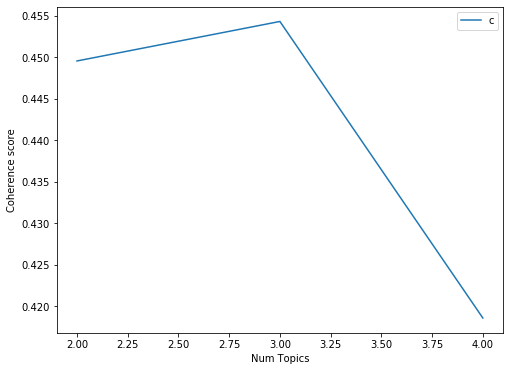

In [56]:
fig = plt.figure(figsize=(8,6))
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
fig.savefig('LDA_coherence.png', dpi=300)

In [57]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4495
Num Topics = 3  has Coherence Value of 0.4543
Num Topics = 4  has Coherence Value of 0.4186
Num Topics = 5  has Coherence Value of nan
Num Topics = 6  has Coherence Value of nan
Num Topics = 7  has Coherence Value of nan
